In [1]:
import sys
sys.path.append('/home/xinyiz/pamrats')

In [2]:
##This is adapted from https://github.com/tkipf/gae/blob/master/gae/train.py and https://github.com/tkipf/pygcn/blob/master/pygcn/train.py##

import time
import os

# Train on CPU (hide GPU) due to memory constraints
# os.environ['CUDA_VISIBLE_DEVICES'] = ""

import scanpy
import numpy as np
import scipy.sparse as sp

import torch
from torch import optim

# from sklearn.metrics import roc_auc_score
# from sklearn.metrics import average_precision_score

import gae.gae.optimizer as optimizer
import gae.gae.model
import gae.gae.preprocessing as preprocessing

import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import umap
import pandas as pd
from sklearn.preprocessing import scale
from sklearn.preprocessing import MinMaxScaler

In [3]:
# Settings
os.environ["CUDA_VISIBLE_DEVICES"] = "2" 
use_cuda=True
fastmode=False #Validate during training pass
seed=3
useSavedMaskedEdges=True
maskedgeName='knn20_connectivity'
epochs=10000
saveFreq=10
lr=0.001 #initial learning rate
weight_decay=0 #Weight for L2 loss on embedding matrix.

hidden1=1024 #Number of units in hidden layer 1
hidden2=1024 #Number of units in hidden layer 2
# hidden3=2048
# hidden4=2048
# hidden5=128
fc_dim1=1024
# fc_dim2=128
# fc_dim3=128
# fc_dim4=128
# gcn_dim1=2600
# clf_hidden=256
adv_hidden=128

dropout=0.01
testNodes=0.1 #fraction of total nodes for testing
valNodes=0.05 #fraction of total nodes for validation
XreconWeight=20
# clfweight=20
advWeight=20
# randFeatureSubset=None
model_str='gcn_vae_xa_e2_d1_dca'
clf=None
adv='clf_fc1_control'  #'clf_fc1'
protein=None #'scaled_binary'
proteinWeights=0.05
adj_decodeName=None #gala or None
ridgeL=0.01
shareGenePi=True

num_features=2112
# training_samples=['control13','disease13','disease8']###rename and retrain C8
training_samples=['control13','disease13','disease8','control8']###rename and retrain C8
training_sample_X='logminmax'
switchFreq=100
standardizeX=False
# name='allk20XA_01_dca_noD8' ###rename and retrain D8 C8
name='allk20XA_01_dca_advControl'
logsavepath='/mnt/xinyi/pamrats/log/train_gae_starmap/'+name
modelsavepath='/mnt/xinyi/pamrats/models/train_gae_starmap/'+name
plotsavepath='/mnt/xinyi/pamrats/plots/train_gae_starmap/'+name

#Load data
sampleidx={'disease13':'AD_mouse9494','control13':'AD_mouse9498','disease8':'AD_mouse9723','control8':'AD_mouse9735'}
savedir=os.path.join('/mnt/xinyi/','starmap')
adj_dir=os.path.join(savedir,'a')

featureslist={}
if training_sample_X in ['corrected','scaled']:
    scaleddata=scanpy.read_h5ad('/mnt/xinyi/2021-01-13-mAD-test-dataset/2020-12-27-starmap-mAD-scaled.h5ad')
    
    for s in sampleidx.keys():
        featureslist[s+'X_'+'corrected']=torch.tensor(scaleddata.layers['corrected'][scaleddata.obs['sample']==sampleidx[s]])
        featureslist[s+'X_'+'scaled']=torch.tensor(scaleddata.layers['scaled'][scaleddata.obs['sample']==sampleidx[s]])

else:
    scaleddata=scanpy.read_h5ad('/mnt/xinyi/2021-01-13-mAD-test-dataset/2020-12-27-starmap-mAD-raw.h5ad')
    
    for s in sampleidx.keys():
        scaleddata_train=scaleddata.X[scaleddata.obs['sample']==sampleidx[s]]

        if training_sample_X=='logminmax':
            featurelog_train=np.log2(scaleddata_train+1/2)
            scaler = MinMaxScaler()
            featurelog_train_minmax=np.transpose(scaler.fit_transform(np.transpose(featurelog_train)))
            featureslist[s+'X_'+training_sample_X]=torch.tensor(featurelog_train_minmax)
        elif training_sample_X=='logminmax10':
            featurelog_train=np.log2(scaleddata_train+1/2)
            scaler = MinMaxScaler(feature_range=(0,10))
            featurelog_train_minmax=np.transpose(scaler.fit_transform(np.transpose(featurelog_train)))
            featureslist[s+'X_'+training_sample_X]=torch.tensor(featurelog_train_minmax)

if protein:
    proteinsavepath=os.path.join('/mnt/xinyi/','starmap','protein')
    for s in sampleidx.keys():
        pmtx=sp.load_npz(os.path.join(proteinsavepath,sampleidx[s]+'_'+protein+'.npz'))
        pmtx=preprocessing.sparse_mx_to_torch_sparse_tensor(pmtx)
        pmtx=pmtx.to_dense()
        scalefactor=torch.sum(featureslist[s+'X_'+training_sample_X])/torch.sum(pmtx)*proteinWeights
        featureslist[s+'X_'+training_sample_X]=torch.cat((featureslist[s+'X_'+training_sample_X],pmtx*scalefactor),dim=1)
            
if clf:
    ctlist={}
    ctlist['disease13']=scaleddata.obs.loc[scaleddata.obs['sample']=='AD_mouse9494','top_level'].to_numpy()
    ctlist['control13']=scaleddata.obs.loc[scaleddata.obs['sample']=='AD_mouse9498','top_level'].to_numpy()
    ctlist['disease8']=scaleddata.obs.loc[scaleddata.obs['sample']=='AD_mouse9723','top_level'].to_numpy()
    ctlist['control8']=scaleddata.obs.loc[scaleddata.obs['sample']=='AD_mouse9735','top_level'].to_numpy()
    ct_unique=np.unique(scaleddata.obs.loc[scaleddata.obs['sample']=='AD_mouse9735','top_level'])
    for k in ctlist.keys():
        for i in range(ct_unique.size):
            ctlist[k][ctlist[k]==ct_unique[i]]=i
    
adj_list={}
adj_list['disease13']=sp.load_npz(os.path.join(adj_dir,maskedgeName+'_AD_mouse9494.npz'))
adj_list['control13']=sp.load_npz(os.path.join(adj_dir,maskedgeName+'_AD_mouse9498.npz'))
adj_list['disease8']=sp.load_npz(os.path.join(adj_dir,maskedgeName+'_AD_mouse9723.npz'))
adj_list['control8']=sp.load_npz(os.path.join(adj_dir,maskedgeName+'_AD_mouse9735.npz'))

adjnormlist={}
pos_weightlist={}
normlist={}
for ai in adj_list.keys():
    adjnormlist[ai]=preprocessing.preprocess_graph(adj_list[ai])
    
    pos_weightlist[ai] = torch.tensor(float(adj_list[ai].shape[0] * adj_list[ai].shape[0] - adj_list[ai].sum()) / adj_list[ai].sum()) #using full unmasked adj
    normlist[ai] = adj_list[ai].shape[0] * adj_list[ai].shape[0] / float((adj_list[ai].shape[0] * adj_list[ai].shape[0] - adj_list[ai].sum()) * 2)
    
    adj_label=adj_list[ai] + sp.eye(adj_list[ai].shape[0])
    adj_list[ai]=torch.tensor(adj_label.todense())
    
if adv:
    if 'control' in adv:
        sampleLabellist_ae={}
        sampleLabellist_ae['control13']=torch.tensor([0,1]).expand(adjnormlist['control13'].shape[0],-1)
        sampleLabellist_ae['control8']=torch.tensor([1,0]).expand(adjnormlist['control8'].shape[0],-1)

        sampleLabellist_d={}
        sampleLabellist_d['control13']=torch.tensor([1,0]).expand(adjnormlist['control13'].shape[0],-1)
        sampleLabellist_d['control8']=torch.tensor([0,1]).expand(adjnormlist['control8'].shape[0],-1)        
    else:
        sampleLabellist_ae={}
        sampleLabellist_ae['disease13']=torch.tensor([0,1,1,1]).expand(adjnormlist['disease13'].shape[0],-1)
        sampleLabellist_ae['control13']=torch.tensor([1,0,1,1]).expand(adjnormlist['control13'].shape[0],-1)
        sampleLabellist_ae['disease8']=torch.tensor([1,1,0,1]).expand(adjnormlist['disease8'].shape[0],-1)
        sampleLabellist_ae['control8']=torch.tensor([1,1,1,0]).expand(adjnormlist['control8'].shape[0],-1)

        sampleLabellist_d={}
        sampleLabellist_d['disease13']=torch.tensor([1,0,0,0]).expand(adjnormlist['disease13'].shape[0],-1)
        sampleLabellist_d['control13']=torch.tensor([0,1,0,0]).expand(adjnormlist['control13'].shape[0],-1)
        sampleLabellist_d['disease8']=torch.tensor([0,0,1,0]).expand(adjnormlist['disease8'].shape[0],-1)
        sampleLabellist_d['control8']=torch.tensor([0,0,0,1]).expand(adjnormlist['control8'].shape[0],-1)
    
    
        
    
# adj_decode=None
# if adj_decodeName == 'gala':
#     adj_decode=preprocessing.preprocess_graph_sharp(adj_train)



if 'dca' in model_str:
    rawdata=scanpy.read_h5ad('/mnt/xinyi/2021-01-13-mAD-test-dataset/2020-12-27-starmap-mAD-raw.h5ad')
    features_raw_list={}
    for s in sampleidx.keys():
#         features_raw_list[s+'X_'+'raw']=torch.tensor(rawdata.X[rawdata.obs['sample']==sampleidx[s]]).cuda()
        features_raw_list[s+'X_'+'raw']=torch.tensor(rawdata.X[rawdata.obs['sample']==sampleidx[s]])
        if protein:
            proteinsavepath=os.path.join('/mnt/xinyi/','starmap','protein')
            pmtx=sp.load_npz(os.path.join(proteinsavepath,sampleidx[s]+'_'+protein+'.npz'))
            pmtx=preprocessing.sparse_mx_to_torch_sparse_tensor(pmtx)
            pmtx=pmtx.to_dense()
            scalefactor=torch.sum(features_raw_list[s+'X_raw'])/torch.sum(pmtx)*proteinWeights
            features_raw_list[s+'X_raw']=torch.cat((features_raw_list[s+'X_raw'],pmtx*scalefactor),dim=1)

if clf:
    ct_train=ctlist[training_samples].astype(int)
# features=torch.tensor(np.identity(7000)).float()
# features=features[0:10,:]
if standardizeX:
    features=torch.tensor(scale(features,axis=0, with_mean=True, with_std=True, copy=True))

# Set cuda and seed
np.random.seed(seed)
if use_cuda and (not torch.cuda.is_available()):
    print('cuda not available')
    use_cuda=False
torch.manual_seed(seed)
if use_cuda:
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.enabled = True

# Load data
# if randFeatureSubset != None:
#     idx=np.random.choice(features.shape[1],randFeatureSubset,replace=False)
#     features=features[:,idx]


In [4]:
if not os.path.exists(logsavepath):
    os.mkdir(logsavepath)
if not os.path.exists(modelsavepath):
    os.mkdir(modelsavepath)
if not os.path.exists(plotsavepath):
    os.mkdir(plotsavepath)

In [5]:
# loop over all train/validation sets

mse=torch.nn.MSELoss()
# mse=torch.nn.MSELoss(reduction=None)
# Create model
if model_str=='gcn_vae_xa':
    model = gae.gae.model.GCNModelVAE_XA(num_features, hidden1, hidden2,fc_dim1,fc_dim2,fc_dim3,fc_dim4, dropout)
    loss_kl=optimizer.optimizer_kl
    loss_x=optimizer.optimizer_MSE
    loss_a=optimizer.optimizer_CE
elif model_str == 'gcn_vae_gcnX_inprA':
    model = gae.gae.model.GCNModelVAE_gcnX_inprA(num_features, hidden1, hidden2,gcn_dim1, dropout)
    loss_kl=optimizer.optimizer_kl
    loss_x=optimizer.optimizer_MSE
    loss_a=optimizer.optimizer_CE
    
elif model_str == 'gcn_vae_gcnX_inprA_w':
    model = gae.gae.model.GCNModelVAE_gcnX_inprA_w(num_features, hidden1, hidden2,gcn_dim1, dropout)
    loss_kl=optimizer.optimizer_kl
    loss_x=optimizer.optimizer_MSE
    loss_a=optimizer.optimizer_CE    
    
elif model_str=='gcn_vae_xa_e3':
    model = gae.gae.model.GCNModelVAE_XA_e3(num_features, hidden1, hidden2,hidden3,fc_dim1,fc_dim2,fc_dim3,fc_dim4, dropout)
    loss_kl=optimizer.optimizer_kl
    loss_x=optimizer.optimizer_MSE
    loss_a=optimizer.optimizer_CE
    
elif model_str == 'gcn_vae_xa_e1':
    model = gae.gae.model.GCNModelVAE_XA_e1(num_features, hidden1, dropout)
    loss_kl=optimizer.optimizer_kl
    loss_x=optimizer.optimizer_MSE
    loss_a=optimizer.optimizer_CE

elif model_str == 'gcn_vae_xa_e2_d1':
    model = gae.gae.model.GCNModelVAE_XA_e2_d1(num_features, hidden1,hidden2, dropout)
    loss_kl=optimizer.optimizer_kl
    loss_x=optimizer.optimizer_MSE
    loss_a=optimizer.optimizer_CE
    
elif model_str=='gcn_vae_xa_e2_d1_dca':
    model = gae.gae.model.GCNModelVAE_XA_e2_d1_DCA(num_features, hidden1,hidden2,fc_dim1, dropout)
    loss_kl=optimizer.optimizer_kl
    loss_x=optimizer.optimizer_zinb
    loss_a=optimizer.optimizer_CE

elif model_str=='gcn_vae_xa_e2_d1_dcaFork':
    model = gae.gae.model.GCNModelVAE_XA_e2_d1_DCAfork(num_features, hidden1,hidden2,fc_dim1, dropout)
    loss_kl=optimizer.optimizer_kl
    loss_x=optimizer.optimizer_zinb
    loss_a=optimizer.optimizer_CE

elif model_str=='gcn_vae_xa_e2_d1_dcaElemPi':
    model = gae.gae.model.GCNModelVAE_XA_e2_d1_DCAelemPi(num_features, hidden1,hidden2,fc_dim1, dropout,shareGenePi)
    loss_kl=optimizer.optimizer_kl
    loss_x=optimizer.optimizer_zinb
    loss_a=optimizer.optimizer_CE

elif model_str=='gcn_vae_xa_e2_d1_dcaConstantDisp':
    model = gae.gae.model.GCNModelVAE_XA_e2_d1_DCA_constantDisp(num_features, hidden1,hidden2,fc_dim1, dropout,shareGenePi)
    loss_kl=optimizer.optimizer_kl
    loss_x=optimizer.optimizer_zinb
    loss_a=optimizer.optimizer_CE    
    
elif model_str == 'gcn_vae_xa_e4_d1':
    model = gae.gae.model.GCNModelVAE_XA_e4_d1(num_features, hidden1,hidden2,hidden3,hidden4, dropout)
    loss_kl=optimizer.optimizer_kl
    loss_x=optimizer.optimizer_MSE
    loss_a=optimizer.optimizer_CE    
    
elif model_str=='fc':
    model = gae.gae.model.FCVAE(num_features, hidden1, hidden2,hidden3,hidden4,hidden5,fc_dim1,fc_dim2,fc_dim3,fc_dim4, dropout)
    loss_kl=optimizer.optimizer_kl
    loss_x=optimizer.optimizer_MSE
#     loss_x=mse
    loss_a=optimizer.optimizer_CE
elif model_str=='fcae':
    model = gae.gae.model.FCAE(num_features, hidden1, hidden2,hidden3,hidden4,hidden5,fc_dim1,fc_dim2,fc_dim3,fc_dim4, dropout)
    loss_x=optimizer.optimizer_MSE
#     loss_x=mse

elif model_str=='fcae1':
    model = gae.gae.model.FCAE1(num_features, dropout,hidden1)
    loss_x=optimizer.optimizer_MSE
#     loss_x=mse
elif model_str=='fcae2':
    model = gae.gae.model.FCAE2(num_features, dropout,hidden1,hidden2)
    loss_x=optimizer.optimizer_MSE

elif model_str=='fc1':
    model = gae.gae.model.FCVAE1(num_features, hidden1,dropout)
    loss_x=optimizer.optimizer_MSE
    loss_kl=optimizer.optimizer_kl
    loss_a=optimizer.optimizer_CE

elif model_str=='fc1_dca':
    model = gae.gae.model.FCVAE1_DCA(num_features, hidden1,fc_dim1, dropout)
    loss_x=optimizer.optimizer_zinb
    loss_kl=optimizer.optimizer_kl
    loss_a=optimizer.optimizer_CE

if clf=='clf_fc1':
    modelClf=gae.gae.model.Clf_fc1(hidden2, dropout,clf_hidden,ct_unique.size)
    loss_clf=torch.nn.CrossEntropyLoss()
    
if adv=='clf_fc1' or adv=='clf_fc1_control':
    modelAdv=gae.gae.model.Clf_fc1(hidden2, dropout,adv_hidden,sampleLabellist_ae['control13'].size()[1])
    loss_adv=optimizer.optimizer_CEclf
    

if use_cuda:
    model.cuda()
    if clf:
        modelClf.cuda()
        ct_train=torch.tensor(ct_train).cuda()
    if adv:
        modelAdv.cuda()
#         for sk in sampleLabellist_ae.keys():
#             sampleLabellist_ae[sk]=sampleLabellist_ae[sk].cuda().float()
#             sampleLabellist_d[sk]=sampleLabellist_d[sk].cuda().float()
#     for fk in featureslist.keys():
#         featureslist[fk] = featureslist[fk].cuda().float()
#     for ak in adj_list.keys():
#         adjnormlist[ak] =adjnormlist[ak].cuda()
#         adj_list[ak] = adj_list[ak].cuda().float()
#     if adj_decode is not None:
#         adj_decode=adj_decode.cuda()
    

optimizerVAEXA = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
if clf:
    optimizerClf=optim.Adam(modelClf.parameters(), lr=lr, weight_decay=weight_decay)
if adv:
    optimizerAdv=optim.Adam(modelAdv.parameters(), lr=lr, weight_decay=weight_decay)    


In [6]:
# model.load_state_dict(torch.load(os.path.join(modelsavepath,str(1230)+'.pt')))
 
def train(epoch):
    t = time.time()
    model.train()
    optimizerVAEXA.zero_grad()
    
    if adj_decodeName==None:
        adj_recon,mu,logvar,z,features_recon = model(features, adj_norm)
    #     features_recon, z, mu, logvar=model(features.float())
    else:
        adj_recon,mu,logvar,z,features_recon = model(features, adj_norm,adj_decode)
        
    
    if clf:
        modelClf.train()
        optimizerClf.zero_grad()
        clfOut=modelClf(z)
    if adv and (training_samples_t in list(sampleLabellist_ae.keys())):
        modelAdv.eval()
        advOut=modelAdv(z)
    
    loss_kl_train=loss_kl(mu, logvar, train_nodes_idx)
    if 'dca' in model_str:
        loss_x_train=loss_x(features_recon, features,train_nodes_idx,XreconWeight,ridgeL,features_raw)
    else:
        loss_x_train=loss_x(features_recon, features,train_nodes_idx,XreconWeight,mse)
    loss_a_train=loss_a(adj_recon, adj_label, pos_weight, norm,train_nodes_idx)
    loss = loss_kl_train+loss_x_train+loss_a_train
#     loss=loss_x_train #for lossXreconOnly only
#     loss=loss_kl_train+loss_x_train #for lossXreconOnly_wKL only
#     loss = loss_kl_train+loss_a_train #for lossAreconOnly_wKL only
    if clf:
        loss_clf_train=loss_clf(clfOut[train_nodes_idx],ct_train[train_nodes_idx])
        loss=loss+clfweight*loss_clf_train
    if adv and (training_samples_t in list(sampleLabellist_ae.keys())):
        loss_adv_train=loss_adv(advOut,sampleLabel_ae,train_nodes_idx)
        loss+=loss_adv_train*advWeight
    loss.backward()
    optimizerVAEXA.step()
    if clf:
        optimizerClf.step()

    if not fastmode:
        # Evaluate validation set performance separately,
        # deactivates dropout during validation run & no variation in z.
        model.eval()
        if adj_decodeName==None:
            adj_recon,mu,logvar,z, features_recon = model(features, adj_norm)
    #         features_recon, z, mu, logvar=model(features.float())
        else:
            adj_recon,mu,logvar,z, features_recon = model(features, adj_norm,adj_decode)
    
    if clf:
        modelClf.eval()
        clfOut=modelClf(z)
    if adv and (training_samples_t in list(sampleLabellist_ae.keys())):
        advOut=modelAdv(z)
    if 'dca' in model_str:
        loss_x_val=loss_x(features_recon, features,val_nodes_idx,XreconWeight,ridgeL,features_raw)
    else:
        loss_x_val=loss_x(features_recon, features,val_nodes_idx,XreconWeight,mse)
    loss_a_val=loss_a(adj_recon, adj_label, pos_weight, norm,val_nodes_idx)
    loss_val = loss_x_val+loss_a_val
#     loss_val=loss_x_val
#     loss_val=loss_a_val
    if clf:
        loss_clf_val=loss_clf(clfOut[val_nodes_idx],ct_train[val_nodes_idx])
        loss_val=loss_val+clfweight*loss_clf_val
    if adv and (training_samples_t in list(sampleLabellist_ae.keys())):
        loss_adv_val=loss_adv(advOut,sampleLabel_ae,val_nodes_idx)
        loss_val+=loss_adv_val*advWeight
#     print(features_recon[:5,:5])
    print(training_samples_t+' Epoch: {:04d}'.format(epoch),
          'loss_train: {:.4f}'.format(loss.item()),
          'loss_kl_train: {:.4f}'.format(loss_kl_train.item()),
          'loss_x_train: {:.4f}'.format(loss_x_train.item()),
          'loss_a_train: {:.4f}'.format(loss_a_train.item()),
#           'loss_clf_train: {:.4f}'.format(loss_clf_train.item()),
          'loss_val: {:.4f}'.format(loss_val.item()),
          'loss_x_val: {:.4f}'.format(loss_x_val.item()),
          'loss_a_val: {:.4f}'.format(loss_a_val.item()),
#           'loss_clf_val: {:.4f}'.format(loss_clf_val.item()),
          'time: {:.4f}s'.format(time.time() - t))
    if adv and (training_samples_t in list(sampleLabellist_ae.keys())):
        print('loss_adv_train: {:.4f}'.format(loss_adv_train.item()),
              'loss_adv_val: {:.4f}'.format(loss_adv_val.item())
             )
#     return loss.item(),loss_x_train.item(),loss_val.item(),loss_x_val.item()
#     return loss.item(),loss_kl_train.item(),loss_x_train.item(),loss_val.item(),loss_x_val.item()
    if clf:
        return loss.item(),loss_kl_train.item(),loss_x_train.item(),loss_a_train.item(),loss_val.item(),loss_x_val.item(),loss_a_val.item(),loss_clf_train.item(),loss_clf_val.item()
    elif adv:
        if (training_samples_t in list(sampleLabellist_ae.keys())):
            return float(loss),float(loss_kl_train),float(loss_x_train),float(loss_a_train),float(loss_val),float(loss_x_val),float(loss_a_val),float(loss_adv_train),float(loss_adv_val)        
        else:
            return float(loss),float(loss_kl_train),float(loss_x_train),float(loss_a_train),float(loss_val),float(loss_x_val),float(loss_a_val),None,None   
    else:
        return float(loss),float(loss_kl_train),float(loss_x_train),float(loss_a_train),float(loss_val),float(loss_x_val),float(loss_a_val)        

def train_discriminator(epoch):
    t = time.time()
    model.eval()
    
    if adj_decodeName==None:
        adj_recon,mu,logvar,z,features_recon = model(features, adj_norm)
    #     features_recon, z, mu, logvar=model(features.float())
    else:
        adj_recon,mu,logvar,z,features_recon = model(features, adj_norm,adj_decode)
        
    
    if clf:
        modelClf.eval()
        clfOut=modelClf(z)
        
    modelAdv.train()
    optimizerAdv.zero_grad()
    advOut=modelAdv(z)
    
    loss_adv_train=loss_adv(advOut,sampleLabel_d,train_nodes_idx)
    loss = loss_adv_train*advWeight
    
    loss.backward()
    optimizerAdv.step()

    modelAdv.eval()
    advOut=modelAdv(z)
    loss_adv_val=loss_adv(advOut,sampleLabel_d,val_nodes_idx)
    loss_val=loss_adv_val*advWeight
    print(training_samples_t+' Epoch: {:04d}'.format(epoch),
          'loss_adv_train: {:.4f}'.format(loss_adv_train.item()),
          'loss_adv_val: {:.4f}'.format(loss_adv_val.item()),
          'time: {:.4f}s'.format(time.time() - t))
    return float(loss_adv_train),float(loss_adv_val)
    
# print('cross-validation ',seti)
train_loss_ep=[None]*epochs
train_loss_kl_ep=[None]*epochs
train_loss_x_ep=[None]*epochs
train_loss_a_ep=[None]*epochs
train_loss_clf_ep=[None]*epochs
train_loss_adv_ep=[None]*epochs
train_loss_advD_ep=[None]*epochs
val_loss_ep=[None]*epochs
val_loss_x_ep=[None]*epochs
val_loss_a_ep=[None]*epochs
val_loss_clf_ep=[None]*epochs
val_loss_adv_ep=[None]*epochs
val_loss_advD_ep=[None]*epochs
t_ep=time.time()
for ep in range(epochs):
    t=int(ep/switchFreq)%len(training_samples)
    training_samples_t=training_samples[t]
    
#     adj_norm=adjnormlist[training_samples_t]
#     adj_label=adj_list[training_samples_t]
#     features=featureslist[training_samples_t+'X_'+training_sample_X]
    adj_norm=adjnormlist[training_samples_t].cuda().float()
    adj_label=adj_list[training_samples_t].cuda().float()
    features=featureslist[training_samples_t+'X_'+training_sample_X].cuda().float()
    pos_weight=pos_weightlist[training_samples_t]
    norm=normlist[training_samples_t]
    if adv and (training_samples_t in list(sampleLabellist_ae.keys())):
#         sampleLabel_ae=sampleLabellist_ae[training_samples_t]
#         sampleLabel_d=sampleLabellist_d[training_samples_t]
        sampleLabel_ae=sampleLabellist_ae[training_samples_t].cuda().float()
        sampleLabel_d=sampleLabellist_d[training_samples_t].cuda().float()
    if 'dca' in model_str:
#         features_raw=features_raw_list[training_samples_t+'X_raw']
        features_raw=features_raw_list[training_samples_t+'X_raw'].cuda()
    num_nodes,_ = features.shape
    
    maskpath=os.path.join(savedir,'trainMask',training_samples_t+'_'+maskedgeName+'_seed'+str(seed)+'.pkl')
    if useSavedMaskedEdges and os.path.exists(maskpath):
#         print('opening saved')
        with open(maskpath, 'rb') as input:
            maskedgeres = pickle.load(input)
    else:
        # construct training, validation, and test sets
        maskedgeres= preprocessing.mask_nodes_edges(features.shape[0],testNodeSize=testNodes,valNodeSize=valNodes)
        with open(maskpath, 'wb') as output:
            pickle.dump(maskedgeres, output, pickle.HIGHEST_PROTOCOL)
    train_nodes_idx,val_nodes_idx,test_nodes_idx = maskedgeres
    if use_cuda:
        train_nodes_idx=train_nodes_idx.cuda()
        val_nodes_idx=val_nodes_idx.cuda()
        test_nodes_idx=test_nodes_idx.cuda()
    
    if clf:
        train_loss_ep[ep],train_loss_kl_ep[ep],train_loss_x_ep[ep],train_loss_a_ep[ep],val_loss_ep[ep],val_loss_x_ep[ep],val_loss_a_ep[ep],train_loss_clf_ep[ep],val_loss_clf_ep[ep]=train(ep)
    elif adv:
        train_loss_ep[ep],train_loss_kl_ep[ep],train_loss_x_ep[ep],train_loss_a_ep[ep],val_loss_ep[ep],val_loss_x_ep[ep],val_loss_a_ep[ep],train_loss_adv_ep[ep],val_loss_adv_ep[ep]=train(ep)
        if (training_samples_t in list(sampleLabellist_ae.keys())):
            train_loss_advD_ep[ep],val_loss_advD_ep[ep]=train_discriminator(ep)
    else:
        train_loss_ep[ep],train_loss_kl_ep[ep],train_loss_x_ep[ep],train_loss_a_ep[ep],val_loss_ep[ep],val_loss_x_ep[ep],val_loss_a_ep[ep]=train(ep)

        
    if ep%saveFreq == 0:
        torch.save(model.cpu().state_dict(), os.path.join(modelsavepath,str(ep)+'.pt'))
    if use_cuda:
        model.cuda()
print(' total time: {:.4f}s'.format(time.time() - t_ep))


control13 Epoch: 0000 loss_train: 35.3245 loss_kl_train: 0.0006 loss_x_train: 7.7450 loss_a_train: 13.6492 loss_val: 22.8878 loss_x_val: 7.6562 loss_a_val: 1.4731 time: 0.8324s
loss_adv_train: 0.6965 loss_adv_val: 0.6879
control13 Epoch: 0000 loss_adv_train: 0.7502 loss_adv_val: 0.6977 time: 0.0812s
control13 Epoch: 0001 loss_train: 33.0995 loss_kl_train: 0.0003 loss_x_train: 6.4262 loss_a_train: 13.0383 loss_val: 24.1025 loss_x_val: 7.5565 loss_a_val: 3.2557 time: 0.4996s
loss_adv_train: 0.6817 loss_adv_val: 0.6645
control13 Epoch: 0001 loss_adv_train: 0.7475 loss_adv_val: 0.7215 time: 0.0801s
control13 Epoch: 0002 loss_train: 31.8352 loss_kl_train: 0.0006 loss_x_train: 5.3881 loss_a_train: 13.1726 loss_val: 23.8909 loss_x_val: 7.4756 loss_a_val: 3.3284 time: 0.5060s
loss_adv_train: 0.6637 loss_adv_val: 0.6543
control13 Epoch: 0002 loss_adv_train: 0.7460 loss_adv_val: 0.7327 time: 0.0823s
control13 Epoch: 0003 loss_train: 30.8391 loss_kl_train: 0.0006 loss_x_train: 4.5853 loss_a_train

control13 Epoch: 0028 loss_train: 28.7762 loss_kl_train: 0.0014 loss_x_train: 1.8244 loss_a_train: 13.3160 loss_val: 25.0830 loss_x_val: 5.1466 loss_a_val: 6.5444 time: 0.5006s
loss_adv_train: 0.6817 loss_adv_val: 0.6696
control13 Epoch: 0028 loss_adv_train: 0.7258 loss_adv_val: 0.7289 time: 0.0816s
control13 Epoch: 0029 loss_train: 29.0691 loss_kl_train: 0.0015 loss_x_train: 1.8037 loss_a_train: 13.4014 loss_val: 25.2201 loss_x_val: 5.0651 loss_a_val: 7.0460 time: 0.5038s
loss_adv_train: 0.6931 loss_adv_val: 0.6554
control13 Epoch: 0029 loss_adv_train: 0.7258 loss_adv_val: 0.7467 time: 0.0832s
control13 Epoch: 0030 loss_train: 29.3955 loss_kl_train: 0.0016 loss_x_train: 1.7842 loss_a_train: 13.6389 loss_val: 25.2510 loss_x_val: 4.9837 loss_a_val: 7.5902 time: 0.5030s
loss_adv_train: 0.6985 loss_adv_val: 0.6339
control13 Epoch: 0030 loss_adv_train: 0.7256 loss_adv_val: 0.7780 time: 0.0829s
control13 Epoch: 0031 loss_train: 29.5099 loss_kl_train: 0.0017 loss_x_train: 1.7657 loss_a_train

control13 Epoch: 0056 loss_train: 50.3568 loss_kl_train: 0.0022 loss_x_train: 1.5217 loss_a_train: 15.6526 loss_val: 32.4852 loss_x_val: 4.8585 loss_a_val: 10.5631 time: 0.5042s
loss_adv_train: 1.6590 loss_adv_val: 0.8532
control13 Epoch: 0056 loss_adv_train: 0.7131 loss_adv_val: 0.5493 time: 0.0828s
control13 Epoch: 0057 loss_train: 51.5813 loss_kl_train: 0.0021 loss_x_train: 1.5172 loss_a_train: 15.3261 loss_val: 31.6890 loss_x_val: 4.8042 loss_a_val: 10.2112 time: 0.5061s
loss_adv_train: 1.7368 loss_adv_val: 0.8337
control13 Epoch: 0057 loss_adv_train: 0.7132 loss_adv_val: 0.5643 time: 0.0816s
control13 Epoch: 0058 loss_train: 52.7211 loss_kl_train: 0.0020 loss_x_train: 1.5130 loss_a_train: 15.0729 loss_val: 30.8059 loss_x_val: 4.7579 loss_a_val: 9.7294 time: 0.5064s
loss_adv_train: 1.8067 loss_adv_val: 0.8159
control13 Epoch: 0058 loss_adv_train: 0.7135 loss_adv_val: 0.5823 time: 0.0816s
control13 Epoch: 0059 loss_train: 53.3012 loss_kl_train: 0.0019 loss_x_train: 1.5087 loss_a_tra

control13 Epoch: 0084 loss_train: 35.7701 loss_kl_train: 0.0065 loss_x_train: 1.4410 loss_a_train: 13.5104 loss_val: 30.4511 loss_x_val: 3.6495 loss_a_val: 12.5733 time: 0.5109s
loss_adv_train: 1.0406 loss_adv_val: 0.7114
control13 Epoch: 0084 loss_adv_train: 0.6946 loss_adv_val: 0.6785 time: 0.0855s
control13 Epoch: 0085 loss_train: 35.8961 loss_kl_train: 0.0071 loss_x_train: 1.4390 loss_a_train: 14.7174 loss_val: 29.8190 loss_x_val: 3.7922 loss_a_val: 11.1993 time: 0.5084s
loss_adv_train: 0.9866 loss_adv_val: 0.7414
control13 Epoch: 0085 loss_adv_train: 0.6939 loss_adv_val: 0.6568 time: 0.0855s
control13 Epoch: 0086 loss_train: 35.6047 loss_kl_train: 0.0072 loss_x_train: 1.4375 loss_a_train: 13.6342 loss_val: 30.7173 loss_x_val: 3.7638 loss_a_val: 12.5268 time: 0.5102s
loss_adv_train: 1.0263 loss_adv_val: 0.7213
control13 Epoch: 0086 loss_adv_train: 0.6934 loss_adv_val: 0.6745 time: 0.0880s
control13 Epoch: 0087 loss_train: 35.5462 loss_kl_train: 0.0077 loss_x_train: 1.4357 loss_a_tr

disease13 Epoch: 0120 loss_train: 8.5970 loss_kl_train: 0.0119 loss_x_train: 1.5364 loss_a_train: 7.0487 loss_val: 6.6955 loss_x_val: 4.3387 loss_a_val: 2.3568 time: 0.7667s
disease13 Epoch: 0121 loss_train: 8.5012 loss_kl_train: 0.0122 loss_x_train: 1.5353 loss_a_train: 6.9536 loss_val: 6.6441 loss_x_val: 4.2860 loss_a_val: 2.3581 time: 0.7680s
disease13 Epoch: 0122 loss_train: 8.4340 loss_kl_train: 0.0125 loss_x_train: 1.5347 loss_a_train: 6.8868 loss_val: 6.5658 loss_x_val: 4.2196 loss_a_val: 2.3463 time: 0.7678s
disease13 Epoch: 0123 loss_train: 8.3529 loss_kl_train: 0.0129 loss_x_train: 1.5340 loss_a_train: 6.8060 loss_val: 6.4274 loss_x_val: 4.1319 loss_a_val: 2.2955 time: 0.7631s
disease13 Epoch: 0124 loss_train: 8.2663 loss_kl_train: 0.0132 loss_x_train: 1.5333 loss_a_train: 6.7198 loss_val: 6.2803 loss_x_val: 4.0294 loss_a_val: 2.2509 time: 0.7600s
disease13 Epoch: 0125 loss_train: 8.1648 loss_kl_train: 0.0136 loss_x_train: 1.5322 loss_a_train: 6.6190 loss_val: 6.1168 loss_x_v

disease13 Epoch: 0168 loss_train: 4.9072 loss_kl_train: 0.0414 loss_x_train: 1.5197 loss_a_train: 3.3461 loss_val: 3.6398 loss_x_val: 2.5859 loss_a_val: 1.0539 time: 0.7718s
disease13 Epoch: 0169 loss_train: 4.8816 loss_kl_train: 0.0422 loss_x_train: 1.5188 loss_a_train: 3.3205 loss_val: 3.5222 loss_x_val: 2.5730 loss_a_val: 0.9492 time: 0.7733s
disease13 Epoch: 0170 loss_train: 4.8087 loss_kl_train: 0.0429 loss_x_train: 1.5185 loss_a_train: 3.2474 loss_val: 3.4717 loss_x_val: 2.5060 loss_a_val: 0.9657 time: 0.7642s
disease13 Epoch: 0171 loss_train: 4.8021 loss_kl_train: 0.0436 loss_x_train: 1.5177 loss_a_train: 3.2408 loss_val: 3.4886 loss_x_val: 2.4143 loss_a_val: 1.0743 time: 0.7746s
disease13 Epoch: 0172 loss_train: 4.7597 loss_kl_train: 0.0445 loss_x_train: 1.5166 loss_a_train: 3.1986 loss_val: 3.4357 loss_x_val: 2.4708 loss_a_val: 0.9649 time: 0.7678s
disease13 Epoch: 0173 loss_train: 4.6999 loss_kl_train: 0.0452 loss_x_train: 1.5174 loss_a_train: 3.1374 loss_val: 3.4563 loss_x_v

disease8 Epoch: 0216 loss_train: 3.8363 loss_kl_train: 0.0853 loss_x_train: 1.3069 loss_a_train: 2.4441 loss_val: 2.7261 loss_x_val: 1.6464 loss_a_val: 1.0797 time: 0.4601s
disease8 Epoch: 0217 loss_train: 3.8714 loss_kl_train: 0.0863 loss_x_train: 1.3068 loss_a_train: 2.4782 loss_val: 2.5778 loss_x_val: 1.6299 loss_a_val: 0.9479 time: 0.4568s
disease8 Epoch: 0218 loss_train: 3.8041 loss_kl_train: 0.0869 loss_x_train: 1.3064 loss_a_train: 2.4108 loss_val: 2.5841 loss_x_val: 1.6087 loss_a_val: 0.9754 time: 0.4587s
disease8 Epoch: 0219 loss_train: 3.8045 loss_kl_train: 0.0877 loss_x_train: 1.3059 loss_a_train: 2.4109 loss_val: 2.5732 loss_x_val: 1.5981 loss_a_val: 0.9751 time: 0.4565s
disease8 Epoch: 0220 loss_train: 3.7727 loss_kl_train: 0.0884 loss_x_train: 1.3053 loss_a_train: 2.3790 loss_val: 2.5480 loss_x_val: 1.5871 loss_a_val: 0.9609 time: 0.4614s
disease8 Epoch: 0221 loss_train: 3.7485 loss_kl_train: 0.0892 loss_x_train: 1.3049 loss_a_train: 2.3544 loss_val: 2.5431 loss_x_val: 1.

disease8 Epoch: 0264 loss_train: 3.2070 loss_kl_train: 0.1243 loss_x_train: 1.2956 loss_a_train: 1.7871 loss_val: 2.4769 loss_x_val: 1.4933 loss_a_val: 0.9836 time: 0.4591s
disease8 Epoch: 0265 loss_train: 3.1917 loss_kl_train: 0.1249 loss_x_train: 1.2958 loss_a_train: 1.7710 loss_val: 2.4863 loss_x_val: 1.4884 loss_a_val: 0.9978 time: 0.4574s
disease8 Epoch: 0266 loss_train: 3.1904 loss_kl_train: 0.1256 loss_x_train: 1.2956 loss_a_train: 1.7692 loss_val: 2.4724 loss_x_val: 1.4871 loss_a_val: 0.9853 time: 0.4585s
disease8 Epoch: 0267 loss_train: 3.1788 loss_kl_train: 0.1261 loss_x_train: 1.2957 loss_a_train: 1.7571 loss_val: 2.4697 loss_x_val: 1.4829 loss_a_val: 0.9869 time: 0.4555s
disease8 Epoch: 0268 loss_train: 3.1698 loss_kl_train: 0.1267 loss_x_train: 1.2956 loss_a_train: 1.7476 loss_val: 2.4705 loss_x_val: 1.4813 loss_a_val: 0.9893 time: 0.4612s
disease8 Epoch: 0269 loss_train: 3.1659 loss_kl_train: 0.1273 loss_x_train: 1.2952 loss_a_train: 1.7434 loss_val: 2.4767 loss_x_val: 1.

control8 Epoch: 0307 loss_train: 10.2942 loss_kl_train: 0.1519 loss_x_train: 1.4352 loss_a_train: 2.2244 loss_val: 9.4373 loss_x_val: 1.5762 loss_a_val: 1.4650 time: 0.5390s
loss_adv_train: 0.3241 loss_adv_val: 0.3198
control8 Epoch: 0307 loss_adv_train: 0.7881 loss_adv_val: 1.9514 time: 0.0897s
control8 Epoch: 0308 loss_train: 10.2403 loss_kl_train: 0.1511 loss_x_train: 1.4352 loss_a_train: 1.8700 loss_val: 10.1574 loss_x_val: 1.5665 loss_a_val: 2.1367 time: 0.5358s
loss_adv_train: 0.3392 loss_adv_val: 0.3227
control8 Epoch: 0308 loss_adv_train: 0.7871 loss_adv_val: 1.7626 time: 0.0871s
control8 Epoch: 0309 loss_train: 11.1459 loss_kl_train: 0.1506 loss_x_train: 1.4349 loss_a_train: 2.5278 loss_val: 10.1342 loss_x_val: 1.5731 loss_a_val: 1.8386 time: 0.5350s
loss_adv_train: 0.3516 loss_adv_val: 0.3361
control8 Epoch: 0309 loss_adv_train: 0.7863 loss_adv_val: 1.5662 time: 0.0882s
control8 Epoch: 0310 loss_train: 11.3021 loss_kl_train: 0.1499 loss_x_train: 1.4347 loss_a_train: 2.2233 lo

control8 Epoch: 0335 loss_train: 15.9346 loss_kl_train: 0.1131 loss_x_train: 1.4282 loss_a_train: 5.4773 loss_val: 16.9949 loss_x_val: 1.5065 loss_a_val: 7.7324 time: 0.5441s
loss_adv_train: 0.4458 loss_adv_val: 0.3878
control8 Epoch: 0335 loss_adv_train: 0.7715 loss_adv_val: 1.5837 time: 0.0896s
control8 Epoch: 0336 loss_train: 17.1885 loss_kl_train: 0.1119 loss_x_train: 1.4281 loss_a_train: 8.1275 loss_val: 16.6164 loss_x_val: 1.4902 loss_a_val: 5.9871 time: 0.5389s
loss_adv_train: 0.3761 loss_adv_val: 0.4570
control8 Epoch: 0336 loss_adv_train: 0.7697 loss_adv_val: 1.1931 time: 0.0880s
control8 Epoch: 0337 loss_train: 16.3010 loss_kl_train: 0.1099 loss_x_train: 1.4279 loss_a_train: 6.4384 loss_val: 17.6796 loss_x_val: 1.4842 loss_a_val: 8.7501 time: 0.5355s
loss_adv_train: 0.4162 loss_adv_val: 0.3723
control8 Epoch: 0337 loss_adv_train: 0.7698 loss_adv_val: 1.5538 time: 0.0883s
control8 Epoch: 0338 loss_train: 18.2533 loss_kl_train: 0.1086 loss_x_train: 1.4277 loss_a_train: 9.1401 l

control8 Epoch: 0363 loss_train: 20.1289 loss_kl_train: 0.0596 loss_x_train: 1.4247 loss_a_train: 8.7309 loss_val: 20.5621 loss_x_val: 1.5020 loss_a_val: 9.3105 time: 0.5388s
loss_adv_train: 0.4957 loss_adv_val: 0.4875
control8 Epoch: 0363 loss_adv_train: 0.7531 loss_adv_val: 1.1076 time: 0.0880s
control8 Epoch: 0364 loss_train: 21.3577 loss_kl_train: 0.0580 loss_x_train: 1.4247 loss_a_train: 10.1056 loss_val: 20.2561 loss_x_val: 1.5128 loss_a_val: 8.1674 time: 0.5376s
loss_adv_train: 0.4885 loss_adv_val: 0.5288
control8 Epoch: 0364 loss_adv_train: 0.7521 loss_adv_val: 0.9674 time: 0.0876s
control8 Epoch: 0365 loss_train: 20.9402 loss_kl_train: 0.0561 loss_x_train: 1.4246 loss_a_train: 8.9637 loss_val: 22.5259 loss_x_val: 1.5163 loss_a_val: 11.6622 time: 0.5372s
loss_adv_train: 0.5248 loss_adv_val: 0.4674
control8 Epoch: 0365 loss_adv_train: 0.7531 loss_adv_val: 1.1318 time: 0.0873s
control8 Epoch: 0366 loss_train: 23.5871 loss_kl_train: 0.0551 loss_x_train: 1.4245 loss_a_train: 12.254

control8 Epoch: 0391 loss_train: 21.0945 loss_kl_train: 0.0266 loss_x_train: 1.4230 loss_a_train: 8.4091 loss_val: 20.5961 loss_x_val: 1.5043 loss_a_val: 10.7255 time: 0.5348s
loss_adv_train: 0.5618 loss_adv_val: 0.4183
control8 Epoch: 0391 loss_adv_train: 0.7415 loss_adv_val: 1.6639 time: 0.0897s
control8 Epoch: 0392 loss_train: 22.6118 loss_kl_train: 0.0268 loss_x_train: 1.4231 loss_a_train: 11.9220 loss_val: 21.7755 loss_x_val: 1.5069 loss_a_val: 4.0335 time: 0.5349s
loss_adv_train: 0.4620 loss_adv_val: 0.8118
control8 Epoch: 0392 loss_adv_train: 0.7383 loss_adv_val: 0.7620 time: 0.0853s
control8 Epoch: 0393 loss_train: 22.8730 loss_kl_train: 0.0255 loss_x_train: 1.4230 loss_a_train: 6.4679 loss_val: 21.3139 loss_x_val: 1.4952 loss_a_val: 11.8985 time: 0.5351s
loss_adv_train: 0.7478 loss_adv_val: 0.3960
control8 Epoch: 0393 loss_adv_train: 0.7411 loss_adv_val: 1.9848 time: 0.0887s
control8 Epoch: 0394 loss_train: 23.1085 loss_kl_train: 0.0265 loss_x_train: 1.4229 loss_a_train: 12.89

control13 Epoch: 0419 loss_train: 24.7069 loss_kl_train: 0.0439 loss_x_train: 1.3408 loss_a_train: 6.4435 loss_val: 17.5182 loss_x_val: 1.3838 loss_a_val: 6.1865 time: 0.5122s
loss_adv_train: 0.8439 loss_adv_val: 0.4974
control13 Epoch: 0419 loss_adv_train: 0.7182 loss_adv_val: 0.9973 time: 0.0854s
control13 Epoch: 0420 loss_train: 24.9310 loss_kl_train: 0.0458 loss_x_train: 1.3408 loss_a_train: 7.5485 loss_val: 17.8518 loss_x_val: 1.3836 loss_a_val: 6.4113 time: 0.5105s
loss_adv_train: 0.7998 loss_adv_val: 0.5028
control13 Epoch: 0420 loss_adv_train: 0.7175 loss_adv_val: 0.9714 time: 0.0854s
control13 Epoch: 0421 loss_train: 24.4577 loss_kl_train: 0.0474 loss_x_train: 1.3408 loss_a_train: 7.6153 loss_val: 17.7277 loss_x_val: 1.3833 loss_a_val: 6.1494 time: 0.5078s
loss_adv_train: 0.7727 loss_adv_val: 0.5098
control13 Epoch: 0421 loss_adv_train: 0.7167 loss_adv_val: 0.9542 time: 0.0835s
control13 Epoch: 0422 loss_train: 24.1404 loss_kl_train: 0.0489 loss_x_train: 1.3408 loss_a_train: 7

control13 Epoch: 0447 loss_train: 25.1767 loss_kl_train: 0.0924 loss_x_train: 1.3388 loss_a_train: 5.3879 loss_val: 20.5308 loss_x_val: 1.3729 loss_a_val: 4.8036 time: 0.5121s
loss_adv_train: 0.9179 loss_adv_val: 0.7177
control13 Epoch: 0447 loss_adv_train: 0.6995 loss_adv_val: 0.6765 time: 0.0856s
control13 Epoch: 0448 loss_train: 25.1165 loss_kl_train: 0.0941 loss_x_train: 1.3387 loss_a_train: 5.2690 loss_val: 20.7526 loss_x_val: 1.3741 loss_a_val: 5.1722 time: 0.5131s
loss_adv_train: 0.9207 loss_adv_val: 0.7103
control13 Epoch: 0448 loss_adv_train: 0.6987 loss_adv_val: 0.6834 time: 0.0870s
control13 Epoch: 0449 loss_train: 25.0388 loss_kl_train: 0.0959 loss_x_train: 1.3387 loss_a_train: 5.5719 loss_val: 21.0900 loss_x_val: 1.3743 loss_a_val: 5.7029 time: 0.5117s
loss_adv_train: 0.9016 loss_adv_val: 0.7006
control13 Epoch: 0449 loss_adv_train: 0.6982 loss_adv_val: 0.6934 time: 0.0869s
control13 Epoch: 0450 loss_train: 25.1525 loss_kl_train: 0.0976 loss_x_train: 1.3386 loss_a_train: 6

control13 Epoch: 0475 loss_train: 25.4119 loss_kl_train: 0.1240 loss_x_train: 1.3376 loss_a_train: 5.4001 loss_val: 20.2636 loss_x_val: 1.3771 loss_a_val: 4.7798 time: 0.5163s
loss_adv_train: 0.9275 loss_adv_val: 0.7053
control13 Epoch: 0475 loss_adv_train: 0.6804 loss_adv_val: 0.6799 time: 0.0849s
control13 Epoch: 0476 loss_train: 25.1068 loss_kl_train: 0.1249 loss_x_train: 1.3374 loss_a_train: 5.0425 loss_val: 20.2499 loss_x_val: 1.3766 loss_a_val: 5.2502 time: 0.5113s
loss_adv_train: 0.9301 loss_adv_val: 0.6812
control13 Epoch: 0476 loss_adv_train: 0.6801 loss_adv_val: 0.6965 time: 0.0846s
control13 Epoch: 0477 loss_train: 25.0283 loss_kl_train: 0.1259 loss_x_train: 1.3374 loss_a_train: 5.4367 loss_val: 19.8243 loss_x_val: 1.3753 loss_a_val: 4.9601 time: 0.5120s
loss_adv_train: 0.9064 loss_adv_val: 0.6744
control13 Epoch: 0477 loss_adv_train: 0.6799 loss_adv_val: 0.7072 time: 0.0860s
control13 Epoch: 0478 loss_train: 24.9873 loss_kl_train: 0.1267 loss_x_train: 1.3374 loss_a_train: 5

disease13 Epoch: 0504 loss_train: 4.6124 loss_kl_train: 0.1347 loss_x_train: 1.4670 loss_a_train: 3.0108 loss_val: 4.0915 loss_x_val: 1.5016 loss_a_val: 2.5899 time: 0.7759s
disease13 Epoch: 0505 loss_train: 4.6141 loss_kl_train: 0.1350 loss_x_train: 1.4668 loss_a_train: 3.0123 loss_val: 4.0906 loss_x_val: 1.5038 loss_a_val: 2.5868 time: 0.7681s
disease13 Epoch: 0506 loss_train: 4.6032 loss_kl_train: 0.1352 loss_x_train: 1.4668 loss_a_train: 3.0012 loss_val: 4.0906 loss_x_val: 1.5060 loss_a_val: 2.5846 time: 0.7642s
disease13 Epoch: 0507 loss_train: 4.6005 loss_kl_train: 0.1354 loss_x_train: 1.4668 loss_a_train: 2.9983 loss_val: 4.0905 loss_x_val: 1.5080 loss_a_val: 2.5825 time: 0.7643s
disease13 Epoch: 0508 loss_train: 4.6128 loss_kl_train: 0.1356 loss_x_train: 1.4667 loss_a_train: 3.0105 loss_val: 4.0897 loss_x_val: 1.5101 loss_a_val: 2.5796 time: 0.7619s
disease13 Epoch: 0509 loss_train: 4.5903 loss_kl_train: 0.1357 loss_x_train: 1.4666 loss_a_train: 2.9880 loss_val: 4.0873 loss_x_v

disease13 Epoch: 0552 loss_train: 3.4604 loss_kl_train: 0.1280 loss_x_train: 1.4642 loss_a_train: 1.8683 loss_val: 2.8984 loss_x_val: 1.5145 loss_a_val: 1.3839 time: 0.7673s
disease13 Epoch: 0553 loss_train: 3.4046 loss_kl_train: 0.1278 loss_x_train: 1.4642 loss_a_train: 1.8126 loss_val: 2.8436 loss_x_val: 1.5150 loss_a_val: 1.3286 time: 0.7640s
disease13 Epoch: 0554 loss_train: 3.3557 loss_kl_train: 0.1278 loss_x_train: 1.4642 loss_a_train: 1.7638 loss_val: 2.7879 loss_x_val: 1.5155 loss_a_val: 1.2724 time: 0.7655s
disease13 Epoch: 0555 loss_train: 3.2919 loss_kl_train: 0.1276 loss_x_train: 1.4642 loss_a_train: 1.7001 loss_val: 2.7347 loss_x_val: 1.5161 loss_a_val: 1.2186 time: 0.7648s
disease13 Epoch: 0556 loss_train: 3.2300 loss_kl_train: 0.1276 loss_x_train: 1.4641 loss_a_train: 1.6383 loss_val: 2.6866 loss_x_val: 1.5169 loss_a_val: 1.1697 time: 0.7721s
disease13 Epoch: 0557 loss_train: 3.1754 loss_kl_train: 0.1275 loss_x_train: 1.4641 loss_a_train: 1.5838 loss_val: 2.6373 loss_x_v

disease8 Epoch: 0600 loss_train: 2.7290 loss_kl_train: 0.1536 loss_x_train: 1.2745 loss_a_train: 1.3009 loss_val: 2.1690 loss_x_val: 1.2908 loss_a_val: 0.8782 time: 0.4578s
disease8 Epoch: 0601 loss_train: 2.7249 loss_kl_train: 0.1539 loss_x_train: 1.2737 loss_a_train: 1.2973 loss_val: 2.1472 loss_x_val: 1.2904 loss_a_val: 0.8568 time: 0.4573s
disease8 Epoch: 0602 loss_train: 2.7143 loss_kl_train: 0.1545 loss_x_train: 1.2736 loss_a_train: 1.2862 loss_val: 2.1706 loss_x_val: 1.2860 loss_a_val: 0.8846 time: 0.4569s
disease8 Epoch: 0603 loss_train: 2.7093 loss_kl_train: 0.1549 loss_x_train: 1.2734 loss_a_train: 1.2810 loss_val: 2.1733 loss_x_val: 1.2849 loss_a_val: 0.8884 time: 0.4606s
disease8 Epoch: 0604 loss_train: 2.7033 loss_kl_train: 0.1552 loss_x_train: 1.2733 loss_a_train: 1.2748 loss_val: 2.1699 loss_x_val: 1.2844 loss_a_val: 0.8855 time: 0.4559s
disease8 Epoch: 0605 loss_train: 2.7029 loss_kl_train: 0.1558 loss_x_train: 1.2733 loss_a_train: 1.2738 loss_val: 2.1668 loss_x_val: 1.

disease8 Epoch: 0648 loss_train: 2.5528 loss_kl_train: 0.1757 loss_x_train: 1.2716 loss_a_train: 1.1056 loss_val: 2.1381 loss_x_val: 1.2728 loss_a_val: 0.8653 time: 0.4561s
disease8 Epoch: 0649 loss_train: 2.5455 loss_kl_train: 0.1762 loss_x_train: 1.2715 loss_a_train: 1.0978 loss_val: 2.1444 loss_x_val: 1.2723 loss_a_val: 0.8720 time: 0.4599s
disease8 Epoch: 0650 loss_train: 2.5468 loss_kl_train: 0.1765 loss_x_train: 1.2716 loss_a_train: 1.0987 loss_val: 2.1366 loss_x_val: 1.2721 loss_a_val: 0.8645 time: 0.4571s
disease8 Epoch: 0651 loss_train: 2.5449 loss_kl_train: 0.1769 loss_x_train: 1.2714 loss_a_train: 1.0966 loss_val: 2.1285 loss_x_val: 1.2719 loss_a_val: 0.8566 time: 0.4592s
disease8 Epoch: 0652 loss_train: 2.5477 loss_kl_train: 0.1774 loss_x_train: 1.2714 loss_a_train: 1.0988 loss_val: 2.1261 loss_x_val: 1.2718 loss_a_val: 0.8543 time: 0.4593s
disease8 Epoch: 0653 loss_train: 2.5416 loss_kl_train: 0.1778 loss_x_train: 1.2713 loss_a_train: 1.0924 loss_val: 2.1308 loss_x_val: 1.

disease8 Epoch: 0696 loss_train: 2.4427 loss_kl_train: 0.1945 loss_x_train: 1.2701 loss_a_train: 0.9781 loss_val: 2.1000 loss_x_val: 1.2673 loss_a_val: 0.8328 time: 0.4586s
disease8 Epoch: 0697 loss_train: 2.4320 loss_kl_train: 0.1949 loss_x_train: 1.2701 loss_a_train: 0.9671 loss_val: 2.1023 loss_x_val: 1.2671 loss_a_val: 0.8352 time: 0.4565s
disease8 Epoch: 0698 loss_train: 2.4267 loss_kl_train: 0.1952 loss_x_train: 1.2701 loss_a_train: 0.9614 loss_val: 2.0801 loss_x_val: 1.2671 loss_a_val: 0.8130 time: 0.4595s
disease8 Epoch: 0699 loss_train: 2.4256 loss_kl_train: 0.1956 loss_x_train: 1.2700 loss_a_train: 0.9599 loss_val: 2.0937 loss_x_val: 1.2670 loss_a_val: 0.8267 time: 0.4565s
control8 Epoch: 0700 loss_train: 8.7201 loss_kl_train: 0.2016 loss_x_train: 1.4114 loss_a_train: 0.8819 loss_val: 8.3717 loss_x_val: 1.4230 loss_a_val: 0.7910 time: 0.5416s
loss_adv_train: 0.3113 loss_adv_val: 0.3079
control8 Epoch: 0700 loss_adv_train: 0.7674 loss_adv_val: 3.4841 time: 0.0920s
control8 Epo

control8 Epoch: 0726 loss_train: 16.8449 loss_kl_train: 0.2034 loss_x_train: 1.4100 loss_a_train: 2.3018 loss_val: 15.4894 loss_x_val: 1.4174 loss_a_val: 1.2909 time: 0.5359s
loss_adv_train: 0.6465 loss_adv_val: 0.6391
control8 Epoch: 0726 loss_adv_train: 0.7587 loss_adv_val: 0.7767 time: 0.0844s
control8 Epoch: 0727 loss_train: 16.0830 loss_kl_train: 0.2032 loss_x_train: 1.4101 loss_a_train: 1.4631 loss_val: 15.3778 loss_x_val: 1.4179 loss_a_val: 1.2481 time: 0.5386s
loss_adv_train: 0.6503 loss_adv_val: 0.6356
control8 Epoch: 0727 loss_adv_train: 0.7584 loss_adv_val: 0.7632 time: 0.0883s
control8 Epoch: 0728 loss_train: 16.0192 loss_kl_train: 0.2032 loss_x_train: 1.4103 loss_a_train: 1.4154 loss_val: 15.4374 loss_x_val: 1.4185 loss_a_val: 1.5764 time: 0.5343s
loss_adv_train: 0.6495 loss_adv_val: 0.6221
control8 Epoch: 0728 loss_adv_train: 0.7574 loss_adv_val: 0.7717 time: 0.0874s
control8 Epoch: 0729 loss_train: 16.1795 loss_kl_train: 0.2034 loss_x_train: 1.4103 loss_a_train: 1.7444 l

control8 Epoch: 0754 loss_train: 16.0518 loss_kl_train: 0.2047 loss_x_train: 1.4092 loss_a_train: 1.9465 loss_val: 15.8464 loss_x_val: 1.4188 loss_a_val: 1.5540 time: 0.5372s
loss_adv_train: 0.6246 loss_adv_val: 0.6437
control8 Epoch: 0754 loss_adv_train: 0.7386 loss_adv_val: 0.7849 time: 0.0866s
control8 Epoch: 0755 loss_train: 16.0275 loss_kl_train: 0.2047 loss_x_train: 1.4092 loss_a_train: 1.7509 loss_val: 15.8526 loss_x_val: 1.4190 loss_a_val: 1.8269 time: 0.5328s
loss_adv_train: 0.6331 loss_adv_val: 0.6303
control8 Epoch: 0755 loss_adv_train: 0.7376 loss_adv_val: 0.7926 time: 0.0865s
control8 Epoch: 0756 loss_train: 16.0855 loss_kl_train: 0.2046 loss_x_train: 1.4091 loss_a_train: 2.0287 loss_val: 16.1421 loss_x_val: 1.4191 loss_a_val: 2.1824 time: 0.5332s
loss_adv_train: 0.6222 loss_adv_val: 0.6270
control8 Epoch: 0756 loss_adv_train: 0.7371 loss_adv_val: 0.7878 time: 0.0884s
control8 Epoch: 0757 loss_train: 16.4707 loss_kl_train: 0.2046 loss_x_train: 1.4092 loss_a_train: 2.3748 l

control8 Epoch: 0782 loss_train: 16.7399 loss_kl_train: 0.1955 loss_x_train: 1.4092 loss_a_train: 2.2692 loss_val: 16.1456 loss_x_val: 1.4188 loss_a_val: 1.7289 time: 0.5332s
loss_adv_train: 0.6433 loss_adv_val: 0.6499
control8 Epoch: 0782 loss_adv_train: 0.7185 loss_adv_val: 0.7442 time: 0.0878s
control8 Epoch: 0783 loss_train: 16.2774 loss_kl_train: 0.1950 loss_x_train: 1.4092 loss_a_train: 1.9525 loss_val: 16.1374 loss_x_val: 1.4191 loss_a_val: 2.6874 time: 0.5352s
loss_adv_train: 0.6360 loss_adv_val: 0.6015
control8 Epoch: 0783 loss_adv_train: 0.7181 loss_adv_val: 0.8073 time: 0.0870s
control8 Epoch: 0784 loss_train: 16.4778 loss_kl_train: 0.1947 loss_x_train: 1.4093 loss_a_train: 2.9564 loss_val: 15.4908 loss_x_val: 1.4185 loss_a_val: 1.7363 time: 0.5381s
loss_adv_train: 0.5959 loss_adv_val: 0.6168
control8 Epoch: 0784 loss_adv_train: 0.7182 loss_adv_val: 0.7630 time: 0.0909s
control8 Epoch: 0785 loss_train: 16.1827 loss_kl_train: 0.1941 loss_x_train: 1.4093 loss_a_train: 1.9720 l

control13 Epoch: 0810 loss_train: 20.1087 loss_kl_train: 0.1897 loss_x_train: 1.3296 loss_a_train: 1.9259 loss_val: 14.6933 loss_x_val: 1.3416 loss_a_val: 2.3986 time: 0.5147s
loss_adv_train: 0.8332 loss_adv_val: 0.5477
control13 Epoch: 0810 loss_adv_train: 0.7135 loss_adv_val: 1.0974 time: 0.0858s
control13 Epoch: 0811 loss_train: 21.0668 loss_kl_train: 0.1913 loss_x_train: 1.3296 loss_a_train: 2.6298 loss_val: 14.0654 loss_x_val: 1.3414 loss_a_val: 1.7740 time: 0.5105s
loss_adv_train: 0.8458 loss_adv_val: 0.5475
control13 Epoch: 0811 loss_adv_train: 0.7135 loss_adv_val: 1.1217 time: 0.0847s
control13 Epoch: 0812 loss_train: 21.1423 loss_kl_train: 0.1929 loss_x_train: 1.3295 loss_a_train: 2.0417 loss_val: 14.5726 loss_x_val: 1.3412 loss_a_val: 2.0484 time: 0.5106s
loss_adv_train: 0.8789 loss_adv_val: 0.5592
control13 Epoch: 0812 loss_adv_train: 0.7131 loss_adv_val: 1.1333 time: 0.0866s
control13 Epoch: 0813 loss_train: 20.4591 loss_kl_train: 0.1951 loss_x_train: 1.3295 loss_a_train: 2

control13 Epoch: 0838 loss_train: 19.9492 loss_kl_train: 0.2395 loss_x_train: 1.3287 loss_a_train: 5.8894 loss_val: 17.9724 loss_x_val: 1.3421 loss_a_val: 5.8049 time: 0.5096s
loss_adv_train: 0.6246 loss_adv_val: 0.5413
control13 Epoch: 0838 loss_adv_train: 0.6994 loss_adv_val: 0.9544 time: 0.0849s
control13 Epoch: 0839 loss_train: 20.2143 loss_kl_train: 0.2398 loss_x_train: 1.3286 loss_a_train: 5.9559 loss_val: 18.4046 loss_x_val: 1.3425 loss_a_val: 5.6911 time: 0.5150s
loss_adv_train: 0.6345 loss_adv_val: 0.5686
control13 Epoch: 0839 loss_adv_train: 0.6989 loss_adv_val: 0.9001 time: 0.0863s
control13 Epoch: 0840 loss_train: 20.6976 loss_kl_train: 0.2403 loss_x_train: 1.3285 loss_a_train: 5.8477 loss_val: 18.9428 loss_x_val: 1.3430 loss_a_val: 5.3779 time: 0.5056s
loss_adv_train: 0.6641 loss_adv_val: 0.6111
control13 Epoch: 0840 loss_adv_train: 0.6984 loss_adv_val: 0.8227 time: 0.0849s
control13 Epoch: 0841 loss_train: 21.1306 loss_kl_train: 0.2405 loss_x_train: 1.3284 loss_a_train: 5

control13 Epoch: 0866 loss_train: 23.9442 loss_kl_train: 0.2494 loss_x_train: 1.3280 loss_a_train: 3.9253 loss_val: 21.2040 loss_x_val: 1.3422 loss_a_val: 3.8480 time: 0.5069s
loss_adv_train: 0.9221 loss_adv_val: 0.8007
control13 Epoch: 0866 loss_adv_train: 0.6809 loss_adv_val: 0.6008 time: 0.0841s
control13 Epoch: 0867 loss_train: 24.0657 loss_kl_train: 0.2499 loss_x_train: 1.3279 loss_a_train: 3.9600 loss_val: 21.4033 loss_x_val: 1.3425 loss_a_val: 4.3057 time: 0.5098s
loss_adv_train: 0.9264 loss_adv_val: 0.7878
control13 Epoch: 0867 loss_adv_train: 0.6796 loss_adv_val: 0.6055 time: 0.0836s
control13 Epoch: 0868 loss_train: 24.1182 loss_kl_train: 0.2505 loss_x_train: 1.3279 loss_a_train: 4.4052 loss_val: 21.0831 loss_x_val: 1.3414 loss_a_val: 3.8112 time: 0.5077s
loss_adv_train: 0.9067 loss_adv_val: 0.7965
control13 Epoch: 0868 loss_adv_train: 0.6793 loss_adv_val: 0.6016 time: 0.0830s
control13 Epoch: 0869 loss_train: 24.0089 loss_kl_train: 0.2508 loss_x_train: 1.3278 loss_a_train: 3

control13 Epoch: 0894 loss_train: 23.0710 loss_kl_train: 0.2647 loss_x_train: 1.3274 loss_a_train: 4.9186 loss_val: 20.5901 loss_x_val: 1.3390 loss_a_val: 5.8366 time: 0.5110s
loss_adv_train: 0.8280 loss_adv_val: 0.6707
control13 Epoch: 0894 loss_adv_train: 0.6644 loss_adv_val: 0.6657 time: 0.0849s
control13 Epoch: 0895 loss_train: 24.9405 loss_kl_train: 0.2655 loss_x_train: 1.3274 loss_a_train: 5.8942 loss_val: 20.7404 loss_x_val: 1.3378 loss_a_val: 4.1637 time: 0.5100s
loss_adv_train: 0.8727 loss_adv_val: 0.7619
control13 Epoch: 0895 loss_adv_train: 0.6639 loss_adv_val: 0.6278 time: 0.0850s
control13 Epoch: 0896 loss_train: 24.6053 loss_kl_train: 0.2659 loss_x_train: 1.3273 loss_a_train: 4.2867 loss_val: 21.8449 loss_x_val: 1.3374 loss_a_val: 7.9032 time: 0.5119s
loss_adv_train: 0.9363 loss_adv_val: 0.6302
control13 Epoch: 0896 loss_adv_train: 0.6646 loss_adv_val: 0.7134 time: 0.0861s
control13 Epoch: 0897 loss_train: 25.6281 loss_kl_train: 0.2672 loss_x_train: 1.3272 loss_a_train: 8

disease13 Epoch: 0937 loss_train: 2.9060 loss_kl_train: 0.2147 loss_x_train: 1.4551 loss_a_train: 1.2362 loss_val: 2.5478 loss_x_val: 1.4730 loss_a_val: 1.0748 time: 0.7727s
disease13 Epoch: 0938 loss_train: 2.8211 loss_kl_train: 0.2141 loss_x_train: 1.4551 loss_a_train: 1.1518 loss_val: 2.4907 loss_x_val: 1.4730 loss_a_val: 1.0177 time: 0.7680s
disease13 Epoch: 0939 loss_train: 2.7523 loss_kl_train: 0.2136 loss_x_train: 1.4553 loss_a_train: 1.0834 loss_val: 2.4437 loss_x_val: 1.4733 loss_a_val: 0.9704 time: 0.7643s
disease13 Epoch: 0940 loss_train: 2.6859 loss_kl_train: 0.2133 loss_x_train: 1.4553 loss_a_train: 1.0173 loss_val: 2.4108 loss_x_val: 1.4734 loss_a_val: 0.9374 time: 0.7637s
disease13 Epoch: 0941 loss_train: 2.6403 loss_kl_train: 0.2128 loss_x_train: 1.4553 loss_a_train: 0.9722 loss_val: 2.3851 loss_x_val: 1.4732 loss_a_val: 0.9118 time: 0.7735s
disease13 Epoch: 0942 loss_train: 2.6081 loss_kl_train: 0.2125 loss_x_train: 1.4551 loss_a_train: 0.9405 loss_val: 2.3635 loss_x_v

disease13 Epoch: 0985 loss_train: 2.3951 loss_kl_train: 0.2123 loss_x_train: 1.4537 loss_a_train: 0.7291 loss_val: 2.2502 loss_x_val: 1.4689 loss_a_val: 0.7813 time: 0.7689s
disease13 Epoch: 0986 loss_train: 2.3902 loss_kl_train: 0.2124 loss_x_train: 1.4536 loss_a_train: 0.7242 loss_val: 2.2431 loss_x_val: 1.4689 loss_a_val: 0.7743 time: 0.7653s
disease13 Epoch: 0987 loss_train: 2.3921 loss_kl_train: 0.2124 loss_x_train: 1.4536 loss_a_train: 0.7261 loss_val: 2.2466 loss_x_val: 1.4688 loss_a_val: 0.7778 time: 0.7623s
disease13 Epoch: 0988 loss_train: 2.3911 loss_kl_train: 0.2124 loss_x_train: 1.4536 loss_a_train: 0.7250 loss_val: 2.2282 loss_x_val: 1.4686 loss_a_val: 0.7596 time: 0.7653s
disease13 Epoch: 0989 loss_train: 2.3906 loss_kl_train: 0.2126 loss_x_train: 1.4536 loss_a_train: 0.7244 loss_val: 2.2513 loss_x_val: 1.4685 loss_a_val: 0.7828 time: 0.7690s
disease13 Epoch: 0990 loss_train: 2.3880 loss_kl_train: 0.2126 loss_x_train: 1.4535 loss_a_train: 0.7219 loss_val: 2.2345 loss_x_v

disease8 Epoch: 1033 loss_train: 2.3161 loss_kl_train: 0.2480 loss_x_train: 1.2652 loss_a_train: 0.8030 loss_val: 2.0971 loss_x_val: 1.2591 loss_a_val: 0.8380 time: 0.4577s
disease8 Epoch: 1034 loss_train: 2.3142 loss_kl_train: 0.2482 loss_x_train: 1.2651 loss_a_train: 0.8010 loss_val: 2.1083 loss_x_val: 1.2591 loss_a_val: 0.8492 time: 0.4587s
disease8 Epoch: 1035 loss_train: 2.3140 loss_kl_train: 0.2483 loss_x_train: 1.2651 loss_a_train: 0.8007 loss_val: 2.1021 loss_x_val: 1.2590 loss_a_val: 0.8430 time: 0.4554s
disease8 Epoch: 1036 loss_train: 2.3112 loss_kl_train: 0.2485 loss_x_train: 1.2650 loss_a_train: 0.7977 loss_val: 2.0891 loss_x_val: 1.2590 loss_a_val: 0.8301 time: 0.4605s
disease8 Epoch: 1037 loss_train: 2.3127 loss_kl_train: 0.2486 loss_x_train: 1.2650 loss_a_train: 0.7991 loss_val: 2.1037 loss_x_val: 1.2589 loss_a_val: 0.8448 time: 0.4616s
disease8 Epoch: 1038 loss_train: 2.3107 loss_kl_train: 0.2488 loss_x_train: 1.2650 loss_a_train: 0.7969 loss_val: 2.1031 loss_x_val: 1.

disease8 Epoch: 1081 loss_train: 2.2738 loss_kl_train: 0.2555 loss_x_train: 1.2642 loss_a_train: 0.7541 loss_val: 2.0551 loss_x_val: 1.2579 loss_a_val: 0.7972 time: 0.4589s
disease8 Epoch: 1082 loss_train: 2.2736 loss_kl_train: 0.2557 loss_x_train: 1.2643 loss_a_train: 0.7537 loss_val: 2.0522 loss_x_val: 1.2579 loss_a_val: 0.7944 time: 0.4581s
disease8 Epoch: 1083 loss_train: 2.2742 loss_kl_train: 0.2558 loss_x_train: 1.2643 loss_a_train: 0.7542 loss_val: 2.0424 loss_x_val: 1.2578 loss_a_val: 0.7845 time: 0.4578s
disease8 Epoch: 1084 loss_train: 2.2717 loss_kl_train: 0.2561 loss_x_train: 1.2642 loss_a_train: 0.7514 loss_val: 2.0572 loss_x_val: 1.2579 loss_a_val: 0.7993 time: 0.4571s
disease8 Epoch: 1085 loss_train: 2.2703 loss_kl_train: 0.2561 loss_x_train: 1.2642 loss_a_train: 0.7500 loss_val: 2.0502 loss_x_val: 1.2578 loss_a_val: 0.7924 time: 0.4576s
disease8 Epoch: 1086 loss_train: 2.2688 loss_kl_train: 0.2562 loss_x_train: 1.2642 loss_a_train: 0.7484 loss_val: 2.0482 loss_x_val: 1.

control8 Epoch: 1117 loss_train: 16.3822 loss_kl_train: 0.3084 loss_x_train: 1.4045 loss_a_train: 1.6944 loss_val: 16.0966 loss_x_val: 1.4112 loss_a_val: 1.6970 time: 0.5331s
loss_adv_train: 0.6487 loss_adv_val: 0.6494
control8 Epoch: 1117 loss_adv_train: 0.7496 loss_adv_val: 0.7744 time: 0.0854s
control8 Epoch: 1118 loss_train: 16.4739 loss_kl_train: 0.3092 loss_x_train: 1.4045 loss_a_train: 1.7749 loss_val: 16.1523 loss_x_val: 1.4112 loss_a_val: 1.7024 time: 0.5331s
loss_adv_train: 0.6493 loss_adv_val: 0.6519
control8 Epoch: 1118 loss_adv_train: 0.7490 loss_adv_val: 0.7680 time: 0.0900s
control8 Epoch: 1119 loss_train: 16.5462 loss_kl_train: 0.3097 loss_x_train: 1.4044 loss_a_train: 1.7748 loss_val: 16.2058 loss_x_val: 1.4112 loss_a_val: 1.7268 time: 0.5351s
loss_adv_train: 0.6529 loss_adv_val: 0.6534
control8 Epoch: 1119 loss_adv_train: 0.7484 loss_adv_val: 0.7635 time: 0.0909s
control8 Epoch: 1120 loss_train: 16.5999 loss_kl_train: 0.3101 loss_x_train: 1.4044 loss_a_train: 1.7981 l

control8 Epoch: 1145 loss_train: 16.5477 loss_kl_train: 0.3019 loss_x_train: 1.4041 loss_a_train: 1.6704 loss_val: 16.2131 loss_x_val: 1.4122 loss_a_val: 1.5022 time: 0.5350s
loss_adv_train: 0.6586 loss_adv_val: 0.6649
control8 Epoch: 1145 loss_adv_train: 0.7352 loss_adv_val: 0.7174 time: 0.0867s
control8 Epoch: 1146 loss_train: 16.6044 loss_kl_train: 0.3015 loss_x_train: 1.4042 loss_a_train: 1.5591 loss_val: 16.2807 loss_x_val: 1.4122 loss_a_val: 1.4986 time: 0.5317s
loss_adv_train: 0.6670 loss_adv_val: 0.6685
control8 Epoch: 1146 loss_adv_train: 0.7352 loss_adv_val: 0.7144 time: 0.0860s
control8 Epoch: 1147 loss_train: 16.6561 loss_kl_train: 0.3010 loss_x_train: 1.4043 loss_a_train: 1.5553 loss_val: 16.3407 loss_x_val: 1.4123 loss_a_val: 1.5742 time: 0.5325s
loss_adv_train: 0.6698 loss_adv_val: 0.6677
control8 Epoch: 1147 loss_adv_train: 0.7347 loss_adv_val: 0.7163 time: 0.0876s
control8 Epoch: 1148 loss_train: 16.6946 loss_kl_train: 0.3005 loss_x_train: 1.4043 loss_a_train: 1.6333 l

control8 Epoch: 1173 loss_train: 18.3570 loss_kl_train: 0.2903 loss_x_train: 1.4036 loss_a_train: 3.6475 loss_val: 16.9111 loss_x_val: 1.4111 loss_a_val: 1.5427 time: 0.5322s
loss_adv_train: 0.6508 loss_adv_val: 0.6979
control8 Epoch: 1173 loss_adv_train: 0.7185 loss_adv_val: 0.7250 time: 0.0869s
control8 Epoch: 1174 loss_train: 17.3936 loss_kl_train: 0.2895 loss_x_train: 1.4036 loss_a_train: 1.6185 loss_val: 17.1743 loss_x_val: 1.4118 loss_a_val: 2.6378 time: 0.5309s
loss_adv_train: 0.7041 loss_adv_val: 0.6562
control8 Epoch: 1174 loss_adv_train: 0.7181 loss_adv_val: 0.7492 time: 0.0867s
control8 Epoch: 1175 loss_train: 17.7358 loss_kl_train: 0.2895 loss_x_train: 1.4035 loss_a_train: 2.8092 loss_val: 16.7853 loss_x_val: 1.4113 loss_a_val: 1.7239 time: 0.5341s
loss_adv_train: 0.6617 loss_adv_val: 0.6825
control8 Epoch: 1175 loss_adv_train: 0.7171 loss_adv_val: 0.7255 time: 0.0871s
control8 Epoch: 1176 loss_train: 17.3678 loss_kl_train: 0.2891 loss_x_train: 1.4035 loss_a_train: 1.8121 l

control13 Epoch: 1201 loss_train: 17.2937 loss_kl_train: 0.2724 loss_x_train: 1.3247 loss_a_train: 1.4908 loss_val: 16.4536 loss_x_val: 1.3335 loss_a_val: 1.3672 time: 0.5089s
loss_adv_train: 0.7103 loss_adv_val: 0.6876
control13 Epoch: 1201 loss_adv_train: 0.7014 loss_adv_val: 0.7028 time: 0.0841s
control13 Epoch: 1202 loss_train: 17.0507 loss_kl_train: 0.2723 loss_x_train: 1.3248 loss_a_train: 1.4530 loss_val: 16.3464 loss_x_val: 1.3335 loss_a_val: 1.3768 time: 0.5088s
loss_adv_train: 0.7000 loss_adv_val: 0.6818
control13 Epoch: 1202 loss_adv_train: 0.6985 loss_adv_val: 0.7377 time: 0.0828s
control13 Epoch: 1203 loss_train: 16.2621 loss_kl_train: 0.2723 loss_x_train: 1.3248 loss_a_train: 1.4642 loss_val: 15.7065 loss_x_val: 1.3335 loss_a_val: 1.3815 time: 0.5112s
loss_adv_train: 0.6600 loss_adv_val: 0.6496
control13 Epoch: 1203 loss_adv_train: 0.6980 loss_adv_val: 0.7793 time: 0.0837s
control13 Epoch: 1204 loss_train: 15.4319 loss_kl_train: 0.2723 loss_x_train: 1.3248 loss_a_train: 1

control13 Epoch: 1229 loss_train: 20.5006 loss_kl_train: 0.2730 loss_x_train: 1.3243 loss_a_train: 1.7490 loss_val: 22.9228 loss_x_val: 1.3341 loss_a_val: 9.8854 time: 0.5109s
loss_adv_train: 0.8577 loss_adv_val: 0.5852
control13 Epoch: 1229 loss_adv_train: 0.7009 loss_adv_val: 0.8117 time: 0.0871s
control13 Epoch: 1230 loss_train: 24.8991 loss_kl_train: 0.2739 loss_x_train: 1.3243 loss_a_train: 9.9824 loss_val: 17.8503 loss_x_val: 1.3335 loss_a_val: 2.8493 time: 0.5084s
loss_adv_train: 0.6659 loss_adv_val: 0.6834
control13 Epoch: 1230 loss_adv_train: 0.7005 loss_adv_val: 0.7208 time: 0.0866s
control13 Epoch: 1231 loss_train: 20.7225 loss_kl_train: 0.2724 loss_x_train: 1.3243 loss_a_train: 2.9699 loss_val: 18.5616 loss_x_val: 1.3343 loss_a_val: 4.3087 time: 0.5135s
loss_adv_train: 0.8078 loss_adv_val: 0.6459
control13 Epoch: 1231 loss_adv_train: 0.7000 loss_adv_val: 0.7443 time: 0.0828s
control13 Epoch: 1232 loss_train: 21.3255 loss_kl_train: 0.2720 loss_x_train: 1.3242 loss_a_train: 4

control13 Epoch: 1257 loss_train: 25.4158 loss_kl_train: 0.2732 loss_x_train: 1.3239 loss_a_train: 6.4135 loss_val: 20.5125 loss_x_val: 1.3324 loss_a_val: 3.0065 time: 0.5092s
loss_adv_train: 0.8703 loss_adv_val: 0.8087
control13 Epoch: 1257 loss_adv_train: 0.6836 loss_adv_val: 0.6443 time: 0.0843s
control13 Epoch: 1258 loss_train: 23.3617 loss_kl_train: 0.2737 loss_x_train: 1.3238 loss_a_train: 3.0477 loss_val: 20.6474 loss_x_val: 1.3328 loss_a_val: 5.7797 time: 0.5137s
loss_adv_train: 0.9358 loss_adv_val: 0.6767
control13 Epoch: 1258 loss_adv_train: 0.6826 loss_adv_val: 0.7248 time: 0.0860s
control13 Epoch: 1259 loss_train: 23.9054 loss_kl_train: 0.2748 loss_x_train: 1.3238 loss_a_train: 5.8411 loss_val: 18.9490 loss_x_val: 1.3325 loss_a_val: 3.5592 time: 0.5136s
loss_adv_train: 0.8233 loss_adv_val: 0.7029
control13 Epoch: 1259 loss_adv_train: 0.6816 loss_adv_val: 0.6988 time: 0.0852s
control13 Epoch: 1260 loss_train: 22.3099 loss_kl_train: 0.2753 loss_x_train: 1.3237 loss_a_train: 3

control13 Epoch: 1285 loss_train: 25.7864 loss_kl_train: 0.3121 loss_x_train: 1.3236 loss_a_train: 6.7437 loss_val: 27.1480 loss_x_val: 1.3333 loss_a_val: 15.6783 time: 0.5099s
loss_adv_train: 0.8703 loss_adv_val: 0.5068
control13 Epoch: 1285 loss_adv_train: 0.6696 loss_adv_val: 0.9844 time: 0.0867s
control13 Epoch: 1286 loss_train: 30.4119 loss_kl_train: 0.3143 loss_x_train: 1.3237 loss_a_train: 15.7139 loss_val: 22.8574 loss_x_val: 1.3320 loss_a_val: 3.8573 time: 0.5096s
loss_adv_train: 0.6530 loss_adv_val: 0.8834
control13 Epoch: 1286 loss_adv_train: 0.6696 loss_adv_val: 0.6217 time: 0.0862s
control13 Epoch: 1287 loss_train: 25.9705 loss_kl_train: 0.3132 loss_x_train: 1.3237 loss_a_train: 3.9351 loss_val: 24.9696 loss_x_val: 1.3325 loss_a_val: 11.3709 time: 0.5034s
loss_adv_train: 1.0199 loss_adv_val: 0.6133
control13 Epoch: 1287 loss_adv_train: 0.6690 loss_adv_val: 0.8430 time: 0.0861s
control13 Epoch: 1288 loss_train: 27.7141 loss_kl_train: 0.3147 loss_x_train: 1.3235 loss_a_train

disease13 Epoch: 1322 loss_train: 4.0898 loss_kl_train: 0.2656 loss_x_train: 1.4510 loss_a_train: 2.3732 loss_val: 3.6380 loss_x_val: 1.4668 loss_a_val: 2.1712 time: 0.7627s
disease13 Epoch: 1323 loss_train: 4.0260 loss_kl_train: 0.2646 loss_x_train: 1.4509 loss_a_train: 2.3104 loss_val: 3.5765 loss_x_val: 1.4669 loss_a_val: 2.1096 time: 0.7695s
disease13 Epoch: 1324 loss_train: 3.9636 loss_kl_train: 0.2638 loss_x_train: 1.4509 loss_a_train: 2.2489 loss_val: 3.5096 loss_x_val: 1.4670 loss_a_val: 2.0426 time: 0.7698s
disease13 Epoch: 1325 loss_train: 3.8844 loss_kl_train: 0.2628 loss_x_train: 1.4509 loss_a_train: 2.1707 loss_val: 3.4371 loss_x_val: 1.4671 loss_a_val: 1.9700 time: 0.7723s
disease13 Epoch: 1326 loss_train: 3.8111 loss_kl_train: 0.2619 loss_x_train: 1.4509 loss_a_train: 2.0984 loss_val: 3.3580 loss_x_val: 1.4672 loss_a_val: 1.8908 time: 0.7674s
disease13 Epoch: 1327 loss_train: 3.7263 loss_kl_train: 0.2610 loss_x_train: 1.4509 loss_a_train: 2.0145 loss_val: 3.2728 loss_x_v

disease13 Epoch: 1370 loss_train: 2.3806 loss_kl_train: 0.2456 loss_x_train: 1.4502 loss_a_train: 0.6848 loss_val: 2.2068 loss_x_val: 1.4645 loss_a_val: 0.7423 time: 0.7725s
disease13 Epoch: 1371 loss_train: 2.3965 loss_kl_train: 0.2455 loss_x_train: 1.4500 loss_a_train: 0.7010 loss_val: 2.2827 loss_x_val: 1.4645 loss_a_val: 0.8183 time: 0.7632s
disease13 Epoch: 1372 loss_train: 2.3880 loss_kl_train: 0.2455 loss_x_train: 1.4502 loss_a_train: 0.6923 loss_val: 2.2861 loss_x_val: 1.4644 loss_a_val: 0.8217 time: 0.7609s
disease13 Epoch: 1373 loss_train: 2.3922 loss_kl_train: 0.2456 loss_x_train: 1.4502 loss_a_train: 0.6964 loss_val: 2.2387 loss_x_val: 1.4642 loss_a_val: 0.7745 time: 0.7682s
disease13 Epoch: 1374 loss_train: 2.3904 loss_kl_train: 0.2455 loss_x_train: 1.4501 loss_a_train: 0.6948 loss_val: 2.2113 loss_x_val: 1.4640 loss_a_val: 0.7474 time: 0.7733s
disease13 Epoch: 1375 loss_train: 2.3867 loss_kl_train: 0.2453 loss_x_train: 1.4500 loss_a_train: 0.6913 loss_val: 2.2332 loss_x_v

disease8 Epoch: 1418 loss_train: 2.2705 loss_kl_train: 0.2803 loss_x_train: 1.2621 loss_a_train: 0.7281 loss_val: 2.0653 loss_x_val: 1.2553 loss_a_val: 0.8101 time: 0.4560s
disease8 Epoch: 1419 loss_train: 2.2674 loss_kl_train: 0.2804 loss_x_train: 1.2620 loss_a_train: 0.7250 loss_val: 2.0849 loss_x_val: 1.2552 loss_a_val: 0.8297 time: 0.4587s
disease8 Epoch: 1420 loss_train: 2.2676 loss_kl_train: 0.2806 loss_x_train: 1.2620 loss_a_train: 0.7250 loss_val: 2.0753 loss_x_val: 1.2552 loss_a_val: 0.8201 time: 0.4583s
disease8 Epoch: 1421 loss_train: 2.2650 loss_kl_train: 0.2805 loss_x_train: 1.2621 loss_a_train: 0.7224 loss_val: 2.0567 loss_x_val: 1.2552 loss_a_val: 0.8015 time: 0.4595s
disease8 Epoch: 1422 loss_train: 2.2665 loss_kl_train: 0.2806 loss_x_train: 1.2620 loss_a_train: 0.7239 loss_val: 2.0614 loss_x_val: 1.2552 loss_a_val: 0.8063 time: 0.4552s
disease8 Epoch: 1423 loss_train: 2.2652 loss_kl_train: 0.2807 loss_x_train: 1.2620 loss_a_train: 0.7225 loss_val: 2.0645 loss_x_val: 1.

disease8 Epoch: 1466 loss_train: 2.2469 loss_kl_train: 0.2833 loss_x_train: 1.2613 loss_a_train: 0.7023 loss_val: 2.0206 loss_x_val: 1.2546 loss_a_val: 0.7660 time: 0.4568s
disease8 Epoch: 1467 loss_train: 2.2424 loss_kl_train: 0.2833 loss_x_train: 1.2614 loss_a_train: 0.6977 loss_val: 2.0582 loss_x_val: 1.2547 loss_a_val: 0.8035 time: 0.4542s
disease8 Epoch: 1468 loss_train: 2.2417 loss_kl_train: 0.2834 loss_x_train: 1.2615 loss_a_train: 0.6968 loss_val: 2.0473 loss_x_val: 1.2547 loss_a_val: 0.7926 time: 0.4623s
disease8 Epoch: 1469 loss_train: 2.2433 loss_kl_train: 0.2835 loss_x_train: 1.2614 loss_a_train: 0.6984 loss_val: 2.0113 loss_x_val: 1.2547 loss_a_val: 0.7566 time: 0.4602s
disease8 Epoch: 1470 loss_train: 2.2419 loss_kl_train: 0.2835 loss_x_train: 1.2614 loss_a_train: 0.6970 loss_val: 2.0360 loss_x_val: 1.2547 loss_a_val: 0.7813 time: 0.4605s
disease8 Epoch: 1471 loss_train: 2.2393 loss_kl_train: 0.2837 loss_x_train: 1.2614 loss_a_train: 0.6942 loss_val: 2.0445 loss_x_val: 1.

control8 Epoch: 1508 loss_train: 14.4357 loss_kl_train: 0.3019 loss_x_train: 1.4016 loss_a_train: 1.5637 loss_val: 13.9642 loss_x_val: 1.4083 loss_a_val: 4.5221 time: 0.5318s
loss_adv_train: 0.5584 loss_adv_val: 0.4017
control8 Epoch: 1508 loss_adv_train: 0.7526 loss_adv_val: 1.4204 time: 0.0874s
control8 Epoch: 1509 loss_train: 15.6105 loss_kl_train: 0.3034 loss_x_train: 1.4013 loss_a_train: 4.6582 loss_val: 14.3989 loss_x_val: 1.4082 loss_a_val: 3.5313 time: 0.5300s
loss_adv_train: 0.4624 loss_adv_val: 0.4730
control8 Epoch: 1509 loss_adv_train: 0.7523 loss_adv_val: 1.2412 time: 0.0874s
control8 Epoch: 1510 loss_train: 15.9644 loss_kl_train: 0.3045 loss_x_train: 1.4013 loss_a_train: 3.7618 loss_val: 15.3428 loss_x_val: 1.4079 loss_a_val: 2.6085 time: 0.5372s
loss_adv_train: 0.5248 loss_adv_val: 0.5663
control8 Epoch: 1510 loss_adv_train: 0.7522 loss_adv_val: 1.0291 time: 0.0912s
control8 Epoch: 1511 loss_train: 16.1099 loss_kl_train: 0.3056 loss_x_train: 1.4012 loss_a_train: 2.7518 l

control8 Epoch: 1536 loss_train: 15.7300 loss_kl_train: 0.3089 loss_x_train: 1.4013 loss_a_train: 1.7014 loss_val: 15.1896 loss_x_val: 1.4082 loss_a_val: 1.6278 time: 0.5386s
loss_adv_train: 0.6159 loss_adv_val: 0.6077
control8 Epoch: 1536 loss_adv_train: 0.7352 loss_adv_val: 0.7611 time: 0.0893s
control8 Epoch: 1537 loss_train: 16.0599 loss_kl_train: 0.3086 loss_x_train: 1.4012 loss_a_train: 1.6954 loss_val: 15.4851 loss_x_val: 1.4082 loss_a_val: 1.6567 time: 0.5428s
loss_adv_train: 0.6327 loss_adv_val: 0.6210
control8 Epoch: 1537 loss_adv_train: 0.7352 loss_adv_val: 0.7713 time: 0.0881s
control8 Epoch: 1538 loss_train: 15.8923 loss_kl_train: 0.3083 loss_x_train: 1.4013 loss_a_train: 1.7290 loss_val: 15.4949 loss_x_val: 1.4084 loss_a_val: 2.0147 time: 0.5396s
loss_adv_train: 0.6227 loss_adv_val: 0.6036
control8 Epoch: 1538 loss_adv_train: 0.7371 loss_adv_val: 0.7835 time: 0.0862s
control8 Epoch: 1539 loss_train: 16.1164 loss_kl_train: 0.3080 loss_x_train: 1.4013 loss_a_train: 2.0965 l

control8 Epoch: 1564 loss_train: 16.5400 loss_kl_train: 0.2847 loss_x_train: 1.4009 loss_a_train: 1.2975 loss_val: 16.0720 loss_x_val: 1.4086 loss_a_val: 1.2527 time: 0.5412s
loss_adv_train: 0.6778 loss_adv_val: 0.6705
control8 Epoch: 1564 loss_adv_train: 0.7199 loss_adv_val: 0.7507 time: 0.0873s
control8 Epoch: 1565 loss_train: 16.5743 loss_kl_train: 0.2842 loss_x_train: 1.4010 loss_a_train: 1.3179 loss_val: 16.0477 loss_x_val: 1.4085 loss_a_val: 1.2015 time: 0.5431s
loss_adv_train: 0.6786 loss_adv_val: 0.6719
control8 Epoch: 1565 loss_adv_train: 0.7194 loss_adv_val: 0.7453 time: 0.0886s
control8 Epoch: 1566 loss_train: 16.5419 loss_kl_train: 0.2836 loss_x_train: 1.4010 loss_a_train: 1.2507 loss_val: 16.0436 loss_x_val: 1.4086 loss_a_val: 1.2116 time: 0.5353s
loss_adv_train: 0.6803 loss_adv_val: 0.6712
control8 Epoch: 1566 loss_adv_train: 0.7188 loss_adv_val: 0.7450 time: 0.0879s
control8 Epoch: 1567 loss_train: 16.5406 loss_kl_train: 0.2833 loss_x_train: 1.4010 loss_a_train: 1.2759 l

control8 Epoch: 1592 loss_train: 16.8160 loss_kl_train: 0.2786 loss_x_train: 1.4008 loss_a_train: 1.0927 loss_val: 16.1788 loss_x_val: 1.4084 loss_a_val: 1.1164 time: 0.5398s
loss_adv_train: 0.7022 loss_adv_val: 0.6827
control8 Epoch: 1592 loss_adv_train: 0.7069 loss_adv_val: 0.6994 time: 0.0893s
control8 Epoch: 1593 loss_train: 16.9109 loss_kl_train: 0.2787 loss_x_train: 1.4008 loss_a_train: 1.1629 loss_val: 16.1897 loss_x_val: 1.4084 loss_a_val: 1.0884 time: 0.5349s
loss_adv_train: 0.7034 loss_adv_val: 0.6846
control8 Epoch: 1593 loss_adv_train: 0.7049 loss_adv_val: 0.6955 time: 0.0859s
control8 Epoch: 1594 loss_train: 16.9497 loss_kl_train: 0.2788 loss_x_train: 1.4008 loss_a_train: 1.1376 loss_val: 16.2419 loss_x_val: 1.4085 loss_a_val: 1.0804 time: 0.5329s
loss_adv_train: 0.7066 loss_adv_val: 0.6877
control8 Epoch: 1594 loss_adv_train: 0.7034 loss_adv_val: 0.6945 time: 0.0892s
control8 Epoch: 1595 loss_train: 16.9726 loss_kl_train: 0.2788 loss_x_train: 1.4008 loss_a_train: 1.1279 l

control13 Epoch: 1620 loss_train: 18.3831 loss_kl_train: 0.2713 loss_x_train: 1.3220 loss_a_train: 1.3091 loss_val: 16.1635 loss_x_val: 1.3309 loss_a_val: 1.0726 time: 0.5132s
loss_adv_train: 0.7740 loss_adv_val: 0.6880
control13 Epoch: 1620 loss_adv_train: 0.6978 loss_adv_val: 0.6865 time: 0.0850s
control13 Epoch: 1621 loss_train: 18.7498 loss_kl_train: 0.2720 loss_x_train: 1.3220 loss_a_train: 1.1205 loss_val: 16.2860 loss_x_val: 1.3312 loss_a_val: 1.4403 time: 0.5057s
loss_adv_train: 0.8018 loss_adv_val: 0.6757
control13 Epoch: 1621 loss_adv_train: 0.6954 loss_adv_val: 0.6996 time: 0.0841s
control13 Epoch: 1622 loss_train: 18.7408 loss_kl_train: 0.2728 loss_x_train: 1.3219 loss_a_train: 1.5273 loss_val: 16.3052 loss_x_val: 1.3313 loss_a_val: 1.3919 time: 0.5081s
loss_adv_train: 0.7809 loss_adv_val: 0.6791
control13 Epoch: 1622 loss_adv_train: 0.6970 loss_adv_val: 0.7064 time: 0.0853s
control13 Epoch: 1623 loss_train: 18.7396 loss_kl_train: 0.2735 loss_x_train: 1.3219 loss_a_train: 1

control13 Epoch: 1648 loss_train: 18.8550 loss_kl_train: 0.3142 loss_x_train: 1.3214 loss_a_train: 2.5740 loss_val: 16.5264 loss_x_val: 1.3299 loss_a_val: 3.0452 time: 0.5036s
loss_adv_train: 0.7323 loss_adv_val: 0.6076
control13 Epoch: 1648 loss_adv_train: 0.6818 loss_adv_val: 0.7769 time: 0.0869s
control13 Epoch: 1649 loss_train: 19.0722 loss_kl_train: 0.3155 loss_x_train: 1.3213 loss_a_train: 3.1205 loss_val: 16.3911 loss_x_val: 1.3297 loss_a_val: 2.8633 time: 0.5058s
loss_adv_train: 0.7157 loss_adv_val: 0.6099
control13 Epoch: 1649 loss_adv_train: 0.6814 loss_adv_val: 0.7795 time: 0.0860s
control13 Epoch: 1650 loss_train: 18.7700 loss_kl_train: 0.3169 loss_x_train: 1.3213 loss_a_train: 2.9588 loss_val: 16.9633 loss_x_val: 1.3300 loss_a_val: 3.9350 time: 0.5035s
loss_adv_train: 0.7086 loss_adv_val: 0.5849
control13 Epoch: 1650 loss_adv_train: 0.6815 loss_adv_val: 0.8091 time: 0.0819s
control13 Epoch: 1651 loss_train: 19.5538 loss_kl_train: 0.3185 loss_x_train: 1.3213 loss_a_train: 4

control13 Epoch: 1676 loss_train: 26.2238 loss_kl_train: 0.3498 loss_x_train: 1.3212 loss_a_train: 7.4814 loss_val: 20.0029 loss_x_val: 1.3304 loss_a_val: 5.3911 time: 0.5119s
loss_adv_train: 0.8536 loss_adv_val: 0.6641
control13 Epoch: 1676 loss_adv_train: 0.6678 loss_adv_val: 0.7185 time: 0.0853s
control13 Epoch: 1677 loss_train: 24.7965 loss_kl_train: 0.3509 loss_x_train: 1.3212 loss_a_train: 5.4964 loss_val: 20.4469 loss_x_val: 1.3304 loss_a_val: 6.4370 time: 0.5090s
loss_adv_train: 0.8814 loss_adv_val: 0.6340
control13 Epoch: 1677 loss_adv_train: 0.6686 loss_adv_val: 0.7515 time: 0.0863s
control13 Epoch: 1678 loss_train: 24.6077 loss_kl_train: 0.3524 loss_x_train: 1.3212 loss_a_train: 6.5132 loss_val: 19.6994 loss_x_val: 1.3305 loss_a_val: 6.0990 time: 0.5114s
loss_adv_train: 0.8210 loss_adv_val: 0.6135
control13 Epoch: 1678 loss_adv_train: 0.6691 loss_adv_val: 0.7629 time: 0.0872s
control13 Epoch: 1679 loss_train: 23.6257 loss_kl_train: 0.3532 loss_x_train: 1.3211 loss_a_train: 6

disease13 Epoch: 1706 loss_train: 5.1039 loss_kl_train: 0.3335 loss_x_train: 1.4491 loss_a_train: 3.3213 loss_val: 4.6336 loss_x_val: 1.4620 loss_a_val: 3.1716 time: 0.7629s
disease13 Epoch: 1707 loss_train: 5.1315 loss_kl_train: 0.3336 loss_x_train: 1.4494 loss_a_train: 3.3485 loss_val: 4.6455 loss_x_val: 1.4621 loss_a_val: 3.1835 time: 0.7720s
disease13 Epoch: 1708 loss_train: 5.1362 loss_kl_train: 0.3334 loss_x_train: 1.4493 loss_a_train: 3.3535 loss_val: 4.6424 loss_x_val: 1.4621 loss_a_val: 3.1803 time: 0.7758s
disease13 Epoch: 1709 loss_train: 5.1317 loss_kl_train: 0.3331 loss_x_train: 1.4491 loss_a_train: 3.3495 loss_val: 4.6228 loss_x_val: 1.4623 loss_a_val: 3.1604 time: 0.7669s
disease13 Epoch: 1710 loss_train: 5.1247 loss_kl_train: 0.3326 loss_x_train: 1.4494 loss_a_train: 3.3427 loss_val: 4.5865 loss_x_val: 1.4620 loss_a_val: 3.1244 time: 0.7633s
disease13 Epoch: 1711 loss_train: 5.0748 loss_kl_train: 0.3318 loss_x_train: 1.4490 loss_a_train: 3.2940 loss_val: 4.5343 loss_x_v

disease13 Epoch: 1754 loss_train: 2.4668 loss_kl_train: 0.3030 loss_x_train: 1.4480 loss_a_train: 0.7158 loss_val: 2.3098 loss_x_val: 1.4621 loss_a_val: 0.8477 time: 0.7644s
disease13 Epoch: 1755 loss_train: 2.4696 loss_kl_train: 0.3027 loss_x_train: 1.4479 loss_a_train: 0.7190 loss_val: 2.3205 loss_x_val: 1.4621 loss_a_val: 0.8584 time: 0.7628s
disease13 Epoch: 1756 loss_train: 2.4632 loss_kl_train: 0.3026 loss_x_train: 1.4480 loss_a_train: 0.7127 loss_val: 2.2925 loss_x_val: 1.4620 loss_a_val: 0.8305 time: 0.7640s
disease13 Epoch: 1757 loss_train: 2.4811 loss_kl_train: 0.3022 loss_x_train: 1.4479 loss_a_train: 0.7311 loss_val: 2.3459 loss_x_val: 1.4619 loss_a_val: 0.8839 time: 0.7703s
disease13 Epoch: 1758 loss_train: 2.4716 loss_kl_train: 0.3023 loss_x_train: 1.4481 loss_a_train: 0.7212 loss_val: 2.3427 loss_x_val: 1.4618 loss_a_val: 0.8809 time: 0.7756s
disease13 Epoch: 1759 loss_train: 2.4780 loss_kl_train: 0.3022 loss_x_train: 1.4481 loss_a_train: 0.7278 loss_val: 2.3269 loss_x_v

disease8 Epoch: 1802 loss_train: 2.3056 loss_kl_train: 0.3381 loss_x_train: 1.2612 loss_a_train: 0.7063 loss_val: 2.1099 loss_x_val: 1.2541 loss_a_val: 0.8558 time: 0.4591s
disease8 Epoch: 1803 loss_train: 2.3014 loss_kl_train: 0.3381 loss_x_train: 1.2610 loss_a_train: 0.7024 loss_val: 2.1034 loss_x_val: 1.2541 loss_a_val: 0.8493 time: 0.4616s
disease8 Epoch: 1804 loss_train: 2.2973 loss_kl_train: 0.3379 loss_x_train: 1.2610 loss_a_train: 0.6984 loss_val: 2.0956 loss_x_val: 1.2538 loss_a_val: 0.8418 time: 0.4587s
disease8 Epoch: 1805 loss_train: 2.2978 loss_kl_train: 0.3378 loss_x_train: 1.2609 loss_a_train: 0.6992 loss_val: 2.1119 loss_x_val: 1.2538 loss_a_val: 0.8581 time: 0.4563s
disease8 Epoch: 1806 loss_train: 2.2951 loss_kl_train: 0.3377 loss_x_train: 1.2609 loss_a_train: 0.6965 loss_val: 2.0920 loss_x_val: 1.2537 loss_a_val: 0.8383 time: 0.4578s
disease8 Epoch: 1807 loss_train: 2.2921 loss_kl_train: 0.3374 loss_x_train: 1.2607 loss_a_train: 0.6940 loss_val: 2.1113 loss_x_val: 1.

disease8 Epoch: 1850 loss_train: 2.2666 loss_kl_train: 0.3316 loss_x_train: 1.2600 loss_a_train: 0.6750 loss_val: 2.0705 loss_x_val: 1.2531 loss_a_val: 0.8175 time: 0.4589s
disease8 Epoch: 1851 loss_train: 2.2588 loss_kl_train: 0.3316 loss_x_train: 1.2599 loss_a_train: 0.6673 loss_val: 2.0463 loss_x_val: 1.2530 loss_a_val: 0.7932 time: 0.4557s
disease8 Epoch: 1852 loss_train: 2.2614 loss_kl_train: 0.3313 loss_x_train: 1.2599 loss_a_train: 0.6702 loss_val: 2.0690 loss_x_val: 1.2530 loss_a_val: 0.8160 time: 0.4582s
disease8 Epoch: 1853 loss_train: 2.2622 loss_kl_train: 0.3314 loss_x_train: 1.2599 loss_a_train: 0.6708 loss_val: 2.0776 loss_x_val: 1.2530 loss_a_val: 0.8246 time: 0.4546s
disease8 Epoch: 1854 loss_train: 2.2579 loss_kl_train: 0.3312 loss_x_train: 1.2599 loss_a_train: 0.6668 loss_val: 2.0540 loss_x_val: 1.2530 loss_a_val: 0.8009 time: 0.4585s
disease8 Epoch: 1855 loss_train: 2.2578 loss_kl_train: 0.3311 loss_x_train: 1.2599 loss_a_train: 0.6668 loss_val: 2.0612 loss_x_val: 1.

disease8 Epoch: 1898 loss_train: 2.2313 loss_kl_train: 0.3259 loss_x_train: 1.2595 loss_a_train: 0.6459 loss_val: 2.0018 loss_x_val: 1.2528 loss_a_val: 0.7491 time: 0.4568s
disease8 Epoch: 1899 loss_train: 2.2297 loss_kl_train: 0.3257 loss_x_train: 1.2595 loss_a_train: 0.6444 loss_val: 1.9780 loss_x_val: 1.2528 loss_a_val: 0.7252 time: 0.4600s
control8 Epoch: 1900 loss_train: 9.6396 loss_kl_train: 0.3307 loss_x_train: 1.4006 loss_a_train: 0.6692 loss_val: 27.1475 loss_x_val: 1.4161 loss_a_val: 20.2246 time: 0.5383s
loss_adv_train: 0.3620 loss_adv_val: 0.2753
control8 Epoch: 1900 loss_adv_train: 0.7442 loss_adv_val: 12.3812 time: 0.0901s
control8 Epoch: 1901 loss_train: 28.9181 loss_kl_train: 0.3339 loss_x_train: 1.4022 loss_a_train: 21.0478 loss_val: 14.9467 loss_x_val: 1.4068 loss_a_val: 0.9681 time: 0.5354s
loss_adv_train: 0.3067 loss_adv_val: 0.6286
control8 Epoch: 1901 loss_adv_train: 0.7423 loss_adv_val: 0.7448 time: 0.0872s
control8 Epoch: 1902 loss_train: 15.2879 loss_kl_train: 

control8 Epoch: 1927 loss_train: 20.7761 loss_kl_train: 0.4483 loss_x_train: 1.4001 loss_a_train: 7.1051 loss_val: 19.5550 loss_x_val: 1.4073 loss_a_val: 5.5984 time: 0.5313s
loss_adv_train: 0.5911 loss_adv_val: 0.6275
control8 Epoch: 1927 loss_adv_train: 0.7362 loss_adv_val: 0.8749 time: 0.0864s
control8 Epoch: 1928 loss_train: 19.4393 loss_kl_train: 0.4471 loss_x_train: 1.4001 loss_a_train: 5.7278 loss_val: 18.3360 loss_x_val: 1.4077 loss_a_val: 7.4117 time: 0.5385s
loss_adv_train: 0.5932 loss_adv_val: 0.4758
control8 Epoch: 1928 loss_adv_train: 0.7343 loss_adv_val: 1.6860 time: 0.0896s
control8 Epoch: 1929 loss_train: 18.7390 loss_kl_train: 0.4463 loss_x_train: 1.4000 loss_a_train: 7.5887 loss_val: 24.4144 loss_x_val: 1.4106 loss_a_val: 16.1375 time: 0.5419s
loss_adv_train: 0.4652 loss_adv_val: 0.3433
control8 Epoch: 1929 loss_adv_train: 0.7347 loss_adv_val: 9.9656 time: 0.0871s
control8 Epoch: 1930 loss_train: 25.5116 loss_kl_train: 0.4460 loss_x_train: 1.3999 loss_a_train: 16.4880

control8 Epoch: 1955 loss_train: 19.2326 loss_kl_train: 0.4124 loss_x_train: 1.3992 loss_a_train: 4.1569 loss_val: 18.6888 loss_x_val: 1.4070 loss_a_val: 4.0488 time: 0.5363s
loss_adv_train: 0.6632 loss_adv_val: 0.6616
control8 Epoch: 1955 loss_adv_train: 0.7189 loss_adv_val: 0.7218 time: 0.0867s
control8 Epoch: 1956 loss_train: 19.2290 loss_kl_train: 0.4109 loss_x_train: 1.3992 loss_a_train: 4.1564 loss_val: 18.6948 loss_x_val: 1.4070 loss_a_val: 4.0642 time: 0.5331s
loss_adv_train: 0.6631 loss_adv_val: 0.6612
control8 Epoch: 1956 loss_adv_train: 0.7185 loss_adv_val: 0.7185 time: 0.0890s
control8 Epoch: 1957 loss_train: 19.3111 loss_kl_train: 0.4094 loss_x_train: 1.3991 loss_a_train: 4.1740 loss_val: 18.6941 loss_x_val: 1.4070 loss_a_val: 3.9370 time: 0.5332s
loss_adv_train: 0.6664 loss_adv_val: 0.6675
control8 Epoch: 1957 loss_adv_train: 0.7179 loss_adv_val: 0.7119 time: 0.0882s
control8 Epoch: 1958 loss_train: 19.3189 loss_kl_train: 0.4079 loss_x_train: 1.3992 loss_a_train: 4.0449 l

control8 Epoch: 1983 loss_train: 18.1201 loss_kl_train: 0.3745 loss_x_train: 1.3993 loss_a_train: 3.8935 loss_val: 17.0529 loss_x_val: 1.4065 loss_a_val: 3.5663 time: 0.5350s
loss_adv_train: 0.6226 loss_adv_val: 0.6040
control8 Epoch: 1983 loss_adv_train: 0.7047 loss_adv_val: 0.7601 time: 0.0849s
control8 Epoch: 1984 loss_train: 18.1716 loss_kl_train: 0.3737 loss_x_train: 1.3993 loss_a_train: 3.6680 loss_val: 17.0602 loss_x_val: 1.4076 loss_a_val: 3.4000 time: 0.5336s
loss_adv_train: 0.6365 loss_adv_val: 0.6126
control8 Epoch: 1984 loss_adv_train: 0.7027 loss_adv_val: 0.7987 time: 0.0890s
control8 Epoch: 1985 loss_train: 17.4919 loss_kl_train: 0.3728 loss_x_train: 1.3993 loss_a_train: 3.4308 loss_val: 16.5732 loss_x_val: 1.4066 loss_a_val: 3.0389 time: 0.5320s
loss_adv_train: 0.6145 loss_adv_val: 0.6064
control8 Epoch: 1985 loss_adv_train: 0.7057 loss_adv_val: 0.7988 time: 0.0876s
control8 Epoch: 1986 loss_train: 17.1386 loss_kl_train: 0.3719 loss_x_train: 1.3993 loss_a_train: 3.0904 l

control13 Epoch: 2011 loss_train: 18.0770 loss_kl_train: 0.3382 loss_x_train: 1.3205 loss_a_train: 2.1430 loss_val: 16.2631 loss_x_val: 1.3295 loss_a_val: 2.1114 time: 0.5086s
loss_adv_train: 0.7138 loss_adv_val: 0.6411
control13 Epoch: 2011 loss_adv_train: 0.6972 loss_adv_val: 0.7376 time: 0.0837s
control13 Epoch: 2012 loss_train: 18.5835 loss_kl_train: 0.3381 loss_x_train: 1.3204 loss_a_train: 2.1555 loss_val: 16.5228 loss_x_val: 1.3295 loss_a_val: 2.2094 time: 0.5070s
loss_adv_train: 0.7385 loss_adv_val: 0.6492
control13 Epoch: 2012 loss_adv_train: 0.6971 loss_adv_val: 0.7220 time: 0.0853s
control13 Epoch: 2013 loss_train: 18.6408 loss_kl_train: 0.3379 loss_x_train: 1.3204 loss_a_train: 2.2568 loss_val: 16.8913 loss_x_val: 1.3296 loss_a_val: 2.2963 time: 0.5096s
loss_adv_train: 0.7363 loss_adv_val: 0.6633
control13 Epoch: 2013 loss_adv_train: 0.6965 loss_adv_val: 0.7060 time: 0.0843s
control13 Epoch: 2014 loss_train: 19.0610 loss_kl_train: 0.3378 loss_x_train: 1.3204 loss_a_train: 2

control13 Epoch: 2039 loss_train: 19.6165 loss_kl_train: 0.3454 loss_x_train: 1.3199 loss_a_train: 3.3652 loss_val: 17.7485 loss_x_val: 1.3288 loss_a_val: 2.3554 time: 0.5100s
loss_adv_train: 0.7293 loss_adv_val: 0.7032
control13 Epoch: 2039 loss_adv_train: 0.6844 loss_adv_val: 0.6880 time: 0.0851s
control13 Epoch: 2040 loss_train: 19.1917 loss_kl_train: 0.3457 loss_x_train: 1.3199 loss_a_train: 2.4001 loss_val: 18.4805 loss_x_val: 1.3286 loss_a_val: 3.7970 time: 0.5117s
loss_adv_train: 0.7563 loss_adv_val: 0.6677
control13 Epoch: 2040 loss_adv_train: 0.6838 loss_adv_val: 0.7141 time: 0.0870s
control13 Epoch: 2041 loss_train: 19.9004 loss_kl_train: 0.3461 loss_x_train: 1.3198 loss_a_train: 3.8676 loss_val: 17.3931 loss_x_val: 1.3285 loss_a_val: 2.5657 time: 0.5097s
loss_adv_train: 0.7183 loss_adv_val: 0.6749
control13 Epoch: 2041 loss_adv_train: 0.6835 loss_adv_val: 0.7008 time: 0.0846s
control13 Epoch: 2042 loss_train: 19.2515 loss_kl_train: 0.3462 loss_x_train: 1.3198 loss_a_train: 2

control13 Epoch: 2067 loss_train: 19.4619 loss_kl_train: 0.3463 loss_x_train: 1.3199 loss_a_train: 2.3694 loss_val: 17.8336 loss_x_val: 1.3288 loss_a_val: 2.4321 time: 0.5152s
loss_adv_train: 0.7713 loss_adv_val: 0.7036
control13 Epoch: 2067 loss_adv_train: 0.6704 loss_adv_val: 0.6646 time: 0.0882s
control13 Epoch: 2068 loss_train: 19.8253 loss_kl_train: 0.3461 loss_x_train: 1.3198 loss_a_train: 2.4792 loss_val: 18.0401 loss_x_val: 1.3289 loss_a_val: 2.5145 time: 0.5108s
loss_adv_train: 0.7840 loss_adv_val: 0.7098
control13 Epoch: 2068 loss_adv_train: 0.6699 loss_adv_val: 0.6705 time: 0.0852s
control13 Epoch: 2069 loss_train: 19.3335 loss_kl_train: 0.3459 loss_x_train: 1.3198 loss_a_train: 2.5719 loss_val: 17.9087 loss_x_val: 1.3289 loss_a_val: 2.3669 time: 0.5096s
loss_adv_train: 0.7548 loss_adv_val: 0.7106
control13 Epoch: 2069 loss_adv_train: 0.6696 loss_adv_val: 0.6666 time: 0.0857s
control13 Epoch: 2070 loss_train: 19.4378 loss_kl_train: 0.3459 loss_x_train: 1.3199 loss_a_train: 2

control13 Epoch: 2095 loss_train: 19.7471 loss_kl_train: 0.3446 loss_x_train: 1.3197 loss_a_train: 2.3258 loss_val: 18.1315 loss_x_val: 1.3286 loss_a_val: 2.5589 time: 0.5090s
loss_adv_train: 0.7879 loss_adv_val: 0.7122
control13 Epoch: 2095 loss_adv_train: 0.6574 loss_adv_val: 0.6552 time: 0.0834s
control13 Epoch: 2096 loss_train: 20.0379 loss_kl_train: 0.3449 loss_x_train: 1.3196 loss_a_train: 2.6202 loss_val: 18.3887 loss_x_val: 1.3286 loss_a_val: 2.9956 time: 0.5092s
loss_adv_train: 0.7877 loss_adv_val: 0.7032
control13 Epoch: 2096 loss_adv_train: 0.6573 loss_adv_val: 0.6438 time: 0.0858s
control13 Epoch: 2097 loss_train: 20.8529 loss_kl_train: 0.3453 loss_x_train: 1.3196 loss_a_train: 3.0590 loss_val: 18.5135 loss_x_val: 1.3286 loss_a_val: 2.4138 time: 0.5107s
loss_adv_train: 0.8065 loss_adv_val: 0.7386
control13 Epoch: 2097 loss_adv_train: 0.6571 loss_adv_val: 0.6409 time: 0.0873s
control13 Epoch: 2098 loss_train: 20.3390 loss_kl_train: 0.3455 loss_x_train: 1.3197 loss_a_train: 2

disease13 Epoch: 2139 loss_train: 2.4829 loss_kl_train: 0.2876 loss_x_train: 1.4466 loss_a_train: 0.7487 loss_val: 2.2921 loss_x_val: 1.4610 loss_a_val: 0.8311 time: 0.7587s
disease13 Epoch: 2140 loss_train: 2.4848 loss_kl_train: 0.2871 loss_x_train: 1.4465 loss_a_train: 0.7511 loss_val: 2.3193 loss_x_val: 1.4610 loss_a_val: 0.8583 time: 0.7621s
disease13 Epoch: 2141 loss_train: 2.4668 loss_kl_train: 0.2870 loss_x_train: 1.4466 loss_a_train: 0.7332 loss_val: 2.2934 loss_x_val: 1.4608 loss_a_val: 0.8326 time: 0.7732s
disease13 Epoch: 2142 loss_train: 2.4567 loss_kl_train: 0.2867 loss_x_train: 1.4465 loss_a_train: 0.7235 loss_val: 2.2729 loss_x_val: 1.4608 loss_a_val: 0.8122 time: 0.7685s
disease13 Epoch: 2143 loss_train: 2.4558 loss_kl_train: 0.2863 loss_x_train: 1.4465 loss_a_train: 0.7230 loss_val: 2.2917 loss_x_val: 1.4608 loss_a_val: 0.8309 time: 0.7689s
disease13 Epoch: 2144 loss_train: 2.4450 loss_kl_train: 0.2861 loss_x_train: 1.4465 loss_a_train: 0.7124 loss_val: 2.2792 loss_x_v

disease13 Epoch: 2187 loss_train: 2.3567 loss_kl_train: 0.2786 loss_x_train: 1.4460 loss_a_train: 0.6322 loss_val: 2.2037 loss_x_val: 1.4594 loss_a_val: 0.7443 time: 0.7648s
disease13 Epoch: 2188 loss_train: 2.3547 loss_kl_train: 0.2785 loss_x_train: 1.4459 loss_a_train: 0.6303 loss_val: 2.2053 loss_x_val: 1.4594 loss_a_val: 0.7459 time: 0.7672s
disease13 Epoch: 2189 loss_train: 2.3543 loss_kl_train: 0.2784 loss_x_train: 1.4459 loss_a_train: 0.6300 loss_val: 2.2035 loss_x_val: 1.4594 loss_a_val: 0.7441 time: 0.7631s
disease13 Epoch: 2190 loss_train: 2.3534 loss_kl_train: 0.2782 loss_x_train: 1.4459 loss_a_train: 0.6293 loss_val: 2.1774 loss_x_val: 1.4593 loss_a_val: 0.7180 time: 0.7600s
disease13 Epoch: 2191 loss_train: 2.3567 loss_kl_train: 0.2781 loss_x_train: 1.4459 loss_a_train: 0.6327 loss_val: 2.2408 loss_x_val: 1.4595 loss_a_val: 0.7814 time: 0.7731s
disease13 Epoch: 2192 loss_train: 2.3560 loss_kl_train: 0.2781 loss_x_train: 1.4460 loss_a_train: 0.6320 loss_val: 2.2174 loss_x_v

disease8 Epoch: 2235 loss_train: 2.2462 loss_kl_train: 0.3166 loss_x_train: 1.2587 loss_a_train: 0.6709 loss_val: 2.0356 loss_x_val: 1.2517 loss_a_val: 0.7839 time: 0.4633s
disease8 Epoch: 2236 loss_train: 2.2428 loss_kl_train: 0.3166 loss_x_train: 1.2586 loss_a_train: 0.6675 loss_val: 2.0462 loss_x_val: 1.2517 loss_a_val: 0.7945 time: 0.4578s
disease8 Epoch: 2237 loss_train: 2.2441 loss_kl_train: 0.3165 loss_x_train: 1.2587 loss_a_train: 0.6689 loss_val: 2.0429 loss_x_val: 1.2517 loss_a_val: 0.7912 time: 0.4574s
disease8 Epoch: 2238 loss_train: 2.2432 loss_kl_train: 0.3164 loss_x_train: 1.2587 loss_a_train: 0.6681 loss_val: 2.0173 loss_x_val: 1.2517 loss_a_val: 0.7656 time: 0.4554s
disease8 Epoch: 2239 loss_train: 2.2388 loss_kl_train: 0.3165 loss_x_train: 1.2586 loss_a_train: 0.6637 loss_val: 2.0070 loss_x_val: 1.2517 loss_a_val: 0.7552 time: 0.4586s
disease8 Epoch: 2240 loss_train: 2.2417 loss_kl_train: 0.3164 loss_x_train: 1.2586 loss_a_train: 0.6666 loss_val: 2.0244 loss_x_val: 1.

disease8 Epoch: 2283 loss_train: 2.2089 loss_kl_train: 0.3142 loss_x_train: 1.2582 loss_a_train: 0.6364 loss_val: 1.9854 loss_x_val: 1.2516 loss_a_val: 0.7337 time: 0.4574s
disease8 Epoch: 2284 loss_train: 2.2112 loss_kl_train: 0.3143 loss_x_train: 1.2583 loss_a_train: 0.6386 loss_val: 1.9846 loss_x_val: 1.2516 loss_a_val: 0.7329 time: 0.4574s
disease8 Epoch: 2285 loss_train: 2.2088 loss_kl_train: 0.3142 loss_x_train: 1.2583 loss_a_train: 0.6364 loss_val: 1.9736 loss_x_val: 1.2516 loss_a_val: 0.7220 time: 0.4604s
disease8 Epoch: 2286 loss_train: 2.2109 loss_kl_train: 0.3142 loss_x_train: 1.2583 loss_a_train: 0.6385 loss_val: 1.9707 loss_x_val: 1.2516 loss_a_val: 0.7191 time: 0.4621s
disease8 Epoch: 2287 loss_train: 2.2078 loss_kl_train: 0.3141 loss_x_train: 1.2582 loss_a_train: 0.6355 loss_val: 1.9694 loss_x_val: 1.2516 loss_a_val: 0.7178 time: 0.4583s
disease8 Epoch: 2288 loss_train: 2.2037 loss_kl_train: 0.3140 loss_x_train: 1.2582 loss_a_train: 0.6314 loss_val: 1.9686 loss_x_val: 1.

control8 Epoch: 2318 loss_train: 17.6520 loss_kl_train: 0.4138 loss_x_train: 1.3987 loss_a_train: 3.8979 loss_val: 17.3511 loss_x_val: 1.4056 loss_a_val: 4.4760 time: 0.5362s
loss_adv_train: 0.5971 loss_adv_val: 0.5735
control8 Epoch: 2318 loss_adv_train: 0.7357 loss_adv_val: 0.7945 time: 0.0880s
control8 Epoch: 2319 loss_train: 18.5354 loss_kl_train: 0.4149 loss_x_train: 1.3986 loss_a_train: 4.6078 loss_val: 17.2925 loss_x_val: 1.4051 loss_a_val: 3.7730 time: 0.5392s
loss_adv_train: 0.6057 loss_adv_val: 0.6057
control8 Epoch: 2319 loss_adv_train: 0.7357 loss_adv_val: 0.8029 time: 0.0872s
control8 Epoch: 2320 loss_train: 17.6672 loss_kl_train: 0.4151 loss_x_train: 1.3985 loss_a_train: 3.8691 loss_val: 16.8362 loss_x_val: 1.4054 loss_a_val: 4.0735 time: 0.5334s
loss_adv_train: 0.5992 loss_adv_val: 0.5679
control8 Epoch: 2320 loss_adv_train: 0.7343 loss_adv_val: 0.8970 time: 0.0885s
control8 Epoch: 2321 loss_train: 16.9313 loss_kl_train: 0.4154 loss_x_train: 1.3985 loss_a_train: 4.2160 l

control8 Epoch: 2346 loss_train: 15.7202 loss_kl_train: 0.3975 loss_x_train: 1.3982 loss_a_train: 2.9734 loss_val: 15.1657 loss_x_val: 1.4058 loss_a_val: 2.8421 time: 0.5409s
loss_adv_train: 0.5476 loss_adv_val: 0.5459
control8 Epoch: 2346 loss_adv_train: 0.7217 loss_adv_val: 0.8967 time: 0.0880s
control8 Epoch: 2347 loss_train: 15.5702 loss_kl_train: 0.3966 loss_x_train: 1.3982 loss_a_train: 2.9391 loss_val: 15.0428 loss_x_val: 1.4058 loss_a_val: 2.8580 time: 0.5378s
loss_adv_train: 0.5418 loss_adv_val: 0.5389
control8 Epoch: 2347 loss_adv_train: 0.7192 loss_adv_val: 0.8947 time: 0.0876s
control8 Epoch: 2348 loss_train: 15.6465 loss_kl_train: 0.3954 loss_x_train: 1.3981 loss_a_train: 2.9380 loss_val: 15.0602 loss_x_val: 1.4058 loss_a_val: 2.7714 time: 0.5357s
loss_adv_train: 0.5457 loss_adv_val: 0.5441
control8 Epoch: 2348 loss_adv_train: 0.7198 loss_adv_val: 0.8781 time: 0.0881s
control8 Epoch: 2349 loss_train: 15.7261 loss_kl_train: 0.3943 loss_x_train: 1.3981 loss_a_train: 2.8604 l

control8 Epoch: 2374 loss_train: 17.2727 loss_kl_train: 0.3721 loss_x_train: 1.3980 loss_a_train: 2.5418 loss_val: 16.6074 loss_x_val: 1.4056 loss_a_val: 2.6375 time: 0.5380s
loss_adv_train: 0.6480 loss_adv_val: 0.6282
control8 Epoch: 2374 loss_adv_train: 0.7050 loss_adv_val: 0.7445 time: 0.0919s
control8 Epoch: 2375 loss_train: 17.4430 loss_kl_train: 0.3715 loss_x_train: 1.3980 loss_a_train: 2.7226 loss_val: 16.7828 loss_x_val: 1.4056 loss_a_val: 2.4839 time: 0.5408s
loss_adv_train: 0.6475 loss_adv_val: 0.6447
control8 Epoch: 2375 loss_adv_train: 0.7044 loss_adv_val: 0.7392 time: 0.0853s
control8 Epoch: 2376 loss_train: 17.3705 loss_kl_train: 0.3706 loss_x_train: 1.3980 loss_a_train: 2.5773 loss_val: 16.8558 loss_x_val: 1.4051 loss_a_val: 2.5686 time: 0.5401s
loss_adv_train: 0.6512 loss_adv_val: 0.6441
control8 Epoch: 2376 loss_adv_train: 0.7041 loss_adv_val: 0.7411 time: 0.0865s
control8 Epoch: 2377 loss_train: 17.4622 loss_kl_train: 0.3701 loss_x_train: 1.3980 loss_a_train: 2.6630 l

control13 Epoch: 2402 loss_train: 19.1241 loss_kl_train: 0.3419 loss_x_train: 1.3196 loss_a_train: 1.6799 loss_val: 16.8131 loss_x_val: 1.3283 loss_a_val: 1.7953 time: 0.5105s
loss_adv_train: 0.7891 loss_adv_val: 0.6845
control13 Epoch: 2402 loss_adv_train: 0.6969 loss_adv_val: 0.6999 time: 0.0844s
control13 Epoch: 2403 loss_train: 19.0409 loss_kl_train: 0.3424 loss_x_train: 1.3195 loss_a_train: 1.8375 loss_val: 16.7753 loss_x_val: 1.3284 loss_a_val: 1.8243 time: 0.5139s
loss_adv_train: 0.7771 loss_adv_val: 0.6811
control13 Epoch: 2403 loss_adv_train: 0.6971 loss_adv_val: 0.6994 time: 0.0833s
control13 Epoch: 2404 loss_train: 19.0040 loss_kl_train: 0.3429 loss_x_train: 1.3195 loss_a_train: 1.8659 loss_val: 16.7559 loss_x_val: 1.3282 loss_a_val: 1.7095 time: 0.5117s
loss_adv_train: 0.7738 loss_adv_val: 0.6859
control13 Epoch: 2404 loss_adv_train: 0.6973 loss_adv_val: 0.6942 time: 0.0846s
control13 Epoch: 2405 loss_train: 18.9970 loss_kl_train: 0.3434 loss_x_train: 1.3195 loss_a_train: 1

control13 Epoch: 2430 loss_train: 18.2617 loss_kl_train: 0.3534 loss_x_train: 1.3188 loss_a_train: 2.1546 loss_val: 17.1537 loss_x_val: 1.3277 loss_a_val: 1.9399 time: 0.5114s
loss_adv_train: 0.7217 loss_adv_val: 0.6943
control13 Epoch: 2430 loss_adv_train: 0.6894 loss_adv_val: 0.6846 time: 0.0856s
control13 Epoch: 2431 loss_train: 18.2963 loss_kl_train: 0.3533 loss_x_train: 1.3188 loss_a_train: 1.9933 loss_val: 17.2812 loss_x_val: 1.3277 loss_a_val: 2.0415 time: 0.5068s
loss_adv_train: 0.7315 loss_adv_val: 0.6956
control13 Epoch: 2431 loss_adv_train: 0.6890 loss_adv_val: 0.6923 time: 0.0848s
control13 Epoch: 2432 loss_train: 18.1181 loss_kl_train: 0.3531 loss_x_train: 1.3188 loss_a_train: 2.0946 loss_val: 17.1598 loss_x_val: 1.3277 loss_a_val: 2.0057 time: 0.5095s
loss_adv_train: 0.7176 loss_adv_val: 0.6913
control13 Epoch: 2432 loss_adv_train: 0.6887 loss_adv_val: 0.6825 time: 0.0825s
control13 Epoch: 2433 loss_train: 18.3583 loss_kl_train: 0.3529 loss_x_train: 1.3188 loss_a_train: 2

control13 Epoch: 2458 loss_train: 17.6107 loss_kl_train: 0.3483 loss_x_train: 1.3186 loss_a_train: 1.7506 loss_val: 16.7689 loss_x_val: 1.3276 loss_a_val: 1.7476 time: 0.5099s
loss_adv_train: 0.7097 loss_adv_val: 0.6847
control13 Epoch: 2458 loss_adv_train: 0.6763 loss_adv_val: 0.6916 time: 0.0836s
control13 Epoch: 2459 loss_train: 17.7810 loss_kl_train: 0.3481 loss_x_train: 1.3186 loss_a_train: 1.7985 loss_val: 16.9181 loss_x_val: 1.3276 loss_a_val: 1.8351 time: 0.5097s
loss_adv_train: 0.7158 loss_adv_val: 0.6878
control13 Epoch: 2459 loss_adv_train: 0.6755 loss_adv_val: 0.7006 time: 0.0849s
control13 Epoch: 2460 loss_train: 17.7021 loss_kl_train: 0.3479 loss_x_train: 1.3186 loss_a_train: 1.8916 loss_val: 16.7476 loss_x_val: 1.3275 loss_a_val: 1.7979 time: 0.5102s
loss_adv_train: 0.7072 loss_adv_val: 0.6811
control13 Epoch: 2460 loss_adv_train: 0.6751 loss_adv_val: 0.7168 time: 0.0854s
control13 Epoch: 2461 loss_train: 17.2818 loss_kl_train: 0.3476 loss_x_train: 1.3186 loss_a_train: 1

control13 Epoch: 2486 loss_train: 17.4707 loss_kl_train: 0.3439 loss_x_train: 1.3186 loss_a_train: 1.5380 loss_val: 16.6529 loss_x_val: 1.3275 loss_a_val: 1.3530 time: 0.5104s
loss_adv_train: 0.7135 loss_adv_val: 0.6986
control13 Epoch: 2486 loss_adv_train: 0.6627 loss_adv_val: 0.6896 time: 0.0874s
control13 Epoch: 2487 loss_train: 17.2009 loss_kl_train: 0.3439 loss_x_train: 1.3186 loss_a_train: 1.3885 loss_val: 16.5916 loss_x_val: 1.3276 loss_a_val: 1.4774 time: 0.5098s
loss_adv_train: 0.7075 loss_adv_val: 0.6893
control13 Epoch: 2487 loss_adv_train: 0.6621 loss_adv_val: 0.6880 time: 0.0867s
control13 Epoch: 2488 loss_train: 17.4650 loss_kl_train: 0.3439 loss_x_train: 1.3187 loss_a_train: 1.5108 loss_val: 16.7032 loss_x_val: 1.3276 loss_a_val: 1.3561 time: 0.5097s
loss_adv_train: 0.7146 loss_adv_val: 0.7010
control13 Epoch: 2488 loss_adv_train: 0.6616 loss_adv_val: 0.6844 time: 0.0876s
control13 Epoch: 2489 loss_train: 17.6921 loss_kl_train: 0.3439 loss_x_train: 1.3187 loss_a_train: 1

disease13 Epoch: 2523 loss_train: 2.8050 loss_kl_train: 0.3004 loss_x_train: 1.4455 loss_a_train: 1.0591 loss_val: 2.5150 loss_x_val: 1.4589 loss_a_val: 1.0561 time: 0.7722s
disease13 Epoch: 2524 loss_train: 2.7910 loss_kl_train: 0.2999 loss_x_train: 1.4455 loss_a_train: 1.0455 loss_val: 2.5029 loss_x_val: 1.4589 loss_a_val: 1.0440 time: 0.7753s
disease13 Epoch: 2525 loss_train: 2.7720 loss_kl_train: 0.2995 loss_x_train: 1.4455 loss_a_train: 1.0271 loss_val: 2.4913 loss_x_val: 1.4590 loss_a_val: 1.0323 time: 0.7765s
disease13 Epoch: 2526 loss_train: 2.7569 loss_kl_train: 0.2990 loss_x_train: 1.4455 loss_a_train: 1.0124 loss_val: 2.4798 loss_x_val: 1.4590 loss_a_val: 1.0208 time: 0.7657s
disease13 Epoch: 2527 loss_train: 2.7431 loss_kl_train: 0.2985 loss_x_train: 1.4455 loss_a_train: 0.9992 loss_val: 2.4684 loss_x_val: 1.4590 loss_a_val: 1.0095 time: 0.7645s
disease13 Epoch: 2528 loss_train: 2.7251 loss_kl_train: 0.2981 loss_x_train: 1.4455 loss_a_train: 0.9816 loss_val: 2.4575 loss_x_v

disease13 Epoch: 2571 loss_train: 2.4435 loss_kl_train: 0.2861 loss_x_train: 1.4450 loss_a_train: 0.7124 loss_val: 2.2633 loss_x_val: 1.4586 loss_a_val: 0.8048 time: 0.7722s
disease13 Epoch: 2572 loss_train: 2.4387 loss_kl_train: 0.2859 loss_x_train: 1.4450 loss_a_train: 0.7077 loss_val: 2.2625 loss_x_val: 1.4585 loss_a_val: 0.8039 time: 0.7707s
disease13 Epoch: 2573 loss_train: 2.4384 loss_kl_train: 0.2858 loss_x_train: 1.4450 loss_a_train: 0.7077 loss_val: 2.2652 loss_x_val: 1.4585 loss_a_val: 0.8067 time: 0.7644s
disease13 Epoch: 2574 loss_train: 2.4354 loss_kl_train: 0.2857 loss_x_train: 1.4450 loss_a_train: 0.7046 loss_val: 2.2669 loss_x_val: 1.4585 loss_a_val: 0.8084 time: 0.7637s
disease13 Epoch: 2575 loss_train: 2.4317 loss_kl_train: 0.2855 loss_x_train: 1.4450 loss_a_train: 0.7013 loss_val: 2.2635 loss_x_val: 1.4585 loss_a_val: 0.8051 time: 0.7719s
disease13 Epoch: 2576 loss_train: 2.4326 loss_kl_train: 0.2853 loss_x_train: 1.4450 loss_a_train: 0.7023 loss_val: 2.2567 loss_x_v

disease8 Epoch: 2619 loss_train: 2.2720 loss_kl_train: 0.3238 loss_x_train: 1.2581 loss_a_train: 0.6901 loss_val: 2.0666 loss_x_val: 1.2510 loss_a_val: 0.8156 time: 0.4554s
disease8 Epoch: 2620 loss_train: 2.2710 loss_kl_train: 0.3238 loss_x_train: 1.2581 loss_a_train: 0.6892 loss_val: 2.0715 loss_x_val: 1.2510 loss_a_val: 0.8205 time: 0.4588s
disease8 Epoch: 2621 loss_train: 2.2682 loss_kl_train: 0.3236 loss_x_train: 1.2580 loss_a_train: 0.6865 loss_val: 2.0822 loss_x_val: 1.2510 loss_a_val: 0.8312 time: 0.4569s
disease8 Epoch: 2622 loss_train: 2.2721 loss_kl_train: 0.3237 loss_x_train: 1.2581 loss_a_train: 0.6904 loss_val: 2.0800 loss_x_val: 1.2510 loss_a_val: 0.8291 time: 0.4590s
disease8 Epoch: 2623 loss_train: 2.2706 loss_kl_train: 0.3236 loss_x_train: 1.2581 loss_a_train: 0.6889 loss_val: 2.0650 loss_x_val: 1.2509 loss_a_val: 0.8140 time: 0.4588s
disease8 Epoch: 2624 loss_train: 2.2684 loss_kl_train: 0.3236 loss_x_train: 1.2580 loss_a_train: 0.6869 loss_val: 2.0562 loss_x_val: 1.

disease8 Epoch: 2667 loss_train: 2.2396 loss_kl_train: 0.3208 loss_x_train: 1.2576 loss_a_train: 0.6612 loss_val: 2.0174 loss_x_val: 1.2508 loss_a_val: 0.7666 time: 0.4595s
disease8 Epoch: 2668 loss_train: 2.2354 loss_kl_train: 0.3208 loss_x_train: 1.2576 loss_a_train: 0.6570 loss_val: 2.0210 loss_x_val: 1.2508 loss_a_val: 0.7702 time: 0.4551s
disease8 Epoch: 2669 loss_train: 2.2368 loss_kl_train: 0.3207 loss_x_train: 1.2575 loss_a_train: 0.6585 loss_val: 2.0235 loss_x_val: 1.2508 loss_a_val: 0.7727 time: 0.4588s
disease8 Epoch: 2670 loss_train: 2.2385 loss_kl_train: 0.3207 loss_x_train: 1.2576 loss_a_train: 0.6603 loss_val: 2.0036 loss_x_val: 1.2508 loss_a_val: 0.7528 time: 0.4565s
disease8 Epoch: 2671 loss_train: 2.2382 loss_kl_train: 0.3207 loss_x_train: 1.2575 loss_a_train: 0.6600 loss_val: 2.0049 loss_x_val: 1.2508 loss_a_val: 0.7541 time: 0.4584s
disease8 Epoch: 2672 loss_train: 2.2353 loss_kl_train: 0.3207 loss_x_train: 1.2575 loss_a_train: 0.6571 loss_val: 2.0259 loss_x_val: 1.

control8 Epoch: 2709 loss_train: 17.8485 loss_kl_train: 0.3877 loss_x_train: 1.3982 loss_a_train: 1.8554 loss_val: 17.5323 loss_x_val: 1.4072 loss_a_val: 2.0592 time: 0.5436s
loss_adv_train: 0.7104 loss_adv_val: 0.7033
control8 Epoch: 2709 loss_adv_train: 0.7343 loss_adv_val: 0.7115 time: 0.0872s
control8 Epoch: 2710 loss_train: 17.4498 loss_kl_train: 0.3924 loss_x_train: 1.3982 loss_a_train: 2.0933 loss_val: 16.9864 loss_x_val: 1.4073 loss_a_val: 2.2382 time: 0.5405s
loss_adv_train: 0.6783 loss_adv_val: 0.6671
control8 Epoch: 2710 loss_adv_train: 0.7332 loss_adv_val: 0.7690 time: 0.0880s
control8 Epoch: 2711 loss_train: 16.6396 loss_kl_train: 0.3964 loss_x_train: 1.3982 loss_a_train: 2.2854 loss_val: 16.1743 loss_x_val: 1.4071 loss_a_val: 2.6098 time: 0.5341s
loss_adv_train: 0.6280 loss_adv_val: 0.6079
control8 Epoch: 2711 loss_adv_train: 0.7339 loss_adv_val: 0.7498 time: 0.0900s
control8 Epoch: 2712 loss_train: 17.3373 loss_kl_train: 0.3999 loss_x_train: 1.3981 loss_a_train: 2.6833 l

control8 Epoch: 2737 loss_train: 19.1467 loss_kl_train: 0.4032 loss_x_train: 1.3974 loss_a_train: 3.7006 loss_val: 18.3726 loss_x_val: 1.4045 loss_a_val: 3.4296 time: 0.5381s
loss_adv_train: 0.6823 loss_adv_val: 0.6769
control8 Epoch: 2737 loss_adv_train: 0.7224 loss_adv_val: 0.6941 time: 0.0858s
control8 Epoch: 2738 loss_train: 19.1860 loss_kl_train: 0.4020 loss_x_train: 1.3974 loss_a_train: 3.4914 loss_val: 18.6004 loss_x_val: 1.4045 loss_a_val: 3.3254 time: 0.5397s
loss_adv_train: 0.6948 loss_adv_val: 0.6935
control8 Epoch: 2738 loss_adv_train: 0.7216 loss_adv_val: 0.7004 time: 0.0888s
control8 Epoch: 2739 loss_train: 19.0309 loss_kl_train: 0.4008 loss_x_train: 1.3975 loss_a_train: 3.3980 loss_val: 18.3942 loss_x_val: 1.4045 loss_a_val: 3.2465 time: 0.5347s
loss_adv_train: 0.6917 loss_adv_val: 0.6872
control8 Epoch: 2739 loss_adv_train: 0.7213 loss_adv_val: 0.7017 time: 0.0871s
control8 Epoch: 2740 loss_train: 18.8969 loss_kl_train: 0.3996 loss_x_train: 1.3975 loss_a_train: 3.3172 l

control8 Epoch: 2765 loss_train: 18.2507 loss_kl_train: 0.3715 loss_x_train: 1.3971 loss_a_train: 2.7257 loss_val: 17.7392 loss_x_val: 1.4045 loss_a_val: 2.5174 time: 0.5397s
loss_adv_train: 0.6878 loss_adv_val: 0.6909
control8 Epoch: 2765 loss_adv_train: 0.7076 loss_adv_val: 0.6941 time: 0.0845s
control8 Epoch: 2766 loss_train: 18.1186 loss_kl_train: 0.3702 loss_x_train: 1.3971 loss_a_train: 2.5772 loss_val: 17.7487 loss_x_val: 1.4045 loss_a_val: 2.7351 time: 0.5333s
loss_adv_train: 0.6887 loss_adv_val: 0.6805
control8 Epoch: 2766 loss_adv_train: 0.7067 loss_adv_val: 0.7014 time: 0.0873s
control8 Epoch: 2767 loss_train: 18.1651 loss_kl_train: 0.3688 loss_x_train: 1.3971 loss_a_train: 2.7960 loss_val: 17.7042 loss_x_val: 1.4045 loss_a_val: 2.5396 time: 0.5345s
loss_adv_train: 0.6802 loss_adv_val: 0.6880
control8 Epoch: 2767 loss_adv_train: 0.7063 loss_adv_val: 0.6983 time: 0.0871s
control8 Epoch: 2768 loss_train: 18.0311 loss_kl_train: 0.3675 loss_x_train: 1.3971 loss_a_train: 2.5882 l

control8 Epoch: 2793 loss_train: 17.7814 loss_kl_train: 0.3413 loss_x_train: 1.3970 loss_a_train: 2.2986 loss_val: 17.1214 loss_x_val: 1.4043 loss_a_val: 2.0827 time: 0.5320s
loss_adv_train: 0.6872 loss_adv_val: 0.6817
control8 Epoch: 2793 loss_adv_train: 0.6932 loss_adv_val: 0.7054 time: 0.0883s
control8 Epoch: 2794 loss_train: 17.6124 loss_kl_train: 0.3405 loss_x_train: 1.3970 loss_a_train: 2.1701 loss_val: 16.9025 loss_x_val: 1.4043 loss_a_val: 1.9471 time: 0.5313s
loss_adv_train: 0.6852 loss_adv_val: 0.6776
control8 Epoch: 2794 loss_adv_train: 0.6928 loss_adv_val: 0.7094 time: 0.0866s
control8 Epoch: 2795 loss_train: 17.4329 loss_kl_train: 0.3399 loss_x_train: 1.3970 loss_a_train: 2.0318 loss_val: 16.6932 loss_x_val: 1.4042 loss_a_val: 1.7415 time: 0.5321s
loss_adv_train: 0.6832 loss_adv_val: 0.6774
control8 Epoch: 2795 loss_adv_train: 0.6923 loss_adv_val: 0.7085 time: 0.0874s
control8 Epoch: 2796 loss_train: 17.2299 loss_kl_train: 0.3394 loss_x_train: 1.3971 loss_a_train: 1.7924 l

control13 Epoch: 2821 loss_train: 17.1171 loss_kl_train: 0.3142 loss_x_train: 1.3184 loss_a_train: 1.3127 loss_val: 16.7268 loss_x_val: 1.3272 loss_a_val: 1.2521 time: 0.5078s
loss_adv_train: 0.7086 loss_adv_val: 0.7074
control13 Epoch: 2821 loss_adv_train: 0.6947 loss_adv_val: 0.6803 time: 0.0843s
control13 Epoch: 2822 loss_train: 16.9903 loss_kl_train: 0.3136 loss_x_train: 1.3184 loss_a_train: 1.2787 loss_val: 16.6581 loss_x_val: 1.3272 loss_a_val: 1.2528 time: 0.5094s
loss_adv_train: 0.7040 loss_adv_val: 0.7039
control13 Epoch: 2822 loss_adv_train: 0.6944 loss_adv_val: 0.6846 time: 0.0863s
control13 Epoch: 2823 loss_train: 16.8962 loss_kl_train: 0.3133 loss_x_train: 1.3184 loss_a_train: 1.2826 loss_val: 16.5928 loss_x_val: 1.3272 loss_a_val: 1.3362 time: 0.5128s
loss_adv_train: 0.6991 loss_adv_val: 0.6965
control13 Epoch: 2823 loss_adv_train: 0.6940 loss_adv_val: 0.6891 time: 0.0855s
control13 Epoch: 2824 loss_train: 16.9780 loss_kl_train: 0.3124 loss_x_train: 1.3184 loss_a_train: 1

control13 Epoch: 2849 loss_train: 17.2133 loss_kl_train: 0.3014 loss_x_train: 1.3181 loss_a_train: 1.2553 loss_val: 16.5811 loss_x_val: 1.3270 loss_a_val: 1.2068 time: 0.5126s
loss_adv_train: 0.7169 loss_adv_val: 0.7024
control13 Epoch: 2849 loss_adv_train: 0.6818 loss_adv_val: 0.6889 time: 0.0872s
control13 Epoch: 2850 loss_train: 16.9189 loss_kl_train: 0.3011 loss_x_train: 1.3181 loss_a_train: 1.2324 loss_val: 16.4456 loss_x_val: 1.3270 loss_a_val: 1.2444 time: 0.5128s
loss_adv_train: 0.7034 loss_adv_val: 0.6937
control13 Epoch: 2850 loss_adv_train: 0.6812 loss_adv_val: 0.6850 time: 0.0882s
control13 Epoch: 2851 loss_train: 17.1903 loss_kl_train: 0.3009 loss_x_train: 1.3181 loss_a_train: 1.2694 loss_val: 16.5408 loss_x_val: 1.3270 loss_a_val: 1.2049 time: 0.5061s
loss_adv_train: 0.7151 loss_adv_val: 0.7004
control13 Epoch: 2851 loss_adv_train: 0.6807 loss_adv_val: 0.6904 time: 0.0854s
control13 Epoch: 2852 loss_train: 16.8213 loss_kl_train: 0.3006 loss_x_train: 1.3181 loss_a_train: 1

control13 Epoch: 2877 loss_train: 17.4337 loss_kl_train: 0.2960 loss_x_train: 1.3180 loss_a_train: 1.1208 loss_val: 16.8588 loss_x_val: 1.3268 loss_a_val: 1.0704 time: 0.5077s
loss_adv_train: 0.7349 loss_adv_val: 0.7231
control13 Epoch: 2877 loss_adv_train: 0.6683 loss_adv_val: 0.6615 time: 0.0851s
control13 Epoch: 2878 loss_train: 17.4307 loss_kl_train: 0.2961 loss_x_train: 1.3180 loss_a_train: 1.0914 loss_val: 16.8793 loss_x_val: 1.3268 loss_a_val: 1.1612 time: 0.5097s
loss_adv_train: 0.7363 loss_adv_val: 0.7196
control13 Epoch: 2878 loss_adv_train: 0.6678 loss_adv_val: 0.6725 time: 0.0854s
control13 Epoch: 2879 loss_train: 17.3752 loss_kl_train: 0.2962 loss_x_train: 1.3180 loss_a_train: 1.1831 loss_val: 16.8069 loss_x_val: 1.3268 loss_a_val: 1.3193 time: 0.5085s
loss_adv_train: 0.7289 loss_adv_val: 0.7080
control13 Epoch: 2879 loss_adv_train: 0.6673 loss_adv_val: 0.6784 time: 0.0828s
control13 Epoch: 2880 loss_train: 17.3497 loss_kl_train: 0.2962 loss_x_train: 1.3179 loss_a_train: 1

disease13 Epoch: 2908 loss_train: 2.7378 loss_kl_train: 0.2665 loss_x_train: 1.4455 loss_a_train: 1.0259 loss_val: 2.5052 loss_x_val: 1.4582 loss_a_val: 1.0471 time: 0.7730s
disease13 Epoch: 2909 loss_train: 2.7370 loss_kl_train: 0.2665 loss_x_train: 1.4455 loss_a_train: 1.0251 loss_val: 2.5030 loss_x_val: 1.4582 loss_a_val: 1.0448 time: 0.7725s
disease13 Epoch: 2910 loss_train: 2.7336 loss_kl_train: 0.2665 loss_x_train: 1.4455 loss_a_train: 1.0216 loss_val: 2.4998 loss_x_val: 1.4581 loss_a_val: 1.0416 time: 0.7690s
disease13 Epoch: 2911 loss_train: 2.7322 loss_kl_train: 0.2665 loss_x_train: 1.4454 loss_a_train: 1.0203 loss_val: 2.4953 loss_x_val: 1.4581 loss_a_val: 1.0372 time: 0.7670s
disease13 Epoch: 2912 loss_train: 2.7283 loss_kl_train: 0.2664 loss_x_train: 1.4453 loss_a_train: 1.0167 loss_val: 2.4896 loss_x_val: 1.4581 loss_a_val: 1.0315 time: 0.7738s
disease13 Epoch: 2913 loss_train: 2.7198 loss_kl_train: 0.2662 loss_x_train: 1.4453 loss_a_train: 1.0083 loss_val: 2.4825 loss_x_v

disease13 Epoch: 2956 loss_train: 2.4368 loss_kl_train: 0.2557 loss_x_train: 1.4444 loss_a_train: 0.7367 loss_val: 2.2767 loss_x_val: 1.4578 loss_a_val: 0.8189 time: 0.7680s
disease13 Epoch: 2957 loss_train: 2.4334 loss_kl_train: 0.2555 loss_x_train: 1.4444 loss_a_train: 0.7335 loss_val: 2.2706 loss_x_val: 1.4578 loss_a_val: 0.8128 time: 0.7631s
disease13 Epoch: 2958 loss_train: 2.4312 loss_kl_train: 0.2554 loss_x_train: 1.4444 loss_a_train: 0.7315 loss_val: 2.2679 loss_x_val: 1.4578 loss_a_val: 0.8102 time: 0.7634s
disease13 Epoch: 2959 loss_train: 2.4289 loss_kl_train: 0.2553 loss_x_train: 1.4444 loss_a_train: 0.7292 loss_val: 2.2649 loss_x_val: 1.4578 loss_a_val: 0.8071 time: 0.7730s
disease13 Epoch: 2960 loss_train: 2.4243 loss_kl_train: 0.2551 loss_x_train: 1.4443 loss_a_train: 0.7248 loss_val: 2.2616 loss_x_val: 1.4578 loss_a_val: 0.8038 time: 0.7765s
disease13 Epoch: 2961 loss_train: 2.4236 loss_kl_train: 0.2548 loss_x_train: 1.4443 loss_a_train: 0.7244 loss_val: 2.2572 loss_x_v

disease8 Epoch: 3004 loss_train: 2.2629 loss_kl_train: 0.2892 loss_x_train: 1.2581 loss_a_train: 0.7156 loss_val: 2.0820 loss_x_val: 1.2507 loss_a_val: 0.8313 time: 0.4594s
disease8 Epoch: 3005 loss_train: 2.2635 loss_kl_train: 0.2891 loss_x_train: 1.2581 loss_a_train: 0.7163 loss_val: 2.0642 loss_x_val: 1.2506 loss_a_val: 0.8136 time: 0.4592s
disease8 Epoch: 3006 loss_train: 2.2616 loss_kl_train: 0.2891 loss_x_train: 1.2578 loss_a_train: 0.7147 loss_val: 2.0505 loss_x_val: 1.2507 loss_a_val: 0.7998 time: 0.4583s
disease8 Epoch: 3007 loss_train: 2.2642 loss_kl_train: 0.2891 loss_x_train: 1.2579 loss_a_train: 0.7172 loss_val: 2.0731 loss_x_val: 1.2505 loss_a_val: 0.8226 time: 0.4603s
disease8 Epoch: 3008 loss_train: 2.2575 loss_kl_train: 0.2892 loss_x_train: 1.2578 loss_a_train: 0.7105 loss_val: 2.0777 loss_x_val: 1.2506 loss_a_val: 0.8271 time: 0.4583s
disease8 Epoch: 3009 loss_train: 2.2569 loss_kl_train: 0.2891 loss_x_train: 1.2578 loss_a_train: 0.7100 loss_val: 2.0667 loss_x_val: 1.

disease8 Epoch: 3052 loss_train: 2.2187 loss_kl_train: 0.2908 loss_x_train: 1.2570 loss_a_train: 0.6708 loss_val: 1.9979 loss_x_val: 1.2501 loss_a_val: 0.7478 time: 0.4544s
disease8 Epoch: 3053 loss_train: 2.2188 loss_kl_train: 0.2906 loss_x_train: 1.2569 loss_a_train: 0.6712 loss_val: 1.9992 loss_x_val: 1.2501 loss_a_val: 0.7490 time: 0.4597s
disease8 Epoch: 3054 loss_train: 2.2168 loss_kl_train: 0.2908 loss_x_train: 1.2570 loss_a_train: 0.6691 loss_val: 2.0044 loss_x_val: 1.2501 loss_a_val: 0.7542 time: 0.4597s
disease8 Epoch: 3055 loss_train: 2.2156 loss_kl_train: 0.2909 loss_x_train: 1.2570 loss_a_train: 0.6677 loss_val: 2.0024 loss_x_val: 1.2501 loss_a_val: 0.7523 time: 0.4558s
disease8 Epoch: 3056 loss_train: 2.2141 loss_kl_train: 0.2910 loss_x_train: 1.2570 loss_a_train: 0.6662 loss_val: 1.9906 loss_x_val: 1.2501 loss_a_val: 0.7405 time: 0.4607s
disease8 Epoch: 3057 loss_train: 2.2156 loss_kl_train: 0.2910 loss_x_train: 1.2569 loss_a_train: 0.6677 loss_val: 1.9731 loss_x_val: 1.

control8 Epoch: 3100 loss_train: 14.3489 loss_kl_train: 0.2982 loss_x_train: 1.3975 loss_a_train: 0.6510 loss_val: 11.2870 loss_x_val: 1.4045 loss_a_val: 1.5946 time: 0.5315s
loss_adv_train: 0.6001 loss_adv_val: 0.4144
control8 Epoch: 3100 loss_adv_train: 0.7317 loss_adv_val: 1.1916 time: 0.0866s
control8 Epoch: 3101 loss_train: 15.1021 loss_kl_train: 0.2978 loss_x_train: 1.3976 loss_a_train: 1.8732 loss_val: 22.3516 loss_x_val: 1.4120 loss_a_val: 13.5168 time: 0.5421s
loss_adv_train: 0.5767 loss_adv_val: 0.3711
control8 Epoch: 3101 loss_adv_train: 0.7316 loss_adv_val: 1.6248 time: 0.0882s
control8 Epoch: 3102 loss_train: 27.3563 loss_kl_train: 0.2998 loss_x_train: 1.3976 loss_a_train: 14.5714 loss_val: 15.0150 loss_x_val: 1.4045 loss_a_val: 0.9218 time: 0.5363s
loss_adv_train: 0.5544 loss_adv_val: 0.6344
control8 Epoch: 3102 loss_adv_train: 0.7342 loss_adv_val: 0.7463 time: 0.0862s
control8 Epoch: 3103 loss_train: 15.3630 loss_kl_train: 0.3055 loss_x_train: 1.3981 loss_a_train: 0.7156

control8 Epoch: 3128 loss_train: 16.9377 loss_kl_train: 0.3738 loss_x_train: 1.3966 loss_a_train: 2.6377 loss_val: 16.3730 loss_x_val: 1.4039 loss_a_val: 2.5719 time: 0.5405s
loss_adv_train: 0.6265 loss_adv_val: 0.6199
control8 Epoch: 3128 loss_adv_train: 0.7245 loss_adv_val: 0.7744 time: 0.0880s
control8 Epoch: 3129 loss_train: 16.8612 loss_kl_train: 0.3734 loss_x_train: 1.3966 loss_a_train: 2.6398 loss_val: 16.2901 loss_x_val: 1.4038 loss_a_val: 2.5317 time: 0.5397s
loss_adv_train: 0.6226 loss_adv_val: 0.6177
control8 Epoch: 3129 loss_adv_train: 0.7240 loss_adv_val: 0.7790 time: 0.0867s
control8 Epoch: 3130 loss_train: 16.7321 loss_kl_train: 0.3728 loss_x_train: 1.3966 loss_a_train: 2.5952 loss_val: 16.2233 loss_x_val: 1.4039 loss_a_val: 2.5488 time: 0.5387s
loss_adv_train: 0.6184 loss_adv_val: 0.6135
control8 Epoch: 3130 loss_adv_train: 0.7234 loss_adv_val: 0.7791 time: 0.0892s
control8 Epoch: 3131 loss_train: 16.7520 loss_kl_train: 0.3721 loss_x_train: 1.3966 loss_a_train: 2.6070 l

control8 Epoch: 3156 loss_train: 16.0554 loss_kl_train: 0.3496 loss_x_train: 1.3965 loss_a_train: 1.6633 loss_val: 15.4148 loss_x_val: 1.4040 loss_a_val: 1.4223 time: 0.5438s
loss_adv_train: 0.6323 loss_adv_val: 0.6294
control8 Epoch: 3156 loss_adv_train: 0.7102 loss_adv_val: 0.7618 time: 0.0884s
control8 Epoch: 3157 loss_train: 15.9233 loss_kl_train: 0.3491 loss_x_train: 1.3964 loss_a_train: 1.4417 loss_val: 15.3881 loss_x_val: 1.4042 loss_a_val: 1.4871 time: 0.5418s
loss_adv_train: 0.6368 loss_adv_val: 0.6248
control8 Epoch: 3157 loss_adv_train: 0.7096 loss_adv_val: 0.7654 time: 0.0869s
control8 Epoch: 3158 loss_train: 15.9532 loss_kl_train: 0.3483 loss_x_train: 1.3965 loss_a_train: 1.5171 loss_val: 15.3773 loss_x_val: 1.4040 loss_a_val: 1.4711 time: 0.5359s
loss_adv_train: 0.6346 loss_adv_val: 0.6251
control8 Epoch: 3158 loss_adv_train: 0.7090 loss_adv_val: 0.7650 time: 0.0863s
control8 Epoch: 3159 loss_train: 15.9669 loss_kl_train: 0.3477 loss_x_train: 1.3965 loss_a_train: 1.4986 l

control8 Epoch: 3184 loss_train: 15.5991 loss_kl_train: 0.3385 loss_x_train: 1.3964 loss_a_train: 1.2104 loss_val: 15.0292 loss_x_val: 1.4037 loss_a_val: 1.1634 time: 0.5327s
loss_adv_train: 0.6327 loss_adv_val: 0.6231
control8 Epoch: 3184 loss_adv_train: 0.6959 loss_adv_val: 0.7654 time: 0.0870s
control8 Epoch: 3185 loss_train: 15.6465 loss_kl_train: 0.3383 loss_x_train: 1.3964 loss_a_train: 1.1773 loss_val: 15.1075 loss_x_val: 1.4036 loss_a_val: 1.2796 time: 0.5359s
loss_adv_train: 0.6367 loss_adv_val: 0.6212
control8 Epoch: 3185 loss_adv_train: 0.6955 loss_adv_val: 0.7679 time: 0.0866s
control8 Epoch: 3186 loss_train: 15.7469 loss_kl_train: 0.3381 loss_x_train: 1.3963 loss_a_train: 1.3308 loss_val: 15.1701 loss_x_val: 1.4036 loss_a_val: 1.2050 time: 0.5367s
loss_adv_train: 0.6341 loss_adv_val: 0.6281
control8 Epoch: 3186 loss_adv_train: 0.6949 loss_adv_val: 0.7623 time: 0.0896s
control8 Epoch: 3187 loss_train: 15.7470 loss_kl_train: 0.3381 loss_x_train: 1.3963 loss_a_train: 1.2237 l

control13 Epoch: 3212 loss_train: 16.5500 loss_kl_train: 0.3209 loss_x_train: 1.3180 loss_a_train: 1.0043 loss_val: 16.2152 loss_x_val: 1.3268 loss_a_val: 1.0675 time: 0.5064s
loss_adv_train: 0.6953 loss_adv_val: 0.6910
control13 Epoch: 3212 loss_adv_train: 0.6992 loss_adv_val: 0.6912 time: 0.0841s
control13 Epoch: 3213 loss_train: 16.6444 loss_kl_train: 0.3207 loss_x_train: 1.3180 loss_a_train: 1.0602 loss_val: 16.2112 loss_x_val: 1.3268 loss_a_val: 1.0731 time: 0.5062s
loss_adv_train: 0.6973 loss_adv_val: 0.6906
control13 Epoch: 3213 loss_adv_train: 0.6990 loss_adv_val: 0.6963 time: 0.0816s
control13 Epoch: 3214 loss_train: 16.4880 loss_kl_train: 0.3205 loss_x_train: 1.3179 loss_a_train: 1.0666 loss_val: 16.1977 loss_x_val: 1.3269 loss_a_val: 1.2538 time: 0.5098s
loss_adv_train: 0.6892 loss_adv_val: 0.6809
control13 Epoch: 3214 loss_adv_train: 0.6988 loss_adv_val: 0.6986 time: 0.0840s
control13 Epoch: 3215 loss_train: 16.6222 loss_kl_train: 0.3203 loss_x_train: 1.3179 loss_a_train: 1

control13 Epoch: 3240 loss_train: 16.2797 loss_kl_train: 0.3155 loss_x_train: 1.3174 loss_a_train: 1.2010 loss_val: 15.9263 loss_x_val: 1.3263 loss_a_val: 1.3507 time: 0.5076s
loss_adv_train: 0.6723 loss_adv_val: 0.6625
control13 Epoch: 3240 loss_adv_train: 0.6877 loss_adv_val: 0.7194 time: 0.0853s
control13 Epoch: 3241 loss_train: 16.3740 loss_kl_train: 0.3150 loss_x_train: 1.3174 loss_a_train: 1.3786 loss_val: 15.8856 loss_x_val: 1.3262 loss_a_val: 1.1298 time: 0.5098s
loss_adv_train: 0.6682 loss_adv_val: 0.6715
control13 Epoch: 3241 loss_adv_train: 0.6871 loss_adv_val: 0.7095 time: 0.0854s
control13 Epoch: 3242 loss_train: 16.3228 loss_kl_train: 0.3148 loss_x_train: 1.3174 loss_a_train: 1.1464 loss_val: 15.9354 loss_x_val: 1.3262 loss_a_val: 1.2773 time: 0.5084s
loss_adv_train: 0.6772 loss_adv_val: 0.6666
control13 Epoch: 3242 loss_adv_train: 0.6867 loss_adv_val: 0.7120 time: 0.0847s
control13 Epoch: 3243 loss_train: 16.5217 loss_kl_train: 0.3145 loss_x_train: 1.3173 loss_a_train: 1

control13 Epoch: 3268 loss_train: 17.7058 loss_kl_train: 0.3107 loss_x_train: 1.3174 loss_a_train: 1.1994 loss_val: 17.2368 loss_x_val: 1.3262 loss_a_val: 1.2670 time: 0.5048s
loss_adv_train: 0.7439 loss_adv_val: 0.7322
control13 Epoch: 3268 loss_adv_train: 0.6741 loss_adv_val: 0.6563 time: 0.0863s
control13 Epoch: 3269 loss_train: 17.6427 loss_kl_train: 0.3105 loss_x_train: 1.3174 loss_a_train: 1.3078 loss_val: 17.1435 loss_x_val: 1.3261 loss_a_val: 1.1146 time: 0.5056s
loss_adv_train: 0.7354 loss_adv_val: 0.7351
control13 Epoch: 3269 loss_adv_train: 0.6737 loss_adv_val: 0.6496 time: 0.0846s
control13 Epoch: 3270 loss_train: 17.7010 loss_kl_train: 0.3105 loss_x_train: 1.3174 loss_a_train: 1.1283 loss_val: 17.2079 loss_x_val: 1.3261 loss_a_val: 1.1827 time: 0.5060s
loss_adv_train: 0.7472 loss_adv_val: 0.7350
control13 Epoch: 3270 loss_adv_train: 0.6731 loss_adv_val: 0.6534 time: 0.0831s
control13 Epoch: 3271 loss_train: 17.6927 loss_kl_train: 0.3104 loss_x_train: 1.3173 loss_a_train: 1

control13 Epoch: 3296 loss_train: 17.7088 loss_kl_train: 0.3056 loss_x_train: 1.3174 loss_a_train: 0.9704 loss_val: 17.2275 loss_x_val: 1.3263 loss_a_val: 1.0266 time: 0.5054s
loss_adv_train: 0.7558 loss_adv_val: 0.7437
control13 Epoch: 3296 loss_adv_train: 0.6606 loss_adv_val: 0.6468 time: 0.0823s
control13 Epoch: 3297 loss_train: 17.6290 loss_kl_train: 0.3058 loss_x_train: 1.3175 loss_a_train: 1.0291 loss_val: 17.1719 loss_x_val: 1.3264 loss_a_val: 1.0669 time: 0.5043s
loss_adv_train: 0.7488 loss_adv_val: 0.7389
control13 Epoch: 3297 loss_adv_train: 0.6603 loss_adv_val: 0.6465 time: 0.0839s
control13 Epoch: 3298 loss_train: 17.6893 loss_kl_train: 0.3057 loss_x_train: 1.3174 loss_a_train: 1.0714 loss_val: 17.2222 loss_x_val: 1.3264 loss_a_val: 0.9941 time: 0.5058s
loss_adv_train: 0.7497 loss_adv_val: 0.7451
control13 Epoch: 3298 loss_adv_train: 0.6598 loss_adv_val: 0.6467 time: 0.0832s
control13 Epoch: 3299 loss_train: 17.5793 loss_kl_train: 0.3057 loss_x_train: 1.3174 loss_a_train: 0

disease13 Epoch: 3341 loss_train: 2.4801 loss_kl_train: 0.2633 loss_x_train: 1.4438 loss_a_train: 0.7730 loss_val: 2.2981 loss_x_val: 1.4572 loss_a_val: 0.8408 time: 0.7730s
disease13 Epoch: 3342 loss_train: 2.4762 loss_kl_train: 0.2632 loss_x_train: 1.4438 loss_a_train: 0.7693 loss_val: 2.2943 loss_x_val: 1.4572 loss_a_val: 0.8371 time: 0.7638s
disease13 Epoch: 3343 loss_train: 2.4689 loss_kl_train: 0.2628 loss_x_train: 1.4437 loss_a_train: 0.7623 loss_val: 2.2914 loss_x_val: 1.4572 loss_a_val: 0.8342 time: 0.7612s
disease13 Epoch: 3344 loss_train: 2.4643 loss_kl_train: 0.2626 loss_x_train: 1.4437 loss_a_train: 0.7579 loss_val: 2.2885 loss_x_val: 1.4572 loss_a_val: 0.8312 time: 0.7612s
disease13 Epoch: 3345 loss_train: 2.4582 loss_kl_train: 0.2623 loss_x_train: 1.4438 loss_a_train: 0.7521 loss_val: 2.2836 loss_x_val: 1.4572 loss_a_val: 0.8265 time: 0.7699s
disease13 Epoch: 3346 loss_train: 2.4555 loss_kl_train: 0.2621 loss_x_train: 1.4437 loss_a_train: 0.7497 loss_val: 2.2771 loss_x_v

disease13 Epoch: 3389 loss_train: 2.3190 loss_kl_train: 0.2569 loss_x_train: 1.4434 loss_a_train: 0.6187 loss_val: 2.1676 loss_x_val: 1.4567 loss_a_val: 0.7108 time: 0.7624s
disease13 Epoch: 3390 loss_train: 2.3172 loss_kl_train: 0.2570 loss_x_train: 1.4434 loss_a_train: 0.6168 loss_val: 2.1612 loss_x_val: 1.4568 loss_a_val: 0.7044 time: 0.7773s
disease13 Epoch: 3391 loss_train: 2.3161 loss_kl_train: 0.2568 loss_x_train: 1.4434 loss_a_train: 0.6159 loss_val: 2.1441 loss_x_val: 1.4567 loss_a_val: 0.6873 time: 0.7654s
disease13 Epoch: 3392 loss_train: 2.3197 loss_kl_train: 0.2568 loss_x_train: 1.4433 loss_a_train: 0.6197 loss_val: 2.1507 loss_x_val: 1.4568 loss_a_val: 0.6940 time: 0.7715s
disease13 Epoch: 3393 loss_train: 2.3157 loss_kl_train: 0.2567 loss_x_train: 1.4433 loss_a_train: 0.6156 loss_val: 2.1482 loss_x_val: 1.4568 loss_a_val: 0.6914 time: 0.7698s
disease13 Epoch: 3394 loss_train: 2.3145 loss_kl_train: 0.2567 loss_x_train: 1.4434 loss_a_train: 0.6144 loss_val: 2.1439 loss_x_v

disease8 Epoch: 3437 loss_train: 2.2025 loss_kl_train: 0.2963 loss_x_train: 1.2564 loss_a_train: 0.6497 loss_val: 1.9696 loss_x_val: 1.2496 loss_a_val: 0.7200 time: 0.4576s
disease8 Epoch: 3438 loss_train: 2.1985 loss_kl_train: 0.2962 loss_x_train: 1.2564 loss_a_train: 0.6459 loss_val: 1.9895 loss_x_val: 1.2496 loss_a_val: 0.7399 time: 0.4578s
disease8 Epoch: 3439 loss_train: 2.2012 loss_kl_train: 0.2963 loss_x_train: 1.2565 loss_a_train: 0.6484 loss_val: 1.9866 loss_x_val: 1.2496 loss_a_val: 0.7370 time: 0.4613s
disease8 Epoch: 3440 loss_train: 2.1979 loss_kl_train: 0.2963 loss_x_train: 1.2564 loss_a_train: 0.6452 loss_val: 1.9702 loss_x_val: 1.2496 loss_a_val: 0.7205 time: 0.4575s
disease8 Epoch: 3441 loss_train: 2.1938 loss_kl_train: 0.2964 loss_x_train: 1.2563 loss_a_train: 0.6410 loss_val: 1.9536 loss_x_val: 1.2496 loss_a_val: 0.7040 time: 0.4561s
disease8 Epoch: 3442 loss_train: 2.2000 loss_kl_train: 0.2964 loss_x_train: 1.2564 loss_a_train: 0.6472 loss_val: 1.9491 loss_x_val: 1.

disease8 Epoch: 3485 loss_train: 2.1833 loss_kl_train: 0.2965 loss_x_train: 1.2561 loss_a_train: 0.6307 loss_val: 1.9465 loss_x_val: 1.2496 loss_a_val: 0.6968 time: 0.4544s
disease8 Epoch: 3486 loss_train: 2.1806 loss_kl_train: 0.2966 loss_x_train: 1.2561 loss_a_train: 0.6278 loss_val: 1.9569 loss_x_val: 1.2496 loss_a_val: 0.7073 time: 0.4535s
disease8 Epoch: 3487 loss_train: 2.1804 loss_kl_train: 0.2966 loss_x_train: 1.2562 loss_a_train: 0.6276 loss_val: 1.9483 loss_x_val: 1.2496 loss_a_val: 0.6987 time: 0.4576s
disease8 Epoch: 3488 loss_train: 2.1845 loss_kl_train: 0.2965 loss_x_train: 1.2561 loss_a_train: 0.6319 loss_val: 1.9287 loss_x_val: 1.2496 loss_a_val: 0.6791 time: 0.4555s
disease8 Epoch: 3489 loss_train: 2.1837 loss_kl_train: 0.2965 loss_x_train: 1.2561 loss_a_train: 0.6310 loss_val: 1.9270 loss_x_val: 1.2496 loss_a_val: 0.6774 time: 0.4612s
disease8 Epoch: 3490 loss_train: 2.1813 loss_kl_train: 0.2966 loss_x_train: 1.2561 loss_a_train: 0.6286 loss_val: 1.9333 loss_x_val: 1.

control8 Epoch: 3519 loss_train: 14.9821 loss_kl_train: 0.3230 loss_x_train: 1.3962 loss_a_train: 1.1126 loss_val: 14.4734 loss_x_val: 1.4033 loss_a_val: 0.9419 time: 0.5356s
loss_adv_train: 0.6075 loss_adv_val: 0.6064
control8 Epoch: 3519 loss_adv_train: 0.7270 loss_adv_val: 0.7856 time: 0.0866s
control8 Epoch: 3520 loss_train: 15.0762 loss_kl_train: 0.3234 loss_x_train: 1.3962 loss_a_train: 0.8995 loss_val: 14.4890 loss_x_val: 1.4033 loss_a_val: 0.9804 time: 0.5350s
loss_adv_train: 0.6229 loss_adv_val: 0.6053
control8 Epoch: 3520 loss_adv_train: 0.7266 loss_adv_val: 0.7928 time: 0.0855s
control8 Epoch: 3521 loss_train: 15.0511 loss_kl_train: 0.3238 loss_x_train: 1.3962 loss_a_train: 0.9582 loss_val: 14.5157 loss_x_val: 1.4034 loss_a_val: 1.2775 time: 0.5363s
loss_adv_train: 0.6186 loss_adv_val: 0.5917
control8 Epoch: 3521 loss_adv_train: 0.7263 loss_adv_val: 0.8127 time: 0.0881s
control8 Epoch: 3522 loss_train: 15.1151 loss_kl_train: 0.3240 loss_x_train: 1.3961 loss_a_train: 1.3284 l

control8 Epoch: 3547 loss_train: 16.0720 loss_kl_train: 0.3301 loss_x_train: 1.3961 loss_a_train: 1.3800 loss_val: 15.2811 loss_x_val: 1.4032 loss_a_val: 1.1515 time: 0.5363s
loss_adv_train: 0.6483 loss_adv_val: 0.6363
control8 Epoch: 3547 loss_adv_train: 0.7134 loss_adv_val: 0.7472 time: 0.0883s
control8 Epoch: 3548 loss_train: 15.9696 loss_kl_train: 0.3305 loss_x_train: 1.3960 loss_a_train: 1.1546 loss_val: 15.6452 loss_x_val: 1.4031 loss_a_val: 1.8053 time: 0.5361s
loss_adv_train: 0.6544 loss_adv_val: 0.6218
control8 Epoch: 3548 loss_adv_train: 0.7129 loss_adv_val: 0.7624 time: 0.0869s
control8 Epoch: 3549 loss_train: 16.4261 loss_kl_train: 0.3308 loss_x_train: 1.3960 loss_a_train: 1.8779 loss_val: 15.4825 loss_x_val: 1.4031 loss_a_val: 1.0500 time: 0.5329s
loss_adv_train: 0.6411 loss_adv_val: 0.6515
control8 Epoch: 3549 loss_adv_train: 0.7122 loss_adv_val: 0.7339 time: 0.0873s
control8 Epoch: 3550 loss_train: 16.1117 loss_kl_train: 0.3308 loss_x_train: 1.3961 loss_a_train: 1.0213 l

control8 Epoch: 3575 loss_train: 16.9949 loss_kl_train: 0.3318 loss_x_train: 1.3959 loss_a_train: 1.2170 loss_val: 16.2986 loss_x_val: 1.4030 loss_a_val: 1.4018 time: 0.5363s
loss_adv_train: 0.7025 loss_adv_val: 0.6747
control8 Epoch: 3575 loss_adv_train: 0.6992 loss_adv_val: 0.7013 time: 0.0851s
control8 Epoch: 3576 loss_train: 17.1272 loss_kl_train: 0.3319 loss_x_train: 1.3959 loss_a_train: 1.4521 loss_val: 16.3765 loss_x_val: 1.4031 loss_a_val: 1.3268 time: 0.5369s
loss_adv_train: 0.6974 loss_adv_val: 0.6823
control8 Epoch: 3576 loss_adv_train: 0.6985 loss_adv_val: 0.7000 time: 0.0864s
control8 Epoch: 3577 loss_train: 17.0977 loss_kl_train: 0.3321 loss_x_train: 1.3959 loss_a_train: 1.3577 loss_val: 16.3933 loss_x_val: 1.4030 loss_a_val: 1.3155 time: 0.5355s
loss_adv_train: 0.7006 loss_adv_val: 0.6837
control8 Epoch: 3577 loss_adv_train: 0.6981 loss_adv_val: 0.6975 time: 0.0864s
control8 Epoch: 3578 loss_train: 17.1076 loss_kl_train: 0.3325 loss_x_train: 1.3959 loss_a_train: 1.3315 l

control13 Epoch: 3603 loss_train: 16.8041 loss_kl_train: 0.3167 loss_x_train: 1.3177 loss_a_train: 1.0259 loss_val: 16.7023 loss_x_val: 1.3263 loss_a_val: 1.0472 time: 0.5063s
loss_adv_train: 0.7072 loss_adv_val: 0.7164
control13 Epoch: 3603 loss_adv_train: 0.7011 loss_adv_val: 0.6724 time: 0.0831s
control13 Epoch: 3604 loss_train: 16.7977 loss_kl_train: 0.3164 loss_x_train: 1.3177 loss_a_train: 1.0266 loss_val: 16.6739 loss_x_val: 1.3263 loss_a_val: 1.0471 time: 0.5096s
loss_adv_train: 0.7068 loss_adv_val: 0.7150
control13 Epoch: 3604 loss_adv_train: 0.7013 loss_adv_val: 0.6740 time: 0.0837s
control13 Epoch: 3605 loss_train: 16.7709 loss_kl_train: 0.3161 loss_x_train: 1.3177 loss_a_train: 1.0259 loss_val: 16.6261 loss_x_val: 1.3262 loss_a_val: 1.0456 time: 0.5119s
loss_adv_train: 0.7056 loss_adv_val: 0.7127
control13 Epoch: 3605 loss_adv_train: 0.7014 loss_adv_val: 0.6774 time: 0.0872s
control13 Epoch: 3606 loss_train: 16.6080 loss_kl_train: 0.3158 loss_x_train: 1.3176 loss_a_train: 1

control13 Epoch: 3631 loss_train: 16.6149 loss_kl_train: 0.3058 loss_x_train: 1.3171 loss_a_train: 1.0142 loss_val: 16.2250 loss_x_val: 1.3259 loss_a_val: 1.0342 time: 0.5063s
loss_adv_train: 0.6989 loss_adv_val: 0.6932
control13 Epoch: 3631 loss_adv_train: 0.6932 loss_adv_val: 0.6913 time: 0.0844s
control13 Epoch: 3632 loss_train: 16.5850 loss_kl_train: 0.3055 loss_x_train: 1.3171 loss_a_train: 1.0248 loss_val: 16.2240 loss_x_val: 1.3259 loss_a_val: 1.0748 time: 0.5067s
loss_adv_train: 0.6969 loss_adv_val: 0.6912
control13 Epoch: 3632 loss_adv_train: 0.6927 loss_adv_val: 0.6936 time: 0.0848s
control13 Epoch: 3633 loss_train: 16.5702 loss_kl_train: 0.3053 loss_x_train: 1.3171 loss_a_train: 1.0675 loss_val: 16.1932 loss_x_val: 1.3259 loss_a_val: 1.0602 time: 0.5060s
loss_adv_train: 0.6940 loss_adv_val: 0.6904
control13 Epoch: 3633 loss_adv_train: 0.6923 loss_adv_val: 0.6940 time: 0.0839s
control13 Epoch: 3634 loss_train: 16.6284 loss_kl_train: 0.3051 loss_x_train: 1.3172 loss_a_train: 1

control13 Epoch: 3659 loss_train: 16.6206 loss_kl_train: 0.2992 loss_x_train: 1.3170 loss_a_train: 1.1119 loss_val: 16.1733 loss_x_val: 1.3258 loss_a_val: 1.0651 time: 0.5104s
loss_adv_train: 0.6946 loss_adv_val: 0.6891
control13 Epoch: 3659 loss_adv_train: 0.6798 loss_adv_val: 0.6955 time: 0.0850s
control13 Epoch: 3660 loss_train: 16.5721 loss_kl_train: 0.2993 loss_x_train: 1.3170 loss_a_train: 1.0742 loss_val: 16.2050 loss_x_val: 1.3258 loss_a_val: 1.0513 time: 0.5098s
loss_adv_train: 0.6941 loss_adv_val: 0.6914
control13 Epoch: 3660 loss_adv_train: 0.6792 loss_adv_val: 0.6925 time: 0.0866s
control13 Epoch: 3661 loss_train: 16.6061 loss_kl_train: 0.2992 loss_x_train: 1.3171 loss_a_train: 1.0543 loss_val: 16.2145 loss_x_val: 1.3258 loss_a_val: 1.0145 time: 0.5091s
loss_adv_train: 0.6968 loss_adv_val: 0.6937
control13 Epoch: 3661 loss_adv_train: 0.6787 loss_adv_val: 0.6897 time: 0.0844s
control13 Epoch: 3662 loss_train: 16.6194 loss_kl_train: 0.2991 loss_x_train: 1.3171 loss_a_train: 1

control13 Epoch: 3687 loss_train: 16.9373 loss_kl_train: 0.2957 loss_x_train: 1.3170 loss_a_train: 1.0107 loss_val: 16.5970 loss_x_val: 1.3258 loss_a_val: 1.1188 time: 0.5117s
loss_adv_train: 0.7157 loss_adv_val: 0.7076
control13 Epoch: 3687 loss_adv_train: 0.6663 loss_adv_val: 0.6753 time: 0.0877s
control13 Epoch: 3688 loss_train: 17.0609 loss_kl_train: 0.2958 loss_x_train: 1.3170 loss_a_train: 1.1666 loss_val: 16.6043 loss_x_val: 1.3258 loss_a_val: 0.9881 time: 0.5076s
loss_adv_train: 0.7141 loss_adv_val: 0.7145
control13 Epoch: 3688 loss_adv_train: 0.6657 loss_adv_val: 0.6724 time: 0.0848s
control13 Epoch: 3689 loss_train: 16.8665 loss_kl_train: 0.2957 loss_x_train: 1.3170 loss_a_train: 1.0063 loss_val: 16.5561 loss_x_val: 1.3258 loss_a_val: 1.0166 time: 0.5052s
loss_adv_train: 0.7124 loss_adv_val: 0.7107
control13 Epoch: 3689 loss_adv_train: 0.6654 loss_adv_val: 0.6769 time: 0.0833s
control13 Epoch: 3690 loss_train: 16.8343 loss_kl_train: 0.2955 loss_x_train: 1.3170 loss_a_train: 1

disease13 Epoch: 3725 loss_train: 2.6196 loss_kl_train: 0.2601 loss_x_train: 1.4439 loss_a_train: 0.9155 loss_val: 2.3998 loss_x_val: 1.4570 loss_a_val: 0.9427 time: 0.7704s
disease13 Epoch: 3726 loss_train: 2.6085 loss_kl_train: 0.2596 loss_x_train: 1.4439 loss_a_train: 0.9050 loss_val: 2.3910 loss_x_val: 1.4570 loss_a_val: 0.9340 time: 0.7754s
disease13 Epoch: 3727 loss_train: 2.5938 loss_kl_train: 0.2591 loss_x_train: 1.4438 loss_a_train: 0.8909 loss_val: 2.3831 loss_x_val: 1.4571 loss_a_val: 0.9260 time: 0.7671s
disease13 Epoch: 3728 loss_train: 2.5822 loss_kl_train: 0.2586 loss_x_train: 1.4438 loss_a_train: 0.8797 loss_val: 2.3754 loss_x_val: 1.4570 loss_a_val: 0.9183 time: 0.7652s
disease13 Epoch: 3729 loss_train: 2.5714 loss_kl_train: 0.2581 loss_x_train: 1.4437 loss_a_train: 0.8696 loss_val: 2.3681 loss_x_val: 1.4570 loss_a_val: 0.9111 time: 0.7639s
disease13 Epoch: 3730 loss_train: 2.5578 loss_kl_train: 0.2576 loss_x_train: 1.4438 loss_a_train: 0.8565 loss_val: 2.3614 loss_x_v

disease13 Epoch: 3773 loss_train: 2.3619 loss_kl_train: 0.2461 loss_x_train: 1.4431 loss_a_train: 0.6726 loss_val: 2.2093 loss_x_val: 1.4564 loss_a_val: 0.7529 time: 0.7702s
disease13 Epoch: 3774 loss_train: 2.3607 loss_kl_train: 0.2459 loss_x_train: 1.4431 loss_a_train: 0.6718 loss_val: 2.2084 loss_x_val: 1.4564 loss_a_val: 0.7520 time: 0.7625s
disease13 Epoch: 3775 loss_train: 2.3553 loss_kl_train: 0.2458 loss_x_train: 1.4431 loss_a_train: 0.6664 loss_val: 2.2040 loss_x_val: 1.4564 loss_a_val: 0.7476 time: 0.7612s
disease13 Epoch: 3776 loss_train: 2.3498 loss_kl_train: 0.2456 loss_x_train: 1.4431 loss_a_train: 0.6610 loss_val: 2.1938 loss_x_val: 1.4564 loss_a_val: 0.7374 time: 0.7624s
disease13 Epoch: 3777 loss_train: 2.3495 loss_kl_train: 0.2455 loss_x_train: 1.4431 loss_a_train: 0.6610 loss_val: 2.1929 loss_x_val: 1.4564 loss_a_val: 0.7365 time: 0.7712s
disease13 Epoch: 3778 loss_train: 2.3473 loss_kl_train: 0.2453 loss_x_train: 1.4431 loss_a_train: 0.6590 loss_val: 2.1955 loss_x_v

disease8 Epoch: 3821 loss_train: 2.1964 loss_kl_train: 0.2824 loss_x_train: 1.2562 loss_a_train: 0.6577 loss_val: 1.9680 loss_x_val: 1.2493 loss_a_val: 0.7187 time: 0.4530s
disease8 Epoch: 3822 loss_train: 2.1957 loss_kl_train: 0.2825 loss_x_train: 1.2562 loss_a_train: 0.6570 loss_val: 1.9733 loss_x_val: 1.2493 loss_a_val: 0.7241 time: 0.4564s
disease8 Epoch: 3823 loss_train: 2.1968 loss_kl_train: 0.2825 loss_x_train: 1.2562 loss_a_train: 0.6580 loss_val: 1.9699 loss_x_val: 1.2492 loss_a_val: 0.7207 time: 0.4589s
disease8 Epoch: 3824 loss_train: 2.1925 loss_kl_train: 0.2825 loss_x_train: 1.2562 loss_a_train: 0.6538 loss_val: 1.9622 loss_x_val: 1.2492 loss_a_val: 0.7130 time: 0.4531s
disease8 Epoch: 3825 loss_train: 2.1956 loss_kl_train: 0.2825 loss_x_train: 1.2562 loss_a_train: 0.6569 loss_val: 1.9604 loss_x_val: 1.2492 loss_a_val: 0.7112 time: 0.4559s
disease8 Epoch: 3826 loss_train: 2.1908 loss_kl_train: 0.2826 loss_x_train: 1.2562 loss_a_train: 0.6520 loss_val: 1.9704 loss_x_val: 1.

disease8 Epoch: 3869 loss_train: 2.1771 loss_kl_train: 0.2847 loss_x_train: 1.2558 loss_a_train: 0.6366 loss_val: 1.9258 loss_x_val: 1.2492 loss_a_val: 0.6767 time: 0.4548s
disease8 Epoch: 3870 loss_train: 2.1744 loss_kl_train: 0.2847 loss_x_train: 1.2557 loss_a_train: 0.6340 loss_val: 1.9328 loss_x_val: 1.2492 loss_a_val: 0.6836 time: 0.4609s
disease8 Epoch: 3871 loss_train: 2.1773 loss_kl_train: 0.2849 loss_x_train: 1.2557 loss_a_train: 0.6367 loss_val: 1.9451 loss_x_val: 1.2492 loss_a_val: 0.6959 time: 0.4576s
disease8 Epoch: 3872 loss_train: 2.1765 loss_kl_train: 0.2848 loss_x_train: 1.2558 loss_a_train: 0.6359 loss_val: 1.9411 loss_x_val: 1.2492 loss_a_val: 0.6920 time: 0.4582s
disease8 Epoch: 3873 loss_train: 2.1764 loss_kl_train: 0.2848 loss_x_train: 1.2558 loss_a_train: 0.6358 loss_val: 1.9262 loss_x_val: 1.2492 loss_a_val: 0.6770 time: 0.4539s
disease8 Epoch: 3874 loss_train: 2.1790 loss_kl_train: 0.2848 loss_x_train: 1.2558 loss_a_train: 0.6383 loss_val: 1.9279 loss_x_val: 1.

control8 Epoch: 3910 loss_train: 18.2860 loss_kl_train: 0.3784 loss_x_train: 1.3989 loss_a_train: 3.1270 loss_val: 18.0997 loss_x_val: 1.4177 loss_a_val: 3.2572 time: 0.5352s
loss_adv_train: 0.6691 loss_adv_val: 0.6712
control8 Epoch: 3910 loss_adv_train: 0.7283 loss_adv_val: 0.7412 time: 0.0857s
control8 Epoch: 3911 loss_train: 18.2876 loss_kl_train: 0.3846 loss_x_train: 1.3986 loss_a_train: 3.3297 loss_val: 18.0134 loss_x_val: 1.4142 loss_a_val: 3.6219 time: 0.5328s
loss_adv_train: 0.6587 loss_adv_val: 0.6489
control8 Epoch: 3911 loss_adv_train: 0.7281 loss_adv_val: 0.7144 time: 0.0880s
control8 Epoch: 3912 loss_train: 19.1954 loss_kl_train: 0.3896 loss_x_train: 1.3986 loss_a_train: 3.7088 loss_val: 18.9043 loss_x_val: 1.4154 loss_a_val: 4.1114 time: 0.5314s
loss_adv_train: 0.6849 loss_adv_val: 0.6689
control8 Epoch: 3912 loss_adv_train: 0.7278 loss_adv_val: 0.7243 time: 0.0877s
control8 Epoch: 3913 loss_train: 19.3946 loss_kl_train: 0.3940 loss_x_train: 1.3988 loss_a_train: 4.2100 l

control8 Epoch: 3938 loss_train: 18.9091 loss_kl_train: 0.3931 loss_x_train: 1.3957 loss_a_train: 3.8572 loss_val: 18.2677 loss_x_val: 1.4031 loss_a_val: 3.6278 time: 0.5403s
loss_adv_train: 0.6632 loss_adv_val: 0.6618
control8 Epoch: 3938 loss_adv_train: 0.7164 loss_adv_val: 0.7260 time: 0.0867s
control8 Epoch: 3939 loss_train: 18.7400 loss_kl_train: 0.3916 loss_x_train: 1.3956 loss_a_train: 3.7089 loss_val: 18.1171 loss_x_val: 1.4031 loss_a_val: 3.5230 time: 0.5374s
loss_adv_train: 0.6622 loss_adv_val: 0.6596
control8 Epoch: 3939 loss_adv_train: 0.7159 loss_adv_val: 0.7264 time: 0.0863s
control8 Epoch: 3940 loss_train: 18.6307 loss_kl_train: 0.3899 loss_x_train: 1.3956 loss_a_train: 3.6171 loss_val: 17.9962 loss_x_val: 1.4031 loss_a_val: 3.4049 time: 0.5402s
loss_adv_train: 0.6614 loss_adv_val: 0.6594
control8 Epoch: 3940 loss_adv_train: 0.7154 loss_adv_val: 0.7277 time: 0.0858s
control8 Epoch: 3941 loss_train: 18.4767 loss_kl_train: 0.3882 loss_x_train: 1.3956 loss_a_train: 3.4955 l

control8 Epoch: 3966 loss_train: 16.1173 loss_kl_train: 0.3555 loss_x_train: 1.3954 loss_a_train: 1.3709 loss_val: 15.6563 loss_x_val: 1.4029 loss_a_val: 1.3291 time: 0.5394s
loss_adv_train: 0.6498 loss_adv_val: 0.6462
control8 Epoch: 3966 loss_adv_train: 0.7021 loss_adv_val: 0.7427 time: 0.0890s
control8 Epoch: 3967 loss_train: 16.0624 loss_kl_train: 0.3545 loss_x_train: 1.3954 loss_a_train: 1.3399 loss_val: 15.5910 loss_x_val: 1.4028 loss_a_val: 1.3013 time: 0.5404s
loss_adv_train: 0.6486 loss_adv_val: 0.6443
control8 Epoch: 3967 loss_adv_train: 0.7015 loss_adv_val: 0.7432 time: 0.0861s
control8 Epoch: 3968 loss_train: 16.0332 loss_kl_train: 0.3536 loss_x_train: 1.3954 loss_a_train: 1.3104 loss_val: 15.5858 loss_x_val: 1.4028 loss_a_val: 1.2888 time: 0.5350s
loss_adv_train: 0.6487 loss_adv_val: 0.6447
control8 Epoch: 3968 loss_adv_train: 0.7010 loss_adv_val: 0.7425 time: 0.0866s
control8 Epoch: 3969 loss_train: 16.0496 loss_kl_train: 0.3528 loss_x_train: 1.3954 loss_a_train: 1.3204 l

control8 Epoch: 3994 loss_train: 16.4433 loss_kl_train: 0.3404 loss_x_train: 1.3954 loss_a_train: 1.1688 loss_val: 15.9826 loss_x_val: 1.4024 loss_a_val: 1.1344 time: 0.5387s
loss_adv_train: 0.6769 loss_adv_val: 0.6723
control8 Epoch: 3994 loss_adv_train: 0.6880 loss_adv_val: 0.7099 time: 0.0903s
control8 Epoch: 3995 loss_train: 16.5063 loss_kl_train: 0.3401 loss_x_train: 1.3954 loss_a_train: 1.1519 loss_val: 16.0516 loss_x_val: 1.4024 loss_a_val: 1.1588 time: 0.5396s
loss_adv_train: 0.6809 loss_adv_val: 0.6745
control8 Epoch: 3995 loss_adv_train: 0.6876 loss_adv_val: 0.7070 time: 0.0880s
control8 Epoch: 3996 loss_train: 16.5757 loss_kl_train: 0.3399 loss_x_train: 1.3954 loss_a_train: 1.1830 loss_val: 16.1318 loss_x_val: 1.4024 loss_a_val: 1.1463 time: 0.5373s
loss_adv_train: 0.6829 loss_adv_val: 0.6792
control8 Epoch: 3996 loss_adv_train: 0.6871 loss_adv_val: 0.7050 time: 0.0853s
control8 Epoch: 3997 loss_train: 16.6145 loss_kl_train: 0.3396 loss_x_train: 1.3954 loss_a_train: 1.1682 l

control13 Epoch: 4022 loss_train: 16.5832 loss_kl_train: 0.3212 loss_x_train: 1.3168 loss_a_train: 1.0729 loss_val: 16.2474 loss_x_val: 1.3257 loss_a_val: 1.0417 time: 0.5082s
loss_adv_train: 0.6936 loss_adv_val: 0.6940
control13 Epoch: 4022 loss_adv_train: 0.6984 loss_adv_val: 0.6900 time: 0.0820s
control13 Epoch: 4023 loss_train: 16.5856 loss_kl_train: 0.3208 loss_x_train: 1.3169 loss_a_train: 1.0379 loss_val: 16.2610 loss_x_val: 1.3257 loss_a_val: 1.0387 time: 0.5069s
loss_adv_train: 0.6955 loss_adv_val: 0.6948
control13 Epoch: 4023 loss_adv_train: 0.6980 loss_adv_val: 0.6909 time: 0.0843s
control13 Epoch: 4024 loss_train: 16.5534 loss_kl_train: 0.3206 loss_x_train: 1.3168 loss_a_train: 1.0317 loss_val: 16.2471 loss_x_val: 1.3256 loss_a_val: 1.0404 time: 0.5119s
loss_adv_train: 0.6942 loss_adv_val: 0.6941
control13 Epoch: 4024 loss_adv_train: 0.6975 loss_adv_val: 0.6924 time: 0.0857s
control13 Epoch: 4025 loss_train: 16.5008 loss_kl_train: 0.3202 loss_x_train: 1.3168 loss_a_train: 1

control13 Epoch: 4050 loss_train: 16.3133 loss_kl_train: 0.3132 loss_x_train: 1.3165 loss_a_train: 0.9473 loss_val: 15.9640 loss_x_val: 1.3253 loss_a_val: 1.0182 time: 0.5124s
loss_adv_train: 0.6868 loss_adv_val: 0.6810
control13 Epoch: 4050 loss_adv_train: 0.6852 loss_adv_val: 0.7059 time: 0.0852s
control13 Epoch: 4051 loss_train: 16.2973 loss_kl_train: 0.3131 loss_x_train: 1.3165 loss_a_train: 1.0316 loss_val: 15.9283 loss_x_val: 1.3253 loss_a_val: 0.9991 time: 0.5043s
loss_adv_train: 0.6818 loss_adv_val: 0.6802
control13 Epoch: 4051 loss_adv_train: 0.6848 loss_adv_val: 0.7014 time: 0.0845s
control13 Epoch: 4052 loss_train: 16.4508 loss_kl_train: 0.3129 loss_x_train: 1.3165 loss_a_train: 1.0150 loss_val: 16.0032 loss_x_val: 1.3252 loss_a_val: 0.9638 time: 0.5091s
loss_adv_train: 0.6903 loss_adv_val: 0.6857
control13 Epoch: 4052 loss_adv_train: 0.6844 loss_adv_val: 0.7055 time: 0.0825s
control13 Epoch: 4053 loss_train: 16.2986 loss_kl_train: 0.3127 loss_x_train: 1.3165 loss_a_train: 0

control13 Epoch: 4078 loss_train: 16.5170 loss_kl_train: 0.3089 loss_x_train: 1.3164 loss_a_train: 0.9496 loss_val: 16.1261 loss_x_val: 1.3253 loss_a_val: 0.9199 time: 0.5035s
loss_adv_train: 0.6971 loss_adv_val: 0.6940
control13 Epoch: 4078 loss_adv_train: 0.6717 loss_adv_val: 0.6929 time: 0.0859s
control13 Epoch: 4079 loss_train: 16.5177 loss_kl_train: 0.3089 loss_x_train: 1.3163 loss_a_train: 0.9151 loss_val: 16.1228 loss_x_val: 1.3255 loss_a_val: 1.0109 time: 0.5086s
loss_adv_train: 0.6989 loss_adv_val: 0.6893
control13 Epoch: 4079 loss_adv_train: 0.6712 loss_adv_val: 0.6986 time: 0.0854s
control13 Epoch: 4080 loss_train: 16.4571 loss_kl_train: 0.3089 loss_x_train: 1.3164 loss_a_train: 1.0191 loss_val: 16.1154 loss_x_val: 1.3253 loss_a_val: 0.9287 time: 0.5062s
loss_adv_train: 0.6906 loss_adv_val: 0.6931
control13 Epoch: 4080 loss_adv_train: 0.6707 loss_adv_val: 0.6922 time: 0.0831s
control13 Epoch: 4081 loss_train: 16.5392 loss_kl_train: 0.3088 loss_x_train: 1.3165 loss_a_train: 0

disease13 Epoch: 4110 loss_train: 2.7360 loss_kl_train: 0.2778 loss_x_train: 1.4437 loss_a_train: 1.0146 loss_val: 2.4843 loss_x_val: 1.4566 loss_a_val: 1.0277 time: 0.7662s
disease13 Epoch: 4111 loss_train: 2.7299 loss_kl_train: 0.2776 loss_x_train: 1.4436 loss_a_train: 1.0088 loss_val: 2.4774 loss_x_val: 1.4565 loss_a_val: 1.0209 time: 0.7684s
disease13 Epoch: 4112 loss_train: 2.7266 loss_kl_train: 0.2773 loss_x_train: 1.4436 loss_a_train: 1.0058 loss_val: 2.4695 loss_x_val: 1.4565 loss_a_val: 1.0130 time: 0.7701s
disease13 Epoch: 4113 loss_train: 2.7167 loss_kl_train: 0.2771 loss_x_train: 1.4435 loss_a_train: 0.9961 loss_val: 2.4615 loss_x_val: 1.4564 loss_a_val: 1.0051 time: 0.7670s
disease13 Epoch: 4114 loss_train: 2.7048 loss_kl_train: 0.2768 loss_x_train: 1.4434 loss_a_train: 0.9846 loss_val: 2.4541 loss_x_val: 1.4564 loss_a_val: 0.9977 time: 0.7643s
disease13 Epoch: 4115 loss_train: 2.6933 loss_kl_train: 0.2765 loss_x_train: 1.4434 loss_a_train: 0.9734 loss_val: 2.4467 loss_x_v

disease13 Epoch: 4158 loss_train: 2.4093 loss_kl_train: 0.2637 loss_x_train: 1.4427 loss_a_train: 0.7029 loss_val: 2.2521 loss_x_val: 1.4560 loss_a_val: 0.7961 time: 0.7713s
disease13 Epoch: 4159 loss_train: 2.4076 loss_kl_train: 0.2634 loss_x_train: 1.4427 loss_a_train: 0.7015 loss_val: 2.2505 loss_x_val: 1.4560 loss_a_val: 0.7945 time: 0.7624s
disease13 Epoch: 4160 loss_train: 2.4039 loss_kl_train: 0.2633 loss_x_train: 1.4427 loss_a_train: 0.6979 loss_val: 2.2444 loss_x_val: 1.4560 loss_a_val: 0.7884 time: 0.7625s
disease13 Epoch: 4161 loss_train: 2.4008 loss_kl_train: 0.2632 loss_x_train: 1.4427 loss_a_train: 0.6950 loss_val: 2.2436 loss_x_val: 1.4560 loss_a_val: 0.7877 time: 0.7704s
disease13 Epoch: 4162 loss_train: 2.4001 loss_kl_train: 0.2629 loss_x_train: 1.4427 loss_a_train: 0.6945 loss_val: 2.2392 loss_x_val: 1.4560 loss_a_val: 0.7833 time: 0.7695s
disease13 Epoch: 4163 loss_train: 2.3969 loss_kl_train: 0.2627 loss_x_train: 1.4427 loss_a_train: 0.6916 loss_val: 2.2372 loss_x_v

disease8 Epoch: 4206 loss_train: 2.2265 loss_kl_train: 0.2966 loss_x_train: 1.2565 loss_a_train: 0.6734 loss_val: 1.9975 loss_x_val: 1.2494 loss_a_val: 0.7481 time: 0.4614s
disease8 Epoch: 4207 loss_train: 2.2242 loss_kl_train: 0.2964 loss_x_train: 1.2567 loss_a_train: 0.6711 loss_val: 2.0203 loss_x_val: 1.2493 loss_a_val: 0.7710 time: 0.4562s
disease8 Epoch: 4208 loss_train: 2.2175 loss_kl_train: 0.2965 loss_x_train: 1.2565 loss_a_train: 0.6645 loss_val: 2.0347 loss_x_val: 1.2492 loss_a_val: 0.7855 time: 0.4560s
disease8 Epoch: 4209 loss_train: 2.2226 loss_kl_train: 0.2965 loss_x_train: 1.2564 loss_a_train: 0.6697 loss_val: 2.0264 loss_x_val: 1.2492 loss_a_val: 0.7772 time: 0.4582s
disease8 Epoch: 4210 loss_train: 2.2157 loss_kl_train: 0.2963 loss_x_train: 1.2565 loss_a_train: 0.6629 loss_val: 2.0035 loss_x_val: 1.2492 loss_a_val: 0.7543 time: 0.4567s
disease8 Epoch: 4211 loss_train: 2.2180 loss_kl_train: 0.2963 loss_x_train: 1.2564 loss_a_train: 0.6653 loss_val: 1.9966 loss_x_val: 1.

disease8 Epoch: 4254 loss_train: 2.1891 loss_kl_train: 0.2961 loss_x_train: 1.2556 loss_a_train: 0.6375 loss_val: 1.9716 loss_x_val: 1.2488 loss_a_val: 0.7228 time: 0.4578s
disease8 Epoch: 4255 loss_train: 2.1863 loss_kl_train: 0.2961 loss_x_train: 1.2555 loss_a_train: 0.6347 loss_val: 1.9604 loss_x_val: 1.2488 loss_a_val: 0.7116 time: 0.4617s
disease8 Epoch: 4256 loss_train: 2.1856 loss_kl_train: 0.2959 loss_x_train: 1.2555 loss_a_train: 0.6342 loss_val: 1.9546 loss_x_val: 1.2489 loss_a_val: 0.7057 time: 0.4570s
disease8 Epoch: 4257 loss_train: 2.1865 loss_kl_train: 0.2960 loss_x_train: 1.2555 loss_a_train: 0.6351 loss_val: 1.9561 loss_x_val: 1.2488 loss_a_val: 0.7073 time: 0.4553s
disease8 Epoch: 4258 loss_train: 2.1855 loss_kl_train: 0.2960 loss_x_train: 1.2555 loss_a_train: 0.6340 loss_val: 1.9608 loss_x_val: 1.2488 loss_a_val: 0.7120 time: 0.4568s
disease8 Epoch: 4259 loss_train: 2.1833 loss_kl_train: 0.2960 loss_x_train: 1.2555 loss_a_train: 0.6318 loss_val: 1.9658 loss_x_val: 1.

control8 Epoch: 4301 loss_train: 15.5374 loss_kl_train: 0.3020 loss_x_train: 1.3964 loss_a_train: 1.3364 loss_val: 19.9349 loss_x_val: 1.4093 loss_a_val: 9.2321 time: 0.5355s
loss_adv_train: 0.6251 loss_adv_val: 0.4647
control8 Epoch: 4301 loss_adv_train: 0.7268 loss_adv_val: 1.0887 time: 0.0875s
control8 Epoch: 4302 loss_train: 24.8145 loss_kl_train: 0.3032 loss_x_train: 1.3962 loss_a_train: 10.8943 loss_val: 15.3180 loss_x_val: 1.4033 loss_a_val: 0.9696 time: 0.5361s
loss_adv_train: 0.6110 loss_adv_val: 0.6473
control8 Epoch: 4302 loss_adv_train: 0.7272 loss_adv_val: 0.7440 time: 0.0864s
control8 Epoch: 4303 loss_train: 15.4064 loss_kl_train: 0.3089 loss_x_train: 1.3969 loss_a_train: 0.7370 loss_val: 15.3904 loss_x_val: 1.4034 loss_a_val: 0.9605 time: 0.5339s
loss_adv_train: 0.6482 loss_adv_val: 0.6513
control8 Epoch: 4303 loss_adv_train: 0.7273 loss_adv_val: 0.7413 time: 0.0872s
control8 Epoch: 4304 loss_train: 15.4560 loss_kl_train: 0.3167 loss_x_train: 1.3969 loss_a_train: 0.7669 

control8 Epoch: 4329 loss_train: 16.7421 loss_kl_train: 0.3627 loss_x_train: 1.3954 loss_a_train: 2.1574 loss_val: 16.2333 loss_x_val: 1.4025 loss_a_val: 2.1175 time: 0.5313s
loss_adv_train: 0.6413 loss_adv_val: 0.6357
control8 Epoch: 4329 loss_adv_train: 0.7196 loss_adv_val: 0.7536 time: 0.0869s
control8 Epoch: 4330 loss_train: 16.7169 loss_kl_train: 0.3619 loss_x_train: 1.3953 loss_a_train: 2.1640 loss_val: 16.2249 loss_x_val: 1.4024 loss_a_val: 2.1194 time: 0.5339s
loss_adv_train: 0.6398 loss_adv_val: 0.6352
control8 Epoch: 4330 loss_adv_train: 0.7192 loss_adv_val: 0.7556 time: 0.0878s
control8 Epoch: 4331 loss_train: 16.6772 loss_kl_train: 0.3611 loss_x_train: 1.3952 loss_a_train: 2.1606 loss_val: 16.1705 loss_x_val: 1.4025 loss_a_val: 2.0537 time: 0.5360s
loss_adv_train: 0.6380 loss_adv_val: 0.6357
control8 Epoch: 4331 loss_adv_train: 0.7186 loss_adv_val: 0.7515 time: 0.0875s
control8 Epoch: 4332 loss_train: 16.6829 loss_kl_train: 0.3601 loss_x_train: 1.3953 loss_a_train: 2.0964 l

control8 Epoch: 4357 loss_train: 16.4116 loss_kl_train: 0.3362 loss_x_train: 1.3951 loss_a_train: 1.4290 loss_val: 15.9515 loss_x_val: 1.4024 loss_a_val: 1.3340 time: 0.5327s
loss_adv_train: 0.6626 loss_adv_val: 0.6608
control8 Epoch: 4357 loss_adv_train: 0.7054 loss_adv_val: 0.7262 time: 0.0876s
control8 Epoch: 4358 loss_train: 16.3973 loss_kl_train: 0.3355 loss_x_train: 1.3951 loss_a_train: 1.3631 loss_val: 15.9355 loss_x_val: 1.4024 loss_a_val: 1.2836 time: 0.5304s
loss_adv_train: 0.6652 loss_adv_val: 0.6625
control8 Epoch: 4358 loss_adv_train: 0.7050 loss_adv_val: 0.7236 time: 0.0883s
control8 Epoch: 4359 loss_train: 16.3871 loss_kl_train: 0.3348 loss_x_train: 1.3951 loss_a_train: 1.3038 loss_val: 15.9502 loss_x_val: 1.4023 loss_a_val: 1.2953 time: 0.5343s
loss_adv_train: 0.6677 loss_adv_val: 0.6626
control8 Epoch: 4359 loss_adv_train: 0.7044 loss_adv_val: 0.7253 time: 0.0885s
control8 Epoch: 4360 loss_train: 16.3592 loss_kl_train: 0.3340 loss_x_train: 1.3951 loss_a_train: 1.3098 l

control8 Epoch: 4385 loss_train: 16.4992 loss_kl_train: 0.3219 loss_x_train: 1.3950 loss_a_train: 1.0205 loss_val: 16.0570 loss_x_val: 1.4021 loss_a_val: 1.0474 time: 0.5349s
loss_adv_train: 0.6881 loss_adv_val: 0.6804
control8 Epoch: 4385 loss_adv_train: 0.6913 loss_adv_val: 0.7050 time: 0.0888s
control8 Epoch: 4386 loss_train: 16.4984 loss_kl_train: 0.3218 loss_x_train: 1.3951 loss_a_train: 1.0344 loss_val: 16.0327 loss_x_val: 1.4020 loss_a_val: 1.0216 time: 0.5340s
loss_adv_train: 0.6874 loss_adv_val: 0.6805
control8 Epoch: 4386 loss_adv_train: 0.6907 loss_adv_val: 0.7047 time: 0.0890s
control8 Epoch: 4387 loss_train: 16.4627 loss_kl_train: 0.3216 loss_x_train: 1.3950 loss_a_train: 1.0060 loss_val: 16.0382 loss_x_val: 1.4020 loss_a_val: 1.0790 time: 0.5401s
loss_adv_train: 0.6870 loss_adv_val: 0.6779
control8 Epoch: 4387 loss_adv_train: 0.6902 loss_adv_val: 0.7068 time: 0.0902s
control8 Epoch: 4388 loss_train: 16.5101 loss_kl_train: 0.3214 loss_x_train: 1.3951 loss_a_train: 1.0745 l

control13 Epoch: 4413 loss_train: 16.3879 loss_kl_train: 0.3048 loss_x_train: 1.3166 loss_a_train: 0.9976 loss_val: 15.9728 loss_x_val: 1.3253 loss_a_val: 1.0170 time: 0.5084s
loss_adv_train: 0.6884 loss_adv_val: 0.6815
control13 Epoch: 4413 loss_adv_train: 0.7027 loss_adv_val: 0.7029 time: 0.0840s
control13 Epoch: 4414 loss_train: 16.3176 loss_kl_train: 0.3046 loss_x_train: 1.3165 loss_a_train: 1.0070 loss_val: 15.9794 loss_x_val: 1.3253 loss_a_val: 1.0201 time: 0.5106s
loss_adv_train: 0.6845 loss_adv_val: 0.6817
control13 Epoch: 4414 loss_adv_train: 0.7024 loss_adv_val: 0.7051 time: 0.0856s
control13 Epoch: 4415 loss_train: 16.3168 loss_kl_train: 0.3045 loss_x_train: 1.3166 loss_a_train: 1.0084 loss_val: 15.9398 loss_x_val: 1.3252 loss_a_val: 0.9891 time: 0.5085s
loss_adv_train: 0.6844 loss_adv_val: 0.6813
control13 Epoch: 4415 loss_adv_train: 0.7021 loss_adv_val: 0.7037 time: 0.0859s
control13 Epoch: 4416 loss_train: 16.2676 loss_kl_train: 0.3044 loss_x_train: 1.3166 loss_a_train: 0

control13 Epoch: 4441 loss_train: 16.9283 loss_kl_train: 0.3018 loss_x_train: 1.3162 loss_a_train: 1.0283 loss_val: 16.4354 loss_x_val: 1.3249 loss_a_val: 1.0306 time: 0.5089s
loss_adv_train: 0.7141 loss_adv_val: 0.7040
control13 Epoch: 4441 loss_adv_train: 0.6907 loss_adv_val: 0.6826 time: 0.0830s
control13 Epoch: 4442 loss_train: 16.8865 loss_kl_train: 0.3016 loss_x_train: 1.3162 loss_a_train: 1.0582 loss_val: 16.3860 loss_x_val: 1.3249 loss_a_val: 1.0034 time: 0.5060s
loss_adv_train: 0.7105 loss_adv_val: 0.7029
control13 Epoch: 4442 loss_adv_train: 0.6902 loss_adv_val: 0.6852 time: 0.0827s
control13 Epoch: 4443 loss_train: 16.7716 loss_kl_train: 0.3017 loss_x_train: 1.3162 loss_a_train: 1.0287 loss_val: 16.3422 loss_x_val: 1.3249 loss_a_val: 1.0183 time: 0.5126s
loss_adv_train: 0.7062 loss_adv_val: 0.7000
control13 Epoch: 4443 loss_adv_train: 0.6898 loss_adv_val: 0.6857 time: 0.0846s
control13 Epoch: 4444 loss_train: 16.7740 loss_kl_train: 0.3017 loss_x_train: 1.3162 loss_a_train: 1

control13 Epoch: 4469 loss_train: 16.8265 loss_kl_train: 0.3053 loss_x_train: 1.3161 loss_a_train: 1.1569 loss_val: 16.3661 loss_x_val: 1.3248 loss_a_val: 1.1119 time: 0.5038s
loss_adv_train: 0.7024 loss_adv_val: 0.6965
control13 Epoch: 4469 loss_adv_train: 0.6771 loss_adv_val: 0.6904 time: 0.0839s
control13 Epoch: 4470 loss_train: 16.8152 loss_kl_train: 0.3054 loss_x_train: 1.3161 loss_a_train: 1.1363 loss_val: 16.3486 loss_x_val: 1.3248 loss_a_val: 1.0992 time: 0.5073s
loss_adv_train: 0.7029 loss_adv_val: 0.6962
control13 Epoch: 4470 loss_adv_train: 0.6766 loss_adv_val: 0.6895 time: 0.0831s
control13 Epoch: 4471 loss_train: 16.7926 loss_kl_train: 0.3056 loss_x_train: 1.3161 loss_a_train: 1.1095 loss_val: 16.3311 loss_x_val: 1.3248 loss_a_val: 1.1531 time: 0.5039s
loss_adv_train: 0.7031 loss_adv_val: 0.6927
control13 Epoch: 4471 loss_adv_train: 0.6761 loss_adv_val: 0.6917 time: 0.0864s
control13 Epoch: 4472 loss_train: 16.7966 loss_kl_train: 0.3056 loss_x_train: 1.3160 loss_a_train: 1

control13 Epoch: 4497 loss_train: 16.9662 loss_kl_train: 0.3033 loss_x_train: 1.3159 loss_a_train: 1.0928 loss_val: 16.3917 loss_x_val: 1.3247 loss_a_val: 1.0852 time: 0.5073s
loss_adv_train: 0.7127 loss_adv_val: 0.6991
control13 Epoch: 4497 loss_adv_train: 0.6638 loss_adv_val: 0.6846 time: 0.0857s
control13 Epoch: 4498 loss_train: 16.9930 loss_kl_train: 0.3033 loss_x_train: 1.3159 loss_a_train: 1.1224 loss_val: 16.4174 loss_x_val: 1.3247 loss_a_val: 1.0750 time: 0.5035s
loss_adv_train: 0.7126 loss_adv_val: 0.7009
control13 Epoch: 4498 loss_adv_train: 0.6633 loss_adv_val: 0.6871 time: 0.0848s
control13 Epoch: 4499 loss_train: 16.8557 loss_kl_train: 0.3034 loss_x_train: 1.3159 loss_a_train: 1.1093 loss_val: 16.3943 loss_x_val: 1.3249 loss_a_val: 1.2042 time: 0.5055s
loss_adv_train: 0.7064 loss_adv_val: 0.6933
control13 Epoch: 4499 loss_adv_train: 0.6629 loss_adv_val: 0.6854 time: 0.0844s
disease13 Epoch: 4500 loss_train: 3.6460 loss_kl_train: 0.2701 loss_x_train: 1.4439 loss_a_train: 1.

disease13 Epoch: 4542 loss_train: 2.4659 loss_kl_train: 0.2592 loss_x_train: 1.4426 loss_a_train: 0.7641 loss_val: 2.2840 loss_x_val: 1.4558 loss_a_val: 0.8282 time: 0.7713s
disease13 Epoch: 4543 loss_train: 2.4575 loss_kl_train: 0.2589 loss_x_train: 1.4425 loss_a_train: 0.7560 loss_val: 2.2825 loss_x_val: 1.4558 loss_a_val: 0.8267 time: 0.7661s
disease13 Epoch: 4544 loss_train: 2.4538 loss_kl_train: 0.2586 loss_x_train: 1.4425 loss_a_train: 0.7527 loss_val: 2.2784 loss_x_val: 1.4558 loss_a_val: 0.8226 time: 0.7637s
disease13 Epoch: 4545 loss_train: 2.4491 loss_kl_train: 0.2584 loss_x_train: 1.4425 loss_a_train: 0.7482 loss_val: 2.2723 loss_x_val: 1.4558 loss_a_val: 0.8165 time: 0.7600s
disease13 Epoch: 4546 loss_train: 2.4460 loss_kl_train: 0.2581 loss_x_train: 1.4425 loss_a_train: 0.7454 loss_val: 2.2660 loss_x_val: 1.4558 loss_a_val: 0.8102 time: 0.7671s
disease13 Epoch: 4547 loss_train: 2.4413 loss_kl_train: 0.2579 loss_x_train: 1.4425 loss_a_train: 0.7409 loss_val: 2.2655 loss_x_v

disease13 Epoch: 4590 loss_train: 2.3263 loss_kl_train: 0.2506 loss_x_train: 1.4421 loss_a_train: 0.6335 loss_val: 2.1607 loss_x_val: 1.4555 loss_a_val: 0.7052 time: 0.7718s
disease13 Epoch: 4591 loss_train: 2.3235 loss_kl_train: 0.2505 loss_x_train: 1.4421 loss_a_train: 0.6308 loss_val: 2.1759 loss_x_val: 1.4555 loss_a_val: 0.7204 time: 0.7705s
disease13 Epoch: 4592 loss_train: 2.3214 loss_kl_train: 0.2504 loss_x_train: 1.4421 loss_a_train: 0.6289 loss_val: 2.1711 loss_x_val: 1.4555 loss_a_val: 0.7156 time: 0.7646s
disease13 Epoch: 4593 loss_train: 2.3221 loss_kl_train: 0.2502 loss_x_train: 1.4421 loss_a_train: 0.6297 loss_val: 2.1624 loss_x_val: 1.4555 loss_a_val: 0.7069 time: 0.7654s
disease13 Epoch: 4594 loss_train: 2.3167 loss_kl_train: 0.2502 loss_x_train: 1.4421 loss_a_train: 0.6244 loss_val: 2.1474 loss_x_val: 1.4555 loss_a_val: 0.6918 time: 0.7714s
disease13 Epoch: 4595 loss_train: 2.3186 loss_kl_train: 0.2500 loss_x_train: 1.4421 loss_a_train: 0.6265 loss_val: 2.1523 loss_x_v

disease8 Epoch: 4638 loss_train: 2.1803 loss_kl_train: 0.2897 loss_x_train: 1.2553 loss_a_train: 0.6353 loss_val: 1.9353 loss_x_val: 1.2485 loss_a_val: 0.6868 time: 0.4593s
disease8 Epoch: 4639 loss_train: 2.1764 loss_kl_train: 0.2897 loss_x_train: 1.2552 loss_a_train: 0.6315 loss_val: 1.9420 loss_x_val: 1.2486 loss_a_val: 0.6934 time: 0.4580s
disease8 Epoch: 4640 loss_train: 2.1757 loss_kl_train: 0.2897 loss_x_train: 1.2552 loss_a_train: 0.6308 loss_val: 1.9379 loss_x_val: 1.2486 loss_a_val: 0.6893 time: 0.4605s
disease8 Epoch: 4641 loss_train: 2.1777 loss_kl_train: 0.2897 loss_x_train: 1.2553 loss_a_train: 0.6327 loss_val: 1.9286 loss_x_val: 1.2486 loss_a_val: 0.6801 time: 0.4578s
disease8 Epoch: 4642 loss_train: 2.1797 loss_kl_train: 0.2897 loss_x_train: 1.2552 loss_a_train: 0.6348 loss_val: 1.9483 loss_x_val: 1.2485 loss_a_val: 0.6998 time: 0.4595s
disease8 Epoch: 4643 loss_train: 2.1758 loss_kl_train: 0.2897 loss_x_train: 1.2553 loss_a_train: 0.6307 loss_val: 1.9440 loss_x_val: 1.

disease8 Epoch: 4686 loss_train: 2.1576 loss_kl_train: 0.2904 loss_x_train: 1.2550 loss_a_train: 0.6123 loss_val: 1.9119 loss_x_val: 1.2486 loss_a_val: 0.6634 time: 0.4601s
disease8 Epoch: 4687 loss_train: 2.1603 loss_kl_train: 0.2904 loss_x_train: 1.2550 loss_a_train: 0.6149 loss_val: 1.9062 loss_x_val: 1.2486 loss_a_val: 0.6576 time: 0.4556s
disease8 Epoch: 4688 loss_train: 2.1605 loss_kl_train: 0.2905 loss_x_train: 1.2550 loss_a_train: 0.6150 loss_val: 1.8969 loss_x_val: 1.2486 loss_a_val: 0.6484 time: 0.4600s
disease8 Epoch: 4689 loss_train: 2.1582 loss_kl_train: 0.2904 loss_x_train: 1.2550 loss_a_train: 0.6128 loss_val: 1.9015 loss_x_val: 1.2486 loss_a_val: 0.6529 time: 0.4619s
disease8 Epoch: 4690 loss_train: 2.1599 loss_kl_train: 0.2905 loss_x_train: 1.2550 loss_a_train: 0.6144 loss_val: 1.9100 loss_x_val: 1.2486 loss_a_val: 0.6614 time: 0.4584s
disease8 Epoch: 4691 loss_train: 2.1561 loss_kl_train: 0.2905 loss_x_train: 1.2550 loss_a_train: 0.6106 loss_val: 1.9196 loss_x_val: 1.

control8 Epoch: 4720 loss_train: 16.1023 loss_kl_train: 0.3185 loss_x_train: 1.3952 loss_a_train: 0.9590 loss_val: 15.6992 loss_x_val: 1.4020 loss_a_val: 1.0095 time: 0.5426s
loss_adv_train: 0.6715 loss_adv_val: 0.6644
control8 Epoch: 4720 loss_adv_train: 0.7225 loss_adv_val: 0.7182 time: 0.0882s
control8 Epoch: 4721 loss_train: 16.1723 loss_kl_train: 0.3187 loss_x_train: 1.3952 loss_a_train: 0.9707 loss_val: 15.7509 loss_x_val: 1.4021 loss_a_val: 1.0090 time: 0.5335s
loss_adv_train: 0.6744 loss_adv_val: 0.6670
control8 Epoch: 4721 loss_adv_train: 0.7222 loss_adv_val: 0.7171 time: 0.0878s
control8 Epoch: 4722 loss_train: 16.1919 loss_kl_train: 0.3189 loss_x_train: 1.3951 loss_a_train: 0.9706 loss_val: 15.7369 loss_x_val: 1.4020 loss_a_val: 1.0147 time: 0.5320s
loss_adv_train: 0.6754 loss_adv_val: 0.6660
control8 Epoch: 4722 loss_adv_train: 0.7217 loss_adv_val: 0.7215 time: 0.0884s
control8 Epoch: 4723 loss_train: 16.1034 loss_kl_train: 0.3189 loss_x_train: 1.3951 loss_a_train: 0.9813 l

control8 Epoch: 4748 loss_train: 16.1768 loss_kl_train: 0.3188 loss_x_train: 1.3949 loss_a_train: 1.0929 loss_val: 15.7086 loss_x_val: 1.4018 loss_a_val: 1.1160 time: 0.5374s
loss_adv_train: 0.6685 loss_adv_val: 0.6595
control8 Epoch: 4748 loss_adv_train: 0.7089 loss_adv_val: 0.7272 time: 0.0889s
control8 Epoch: 4749 loss_train: 16.1731 loss_kl_train: 0.3187 loss_x_train: 1.3949 loss_a_train: 1.1061 loss_val: 15.6889 loss_x_val: 1.4018 loss_a_val: 1.1398 time: 0.5382s
loss_adv_train: 0.6677 loss_adv_val: 0.6574
control8 Epoch: 4749 loss_adv_train: 0.7084 loss_adv_val: 0.7319 time: 0.0894s
control8 Epoch: 4750 loss_train: 16.1181 loss_kl_train: 0.3186 loss_x_train: 1.3948 loss_a_train: 1.1368 loss_val: 15.6395 loss_x_val: 1.4018 loss_a_val: 1.1471 time: 0.5403s
loss_adv_train: 0.6634 loss_adv_val: 0.6545
control8 Epoch: 4750 loss_adv_train: 0.7079 loss_adv_val: 0.7354 time: 0.0880s
control8 Epoch: 4751 loss_train: 16.0435 loss_kl_train: 0.3183 loss_x_train: 1.3948 loss_a_train: 1.1519 l

control8 Epoch: 4776 loss_train: 16.7209 loss_kl_train: 0.3202 loss_x_train: 1.3951 loss_a_train: 1.2918 loss_val: 16.2146 loss_x_val: 1.4022 loss_a_val: 1.1923 time: 0.5315s
loss_adv_train: 0.6857 loss_adv_val: 0.6810
control8 Epoch: 4776 loss_adv_train: 0.6947 loss_adv_val: 0.6930 time: 0.0876s
control8 Epoch: 4777 loss_train: 17.0628 loss_kl_train: 0.3213 loss_x_train: 1.3952 loss_a_train: 1.1839 loss_val: 16.5432 loss_x_val: 1.4020 loss_a_val: 1.3504 time: 0.5348s
loss_adv_train: 0.7081 loss_adv_val: 0.6895
control8 Epoch: 4777 loss_adv_train: 0.6943 loss_adv_val: 0.6944 time: 0.0888s
control8 Epoch: 4778 loss_train: 17.1923 loss_kl_train: 0.3221 loss_x_train: 1.3952 loss_a_train: 1.3544 loss_val: 16.5585 loss_x_val: 1.4022 loss_a_val: 1.2875 time: 0.5337s
loss_adv_train: 0.7060 loss_adv_val: 0.6934
control8 Epoch: 4778 loss_adv_train: 0.6938 loss_adv_val: 0.7009 time: 0.0888s
control8 Epoch: 4779 loss_train: 16.9729 loss_kl_train: 0.3228 loss_x_train: 1.3953 loss_a_train: 1.2910 l

control13 Epoch: 4804 loss_train: 16.6200 loss_kl_train: 0.3086 loss_x_train: 1.3168 loss_a_train: 1.2703 loss_val: 16.3746 loss_x_val: 1.3254 loss_a_val: 1.2563 time: 0.5062s
loss_adv_train: 0.6862 loss_adv_val: 0.6896
control13 Epoch: 4804 loss_adv_train: 0.7047 loss_adv_val: 0.6967 time: 0.0847s
control13 Epoch: 4805 loss_train: 16.6125 loss_kl_train: 0.3084 loss_x_train: 1.3168 loss_a_train: 1.2790 loss_val: 16.3511 loss_x_val: 1.3253 loss_a_val: 1.2443 time: 0.5078s
loss_adv_train: 0.6854 loss_adv_val: 0.6891
control13 Epoch: 4805 loss_adv_train: 0.7048 loss_adv_val: 0.6983 time: 0.0817s
control13 Epoch: 4806 loss_train: 16.5552 loss_kl_train: 0.3078 loss_x_train: 1.3166 loss_a_train: 1.2614 loss_val: 16.3062 loss_x_val: 1.3254 loss_a_val: 1.2584 time: 0.5082s
loss_adv_train: 0.6835 loss_adv_val: 0.6861
control13 Epoch: 4806 loss_adv_train: 0.7048 loss_adv_val: 0.6991 time: 0.0833s
control13 Epoch: 4807 loss_train: 16.5960 loss_kl_train: 0.3074 loss_x_train: 1.3167 loss_a_train: 1

control13 Epoch: 4832 loss_train: 16.5744 loss_kl_train: 0.2940 loss_x_train: 1.3161 loss_a_train: 1.0780 loss_val: 16.2205 loss_x_val: 1.3249 loss_a_val: 1.0591 time: 0.5054s
loss_adv_train: 0.6943 loss_adv_val: 0.6918
control13 Epoch: 4832 loss_adv_train: 0.6961 loss_adv_val: 0.6935 time: 0.0825s
control13 Epoch: 4833 loss_train: 16.5303 loss_kl_train: 0.2936 loss_x_train: 1.3161 loss_a_train: 1.0676 loss_val: 16.2038 loss_x_val: 1.3249 loss_a_val: 1.0726 time: 0.5064s
loss_adv_train: 0.6927 loss_adv_val: 0.6903
control13 Epoch: 4833 loss_adv_train: 0.6956 loss_adv_val: 0.6942 time: 0.0831s
control13 Epoch: 4834 loss_train: 16.5683 loss_kl_train: 0.2931 loss_x_train: 1.3161 loss_a_train: 1.0888 loss_val: 16.2051 loss_x_val: 1.3249 loss_a_val: 1.0668 time: 0.5107s
loss_adv_train: 0.6935 loss_adv_val: 0.6907
control13 Epoch: 4834 loss_adv_train: 0.6952 loss_adv_val: 0.6949 time: 0.0833s
control13 Epoch: 4835 loss_train: 16.5291 loss_kl_train: 0.2924 loss_x_train: 1.3161 loss_a_train: 1

control13 Epoch: 4860 loss_train: 16.6522 loss_kl_train: 0.2871 loss_x_train: 1.3159 loss_a_train: 0.9880 loss_val: 16.2537 loss_x_val: 1.3246 loss_a_val: 0.9827 time: 0.5110s
loss_adv_train: 0.7031 loss_adv_val: 0.6973
control13 Epoch: 4860 loss_adv_train: 0.6825 loss_adv_val: 0.6903 time: 0.0871s
control13 Epoch: 4861 loss_train: 16.5973 loss_kl_train: 0.2871 loss_x_train: 1.3158 loss_a_train: 1.0094 loss_val: 16.2291 loss_x_val: 1.3246 loss_a_val: 1.0730 time: 0.5056s
loss_adv_train: 0.6993 loss_adv_val: 0.6916
control13 Epoch: 4861 loss_adv_train: 0.6820 loss_adv_val: 0.6926 time: 0.0838s
control13 Epoch: 4862 loss_train: 16.6087 loss_kl_train: 0.2869 loss_x_train: 1.3158 loss_a_train: 1.1135 loss_val: 16.2401 loss_x_val: 1.3246 loss_a_val: 0.9725 time: 0.5108s
loss_adv_train: 0.6946 loss_adv_val: 0.6972
control13 Epoch: 4862 loss_adv_train: 0.6815 loss_adv_val: 0.6882 time: 0.0849s
control13 Epoch: 4863 loss_train: 16.6196 loss_kl_train: 0.2869 loss_x_train: 1.3158 loss_a_train: 0

control13 Epoch: 4888 loss_train: 16.9628 loss_kl_train: 0.2892 loss_x_train: 1.3158 loss_a_train: 1.0602 loss_val: 16.5363 loss_x_val: 1.3246 loss_a_val: 1.0572 time: 0.5076s
loss_adv_train: 0.7149 loss_adv_val: 0.7077
control13 Epoch: 4888 loss_adv_train: 0.6690 loss_adv_val: 0.6792 time: 0.0851s
control13 Epoch: 4889 loss_train: 16.9168 loss_kl_train: 0.2892 loss_x_train: 1.3158 loss_a_train: 1.0769 loss_val: 16.5244 loss_x_val: 1.3246 loss_a_val: 1.1030 time: 0.5057s
loss_adv_train: 0.7117 loss_adv_val: 0.7048
control13 Epoch: 4889 loss_adv_train: 0.6684 loss_adv_val: 0.6809 time: 0.0829s
control13 Epoch: 4890 loss_train: 16.9025 loss_kl_train: 0.2893 loss_x_train: 1.3157 loss_a_train: 1.1376 loss_val: 16.5165 loss_x_val: 1.3246 loss_a_val: 1.0546 time: 0.5027s
loss_adv_train: 0.7080 loss_adv_val: 0.7069
control13 Epoch: 4890 loss_adv_train: 0.6680 loss_adv_val: 0.6778 time: 0.0855s
control13 Epoch: 4891 loss_train: 16.9298 loss_kl_train: 0.2893 loss_x_train: 1.3158 loss_a_train: 1

disease13 Epoch: 4927 loss_train: 2.4698 loss_kl_train: 0.2516 loss_x_train: 1.4424 loss_a_train: 0.7758 loss_val: 2.2856 loss_x_val: 1.4557 loss_a_val: 0.8298 time: 0.7635s
disease13 Epoch: 4928 loss_train: 2.4575 loss_kl_train: 0.2511 loss_x_train: 1.4424 loss_a_train: 0.7640 loss_val: 2.2785 loss_x_val: 1.4558 loss_a_val: 0.8227 time: 0.7714s
disease13 Epoch: 4929 loss_train: 2.4498 loss_kl_train: 0.2507 loss_x_train: 1.4424 loss_a_train: 0.7567 loss_val: 2.2755 loss_x_val: 1.4558 loss_a_val: 0.8197 time: 0.7714s
disease13 Epoch: 4930 loss_train: 2.4388 loss_kl_train: 0.2505 loss_x_train: 1.4424 loss_a_train: 0.7459 loss_val: 2.2657 loss_x_val: 1.4557 loss_a_val: 0.8100 time: 0.7729s
disease13 Epoch: 4931 loss_train: 2.4297 loss_kl_train: 0.2501 loss_x_train: 1.4424 loss_a_train: 0.7372 loss_val: 2.2523 loss_x_val: 1.4557 loss_a_val: 0.7966 time: 0.7702s
disease13 Epoch: 4932 loss_train: 2.4179 loss_kl_train: 0.2498 loss_x_train: 1.4423 loss_a_train: 0.7257 loss_val: 2.2453 loss_x_v

disease13 Epoch: 4975 loss_train: 2.3016 loss_kl_train: 0.2439 loss_x_train: 1.4419 loss_a_train: 0.6157 loss_val: 2.1433 loss_x_val: 1.4552 loss_a_val: 0.6881 time: 0.7726s
disease13 Epoch: 4976 loss_train: 2.2992 loss_kl_train: 0.2437 loss_x_train: 1.4418 loss_a_train: 0.6136 loss_val: 2.1195 loss_x_val: 1.4552 loss_a_val: 0.6643 time: 0.7714s
disease13 Epoch: 4977 loss_train: 2.3019 loss_kl_train: 0.2437 loss_x_train: 1.4419 loss_a_train: 0.6163 loss_val: 2.1393 loss_x_val: 1.4552 loss_a_val: 0.6841 time: 0.7733s
disease13 Epoch: 4978 loss_train: 2.2960 loss_kl_train: 0.2437 loss_x_train: 1.4418 loss_a_train: 0.6105 loss_val: 2.1516 loss_x_val: 1.4552 loss_a_val: 0.6964 time: 0.7702s
disease13 Epoch: 4979 loss_train: 2.2980 loss_kl_train: 0.2435 loss_x_train: 1.4419 loss_a_train: 0.6127 loss_val: 2.1291 loss_x_val: 1.4552 loss_a_val: 0.6739 time: 0.7725s
disease13 Epoch: 4980 loss_train: 2.2954 loss_kl_train: 0.2435 loss_x_train: 1.4418 loss_a_train: 0.6101 loss_val: 2.1148 loss_x_v

disease8 Epoch: 5023 loss_train: 2.1745 loss_kl_train: 0.2816 loss_x_train: 1.2552 loss_a_train: 0.6376 loss_val: 1.9308 loss_x_val: 1.2483 loss_a_val: 0.6825 time: 0.4598s
disease8 Epoch: 5024 loss_train: 2.1711 loss_kl_train: 0.2817 loss_x_train: 1.2552 loss_a_train: 0.6342 loss_val: 1.9460 loss_x_val: 1.2483 loss_a_val: 0.6977 time: 0.4564s
disease8 Epoch: 5025 loss_train: 2.1734 loss_kl_train: 0.2817 loss_x_train: 1.2552 loss_a_train: 0.6365 loss_val: 1.9186 loss_x_val: 1.2483 loss_a_val: 0.6703 time: 0.4561s
disease8 Epoch: 5026 loss_train: 2.1679 loss_kl_train: 0.2817 loss_x_train: 1.2551 loss_a_train: 0.6311 loss_val: 1.9048 loss_x_val: 1.2483 loss_a_val: 0.6564 time: 0.4556s
disease8 Epoch: 5027 loss_train: 2.1688 loss_kl_train: 0.2819 loss_x_train: 1.2551 loss_a_train: 0.6319 loss_val: 1.9102 loss_x_val: 1.2484 loss_a_val: 0.6619 time: 0.4590s
disease8 Epoch: 5028 loss_train: 2.1666 loss_kl_train: 0.2819 loss_x_train: 1.2552 loss_a_train: 0.6295 loss_val: 1.9182 loss_x_val: 1.

disease8 Epoch: 5071 loss_train: 2.1469 loss_kl_train: 0.2842 loss_x_train: 1.2547 loss_a_train: 0.6080 loss_val: 1.8898 loss_x_val: 1.2483 loss_a_val: 0.6415 time: 0.4570s
disease8 Epoch: 5072 loss_train: 2.1437 loss_kl_train: 0.2841 loss_x_train: 1.2547 loss_a_train: 0.6049 loss_val: 1.8982 loss_x_val: 1.2483 loss_a_val: 0.6499 time: 0.4569s
disease8 Epoch: 5073 loss_train: 2.1485 loss_kl_train: 0.2841 loss_x_train: 1.2548 loss_a_train: 0.6097 loss_val: 1.8924 loss_x_val: 1.2483 loss_a_val: 0.6440 time: 0.4607s
disease8 Epoch: 5074 loss_train: 2.1451 loss_kl_train: 0.2843 loss_x_train: 1.2548 loss_a_train: 0.6060 loss_val: 1.8778 loss_x_val: 1.2483 loss_a_val: 0.6294 time: 0.4547s
disease8 Epoch: 5075 loss_train: 2.1472 loss_kl_train: 0.2841 loss_x_train: 1.2547 loss_a_train: 0.6084 loss_val: 1.8964 loss_x_val: 1.2483 loss_a_val: 0.6481 time: 0.4587s
disease8 Epoch: 5076 loss_train: 2.1447 loss_kl_train: 0.2842 loss_x_train: 1.2548 loss_a_train: 0.6057 loss_val: 1.8966 loss_x_val: 1.

control8 Epoch: 5111 loss_train: 15.5358 loss_kl_train: 0.3026 loss_x_train: 1.3951 loss_a_train: 0.8351 loss_val: 15.2653 loss_x_val: 1.4021 loss_a_val: 1.0778 time: 0.5350s
loss_adv_train: 0.6502 loss_adv_val: 0.6393
control8 Epoch: 5111 loss_adv_train: 0.7244 loss_adv_val: 0.7408 time: 0.0871s
control8 Epoch: 5112 loss_train: 15.8060 loss_kl_train: 0.3037 loss_x_train: 1.3950 loss_a_train: 1.0860 loss_val: 15.4050 loss_x_val: 1.4025 loss_a_val: 0.9176 time: 0.5367s
loss_adv_train: 0.6511 loss_adv_val: 0.6542
control8 Epoch: 5112 loss_adv_train: 0.7242 loss_adv_val: 0.7303 time: 0.0872s
control8 Epoch: 5113 loss_train: 15.7965 loss_kl_train: 0.3046 loss_x_train: 1.3952 loss_a_train: 0.8589 loss_val: 15.4591 loss_x_val: 1.4025 loss_a_val: 0.9367 time: 0.5394s
loss_adv_train: 0.6619 loss_adv_val: 0.6560
control8 Epoch: 5113 loss_adv_train: 0.7239 loss_adv_val: 0.7294 time: 0.0866s
control8 Epoch: 5114 loss_train: 15.8308 loss_kl_train: 0.3054 loss_x_train: 1.3951 loss_a_train: 0.8843 l

control8 Epoch: 5139 loss_train: 16.2198 loss_kl_train: 0.3092 loss_x_train: 1.3946 loss_a_train: 1.1179 loss_val: 15.6734 loss_x_val: 1.4016 loss_a_val: 1.1524 time: 0.5354s
loss_adv_train: 0.6699 loss_adv_val: 0.6560
control8 Epoch: 5139 loss_adv_train: 0.7125 loss_adv_val: 0.7342 time: 0.0867s
control8 Epoch: 5140 loss_train: 16.1435 loss_kl_train: 0.3088 loss_x_train: 1.3946 loss_a_train: 1.1526 loss_val: 15.5876 loss_x_val: 1.4015 loss_a_val: 1.1510 time: 0.5328s
loss_adv_train: 0.6644 loss_adv_val: 0.6518
control8 Epoch: 5140 loss_adv_train: 0.7120 loss_adv_val: 0.7379 time: 0.0869s
control8 Epoch: 5141 loss_train: 16.0518 loss_kl_train: 0.3087 loss_x_train: 1.3945 loss_a_train: 1.1459 loss_val: 15.5828 loss_x_val: 1.4015 loss_a_val: 1.2309 time: 0.5375s
loss_adv_train: 0.6601 loss_adv_val: 0.6475
control8 Epoch: 5141 loss_adv_train: 0.7114 loss_adv_val: 0.7419 time: 0.0874s
control8 Epoch: 5142 loss_train: 16.0452 loss_kl_train: 0.3086 loss_x_train: 1.3945 loss_a_train: 1.2310 l

control8 Epoch: 5167 loss_train: 16.0980 loss_kl_train: 0.3050 loss_x_train: 1.3948 loss_a_train: 0.9901 loss_val: 15.6303 loss_x_val: 1.4015 loss_a_val: 1.0170 time: 0.5344s
loss_adv_train: 0.6704 loss_adv_val: 0.6606
control8 Epoch: 5167 loss_adv_train: 0.6981 loss_adv_val: 0.7232 time: 0.0871s
control8 Epoch: 5168 loss_train: 16.2269 loss_kl_train: 0.3054 loss_x_train: 1.3948 loss_a_train: 1.0110 loss_val: 15.7143 loss_x_val: 1.4015 loss_a_val: 1.0074 time: 0.5352s
loss_adv_train: 0.6758 loss_adv_val: 0.6653
control8 Epoch: 5168 loss_adv_train: 0.6977 loss_adv_val: 0.7188 time: 0.0880s
control8 Epoch: 5169 loss_train: 16.3132 loss_kl_train: 0.3058 loss_x_train: 1.3947 loss_a_train: 0.9797 loss_val: 15.8262 loss_x_val: 1.4016 loss_a_val: 1.1435 time: 0.5387s
loss_adv_train: 0.6817 loss_adv_val: 0.6641
control8 Epoch: 5169 loss_adv_train: 0.6972 loss_adv_val: 0.7229 time: 0.0875s
control8 Epoch: 5170 loss_train: 16.3588 loss_kl_train: 0.3061 loss_x_train: 1.3946 loss_a_train: 1.1499 l

control8 Epoch: 5195 loss_train: 16.6371 loss_kl_train: 0.3066 loss_x_train: 1.3944 loss_a_train: 0.9883 loss_val: 16.0696 loss_x_val: 1.4013 loss_a_val: 1.0572 time: 0.5393s
loss_adv_train: 0.6974 loss_adv_val: 0.6806
control8 Epoch: 5195 loss_adv_train: 0.6843 loss_adv_val: 0.7051 time: 0.0854s
control8 Epoch: 5196 loss_train: 16.6247 loss_kl_train: 0.3067 loss_x_train: 1.3944 loss_a_train: 1.0562 loss_val: 16.0387 loss_x_val: 1.4013 loss_a_val: 1.0315 time: 0.5381s
loss_adv_train: 0.6934 loss_adv_val: 0.6803
control8 Epoch: 5196 loss_adv_train: 0.6838 loss_adv_val: 0.7024 time: 0.0883s
control8 Epoch: 5197 loss_train: 16.6594 loss_kl_train: 0.3069 loss_x_train: 1.3944 loss_a_train: 1.0371 loss_val: 16.0972 loss_x_val: 1.4013 loss_a_val: 1.0444 time: 0.5351s
loss_adv_train: 0.6961 loss_adv_val: 0.6826
control8 Epoch: 5197 loss_adv_train: 0.6832 loss_adv_val: 0.6992 time: 0.0874s
control8 Epoch: 5198 loss_train: 16.7626 loss_kl_train: 0.3068 loss_x_train: 1.3944 loss_a_train: 1.0403 l

control13 Epoch: 5223 loss_train: 16.3869 loss_kl_train: 0.3046 loss_x_train: 1.3163 loss_a_train: 1.2899 loss_val: 16.0565 loss_x_val: 1.3250 loss_a_val: 1.2620 time: 0.5098s
loss_adv_train: 0.6738 loss_adv_val: 0.6735
control13 Epoch: 5223 loss_adv_train: 0.7011 loss_adv_val: 0.7122 time: 0.0829s
control13 Epoch: 5224 loss_train: 16.3900 loss_kl_train: 0.3039 loss_x_train: 1.3162 loss_a_train: 1.2813 loss_val: 16.0452 loss_x_val: 1.3249 loss_a_val: 1.2910 time: 0.5106s
loss_adv_train: 0.6744 loss_adv_val: 0.6715
control13 Epoch: 5224 loss_adv_train: 0.7007 loss_adv_val: 0.7138 time: 0.0834s
control13 Epoch: 5225 loss_train: 16.3955 loss_kl_train: 0.3032 loss_x_train: 1.3161 loss_a_train: 1.3196 loss_val: 16.0018 loss_x_val: 1.3249 loss_a_val: 1.2793 time: 0.5081s
loss_adv_train: 0.6728 loss_adv_val: 0.6699
control13 Epoch: 5225 loss_adv_train: 0.7003 loss_adv_val: 0.7147 time: 0.0855s
control13 Epoch: 5226 loss_train: 16.4673 loss_kl_train: 0.3027 loss_x_train: 1.3161 loss_a_train: 1

control13 Epoch: 5251 loss_train: 16.5918 loss_kl_train: 0.2879 loss_x_train: 1.3158 loss_a_train: 1.0277 loss_val: 16.2426 loss_x_val: 1.3246 loss_a_val: 1.0265 time: 0.5075s
loss_adv_train: 0.6980 loss_adv_val: 0.6946
control13 Epoch: 5251 loss_adv_train: 0.6879 loss_adv_val: 0.6892 time: 0.0850s
control13 Epoch: 5252 loss_train: 16.6356 loss_kl_train: 0.2875 loss_x_train: 1.3158 loss_a_train: 1.0442 loss_val: 16.2474 loss_x_val: 1.3246 loss_a_val: 1.0121 time: 0.5088s
loss_adv_train: 0.6994 loss_adv_val: 0.6955
control13 Epoch: 5252 loss_adv_train: 0.6874 loss_adv_val: 0.6892 time: 0.0848s
control13 Epoch: 5253 loss_train: 16.6078 loss_kl_train: 0.2869 loss_x_train: 1.3158 loss_a_train: 1.0295 loss_val: 16.2460 loss_x_val: 1.3246 loss_a_val: 1.0324 time: 0.5103s
loss_adv_train: 0.6988 loss_adv_val: 0.6944
control13 Epoch: 5253 loss_adv_train: 0.6869 loss_adv_val: 0.6919 time: 0.0846s
control13 Epoch: 5254 loss_train: 16.5878 loss_kl_train: 0.2866 loss_x_train: 1.3158 loss_a_train: 1

control13 Epoch: 5279 loss_train: 16.6306 loss_kl_train: 0.2883 loss_x_train: 1.3158 loss_a_train: 0.9378 loss_val: 16.2603 loss_x_val: 1.3245 loss_a_val: 0.9626 time: 0.5072s
loss_adv_train: 0.7044 loss_adv_val: 0.6987
control13 Epoch: 5279 loss_adv_train: 0.6742 loss_adv_val: 0.6846 time: 0.0854s
control13 Epoch: 5280 loss_train: 16.6655 loss_kl_train: 0.2886 loss_x_train: 1.3157 loss_a_train: 0.9609 loss_val: 16.2883 loss_x_val: 1.3245 loss_a_val: 0.9797 time: 0.5110s
loss_adv_train: 0.7050 loss_adv_val: 0.6992
control13 Epoch: 5280 loss_adv_train: 0.6737 loss_adv_val: 0.6858 time: 0.0827s
control13 Epoch: 5281 loss_train: 16.6184 loss_kl_train: 0.2889 loss_x_train: 1.3157 loss_a_train: 0.9728 loss_val: 16.2539 loss_x_val: 1.3245 loss_a_val: 0.9661 time: 0.5043s
loss_adv_train: 0.7020 loss_adv_val: 0.6982
control13 Epoch: 5281 loss_adv_train: 0.6733 loss_adv_val: 0.6872 time: 0.0845s
control13 Epoch: 5282 loss_train: 16.5555 loss_kl_train: 0.2893 loss_x_train: 1.3157 loss_a_train: 0

disease13 Epoch: 5311 loss_train: 3.0150 loss_kl_train: 0.2658 loss_x_train: 1.4434 loss_a_train: 1.3058 loss_val: 2.6991 loss_x_val: 1.4561 loss_a_val: 1.2429 time: 0.7734s
disease13 Epoch: 5312 loss_train: 2.9886 loss_kl_train: 0.2650 loss_x_train: 1.4434 loss_a_train: 1.2802 loss_val: 2.6700 loss_x_val: 1.4562 loss_a_val: 1.2138 time: 0.7663s
disease13 Epoch: 5313 loss_train: 2.9557 loss_kl_train: 0.2641 loss_x_train: 1.4434 loss_a_train: 1.2482 loss_val: 2.6392 loss_x_val: 1.4558 loss_a_val: 1.1835 time: 0.7675s
disease13 Epoch: 5314 loss_train: 2.9173 loss_kl_train: 0.2634 loss_x_train: 1.4431 loss_a_train: 1.2108 loss_val: 2.6090 loss_x_val: 1.4558 loss_a_val: 1.1532 time: 0.7699s
disease13 Epoch: 5315 loss_train: 2.8816 loss_kl_train: 0.2625 loss_x_train: 1.4431 loss_a_train: 1.1759 loss_val: 2.5796 loss_x_val: 1.4559 loss_a_val: 1.1237 time: 0.7614s
disease13 Epoch: 5316 loss_train: 2.8479 loss_kl_train: 0.2615 loss_x_train: 1.4430 loss_a_train: 1.1434 loss_val: 2.5507 loss_x_v

disease13 Epoch: 5359 loss_train: 2.3422 loss_kl_train: 0.2423 loss_x_train: 1.4418 loss_a_train: 0.6581 loss_val: 2.1835 loss_x_val: 1.4551 loss_a_val: 0.7284 time: 0.7642s
disease13 Epoch: 5360 loss_train: 2.3383 loss_kl_train: 0.2423 loss_x_train: 1.4417 loss_a_train: 0.6543 loss_val: 2.1787 loss_x_val: 1.4550 loss_a_val: 0.7237 time: 0.7717s
disease13 Epoch: 5361 loss_train: 2.3373 loss_kl_train: 0.2420 loss_x_train: 1.4417 loss_a_train: 0.6536 loss_val: 2.1681 loss_x_val: 1.4550 loss_a_val: 0.7131 time: 0.7696s
disease13 Epoch: 5362 loss_train: 2.3378 loss_kl_train: 0.2420 loss_x_train: 1.4417 loss_a_train: 0.6541 loss_val: 2.1831 loss_x_val: 1.4550 loss_a_val: 0.7281 time: 0.7640s
disease13 Epoch: 5363 loss_train: 2.3318 loss_kl_train: 0.2418 loss_x_train: 1.4417 loss_a_train: 0.6482 loss_val: 2.1824 loss_x_val: 1.4550 loss_a_val: 0.7275 time: 0.7666s
disease13 Epoch: 5364 loss_train: 2.3317 loss_kl_train: 0.2417 loss_x_train: 1.4417 loss_a_train: 0.6483 loss_val: 2.1724 loss_x_v

disease8 Epoch: 5407 loss_train: 2.2059 loss_kl_train: 0.2779 loss_x_train: 1.2560 loss_a_train: 0.6720 loss_val: 1.9908 loss_x_val: 1.2486 loss_a_val: 0.7422 time: 0.4553s
disease8 Epoch: 5408 loss_train: 2.2039 loss_kl_train: 0.2780 loss_x_train: 1.2559 loss_a_train: 0.6701 loss_val: 1.9616 loss_x_val: 1.2485 loss_a_val: 0.7132 time: 0.4576s
disease8 Epoch: 5409 loss_train: 2.2003 loss_kl_train: 0.2781 loss_x_train: 1.2556 loss_a_train: 0.6667 loss_val: 1.9564 loss_x_val: 1.2486 loss_a_val: 0.7078 time: 0.4578s
disease8 Epoch: 5410 loss_train: 2.1971 loss_kl_train: 0.2779 loss_x_train: 1.2558 loss_a_train: 0.6634 loss_val: 1.9719 loss_x_val: 1.2484 loss_a_val: 0.7235 time: 0.4565s
disease8 Epoch: 5411 loss_train: 2.1986 loss_kl_train: 0.2780 loss_x_train: 1.2556 loss_a_train: 0.6650 loss_val: 1.9600 loss_x_val: 1.2484 loss_a_val: 0.7116 time: 0.4619s
disease8 Epoch: 5412 loss_train: 2.1962 loss_kl_train: 0.2782 loss_x_train: 1.2555 loss_a_train: 0.6625 loss_val: 1.9345 loss_x_val: 1.

disease8 Epoch: 5455 loss_train: 2.1522 loss_kl_train: 0.2820 loss_x_train: 1.2546 loss_a_train: 0.6155 loss_val: 1.8816 loss_x_val: 1.2482 loss_a_val: 0.6334 time: 0.4600s
disease8 Epoch: 5456 loss_train: 2.1521 loss_kl_train: 0.2821 loss_x_train: 1.2546 loss_a_train: 0.6154 loss_val: 1.8998 loss_x_val: 1.2482 loss_a_val: 0.6516 time: 0.4545s
disease8 Epoch: 5457 loss_train: 2.1564 loss_kl_train: 0.2822 loss_x_train: 1.2546 loss_a_train: 0.6196 loss_val: 1.9031 loss_x_val: 1.2481 loss_a_val: 0.6550 time: 0.4583s
disease8 Epoch: 5458 loss_train: 2.1499 loss_kl_train: 0.2822 loss_x_train: 1.2547 loss_a_train: 0.6130 loss_val: 1.8951 loss_x_val: 1.2482 loss_a_val: 0.6469 time: 0.4550s
disease8 Epoch: 5459 loss_train: 2.1504 loss_kl_train: 0.2823 loss_x_train: 1.2546 loss_a_train: 0.6135 loss_val: 1.8795 loss_x_val: 1.2482 loss_a_val: 0.6314 time: 0.4601s
disease8 Epoch: 5460 loss_train: 2.1537 loss_kl_train: 0.2823 loss_x_train: 1.2546 loss_a_train: 0.6168 loss_val: 1.8744 loss_x_val: 1.

control8 Epoch: 5502 loss_train: 17.3948 loss_kl_train: 0.2909 loss_x_train: 1.3955 loss_a_train: 1.9160 loss_val: 15.8263 loss_x_val: 1.4026 loss_a_val: 0.8077 time: 0.5363s
loss_adv_train: 0.6896 loss_adv_val: 0.6808
control8 Epoch: 5502 loss_adv_train: 0.7242 loss_adv_val: 0.7096 time: 0.0872s
control8 Epoch: 5503 loss_train: 16.0630 loss_kl_train: 0.2936 loss_x_train: 1.3959 loss_a_train: 0.7283 loss_val: 15.6104 loss_x_val: 1.4021 loss_a_val: 0.8347 time: 0.5371s
loss_adv_train: 0.6823 loss_adv_val: 0.6687
control8 Epoch: 5503 loss_adv_train: 0.7243 loss_adv_val: 0.7274 time: 0.0849s
control8 Epoch: 5504 loss_train: 15.6264 loss_kl_train: 0.2971 loss_x_train: 1.3956 loss_a_train: 0.7290 loss_val: 15.4038 loss_x_val: 1.4021 loss_a_val: 0.8322 time: 0.5349s
loss_adv_train: 0.6602 loss_adv_val: 0.6585
control8 Epoch: 5504 loss_adv_train: 0.7242 loss_adv_val: 0.7335 time: 0.0880s
control8 Epoch: 5505 loss_train: 15.4940 loss_kl_train: 0.3002 loss_x_train: 1.3954 loss_a_train: 0.7238 l

control8 Epoch: 5530 loss_train: 16.4328 loss_kl_train: 0.3161 loss_x_train: 1.3947 loss_a_train: 1.3386 loss_val: 15.8413 loss_x_val: 1.4017 loss_a_val: 1.2034 time: 0.5382s
loss_adv_train: 0.6692 loss_adv_val: 0.6618
control8 Epoch: 5530 loss_adv_train: 0.7160 loss_adv_val: 0.7242 time: 0.0887s
control8 Epoch: 5531 loss_train: 16.3505 loss_kl_train: 0.3156 loss_x_train: 1.3946 loss_a_train: 1.2059 loss_val: 15.8583 loss_x_val: 1.4017 loss_a_val: 1.2693 time: 0.5348s
loss_adv_train: 0.6717 loss_adv_val: 0.6594
control8 Epoch: 5531 loss_adv_train: 0.7155 loss_adv_val: 0.7295 time: 0.0868s
control8 Epoch: 5532 loss_train: 16.3242 loss_kl_train: 0.3155 loss_x_train: 1.3946 loss_a_train: 1.2797 loss_val: 15.7507 loss_x_val: 1.4016 loss_a_val: 1.2038 time: 0.5300s
loss_adv_train: 0.6667 loss_adv_val: 0.6573
control8 Epoch: 5532 loss_adv_train: 0.7150 loss_adv_val: 0.7314 time: 0.0876s
control8 Epoch: 5533 loss_train: 16.1897 loss_kl_train: 0.3151 loss_x_train: 1.3946 loss_a_train: 1.2122 l

control8 Epoch: 5558 loss_train: 16.0558 loss_kl_train: 0.3066 loss_x_train: 1.3943 loss_a_train: 1.2313 loss_val: 15.5513 loss_x_val: 1.4016 loss_a_val: 1.1784 time: 0.5346s
loss_adv_train: 0.6562 loss_adv_val: 0.6486
control8 Epoch: 5558 loss_adv_train: 0.7019 loss_adv_val: 0.7360 time: 0.0895s
control8 Epoch: 5559 loss_train: 16.1334 loss_kl_train: 0.3063 loss_x_train: 1.3943 loss_a_train: 1.1945 loss_val: 15.5769 loss_x_val: 1.4015 loss_a_val: 1.1238 time: 0.5378s
loss_adv_train: 0.6619 loss_adv_val: 0.6526
control8 Epoch: 5559 loss_adv_train: 0.7014 loss_adv_val: 0.7315 time: 0.0885s
control8 Epoch: 5560 loss_train: 16.1576 loss_kl_train: 0.3056 loss_x_train: 1.3943 loss_a_train: 1.1561 loss_val: 15.6711 loss_x_val: 1.4015 loss_a_val: 1.2289 time: 0.5380s
loss_adv_train: 0.6651 loss_adv_val: 0.6520
control8 Epoch: 5560 loss_adv_train: 0.7008 loss_adv_val: 0.7326 time: 0.0872s
control8 Epoch: 5561 loss_train: 16.2121 loss_kl_train: 0.3051 loss_x_train: 1.3942 loss_a_train: 1.2732 l

control8 Epoch: 5586 loss_train: 16.5672 loss_kl_train: 0.3005 loss_x_train: 1.3947 loss_a_train: 1.2815 loss_val: 16.1200 loss_x_val: 1.4023 loss_a_val: 1.2758 time: 0.5354s
loss_adv_train: 0.6795 loss_adv_val: 0.6721
control8 Epoch: 5586 loss_adv_train: 0.6879 loss_adv_val: 0.7269 time: 0.0885s
control8 Epoch: 5587 loss_train: 16.4923 loss_kl_train: 0.3008 loss_x_train: 1.3949 loss_a_train: 1.1602 loss_val: 16.1397 loss_x_val: 1.4020 loss_a_val: 1.2705 time: 0.5358s
loss_adv_train: 0.6818 loss_adv_val: 0.6734
control8 Epoch: 5587 loss_adv_train: 0.6873 loss_adv_val: 0.7174 time: 0.0875s
control8 Epoch: 5588 loss_train: 16.5316 loss_kl_train: 0.3011 loss_x_train: 1.3948 loss_a_train: 1.1488 loss_val: 16.1890 loss_x_val: 1.4021 loss_a_val: 1.2986 time: 0.5398s
loss_adv_train: 0.6843 loss_adv_val: 0.6744
control8 Epoch: 5588 loss_adv_train: 0.6869 loss_adv_val: 0.7195 time: 0.0898s
control8 Epoch: 5589 loss_train: 16.5159 loss_kl_train: 0.3012 loss_x_train: 1.3949 loss_a_train: 1.1529 l

control13 Epoch: 5614 loss_train: 16.7103 loss_kl_train: 0.2909 loss_x_train: 1.3163 loss_a_train: 1.1084 loss_val: 16.5604 loss_x_val: 1.3247 loss_a_val: 1.1049 time: 0.5077s
loss_adv_train: 0.6997 loss_adv_val: 0.7065
control13 Epoch: 5614 loss_adv_train: 0.7054 loss_adv_val: 0.6841 time: 0.0831s
control13 Epoch: 5615 loss_train: 16.5882 loss_kl_train: 0.2903 loss_x_train: 1.3162 loss_a_train: 1.1142 loss_val: 16.4647 loss_x_val: 1.3248 loss_a_val: 1.0899 time: 0.5061s
loss_adv_train: 0.6934 loss_adv_val: 0.7025
control13 Epoch: 5615 loss_adv_train: 0.7051 loss_adv_val: 0.6852 time: 0.0866s
control13 Epoch: 5616 loss_train: 16.5596 loss_kl_train: 0.2895 loss_x_train: 1.3163 loss_a_train: 1.0960 loss_val: 16.4284 loss_x_val: 1.3247 loss_a_val: 1.0817 time: 0.5085s
loss_adv_train: 0.6929 loss_adv_val: 0.7011
control13 Epoch: 5616 loss_adv_train: 0.7048 loss_adv_val: 0.6839 time: 0.0855s
control13 Epoch: 5617 loss_train: 16.5894 loss_kl_train: 0.2887 loss_x_train: 1.3163 loss_a_train: 1

control13 Epoch: 5642 loss_train: 16.6758 loss_kl_train: 0.2788 loss_x_train: 1.3158 loss_a_train: 1.0601 loss_val: 16.1212 loss_x_val: 1.3244 loss_a_val: 1.0417 time: 0.5093s
loss_adv_train: 0.7011 loss_adv_val: 0.6878
control13 Epoch: 5642 loss_adv_train: 0.6931 loss_adv_val: 0.6967 time: 0.0827s
control13 Epoch: 5643 loss_train: 16.5855 loss_kl_train: 0.2792 loss_x_train: 1.3158 loss_a_train: 1.0659 loss_val: 16.1422 loss_x_val: 1.3245 loss_a_val: 1.1100 time: 0.5130s
loss_adv_train: 0.6962 loss_adv_val: 0.6854
control13 Epoch: 5643 loss_adv_train: 0.6926 loss_adv_val: 0.6982 time: 0.0864s
control13 Epoch: 5644 loss_train: 16.6757 loss_kl_train: 0.2797 loss_x_train: 1.3158 loss_a_train: 1.1470 loss_val: 16.1520 loss_x_val: 1.3245 loss_a_val: 1.0717 time: 0.5099s
loss_adv_train: 0.6967 loss_adv_val: 0.6878
control13 Epoch: 5644 loss_adv_train: 0.6921 loss_adv_val: 0.6960 time: 0.0853s
control13 Epoch: 5645 loss_train: 16.6427 loss_kl_train: 0.2803 loss_x_train: 1.3158 loss_a_train: 1

disease8 Epoch: 5804 loss_train: 2.1884 loss_kl_train: 0.2744 loss_x_train: 1.2560 loss_a_train: 0.6580 loss_val: 1.9562 loss_x_val: 1.2487 loss_a_val: 0.7076 time: 0.4554s
disease8 Epoch: 5805 loss_train: 2.1938 loss_kl_train: 0.2744 loss_x_train: 1.2559 loss_a_train: 0.6636 loss_val: 1.9408 loss_x_val: 1.2484 loss_a_val: 0.6924 time: 0.4589s
disease8 Epoch: 5806 loss_train: 2.1912 loss_kl_train: 0.2745 loss_x_train: 1.2556 loss_a_train: 0.6611 loss_val: 1.9248 loss_x_val: 1.2485 loss_a_val: 0.6763 time: 0.4567s
disease8 Epoch: 5807 loss_train: 2.1857 loss_kl_train: 0.2745 loss_x_train: 1.2557 loss_a_train: 0.6556 loss_val: 1.9156 loss_x_val: 1.2484 loss_a_val: 0.6672 time: 0.4562s
disease8 Epoch: 5808 loss_train: 2.1814 loss_kl_train: 0.2744 loss_x_train: 1.2555 loss_a_train: 0.6515 loss_val: 1.9264 loss_x_val: 1.2483 loss_a_val: 0.6781 time: 0.4567s
disease8 Epoch: 5809 loss_train: 2.1804 loss_kl_train: 0.2746 loss_x_train: 1.2554 loss_a_train: 0.6504 loss_val: 1.9247 loss_x_val: 1.

disease8 Epoch: 5852 loss_train: 2.1426 loss_kl_train: 0.2784 loss_x_train: 1.2544 loss_a_train: 0.6098 loss_val: 1.8724 loss_x_val: 1.2480 loss_a_val: 0.6244 time: 0.4570s
disease8 Epoch: 5853 loss_train: 2.1432 loss_kl_train: 0.2786 loss_x_train: 1.2545 loss_a_train: 0.6101 loss_val: 1.8766 loss_x_val: 1.2480 loss_a_val: 0.6287 time: 0.4583s
disease8 Epoch: 5854 loss_train: 2.1427 loss_kl_train: 0.2787 loss_x_train: 1.2545 loss_a_train: 0.6096 loss_val: 1.8868 loss_x_val: 1.2480 loss_a_val: 0.6388 time: 0.4566s
disease8 Epoch: 5855 loss_train: 2.1446 loss_kl_train: 0.2789 loss_x_train: 1.2545 loss_a_train: 0.6112 loss_val: 1.8772 loss_x_val: 1.2480 loss_a_val: 0.6292 time: 0.4554s
disease8 Epoch: 5856 loss_train: 2.1422 loss_kl_train: 0.2790 loss_x_train: 1.2544 loss_a_train: 0.6088 loss_val: 1.8679 loss_x_val: 1.2480 loss_a_val: 0.6199 time: 0.4620s
disease8 Epoch: 5857 loss_train: 2.1431 loss_kl_train: 0.2789 loss_x_train: 1.2544 loss_a_train: 0.6098 loss_val: 1.8751 loss_x_val: 1.

control8 Epoch: 5900 loss_train: 14.4697 loss_kl_train: 0.2877 loss_x_train: 1.3952 loss_a_train: 0.6536 loss_val: 12.3867 loss_x_val: 1.4033 loss_a_val: 1.2989 time: 0.5341s
loss_adv_train: 0.6067 loss_adv_val: 0.4842
control8 Epoch: 5900 loss_adv_train: 0.7226 loss_adv_val: 1.0523 time: 0.0879s
control8 Epoch: 5901 loss_train: 15.4795 loss_kl_train: 0.2866 loss_x_train: 1.3955 loss_a_train: 1.5450 loss_val: 14.6241 loss_x_val: 1.4020 loss_a_val: 0.9063 time: 0.5367s
loss_adv_train: 0.6126 loss_adv_val: 0.6158
control8 Epoch: 5901 loss_adv_train: 0.7229 loss_adv_val: 0.7511 time: 0.0907s
control8 Epoch: 5902 loss_train: 15.9017 loss_kl_train: 0.2875 loss_x_train: 1.3951 loss_a_train: 0.9494 loss_val: 15.6049 loss_x_val: 1.4020 loss_a_val: 1.6898 time: 0.5385s
loss_adv_train: 0.6635 loss_adv_val: 0.6257
control8 Epoch: 5902 loss_adv_train: 0.7233 loss_adv_val: 0.7392 time: 0.0889s
control8 Epoch: 5903 loss_train: 16.5556 loss_kl_train: 0.2891 loss_x_train: 1.3953 loss_a_train: 1.8808 l

control8 Epoch: 5928 loss_train: 15.7106 loss_kl_train: 0.3105 loss_x_train: 1.3944 loss_a_train: 1.0743 loss_val: 15.1314 loss_x_val: 1.4012 loss_a_val: 1.1248 time: 0.5358s
loss_adv_train: 0.6466 loss_adv_val: 0.6303
control8 Epoch: 5928 loss_adv_train: 0.7161 loss_adv_val: 0.7549 time: 0.0882s
control8 Epoch: 5929 loss_train: 15.7814 loss_kl_train: 0.3105 loss_x_train: 1.3944 loss_a_train: 1.1233 loss_val: 15.1660 loss_x_val: 1.4012 loss_a_val: 1.0625 time: 0.5371s
loss_adv_train: 0.6477 loss_adv_val: 0.6351
control8 Epoch: 5929 loss_adv_train: 0.7157 loss_adv_val: 0.7520 time: 0.0867s
control8 Epoch: 5930 loss_train: 15.7479 loss_kl_train: 0.3105 loss_x_train: 1.3944 loss_a_train: 1.0518 loss_val: 15.1783 loss_x_val: 1.4011 loss_a_val: 1.1456 time: 0.5320s
loss_adv_train: 0.6496 loss_adv_val: 0.6316
control8 Epoch: 5930 loss_adv_train: 0.7152 loss_adv_val: 0.7578 time: 0.0884s
control8 Epoch: 5931 loss_train: 15.7279 loss_kl_train: 0.3103 loss_x_train: 1.3943 loss_a_train: 1.1444 l

control8 Epoch: 5956 loss_train: 16.1208 loss_kl_train: 0.3104 loss_x_train: 1.3942 loss_a_train: 1.1704 loss_val: 15.7976 loss_x_val: 1.4013 loss_a_val: 1.3353 time: 0.5363s
loss_adv_train: 0.6623 loss_adv_val: 0.6530
control8 Epoch: 5956 loss_adv_train: 0.7021 loss_adv_val: 0.7323 time: 0.0868s
control8 Epoch: 5957 loss_train: 16.1737 loss_kl_train: 0.3101 loss_x_train: 1.3942 loss_a_train: 1.1816 loss_val: 15.8296 loss_x_val: 1.4013 loss_a_val: 1.2932 time: 0.5377s
loss_adv_train: 0.6644 loss_adv_val: 0.6568
control8 Epoch: 5957 loss_adv_train: 0.7016 loss_adv_val: 0.7320 time: 0.0877s
control8 Epoch: 5958 loss_train: 16.1134 loss_kl_train: 0.3102 loss_x_train: 1.3942 loss_a_train: 1.1735 loss_val: 15.7402 loss_x_val: 1.4013 loss_a_val: 1.2088 time: 0.5331s
loss_adv_train: 0.6618 loss_adv_val: 0.6565
control8 Epoch: 5958 loss_adv_train: 0.7010 loss_adv_val: 0.7364 time: 0.0882s
control8 Epoch: 5959 loss_train: 15.9764 loss_kl_train: 0.3103 loss_x_train: 1.3942 loss_a_train: 1.0880 l

control8 Epoch: 5984 loss_train: 15.9025 loss_kl_train: 0.3083 loss_x_train: 1.3940 loss_a_train: 0.8755 loss_val: 15.4747 loss_x_val: 1.4010 loss_a_val: 0.9266 time: 0.5392s
loss_adv_train: 0.6662 loss_adv_val: 0.6573
control8 Epoch: 5984 loss_adv_train: 0.6880 loss_adv_val: 0.7305 time: 0.0862s
control8 Epoch: 5985 loss_train: 15.9159 loss_kl_train: 0.3082 loss_x_train: 1.3939 loss_a_train: 0.8839 loss_val: 15.4935 loss_x_val: 1.4010 loss_a_val: 0.9117 time: 0.5428s
loss_adv_train: 0.6665 loss_adv_val: 0.6590
control8 Epoch: 5985 loss_adv_train: 0.6876 loss_adv_val: 0.7276 time: 0.0851s
control8 Epoch: 5986 loss_train: 15.9347 loss_kl_train: 0.3081 loss_x_train: 1.3940 loss_a_train: 0.8639 loss_val: 15.5276 loss_x_val: 1.4010 loss_a_val: 0.9173 time: 0.5321s
loss_adv_train: 0.6684 loss_adv_val: 0.6605
control8 Epoch: 5986 loss_adv_train: 0.6871 loss_adv_val: 0.7259 time: 0.0881s
control8 Epoch: 5987 loss_train: 15.9735 loss_kl_train: 0.3080 loss_x_train: 1.3940 loss_a_train: 0.8615 l

control13 Epoch: 6012 loss_train: 15.8360 loss_kl_train: 0.2885 loss_x_train: 1.3159 loss_a_train: 0.9724 loss_val: 15.7995 loss_x_val: 1.3244 loss_a_val: 0.9918 time: 0.5066s
loss_adv_train: 0.6630 loss_adv_val: 0.6742
control13 Epoch: 6012 loss_adv_train: 0.7067 loss_adv_val: 0.7114 time: 0.0830s
control13 Epoch: 6013 loss_train: 15.8479 loss_kl_train: 0.2881 loss_x_train: 1.3159 loss_a_train: 0.9871 loss_val: 15.7965 loss_x_val: 1.3244 loss_a_val: 0.9952 time: 0.5100s
loss_adv_train: 0.6628 loss_adv_val: 0.6738
control13 Epoch: 6013 loss_adv_train: 0.7064 loss_adv_val: 0.7085 time: 0.0839s
control13 Epoch: 6014 loss_train: 15.9296 loss_kl_train: 0.2878 loss_x_train: 1.3159 loss_a_train: 0.9973 loss_val: 15.8515 loss_x_val: 1.3244 loss_a_val: 0.9901 time: 0.5092s
loss_adv_train: 0.6664 loss_adv_val: 0.6769
control13 Epoch: 6014 loss_adv_train: 0.7061 loss_adv_val: 0.7064 time: 0.0828s
control13 Epoch: 6015 loss_train: 16.0044 loss_kl_train: 0.2874 loss_x_train: 1.3158 loss_a_train: 0

control13 Epoch: 6040 loss_train: 16.5821 loss_kl_train: 0.2805 loss_x_train: 1.3155 loss_a_train: 1.0751 loss_val: 16.1816 loss_x_val: 1.3242 loss_a_val: 1.0500 time: 0.5119s
loss_adv_train: 0.6955 loss_adv_val: 0.6904
control13 Epoch: 6040 loss_adv_train: 0.6948 loss_adv_val: 0.6952 time: 0.0863s
control13 Epoch: 6041 loss_train: 16.5529 loss_kl_train: 0.2804 loss_x_train: 1.3155 loss_a_train: 1.0457 loss_val: 16.1604 loss_x_val: 1.3242 loss_a_val: 1.0327 time: 0.5073s
loss_adv_train: 0.6956 loss_adv_val: 0.6902
control13 Epoch: 6041 loss_adv_train: 0.6944 loss_adv_val: 0.6946 time: 0.0819s
control13 Epoch: 6042 loss_train: 16.5498 loss_kl_train: 0.2801 loss_x_train: 1.3155 loss_a_train: 1.0227 loss_val: 16.1584 loss_x_val: 1.3242 loss_a_val: 1.0246 time: 0.5063s
loss_adv_train: 0.6966 loss_adv_val: 0.6905
control13 Epoch: 6042 loss_adv_train: 0.6939 loss_adv_val: 0.6935 time: 0.0842s
control13 Epoch: 6043 loss_train: 16.5563 loss_kl_train: 0.2797 loss_x_train: 1.3155 loss_a_train: 1

control13 Epoch: 6068 loss_train: 16.7590 loss_kl_train: 0.2806 loss_x_train: 1.3153 loss_a_train: 1.0620 loss_val: 16.3970 loss_x_val: 1.3242 loss_a_val: 1.0993 time: 0.5114s
loss_adv_train: 0.7051 loss_adv_val: 0.6987
control13 Epoch: 6068 loss_adv_train: 0.6811 loss_adv_val: 0.6872 time: 0.0866s
control13 Epoch: 6069 loss_train: 16.7622 loss_kl_train: 0.2807 loss_x_train: 1.3152 loss_a_train: 1.1235 loss_val: 16.3753 loss_x_val: 1.3242 loss_a_val: 1.0764 time: 0.5112s
loss_adv_train: 0.7021 loss_adv_val: 0.6987
control13 Epoch: 6069 loss_adv_train: 0.6806 loss_adv_val: 0.6874 time: 0.0864s
control13 Epoch: 6070 loss_train: 16.7431 loss_kl_train: 0.2811 loss_x_train: 1.3152 loss_a_train: 1.0967 loss_val: 16.3724 loss_x_val: 1.3242 loss_a_val: 1.0763 time: 0.5134s
loss_adv_train: 0.7025 loss_adv_val: 0.6986
control13 Epoch: 6070 loss_adv_train: 0.6801 loss_adv_val: 0.6864 time: 0.0872s
control13 Epoch: 6071 loss_train: 16.7551 loss_kl_train: 0.2814 loss_x_train: 1.3153 loss_a_train: 1

control13 Epoch: 6096 loss_train: 16.9009 loss_kl_train: 0.2843 loss_x_train: 1.3153 loss_a_train: 0.9777 loss_val: 16.5050 loss_x_val: 1.3242 loss_a_val: 0.9908 time: 0.5061s
loss_adv_train: 0.7162 loss_adv_val: 0.7095
control13 Epoch: 6096 loss_adv_train: 0.6676 loss_adv_val: 0.6737 time: 0.0834s
control13 Epoch: 6097 loss_train: 16.9204 loss_kl_train: 0.2845 loss_x_train: 1.3153 loss_a_train: 0.9914 loss_val: 16.5540 loss_x_val: 1.3242 loss_a_val: 1.0177 time: 0.5094s
loss_adv_train: 0.7165 loss_adv_val: 0.7106
control13 Epoch: 6097 loss_adv_train: 0.6672 loss_adv_val: 0.6725 time: 0.0842s
control13 Epoch: 6098 loss_train: 16.9709 loss_kl_train: 0.2847 loss_x_train: 1.3153 loss_a_train: 1.0219 loss_val: 16.5731 loss_x_val: 1.3242 loss_a_val: 0.9766 time: 0.5098s
loss_adv_train: 0.7174 loss_adv_val: 0.7136
control13 Epoch: 6098 loss_adv_train: 0.6667 loss_adv_val: 0.6693 time: 0.0838s
control13 Epoch: 6099 loss_train: 17.0196 loss_kl_train: 0.2847 loss_x_train: 1.3153 loss_a_train: 0

disease13 Epoch: 6141 loss_train: 2.3115 loss_kl_train: 0.2384 loss_x_train: 1.4413 loss_a_train: 0.6318 loss_val: 2.1460 loss_x_val: 1.4547 loss_a_val: 0.6912 time: 0.7693s
disease13 Epoch: 6142 loss_train: 2.3042 loss_kl_train: 0.2383 loss_x_train: 1.4413 loss_a_train: 0.6246 loss_val: 2.1523 loss_x_val: 1.4547 loss_a_val: 0.6976 time: 0.7670s
disease13 Epoch: 6143 loss_train: 2.3024 loss_kl_train: 0.2382 loss_x_train: 1.4413 loss_a_train: 0.6229 loss_val: 2.1264 loss_x_val: 1.4546 loss_a_val: 0.6717 time: 0.7606s
disease13 Epoch: 6144 loss_train: 2.3022 loss_kl_train: 0.2380 loss_x_train: 1.4413 loss_a_train: 0.6229 loss_val: 2.1418 loss_x_val: 1.4547 loss_a_val: 0.6872 time: 0.7735s
disease13 Epoch: 6145 loss_train: 2.2974 loss_kl_train: 0.2379 loss_x_train: 1.4413 loss_a_train: 0.6182 loss_val: 2.1345 loss_x_val: 1.4546 loss_a_val: 0.6798 time: 0.7713s
disease13 Epoch: 6146 loss_train: 2.2958 loss_kl_train: 0.2377 loss_x_train: 1.4413 loss_a_train: 0.6168 loss_val: 2.1188 loss_x_v

disease13 Epoch: 6189 loss_train: 2.2546 loss_kl_train: 0.2335 loss_x_train: 1.4410 loss_a_train: 0.5801 loss_val: 2.0829 loss_x_val: 1.4545 loss_a_val: 0.6284 time: 0.7675s
disease13 Epoch: 6190 loss_train: 2.2559 loss_kl_train: 0.2335 loss_x_train: 1.4410 loss_a_train: 0.5813 loss_val: 2.0721 loss_x_val: 1.4545 loss_a_val: 0.6176 time: 0.7626s
disease13 Epoch: 6191 loss_train: 2.2512 loss_kl_train: 0.2335 loss_x_train: 1.4410 loss_a_train: 0.5767 loss_val: 2.0637 loss_x_val: 1.4545 loss_a_val: 0.6092 time: 0.7698s
disease13 Epoch: 6192 loss_train: 2.2532 loss_kl_train: 0.2333 loss_x_train: 1.4410 loss_a_train: 0.5789 loss_val: 2.0612 loss_x_val: 1.4545 loss_a_val: 0.6067 time: 0.7678s
disease13 Epoch: 6193 loss_train: 2.2515 loss_kl_train: 0.2332 loss_x_train: 1.4410 loss_a_train: 0.5773 loss_val: 2.0785 loss_x_val: 1.4545 loss_a_val: 0.6240 time: 0.7642s
disease13 Epoch: 6194 loss_train: 2.2515 loss_kl_train: 0.2332 loss_x_train: 1.4410 loss_a_train: 0.5772 loss_val: 2.0799 loss_x_v

disease8 Epoch: 6237 loss_train: 2.1408 loss_kl_train: 0.2757 loss_x_train: 1.2544 loss_a_train: 0.6108 loss_val: 1.8677 loss_x_val: 1.2478 loss_a_val: 0.6198 time: 0.4551s
disease8 Epoch: 6238 loss_train: 2.1397 loss_kl_train: 0.2758 loss_x_train: 1.2544 loss_a_train: 0.6096 loss_val: 1.8683 loss_x_val: 1.2478 loss_a_val: 0.6205 time: 0.4553s
disease8 Epoch: 6239 loss_train: 2.1363 loss_kl_train: 0.2759 loss_x_train: 1.2543 loss_a_train: 0.6062 loss_val: 1.8756 loss_x_val: 1.2478 loss_a_val: 0.6279 time: 0.4554s
disease8 Epoch: 6240 loss_train: 2.1373 loss_kl_train: 0.2759 loss_x_train: 1.2544 loss_a_train: 0.6070 loss_val: 1.8667 loss_x_val: 1.2478 loss_a_val: 0.6189 time: 0.4601s
disease8 Epoch: 6241 loss_train: 2.1385 loss_kl_train: 0.2760 loss_x_train: 1.2542 loss_a_train: 0.6082 loss_val: 1.8574 loss_x_val: 1.2478 loss_a_val: 0.6095 time: 0.4576s
disease8 Epoch: 6242 loss_train: 2.1399 loss_kl_train: 0.2762 loss_x_train: 1.2543 loss_a_train: 0.6094 loss_val: 1.8865 loss_x_val: 1.

disease8 Epoch: 6285 loss_train: 2.1176 loss_kl_train: 0.2792 loss_x_train: 1.2540 loss_a_train: 0.5844 loss_val: 1.8332 loss_x_val: 1.2479 loss_a_val: 0.5854 time: 0.4594s
disease8 Epoch: 6286 loss_train: 2.1191 loss_kl_train: 0.2792 loss_x_train: 1.2539 loss_a_train: 0.5859 loss_val: 1.8307 loss_x_val: 1.2479 loss_a_val: 0.5828 time: 0.4595s
disease8 Epoch: 6287 loss_train: 2.1195 loss_kl_train: 0.2793 loss_x_train: 1.2540 loss_a_train: 0.5863 loss_val: 1.8441 loss_x_val: 1.2479 loss_a_val: 0.5962 time: 0.4559s
disease8 Epoch: 6288 loss_train: 2.1182 loss_kl_train: 0.2793 loss_x_train: 1.2540 loss_a_train: 0.5849 loss_val: 1.8508 loss_x_val: 1.2478 loss_a_val: 0.6030 time: 0.4591s
disease8 Epoch: 6289 loss_train: 2.1188 loss_kl_train: 0.2793 loss_x_train: 1.2540 loss_a_train: 0.5855 loss_val: 1.8380 loss_x_val: 1.2479 loss_a_val: 0.5901 time: 0.4538s
disease8 Epoch: 6290 loss_train: 2.1200 loss_kl_train: 0.2795 loss_x_train: 1.2540 loss_a_train: 0.5865 loss_val: 1.8113 loss_x_val: 1.

control8 Epoch: 6319 loss_train: 15.7038 loss_kl_train: 0.2979 loss_x_train: 1.3943 loss_a_train: 0.8108 loss_val: 15.3728 loss_x_val: 1.4013 loss_a_val: 0.8885 time: 0.5353s
loss_adv_train: 0.6600 loss_adv_val: 0.6542
control8 Epoch: 6319 loss_adv_train: 0.7193 loss_adv_val: 0.7305 time: 0.0869s
control8 Epoch: 6320 loss_train: 15.7422 loss_kl_train: 0.2983 loss_x_train: 1.3943 loss_a_train: 0.8146 loss_val: 15.3843 loss_x_val: 1.4012 loss_a_val: 0.9072 time: 0.5332s
loss_adv_train: 0.6618 loss_adv_val: 0.6538
control8 Epoch: 6320 loss_adv_train: 0.7189 loss_adv_val: 0.7309 time: 0.0900s
control8 Epoch: 6321 loss_train: 15.7856 loss_kl_train: 0.2985 loss_x_train: 1.3943 loss_a_train: 0.8580 loss_val: 15.4121 loss_x_val: 1.4011 loss_a_val: 0.9113 time: 0.5403s
loss_adv_train: 0.6617 loss_adv_val: 0.6550
control8 Epoch: 6321 loss_adv_train: 0.7186 loss_adv_val: 0.7324 time: 0.0873s
control8 Epoch: 6322 loss_train: 15.7927 loss_kl_train: 0.2990 loss_x_train: 1.3943 loss_a_train: 0.8771 l

control8 Epoch: 6347 loss_train: 16.1094 loss_kl_train: 0.3000 loss_x_train: 1.3941 loss_a_train: 1.1974 loss_val: 15.7031 loss_x_val: 1.4010 loss_a_val: 1.2717 time: 0.5284s
loss_adv_train: 0.6609 loss_adv_val: 0.6515
control8 Epoch: 6347 loss_adv_train: 0.7059 loss_adv_val: 0.7280 time: 0.0876s
control8 Epoch: 6348 loss_train: 16.2951 loss_kl_train: 0.3000 loss_x_train: 1.3941 loss_a_train: 1.3072 loss_val: 15.8737 loss_x_val: 1.4010 loss_a_val: 1.0811 time: 0.5410s
loss_adv_train: 0.6647 loss_adv_val: 0.6696
control8 Epoch: 6348 loss_adv_train: 0.7054 loss_adv_val: 0.7129 time: 0.0921s
control8 Epoch: 6349 loss_train: 16.3356 loss_kl_train: 0.3000 loss_x_train: 1.3942 loss_a_train: 1.0773 loss_val: 15.9091 loss_x_val: 1.4010 loss_a_val: 1.1580 time: 0.5381s
loss_adv_train: 0.6782 loss_adv_val: 0.6675
control8 Epoch: 6349 loss_adv_train: 0.7049 loss_adv_val: 0.7163 time: 0.0865s
control8 Epoch: 6350 loss_train: 16.3782 loss_kl_train: 0.2999 loss_x_train: 1.3941 loss_a_train: 1.1574 l

control8 Epoch: 6375 loss_train: 16.7963 loss_kl_train: 0.2927 loss_x_train: 1.3941 loss_a_train: 1.2756 loss_val: 16.2732 loss_x_val: 1.4010 loss_a_val: 1.2272 time: 0.5347s
loss_adv_train: 0.6917 loss_adv_val: 0.6823
control8 Epoch: 6375 loss_adv_train: 0.6917 loss_adv_val: 0.7039 time: 0.0865s
control8 Epoch: 6376 loss_train: 16.7638 loss_kl_train: 0.2924 loss_x_train: 1.3940 loss_a_train: 1.2082 loss_val: 16.2533 loss_x_val: 1.4011 loss_a_val: 1.2935 time: 0.5329s
loss_adv_train: 0.6935 loss_adv_val: 0.6779
control8 Epoch: 6376 loss_adv_train: 0.6913 loss_adv_val: 0.7130 time: 0.0877s
control8 Epoch: 6377 loss_train: 16.8071 loss_kl_train: 0.2920 loss_x_train: 1.3940 loss_a_train: 1.2650 loss_val: 16.2979 loss_x_val: 1.4011 loss_a_val: 1.3627 time: 0.5334s
loss_adv_train: 0.6928 loss_adv_val: 0.6767
control8 Epoch: 6377 loss_adv_train: 0.6908 loss_adv_val: 0.7187 time: 0.0884s
control8 Epoch: 6378 loss_train: 16.8598 loss_kl_train: 0.2914 loss_x_train: 1.3940 loss_a_train: 1.2995 l

control13 Epoch: 6403 loss_train: 16.0021 loss_kl_train: 0.2752 loss_x_train: 1.3162 loss_a_train: 0.9440 loss_val: 15.8290 loss_x_val: 1.3247 loss_a_val: 1.0054 time: 0.5117s
loss_adv_train: 0.6733 loss_adv_val: 0.6749
control13 Epoch: 6403 loss_adv_train: 0.7080 loss_adv_val: 0.7127 time: 0.0857s
control13 Epoch: 6404 loss_train: 15.9634 loss_kl_train: 0.2763 loss_x_train: 1.3162 loss_a_train: 0.9789 loss_val: 15.7985 loss_x_val: 1.3247 loss_a_val: 1.0354 time: 0.5102s
loss_adv_train: 0.6696 loss_adv_val: 0.6719
control13 Epoch: 6404 loss_adv_train: 0.7081 loss_adv_val: 0.7162 time: 0.0850s
control13 Epoch: 6405 loss_train: 15.9332 loss_kl_train: 0.2771 loss_x_train: 1.3161 loss_a_train: 1.0187 loss_val: 15.7585 loss_x_val: 1.3246 loss_a_val: 1.0617 time: 0.5133s
loss_adv_train: 0.6661 loss_adv_val: 0.6686
control13 Epoch: 6405 loss_adv_train: 0.7082 loss_adv_val: 0.7162 time: 0.0855s
control13 Epoch: 6406 loss_train: 15.9669 loss_kl_train: 0.2780 loss_x_train: 1.3161 loss_a_train: 1

control13 Epoch: 6431 loss_train: 16.2204 loss_kl_train: 0.2642 loss_x_train: 1.3158 loss_a_train: 0.9464 loss_val: 15.9253 loss_x_val: 1.3244 loss_a_val: 0.9615 time: 0.5062s
loss_adv_train: 0.6847 loss_adv_val: 0.6820
control13 Epoch: 6431 loss_adv_train: 0.6999 loss_adv_val: 0.7046 time: 0.0849s
control13 Epoch: 6432 loss_train: 16.2233 loss_kl_train: 0.2642 loss_x_train: 1.3157 loss_a_train: 0.9662 loss_val: 15.8867 loss_x_val: 1.3244 loss_a_val: 0.9922 time: 0.5043s
loss_adv_train: 0.6839 loss_adv_val: 0.6785
control13 Epoch: 6432 loss_adv_train: 0.6994 loss_adv_val: 0.7064 time: 0.0838s
control13 Epoch: 6433 loss_train: 16.2161 loss_kl_train: 0.2642 loss_x_train: 1.3156 loss_a_train: 1.0012 loss_val: 15.8667 loss_x_val: 1.3244 loss_a_val: 0.9782 time: 0.5088s
loss_adv_train: 0.6818 loss_adv_val: 0.6782
control13 Epoch: 6433 loss_adv_train: 0.6989 loss_adv_val: 0.7060 time: 0.0839s
control13 Epoch: 6434 loss_train: 16.2176 loss_kl_train: 0.2644 loss_x_train: 1.3157 loss_a_train: 0

control13 Epoch: 6459 loss_train: 16.7691 loss_kl_train: 0.2752 loss_x_train: 1.3154 loss_a_train: 1.1109 loss_val: 16.3092 loss_x_val: 1.3241 loss_a_val: 1.1283 time: 0.5064s
loss_adv_train: 0.7034 loss_adv_val: 0.6928
control13 Epoch: 6459 loss_adv_train: 0.6862 loss_adv_val: 0.6928 time: 0.0828s
control13 Epoch: 6460 loss_train: 16.7560 loss_kl_train: 0.2755 loss_x_train: 1.3153 loss_a_train: 1.1573 loss_val: 16.3019 loss_x_val: 1.3241 loss_a_val: 1.1198 time: 0.5057s
loss_adv_train: 0.7004 loss_adv_val: 0.6929
control13 Epoch: 6460 loss_adv_train: 0.6857 loss_adv_val: 0.6935 time: 0.0860s
control13 Epoch: 6461 loss_train: 16.7032 loss_kl_train: 0.2757 loss_x_train: 1.3153 loss_a_train: 1.1493 loss_val: 16.2875 loss_x_val: 1.3241 loss_a_val: 1.1245 time: 0.5099s
loss_adv_train: 0.6981 loss_adv_val: 0.6919
control13 Epoch: 6461 loss_adv_train: 0.6852 loss_adv_val: 0.6931 time: 0.0865s
control13 Epoch: 6462 loss_train: 16.6999 loss_kl_train: 0.2762 loss_x_train: 1.3153 loss_a_train: 1

control13 Epoch: 6487 loss_train: 16.6852 loss_kl_train: 0.2730 loss_x_train: 1.3151 loss_a_train: 1.0092 loss_val: 16.3186 loss_x_val: 1.3239 loss_a_val: 0.9874 time: 0.5078s
loss_adv_train: 0.7044 loss_adv_val: 0.7004
control13 Epoch: 6487 loss_adv_train: 0.6726 loss_adv_val: 0.6848 time: 0.0855s
control13 Epoch: 6488 loss_train: 16.6820 loss_kl_train: 0.2728 loss_x_train: 1.3151 loss_a_train: 1.0036 loss_val: 16.3131 loss_x_val: 1.3239 loss_a_val: 0.9676 time: 0.5123s
loss_adv_train: 0.7045 loss_adv_val: 0.7011
control13 Epoch: 6488 loss_adv_train: 0.6720 loss_adv_val: 0.6839 time: 0.0877s
control13 Epoch: 6489 loss_train: 16.6904 loss_kl_train: 0.2725 loss_x_train: 1.3151 loss_a_train: 0.9733 loss_val: 16.2820 loss_x_val: 1.3239 loss_a_val: 0.9779 time: 0.5063s
loss_adv_train: 0.7065 loss_adv_val: 0.6990
control13 Epoch: 6489 loss_adv_train: 0.6716 loss_adv_val: 0.6861 time: 0.0842s
control13 Epoch: 6490 loss_train: 16.6528 loss_kl_train: 0.2724 loss_x_train: 1.3150 loss_a_train: 0

disease13 Epoch: 6525 loss_train: 2.4199 loss_kl_train: 0.2345 loss_x_train: 1.4418 loss_a_train: 0.7436 loss_val: 2.2540 loss_x_val: 1.4551 loss_a_val: 0.7990 time: 0.7639s
disease13 Epoch: 6526 loss_train: 2.4115 loss_kl_train: 0.2340 loss_x_train: 1.4417 loss_a_train: 0.7358 loss_val: 2.2369 loss_x_val: 1.4551 loss_a_val: 0.7818 time: 0.7653s
disease13 Epoch: 6527 loss_train: 2.4024 loss_kl_train: 0.2335 loss_x_train: 1.4417 loss_a_train: 0.7272 loss_val: 2.2349 loss_x_val: 1.4551 loss_a_val: 0.7798 time: 0.7717s
disease13 Epoch: 6528 loss_train: 2.3933 loss_kl_train: 0.2331 loss_x_train: 1.4416 loss_a_train: 0.7187 loss_val: 2.2221 loss_x_val: 1.4550 loss_a_val: 0.7671 time: 0.7728s
disease13 Epoch: 6529 loss_train: 2.3856 loss_kl_train: 0.2327 loss_x_train: 1.4416 loss_a_train: 0.7113 loss_val: 2.2208 loss_x_val: 1.4550 loss_a_val: 0.7658 time: 0.7674s
disease13 Epoch: 6530 loss_train: 2.3776 loss_kl_train: 0.2324 loss_x_train: 1.4415 loss_a_train: 0.7037 loss_val: 2.2102 loss_x_v

disease13 Epoch: 6573 loss_train: 2.2791 loss_kl_train: 0.2278 loss_x_train: 1.4410 loss_a_train: 0.6103 loss_val: 2.0838 loss_x_val: 1.4544 loss_a_val: 0.6294 time: 0.7622s
disease13 Epoch: 6574 loss_train: 2.2798 loss_kl_train: 0.2277 loss_x_train: 1.4410 loss_a_train: 0.6111 loss_val: 2.1142 loss_x_val: 1.4544 loss_a_val: 0.6597 time: 0.7647s
disease13 Epoch: 6575 loss_train: 2.2748 loss_kl_train: 0.2278 loss_x_train: 1.4410 loss_a_train: 0.6060 loss_val: 2.1347 loss_x_val: 1.4544 loss_a_val: 0.6803 time: 0.7708s
disease13 Epoch: 6576 loss_train: 2.2810 loss_kl_train: 0.2278 loss_x_train: 1.4410 loss_a_train: 0.6122 loss_val: 2.1069 loss_x_val: 1.4544 loss_a_val: 0.6524 time: 0.7748s
disease13 Epoch: 6577 loss_train: 2.2755 loss_kl_train: 0.2278 loss_x_train: 1.4410 loss_a_train: 0.6068 loss_val: 2.0808 loss_x_val: 1.4545 loss_a_val: 0.6264 time: 0.7690s
disease13 Epoch: 6578 loss_train: 2.2796 loss_kl_train: 0.2277 loss_x_train: 1.4409 loss_a_train: 0.6110 loss_val: 2.0967 loss_x_v

disease8 Epoch: 6621 loss_train: 2.1426 loss_kl_train: 0.2682 loss_x_train: 1.2545 loss_a_train: 0.6200 loss_val: 1.8709 loss_x_val: 1.2478 loss_a_val: 0.6232 time: 0.4557s
disease8 Epoch: 6622 loss_train: 2.1429 loss_kl_train: 0.2683 loss_x_train: 1.2545 loss_a_train: 0.6201 loss_val: 1.8668 loss_x_val: 1.2478 loss_a_val: 0.6191 time: 0.4600s
disease8 Epoch: 6623 loss_train: 2.1397 loss_kl_train: 0.2684 loss_x_train: 1.2544 loss_a_train: 0.6168 loss_val: 1.8674 loss_x_val: 1.2478 loss_a_val: 0.6196 time: 0.4542s
disease8 Epoch: 6624 loss_train: 2.1398 loss_kl_train: 0.2687 loss_x_train: 1.2544 loss_a_train: 0.6168 loss_val: 1.8797 loss_x_val: 1.2477 loss_a_val: 0.6320 time: 0.4583s
disease8 Epoch: 6625 loss_train: 2.1373 loss_kl_train: 0.2688 loss_x_train: 1.2544 loss_a_train: 0.6141 loss_val: 1.8664 loss_x_val: 1.2477 loss_a_val: 0.6187 time: 0.4576s
disease8 Epoch: 6626 loss_train: 2.1346 loss_kl_train: 0.2689 loss_x_train: 1.2544 loss_a_train: 0.6114 loss_val: 1.8572 loss_x_val: 1.

disease8 Epoch: 6669 loss_train: 2.1106 loss_kl_train: 0.2744 loss_x_train: 1.2539 loss_a_train: 0.5824 loss_val: 1.8240 loss_x_val: 1.2478 loss_a_val: 0.5762 time: 0.4565s
disease8 Epoch: 6670 loss_train: 2.1084 loss_kl_train: 0.2744 loss_x_train: 1.2540 loss_a_train: 0.5800 loss_val: 1.8406 loss_x_val: 1.2477 loss_a_val: 0.5929 time: 0.4550s
disease8 Epoch: 6671 loss_train: 2.1090 loss_kl_train: 0.2745 loss_x_train: 1.2539 loss_a_train: 0.5807 loss_val: 1.8300 loss_x_val: 1.2477 loss_a_val: 0.5823 time: 0.4581s
disease8 Epoch: 6672 loss_train: 2.1072 loss_kl_train: 0.2746 loss_x_train: 1.2539 loss_a_train: 0.5787 loss_val: 1.8096 loss_x_val: 1.2478 loss_a_val: 0.5618 time: 0.4604s
disease8 Epoch: 6673 loss_train: 2.1077 loss_kl_train: 0.2746 loss_x_train: 1.2538 loss_a_train: 0.5794 loss_val: 1.8163 loss_x_val: 1.2477 loss_a_val: 0.5686 time: 0.4563s
disease8 Epoch: 6674 loss_train: 2.1083 loss_kl_train: 0.2748 loss_x_train: 1.2539 loss_a_train: 0.5796 loss_val: 1.8202 loss_x_val: 1.

control8 Epoch: 6710 loss_train: 15.5058 loss_kl_train: 0.2943 loss_x_train: 1.3946 loss_a_train: 0.7982 loss_val: 15.1791 loss_x_val: 1.4016 loss_a_val: 0.8955 time: 0.5346s
loss_adv_train: 0.6509 loss_adv_val: 0.6441
control8 Epoch: 6710 loss_adv_train: 0.7216 loss_adv_val: 0.7465 time: 0.0892s
control8 Epoch: 6711 loss_train: 15.4954 loss_kl_train: 0.2955 loss_x_train: 1.3946 loss_a_train: 0.8219 loss_val: 15.1458 loss_x_val: 1.4016 loss_a_val: 0.9096 time: 0.5356s
loss_adv_train: 0.6492 loss_adv_val: 0.6417
control8 Epoch: 6711 loss_adv_train: 0.7213 loss_adv_val: 0.7453 time: 0.0885s
control8 Epoch: 6712 loss_train: 15.5647 loss_kl_train: 0.2965 loss_x_train: 1.3946 loss_a_train: 0.8405 loss_val: 15.1703 loss_x_val: 1.4017 loss_a_val: 0.9211 time: 0.5348s
loss_adv_train: 0.6517 loss_adv_val: 0.6424
control8 Epoch: 6712 loss_adv_train: 0.7211 loss_adv_val: 0.7404 time: 0.0854s
control8 Epoch: 6713 loss_train: 15.6949 loss_kl_train: 0.2974 loss_x_train: 1.3945 loss_a_train: 0.8625 l

control8 Epoch: 6738 loss_train: 15.8305 loss_kl_train: 0.2869 loss_x_train: 1.3940 loss_a_train: 1.0422 loss_val: 15.5014 loss_x_val: 1.4011 loss_a_val: 1.3701 time: 0.5331s
loss_adv_train: 0.6554 loss_adv_val: 0.6365
control8 Epoch: 6738 loss_adv_train: 0.7099 loss_adv_val: 0.7785 time: 0.0879s
control8 Epoch: 6739 loss_train: 15.8151 loss_kl_train: 0.2860 loss_x_train: 1.3940 loss_a_train: 1.2587 loss_val: 15.3721 loss_x_val: 1.4011 loss_a_val: 1.1442 time: 0.5409s
loss_adv_train: 0.6438 loss_adv_val: 0.6413
control8 Epoch: 6739 loss_adv_train: 0.7093 loss_adv_val: 0.7557 time: 0.0906s
control8 Epoch: 6740 loss_train: 15.7490 loss_kl_train: 0.2860 loss_x_train: 1.3941 loss_a_train: 1.0408 loss_val: 15.3964 loss_x_val: 1.4011 loss_a_val: 1.1826 time: 0.5378s
loss_adv_train: 0.6514 loss_adv_val: 0.6406
control8 Epoch: 6740 loss_adv_train: 0.7089 loss_adv_val: 0.7479 time: 0.0856s
control8 Epoch: 6741 loss_train: 15.8544 loss_kl_train: 0.2859 loss_x_train: 1.3940 loss_a_train: 1.0821 l

control8 Epoch: 6766 loss_train: 15.7761 loss_kl_train: 0.2860 loss_x_train: 1.3937 loss_a_train: 0.8667 loss_val: 15.4466 loss_x_val: 1.4008 loss_a_val: 0.9003 time: 0.5305s
loss_adv_train: 0.6615 loss_adv_val: 0.6573
control8 Epoch: 6766 loss_adv_train: 0.6956 loss_adv_val: 0.7292 time: 0.0885s
control8 Epoch: 6767 loss_train: 15.8208 loss_kl_train: 0.2859 loss_x_train: 1.3937 loss_a_train: 0.8535 loss_val: 15.4785 loss_x_val: 1.4008 loss_a_val: 0.8872 time: 0.5327s
loss_adv_train: 0.6644 loss_adv_val: 0.6595
control8 Epoch: 6767 loss_adv_train: 0.6952 loss_adv_val: 0.7270 time: 0.0871s
control8 Epoch: 6768 loss_train: 15.8524 loss_kl_train: 0.2856 loss_x_train: 1.3937 loss_a_train: 0.8428 loss_val: 15.4949 loss_x_val: 1.4008 loss_a_val: 0.8748 time: 0.5353s
loss_adv_train: 0.6665 loss_adv_val: 0.6610
control8 Epoch: 6768 loss_adv_train: 0.6947 loss_adv_val: 0.7263 time: 0.0908s
control8 Epoch: 6769 loss_train: 15.8660 loss_kl_train: 0.2853 loss_x_train: 1.3937 loss_a_train: 0.8432 l

control8 Epoch: 6794 loss_train: 16.5351 loss_kl_train: 0.2810 loss_x_train: 1.3935 loss_a_train: 1.0324 loss_val: 16.2758 loss_x_val: 1.4006 loss_a_val: 1.2110 time: 0.5358s
loss_adv_train: 0.6914 loss_adv_val: 0.6832
control8 Epoch: 6794 loss_adv_train: 0.6817 loss_adv_val: 0.7060 time: 0.0881s
control8 Epoch: 6795 loss_train: 16.6706 loss_kl_train: 0.2805 loss_x_train: 1.3936 loss_a_train: 1.0706 loss_val: 16.4202 loss_x_val: 1.4007 loss_a_val: 1.2865 time: 0.5322s
loss_adv_train: 0.6963 loss_adv_val: 0.6867
control8 Epoch: 6795 loss_adv_train: 0.6812 loss_adv_val: 0.6961 time: 0.0859s
control8 Epoch: 6796 loss_train: 16.8085 loss_kl_train: 0.2805 loss_x_train: 1.3936 loss_a_train: 1.1453 loss_val: 16.5267 loss_x_val: 1.4006 loss_a_val: 1.1675 time: 0.5346s
loss_adv_train: 0.6994 loss_adv_val: 0.6979
control8 Epoch: 6796 loss_adv_train: 0.6808 loss_adv_val: 0.6878 time: 0.0872s
control8 Epoch: 6797 loss_train: 16.7722 loss_kl_train: 0.2805 loss_x_train: 1.3936 loss_a_train: 1.0136 l

control13 Epoch: 6822 loss_train: 16.1587 loss_kl_train: 0.2622 loss_x_train: 1.3153 loss_a_train: 0.8571 loss_val: 16.0246 loss_x_val: 1.3241 loss_a_val: 0.8940 time: 0.5062s
loss_adv_train: 0.6862 loss_adv_val: 0.6903
control13 Epoch: 6822 loss_adv_train: 0.7046 loss_adv_val: 0.6949 time: 0.0840s
control13 Epoch: 6823 loss_train: 16.1425 loss_kl_train: 0.2617 loss_x_train: 1.3152 loss_a_train: 0.8911 loss_val: 16.0195 loss_x_val: 1.3241 loss_a_val: 0.8647 time: 0.5079s
loss_adv_train: 0.6837 loss_adv_val: 0.6915
control13 Epoch: 6823 loss_adv_train: 0.7042 loss_adv_val: 0.6928 time: 0.0818s
control13 Epoch: 6824 loss_train: 16.1409 loss_kl_train: 0.2615 loss_x_train: 1.3153 loss_a_train: 0.8234 loss_val: 15.9909 loss_x_val: 1.3240 loss_a_val: 0.8578 time: 0.5055s
loss_adv_train: 0.6870 loss_adv_val: 0.6905
control13 Epoch: 6824 loss_adv_train: 0.7037 loss_adv_val: 0.6948 time: 0.0858s
control13 Epoch: 6825 loss_train: 16.1418 loss_kl_train: 0.2614 loss_x_train: 1.3152 loss_a_train: 0

control13 Epoch: 6850 loss_train: 16.5597 loss_kl_train: 0.2778 loss_x_train: 1.3153 loss_a_train: 1.3192 loss_val: 16.2600 loss_x_val: 1.3243 loss_a_val: 1.4574 time: 0.5086s
loss_adv_train: 0.6824 loss_adv_val: 0.6739
control13 Epoch: 6850 loss_adv_train: 0.6912 loss_adv_val: 0.7091 time: 0.0837s
control13 Epoch: 6851 loss_train: 16.6330 loss_kl_train: 0.2783 loss_x_train: 1.3153 loss_a_train: 1.4927 loss_val: 16.2933 loss_x_val: 1.3241 loss_a_val: 1.3727 time: 0.5072s
loss_adv_train: 0.6773 loss_adv_val: 0.6798
control13 Epoch: 6851 loss_adv_train: 0.6908 loss_adv_val: 0.7058 time: 0.0872s
control13 Epoch: 6852 loss_train: 16.6242 loss_kl_train: 0.2786 loss_x_train: 1.3153 loss_a_train: 1.4056 loss_val: 16.3083 loss_x_val: 1.3239 loss_a_val: 1.3043 time: 0.5115s
loss_adv_train: 0.6812 loss_adv_val: 0.6840
control13 Epoch: 6852 loss_adv_train: 0.6902 loss_adv_val: 0.7037 time: 0.0862s
control13 Epoch: 6853 loss_train: 16.5827 loss_kl_train: 0.2789 loss_x_train: 1.3153 loss_a_train: 1

control13 Epoch: 6878 loss_train: 16.6483 loss_kl_train: 0.2586 loss_x_train: 1.3147 loss_a_train: 1.0240 loss_val: 16.2792 loss_x_val: 1.3237 loss_a_val: 1.0471 time: 0.5111s
loss_adv_train: 0.7025 loss_adv_val: 0.6954
control13 Epoch: 6878 loss_adv_train: 0.6775 loss_adv_val: 0.6905 time: 0.0862s
control13 Epoch: 6879 loss_train: 16.6520 loss_kl_train: 0.2578 loss_x_train: 1.3147 loss_a_train: 1.0843 loss_val: 16.2378 loss_x_val: 1.3236 loss_a_val: 0.9637 time: 0.5106s
loss_adv_train: 0.6998 loss_adv_val: 0.6975
control13 Epoch: 6879 loss_adv_train: 0.6770 loss_adv_val: 0.6875 time: 0.0867s
control13 Epoch: 6880 loss_train: 16.6302 loss_kl_train: 0.2573 loss_x_train: 1.3148 loss_a_train: 0.9942 loss_val: 16.2322 loss_x_val: 1.3236 loss_a_val: 0.9787 time: 0.5106s
loss_adv_train: 0.7032 loss_adv_val: 0.6965
control13 Epoch: 6880 loss_adv_train: 0.6765 loss_adv_val: 0.6879 time: 0.0855s
control13 Epoch: 6881 loss_train: 16.6639 loss_kl_train: 0.2567 loss_x_train: 1.3148 loss_a_train: 1

disease13 Epoch: 6910 loss_train: 2.8309 loss_kl_train: 0.2449 loss_x_train: 1.4429 loss_a_train: 1.1431 loss_val: 2.5927 loss_x_val: 1.4560 loss_a_val: 1.1367 time: 0.7675s
disease13 Epoch: 6911 loss_train: 2.8283 loss_kl_train: 0.2446 loss_x_train: 1.4429 loss_a_train: 1.1408 loss_val: 2.5814 loss_x_val: 1.4561 loss_a_val: 1.1253 time: 0.7680s
disease13 Epoch: 6912 loss_train: 2.8139 loss_kl_train: 0.2442 loss_x_train: 1.4430 loss_a_train: 1.1267 loss_val: 2.5647 loss_x_val: 1.4557 loss_a_val: 1.1090 time: 0.7647s
disease13 Epoch: 6913 loss_train: 2.8001 loss_kl_train: 0.2437 loss_x_train: 1.4427 loss_a_train: 1.1137 loss_val: 2.5447 loss_x_val: 1.4555 loss_a_val: 1.0891 time: 0.7661s
disease13 Epoch: 6914 loss_train: 2.7729 loss_kl_train: 0.2430 loss_x_train: 1.4427 loss_a_train: 1.0872 loss_val: 2.5216 loss_x_val: 1.4554 loss_a_val: 1.0662 time: 0.7657s
disease13 Epoch: 6915 loss_train: 2.7480 loss_kl_train: 0.2420 loss_x_train: 1.4425 loss_a_train: 1.0635 loss_val: 2.4968 loss_x_v

disease13 Epoch: 6958 loss_train: 2.2937 loss_kl_train: 0.2201 loss_x_train: 1.4410 loss_a_train: 0.6326 loss_val: 2.1070 loss_x_val: 1.4543 loss_a_val: 0.6528 time: 0.7639s
disease13 Epoch: 6959 loss_train: 2.2883 loss_kl_train: 0.2200 loss_x_train: 1.4409 loss_a_train: 0.6273 loss_val: 2.0948 loss_x_val: 1.4543 loss_a_val: 0.6404 time: 0.7621s
disease13 Epoch: 6960 loss_train: 2.2861 loss_kl_train: 0.2200 loss_x_train: 1.4409 loss_a_train: 0.6251 loss_val: 2.0954 loss_x_val: 1.4543 loss_a_val: 0.6411 time: 0.7603s
disease13 Epoch: 6961 loss_train: 2.2860 loss_kl_train: 0.2199 loss_x_train: 1.4409 loss_a_train: 0.6251 loss_val: 2.1157 loss_x_val: 1.4543 loss_a_val: 0.6614 time: 0.7663s
disease13 Epoch: 6962 loss_train: 2.2806 loss_kl_train: 0.2200 loss_x_train: 1.4409 loss_a_train: 0.6197 loss_val: 2.1117 loss_x_val: 1.4543 loss_a_val: 0.6574 time: 0.7640s
disease13 Epoch: 6963 loss_train: 2.2815 loss_kl_train: 0.2200 loss_x_train: 1.4409 loss_a_train: 0.6206 loss_val: 2.0830 loss_x_v

disease8 Epoch: 7006 loss_train: 2.1650 loss_kl_train: 0.2594 loss_x_train: 1.2551 loss_a_train: 0.6505 loss_val: 1.8946 loss_x_val: 1.2483 loss_a_val: 0.6463 time: 0.4543s
disease8 Epoch: 7007 loss_train: 2.1690 loss_kl_train: 0.2596 loss_x_train: 1.2554 loss_a_train: 0.6540 loss_val: 1.9043 loss_x_val: 1.2485 loss_a_val: 0.6558 time: 0.4578s
disease8 Epoch: 7008 loss_train: 2.1639 loss_kl_train: 0.2597 loss_x_train: 1.2553 loss_a_train: 0.6489 loss_val: 1.9076 loss_x_val: 1.2479 loss_a_val: 0.6597 time: 0.4581s
disease8 Epoch: 7009 loss_train: 2.1572 loss_kl_train: 0.2598 loss_x_train: 1.2549 loss_a_train: 0.6425 loss_val: 1.8913 loss_x_val: 1.2482 loss_a_val: 0.6431 time: 0.4652s
disease8 Epoch: 7010 loss_train: 2.1538 loss_kl_train: 0.2602 loss_x_train: 1.2551 loss_a_train: 0.6385 loss_val: 1.8703 loss_x_val: 1.2481 loss_a_val: 0.6222 time: 0.4584s
disease8 Epoch: 7011 loss_train: 2.1509 loss_kl_train: 0.2602 loss_x_train: 1.2550 loss_a_train: 0.6357 loss_val: 1.8657 loss_x_val: 1.

disease8 Epoch: 7054 loss_train: 2.1075 loss_kl_train: 0.2687 loss_x_train: 1.2537 loss_a_train: 0.5851 loss_val: 1.8112 loss_x_val: 1.2476 loss_a_val: 0.5636 time: 0.4554s
disease8 Epoch: 7055 loss_train: 2.1074 loss_kl_train: 0.2688 loss_x_train: 1.2538 loss_a_train: 0.5848 loss_val: 1.8257 loss_x_val: 1.2476 loss_a_val: 0.5781 time: 0.4568s
disease8 Epoch: 7056 loss_train: 2.1061 loss_kl_train: 0.2689 loss_x_train: 1.2538 loss_a_train: 0.5834 loss_val: 1.8277 loss_x_val: 1.2476 loss_a_val: 0.5801 time: 0.4575s
disease8 Epoch: 7057 loss_train: 2.1079 loss_kl_train: 0.2691 loss_x_train: 1.2538 loss_a_train: 0.5850 loss_val: 1.8051 loss_x_val: 1.2477 loss_a_val: 0.5574 time: 0.4566s
disease8 Epoch: 7058 loss_train: 2.1039 loss_kl_train: 0.2692 loss_x_train: 1.2538 loss_a_train: 0.5810 loss_val: 1.8045 loss_x_val: 1.2477 loss_a_val: 0.5569 time: 0.4580s
disease8 Epoch: 7059 loss_train: 2.1016 loss_kl_train: 0.2693 loss_x_train: 1.2538 loss_a_train: 0.5785 loss_val: 1.8115 loss_x_val: 1.

control8 Epoch: 7101 loss_train: 14.6104 loss_kl_train: 0.2777 loss_x_train: 1.3953 loss_a_train: 0.8843 loss_val: 20.2841 loss_x_val: 1.4151 loss_a_val: 10.0144 time: 0.5357s
loss_adv_train: 0.6027 loss_adv_val: 0.4427
control8 Epoch: 7101 loss_adv_train: 0.7206 loss_adv_val: 1.0600 time: 0.0908s
control8 Epoch: 7102 loss_train: 22.4232 loss_kl_train: 0.2791 loss_x_train: 1.3950 loss_a_train: 9.7583 loss_val: 15.3816 loss_x_val: 1.4024 loss_a_val: 0.9166 time: 0.5428s
loss_adv_train: 0.5495 loss_adv_val: 0.6531
control8 Epoch: 7102 loss_adv_train: 0.7211 loss_adv_val: 0.7333 time: 0.0885s
control8 Epoch: 7103 loss_train: 15.5223 loss_kl_train: 0.2951 loss_x_train: 1.3956 loss_a_train: 0.7308 loss_val: 15.4620 loss_x_val: 1.4034 loss_a_val: 0.9812 time: 0.5389s
loss_adv_train: 0.6550 loss_adv_val: 0.6539
control8 Epoch: 7103 loss_adv_train: 0.7211 loss_adv_val: 0.7350 time: 0.0874s
control8 Epoch: 7104 loss_train: 15.6813 loss_kl_train: 0.3137 loss_x_train: 1.3953 loss_a_train: 0.8872 

control8 Epoch: 7129 loss_train: 18.8325 loss_kl_train: 0.3816 loss_x_train: 1.3967 loss_a_train: 3.7134 loss_val: 18.1935 loss_x_val: 1.4031 loss_a_val: 3.4652 time: 0.5407s
loss_adv_train: 0.6670 loss_adv_val: 0.6663
control8 Epoch: 7129 loss_adv_train: 0.7136 loss_adv_val: 0.7195 time: 0.0880s
control8 Epoch: 7130 loss_train: 18.6922 loss_kl_train: 0.3781 loss_x_train: 1.3964 loss_a_train: 3.5561 loss_val: 18.0535 loss_x_val: 1.4029 loss_a_val: 3.3114 time: 0.5357s
loss_adv_train: 0.6681 loss_adv_val: 0.6670
control8 Epoch: 7130 loss_adv_train: 0.7131 loss_adv_val: 0.7189 time: 0.0863s
control8 Epoch: 7131 loss_train: 18.5366 loss_kl_train: 0.3746 loss_x_train: 1.3960 loss_a_train: 3.3912 loss_val: 17.9401 loss_x_val: 1.4028 loss_a_val: 3.1967 time: 0.5382s
loss_adv_train: 0.6687 loss_adv_val: 0.6670
control8 Epoch: 7131 loss_adv_train: 0.7126 loss_adv_val: 0.7198 time: 0.0902s
control8 Epoch: 7132 loss_train: 18.3978 loss_kl_train: 0.3709 loss_x_train: 1.3957 loss_a_train: 3.2723 l

control8 Epoch: 7157 loss_train: 16.2067 loss_kl_train: 0.2971 loss_x_train: 1.3940 loss_a_train: 1.0242 loss_val: 15.8035 loss_x_val: 1.4012 loss_a_val: 1.0207 time: 0.5359s
loss_adv_train: 0.6746 loss_adv_val: 0.6691
control8 Epoch: 7157 loss_adv_train: 0.6996 loss_adv_val: 0.7180 time: 0.0900s
control8 Epoch: 7158 loss_train: 16.1493 loss_kl_train: 0.2956 loss_x_train: 1.3939 loss_a_train: 1.0080 loss_val: 15.7490 loss_x_val: 1.4011 loss_a_val: 1.0319 time: 0.5435s
loss_adv_train: 0.6726 loss_adv_val: 0.6658
control8 Epoch: 7158 loss_adv_train: 0.6991 loss_adv_val: 0.7202 time: 0.0901s
control8 Epoch: 7159 loss_train: 16.1304 loss_kl_train: 0.2939 loss_x_train: 1.3938 loss_a_train: 1.0295 loss_val: 15.7244 loss_x_val: 1.4011 loss_a_val: 0.9690 time: 0.5395s
loss_adv_train: 0.6707 loss_adv_val: 0.6677
control8 Epoch: 7159 loss_adv_train: 0.6985 loss_adv_val: 0.7173 time: 0.0879s
control8 Epoch: 7160 loss_train: 16.1238 loss_kl_train: 0.2927 loss_x_train: 1.3938 loss_a_train: 0.9510 l

control8 Epoch: 7185 loss_train: 16.5637 loss_kl_train: 0.2846 loss_x_train: 1.3935 loss_a_train: 0.9296 loss_val: 16.2099 loss_x_val: 1.4005 loss_a_val: 0.9336 time: 0.5306s
loss_adv_train: 0.6978 loss_adv_val: 0.6938
control8 Epoch: 7185 loss_adv_train: 0.6856 loss_adv_val: 0.6941 time: 0.0887s
control8 Epoch: 7186 loss_train: 16.4993 loss_kl_train: 0.2848 loss_x_train: 1.3935 loss_a_train: 0.8879 loss_val: 16.1683 loss_x_val: 1.4005 loss_a_val: 0.9596 time: 0.5383s
loss_adv_train: 0.6967 loss_adv_val: 0.6904
control8 Epoch: 7186 loss_adv_train: 0.6851 loss_adv_val: 0.6972 time: 0.0926s
control8 Epoch: 7187 loss_train: 16.4636 loss_kl_train: 0.2847 loss_x_train: 1.3935 loss_a_train: 0.9147 loss_val: 16.1477 loss_x_val: 1.4005 loss_a_val: 0.9979 time: 0.5422s
loss_adv_train: 0.6935 loss_adv_val: 0.6875
control8 Epoch: 7187 loss_adv_train: 0.6846 loss_adv_val: 0.6989 time: 0.0885s
control8 Epoch: 7188 loss_train: 16.4807 loss_kl_train: 0.2849 loss_x_train: 1.3935 loss_a_train: 0.9525 l

control13 Epoch: 7213 loss_train: 16.0574 loss_kl_train: 0.2648 loss_x_train: 1.3155 loss_a_train: 0.9573 loss_val: 15.8475 loss_x_val: 1.3241 loss_a_val: 0.9657 time: 0.5095s
loss_adv_train: 0.6760 loss_adv_val: 0.6779
control13 Epoch: 7213 loss_adv_train: 0.7083 loss_adv_val: 0.7080 time: 0.0847s
control13 Epoch: 7214 loss_train: 16.0549 loss_kl_train: 0.2645 loss_x_train: 1.3154 loss_a_train: 0.9560 loss_val: 15.8496 loss_x_val: 1.3240 loss_a_val: 0.9822 time: 0.5092s
loss_adv_train: 0.6760 loss_adv_val: 0.6772
control13 Epoch: 7214 loss_adv_train: 0.7080 loss_adv_val: 0.7091 time: 0.0857s
control13 Epoch: 7215 loss_train: 16.0521 loss_kl_train: 0.2644 loss_x_train: 1.3153 loss_a_train: 0.9769 loss_val: 15.8339 loss_x_val: 1.3240 loss_a_val: 0.9610 time: 0.5085s
loss_adv_train: 0.6748 loss_adv_val: 0.6774
control13 Epoch: 7215 loss_adv_train: 0.7077 loss_adv_val: 0.7084 time: 0.0851s
control13 Epoch: 7216 loss_train: 16.0345 loss_kl_train: 0.2642 loss_x_train: 1.3153 loss_a_train: 0

control13 Epoch: 7241 loss_train: 16.3476 loss_kl_train: 0.2664 loss_x_train: 1.3149 loss_a_train: 0.9925 loss_val: 16.0174 loss_x_val: 1.3237 loss_a_val: 0.9869 time: 0.5082s
loss_adv_train: 0.6887 loss_adv_val: 0.6853
control13 Epoch: 7241 loss_adv_train: 0.6963 loss_adv_val: 0.7007 time: 0.0829s
control13 Epoch: 7242 loss_train: 16.3375 loss_kl_train: 0.2664 loss_x_train: 1.3149 loss_a_train: 1.0165 loss_val: 16.0178 loss_x_val: 1.3237 loss_a_val: 0.9685 time: 0.5097s
loss_adv_train: 0.6870 loss_adv_val: 0.6863
control13 Epoch: 7242 loss_adv_train: 0.6957 loss_adv_val: 0.6992 time: 0.0824s
control13 Epoch: 7243 loss_train: 16.3405 loss_kl_train: 0.2666 loss_x_train: 1.3150 loss_a_train: 0.9804 loss_val: 16.0124 loss_x_val: 1.3237 loss_a_val: 0.9690 time: 0.5098s
loss_adv_train: 0.6889 loss_adv_val: 0.6860
control13 Epoch: 7243 loss_adv_train: 0.6953 loss_adv_val: 0.6994 time: 0.0841s
control13 Epoch: 7244 loss_train: 16.3624 loss_kl_train: 0.2669 loss_x_train: 1.3149 loss_a_train: 0

control13 Epoch: 7269 loss_train: 16.6041 loss_kl_train: 0.2682 loss_x_train: 1.3146 loss_a_train: 0.9688 loss_val: 16.2109 loss_x_val: 1.3235 loss_a_val: 0.9472 time: 0.5122s
loss_adv_train: 0.7026 loss_adv_val: 0.6970
control13 Epoch: 7269 loss_adv_train: 0.6824 loss_adv_val: 0.6885 time: 0.0860s
control13 Epoch: 7270 loss_train: 16.6202 loss_kl_train: 0.2681 loss_x_train: 1.3146 loss_a_train: 0.9807 loss_val: 16.2127 loss_x_val: 1.3235 loss_a_val: 0.9494 time: 0.5100s
loss_adv_train: 0.7028 loss_adv_val: 0.6970
control13 Epoch: 7270 loss_adv_train: 0.6819 loss_adv_val: 0.6888 time: 0.0857s
control13 Epoch: 7271 loss_train: 16.6073 loss_kl_train: 0.2682 loss_x_train: 1.3146 loss_a_train: 0.9866 loss_val: 16.2071 loss_x_val: 1.3234 loss_a_val: 0.9375 time: 0.5068s
loss_adv_train: 0.7019 loss_adv_val: 0.6973
control13 Epoch: 7271 loss_adv_train: 0.6814 loss_adv_val: 0.6878 time: 0.0855s
control13 Epoch: 7272 loss_train: 16.6292 loss_kl_train: 0.2681 loss_x_train: 1.3146 loss_a_train: 0

control13 Epoch: 7297 loss_train: 16.9105 loss_kl_train: 0.2739 loss_x_train: 1.3146 loss_a_train: 0.9190 loss_val: 16.4438 loss_x_val: 1.3235 loss_a_val: 0.9017 time: 0.5070s
loss_adv_train: 0.7202 loss_adv_val: 0.7109
control13 Epoch: 7297 loss_adv_train: 0.6689 loss_adv_val: 0.6746 time: 0.0818s
control13 Epoch: 7298 loss_train: 16.9183 loss_kl_train: 0.2745 loss_x_train: 1.3147 loss_a_train: 0.9030 loss_val: 16.4473 loss_x_val: 1.3234 loss_a_val: 0.9027 time: 0.5094s
loss_adv_train: 0.7213 loss_adv_val: 0.7111
control13 Epoch: 7298 loss_adv_train: 0.6684 loss_adv_val: 0.6748 time: 0.0840s
control13 Epoch: 7299 loss_train: 16.9032 loss_kl_train: 0.2751 loss_x_train: 1.3146 loss_a_train: 0.9051 loss_val: 16.4454 loss_x_val: 1.3233 loss_a_val: 0.8911 time: 0.5060s
loss_adv_train: 0.7204 loss_adv_val: 0.7115
control13 Epoch: 7299 loss_adv_train: 0.6679 loss_adv_val: 0.6742 time: 0.0819s
disease13 Epoch: 7300 loss_train: 3.1503 loss_kl_train: 0.2475 loss_x_train: 1.4425 loss_a_train: 1.

disease13 Epoch: 7342 loss_train: 2.3637 loss_kl_train: 0.2408 loss_x_train: 1.4411 loss_a_train: 0.6818 loss_val: 2.2024 loss_x_val: 1.4544 loss_a_val: 0.7481 time: 0.7625s
disease13 Epoch: 7343 loss_train: 2.3624 loss_kl_train: 0.2406 loss_x_train: 1.4411 loss_a_train: 0.6807 loss_val: 2.1984 loss_x_val: 1.4544 loss_a_val: 0.7440 time: 0.7721s
disease13 Epoch: 7344 loss_train: 2.3576 loss_kl_train: 0.2403 loss_x_train: 1.4411 loss_a_train: 0.6762 loss_val: 2.1925 loss_x_val: 1.4543 loss_a_val: 0.7382 time: 0.7710s
disease13 Epoch: 7345 loss_train: 2.3564 loss_kl_train: 0.2401 loss_x_train: 1.4411 loss_a_train: 0.6752 loss_val: 2.1914 loss_x_val: 1.4543 loss_a_val: 0.7371 time: 0.7708s
disease13 Epoch: 7346 loss_train: 2.3518 loss_kl_train: 0.2398 loss_x_train: 1.4411 loss_a_train: 0.6709 loss_val: 2.1932 loss_x_val: 1.4543 loss_a_val: 0.7389 time: 0.7664s
disease13 Epoch: 7347 loss_train: 2.3521 loss_kl_train: 0.2396 loss_x_train: 1.4411 loss_a_train: 0.6715 loss_val: 2.1827 loss_x_v

disease13 Epoch: 7390 loss_train: 2.2749 loss_kl_train: 0.2335 loss_x_train: 1.4407 loss_a_train: 0.6007 loss_val: 2.0922 loss_x_val: 1.4541 loss_a_val: 0.6380 time: 0.7660s
disease13 Epoch: 7391 loss_train: 2.2727 loss_kl_train: 0.2334 loss_x_train: 1.4407 loss_a_train: 0.5985 loss_val: 2.0931 loss_x_val: 1.4541 loss_a_val: 0.6389 time: 0.7716s
disease13 Epoch: 7392 loss_train: 2.2702 loss_kl_train: 0.2333 loss_x_train: 1.4407 loss_a_train: 0.5962 loss_val: 2.0899 loss_x_val: 1.4541 loss_a_val: 0.6358 time: 0.7724s
disease13 Epoch: 7393 loss_train: 2.2687 loss_kl_train: 0.2332 loss_x_train: 1.4407 loss_a_train: 0.5948 loss_val: 2.0900 loss_x_val: 1.4541 loss_a_val: 0.6359 time: 0.7672s
disease13 Epoch: 7394 loss_train: 2.2684 loss_kl_train: 0.2331 loss_x_train: 1.4407 loss_a_train: 0.5946 loss_val: 2.0976 loss_x_val: 1.4541 loss_a_val: 0.6435 time: 0.7622s
disease13 Epoch: 7395 loss_train: 2.2707 loss_kl_train: 0.2331 loss_x_train: 1.4407 loss_a_train: 0.5969 loss_val: 2.0898 loss_x_v

disease8 Epoch: 7438 loss_train: 2.1267 loss_kl_train: 0.2761 loss_x_train: 1.2540 loss_a_train: 0.5966 loss_val: 1.8496 loss_x_val: 1.2474 loss_a_val: 0.6022 time: 0.4580s
disease8 Epoch: 7439 loss_train: 2.1284 loss_kl_train: 0.2761 loss_x_train: 1.2539 loss_a_train: 0.5983 loss_val: 1.8549 loss_x_val: 1.2474 loss_a_val: 0.6075 time: 0.4554s
disease8 Epoch: 7440 loss_train: 2.1273 loss_kl_train: 0.2761 loss_x_train: 1.2540 loss_a_train: 0.5972 loss_val: 1.8528 loss_x_val: 1.2474 loss_a_val: 0.6054 time: 0.4582s
disease8 Epoch: 7441 loss_train: 2.1261 loss_kl_train: 0.2763 loss_x_train: 1.2540 loss_a_train: 0.5958 loss_val: 1.8474 loss_x_val: 1.2474 loss_a_val: 0.6000 time: 0.4559s
disease8 Epoch: 7442 loss_train: 2.1277 loss_kl_train: 0.2764 loss_x_train: 1.2539 loss_a_train: 0.5973 loss_val: 1.8534 loss_x_val: 1.2474 loss_a_val: 0.6060 time: 0.4577s
disease8 Epoch: 7443 loss_train: 2.1258 loss_kl_train: 0.2765 loss_x_train: 1.2539 loss_a_train: 0.5953 loss_val: 1.8559 loss_x_val: 1.

disease8 Epoch: 7486 loss_train: 2.0998 loss_kl_train: 0.2791 loss_x_train: 1.2536 loss_a_train: 0.5671 loss_val: 1.8130 loss_x_val: 1.2475 loss_a_val: 0.5656 time: 0.4595s
disease8 Epoch: 7487 loss_train: 2.0983 loss_kl_train: 0.2792 loss_x_train: 1.2536 loss_a_train: 0.5654 loss_val: 1.8100 loss_x_val: 1.2475 loss_a_val: 0.5625 time: 0.4560s
disease8 Epoch: 7488 loss_train: 2.0966 loss_kl_train: 0.2792 loss_x_train: 1.2535 loss_a_train: 0.5638 loss_val: 1.8096 loss_x_val: 1.2475 loss_a_val: 0.5621 time: 0.4604s
disease8 Epoch: 7489 loss_train: 2.0982 loss_kl_train: 0.2793 loss_x_train: 1.2535 loss_a_train: 0.5653 loss_val: 1.8083 loss_x_val: 1.2475 loss_a_val: 0.5608 time: 0.4611s
disease8 Epoch: 7490 loss_train: 2.0995 loss_kl_train: 0.2792 loss_x_train: 1.2536 loss_a_train: 0.5667 loss_val: 1.8029 loss_x_val: 1.2475 loss_a_val: 0.5554 time: 0.4615s
disease8 Epoch: 7491 loss_train: 2.0973 loss_kl_train: 0.2795 loss_x_train: 1.2536 loss_a_train: 0.5642 loss_val: 1.8111 loss_x_val: 1.

control8 Epoch: 7520 loss_train: 15.4597 loss_kl_train: 0.2987 loss_x_train: 1.3936 loss_a_train: 0.7958 loss_val: 15.1306 loss_x_val: 1.4005 loss_a_val: 0.8566 time: 0.5404s
loss_adv_train: 0.6486 loss_adv_val: 0.6437
control8 Epoch: 7520 loss_adv_train: 0.7170 loss_adv_val: 0.7449 time: 0.0863s
control8 Epoch: 7521 loss_train: 15.4709 loss_kl_train: 0.2988 loss_x_train: 1.3935 loss_a_train: 0.8291 loss_val: 15.1611 loss_x_val: 1.4005 loss_a_val: 0.8527 time: 0.5299s
loss_adv_train: 0.6475 loss_adv_val: 0.6454
control8 Epoch: 7521 loss_adv_train: 0.7166 loss_adv_val: 0.7436 time: 0.0872s
control8 Epoch: 7522 loss_train: 15.4719 loss_kl_train: 0.2989 loss_x_train: 1.3935 loss_a_train: 0.8026 loss_val: 15.1553 loss_x_val: 1.4005 loss_a_val: 0.8640 time: 0.5313s
loss_adv_train: 0.6488 loss_adv_val: 0.6445
control8 Epoch: 7522 loss_adv_train: 0.7162 loss_adv_val: 0.7438 time: 0.0928s
control8 Epoch: 7523 loss_train: 15.4892 loss_kl_train: 0.2990 loss_x_train: 1.3935 loss_a_train: 0.8303 l

control8 Epoch: 7548 loss_train: 16.1309 loss_kl_train: 0.2963 loss_x_train: 1.3934 loss_a_train: 0.9667 loss_val: 15.7397 loss_x_val: 1.4003 loss_a_val: 1.0827 time: 0.5407s
loss_adv_train: 0.6737 loss_adv_val: 0.6628
control8 Epoch: 7548 loss_adv_train: 0.7036 loss_adv_val: 0.7224 time: 0.0910s
control8 Epoch: 7549 loss_train: 16.2327 loss_kl_train: 0.2964 loss_x_train: 1.3934 loss_a_train: 1.0998 loss_val: 15.6593 loss_x_val: 1.4003 loss_a_val: 1.0097 time: 0.5391s
loss_adv_train: 0.6722 loss_adv_val: 0.6625
control8 Epoch: 7549 loss_adv_train: 0.7031 loss_adv_val: 0.7235 time: 0.0884s
control8 Epoch: 7550 loss_train: 16.1279 loss_kl_train: 0.2965 loss_x_train: 1.3934 loss_a_train: 1.0093 loss_val: 15.8031 loss_x_val: 1.4004 loss_a_val: 1.2645 time: 0.5427s
loss_adv_train: 0.6714 loss_adv_val: 0.6569
control8 Epoch: 7550 loss_adv_train: 0.7026 loss_adv_val: 0.7289 time: 0.0865s
control8 Epoch: 7551 loss_train: 16.2974 loss_kl_train: 0.2967 loss_x_train: 1.3934 loss_a_train: 1.2969 l

control8 Epoch: 7576 loss_train: 16.5006 loss_kl_train: 0.2895 loss_x_train: 1.3934 loss_a_train: 1.0134 loss_val: 16.0007 loss_x_val: 1.4005 loss_a_val: 1.0094 time: 0.5335s
loss_adv_train: 0.6902 loss_adv_val: 0.6795
control8 Epoch: 7576 loss_adv_train: 0.6895 loss_adv_val: 0.7033 time: 0.0869s
control8 Epoch: 7577 loss_train: 16.4459 loss_kl_train: 0.2889 loss_x_train: 1.3934 loss_a_train: 0.9994 loss_val: 15.8664 loss_x_val: 1.4006 loss_a_val: 1.3490 time: 0.5351s
loss_adv_train: 0.6882 loss_adv_val: 0.6558
control8 Epoch: 7577 loss_adv_train: 0.6891 loss_adv_val: 0.7436 time: 0.0848s
control8 Epoch: 7578 loss_train: 16.5532 loss_kl_train: 0.2880 loss_x_train: 1.3934 loss_a_train: 1.3252 loss_val: 15.9730 loss_x_val: 1.4006 loss_a_val: 1.0993 time: 0.5355s
loss_adv_train: 0.6773 loss_adv_val: 0.6737
control8 Epoch: 7578 loss_adv_train: 0.6886 loss_adv_val: 0.7196 time: 0.0876s
control8 Epoch: 7579 loss_train: 16.3892 loss_kl_train: 0.2878 loss_x_train: 1.3935 loss_a_train: 1.0380 l

control13 Epoch: 7604 loss_train: 15.7726 loss_kl_train: 0.2650 loss_x_train: 1.3157 loss_a_train: 0.8744 loss_val: 15.6306 loss_x_val: 1.3243 loss_a_val: 0.8939 time: 0.5086s
loss_adv_train: 0.6659 loss_adv_val: 0.6706
control13 Epoch: 7604 loss_adv_train: 0.7098 loss_adv_val: 0.7140 time: 0.0818s
control13 Epoch: 7605 loss_train: 15.7887 loss_kl_train: 0.2652 loss_x_train: 1.3157 loss_a_train: 0.8778 loss_val: 15.6578 loss_x_val: 1.3242 loss_a_val: 0.8964 time: 0.5090s
loss_adv_train: 0.6665 loss_adv_val: 0.6719
control13 Epoch: 7605 loss_adv_train: 0.7099 loss_adv_val: 0.7128 time: 0.0829s
control13 Epoch: 7606 loss_train: 15.8075 loss_kl_train: 0.2655 loss_x_train: 1.3157 loss_a_train: 0.8734 loss_val: 15.6837 loss_x_val: 1.3242 loss_a_val: 0.9047 time: 0.5102s
loss_adv_train: 0.6676 loss_adv_val: 0.6727
control13 Epoch: 7606 loss_adv_train: 0.7099 loss_adv_val: 0.7125 time: 0.0847s
control13 Epoch: 7607 loss_train: 15.8268 loss_kl_train: 0.2656 loss_x_train: 1.3156 loss_a_train: 0

control13 Epoch: 7632 loss_train: 16.0012 loss_kl_train: 0.2602 loss_x_train: 1.3150 loss_a_train: 0.9355 loss_val: 15.7186 loss_x_val: 1.3237 loss_a_val: 0.9409 time: 0.5125s
loss_adv_train: 0.6745 loss_adv_val: 0.6727
control13 Epoch: 7632 loss_adv_train: 0.7012 loss_adv_val: 0.7110 time: 0.0851s
control13 Epoch: 7633 loss_train: 16.0520 loss_kl_train: 0.2603 loss_x_train: 1.3150 loss_a_train: 0.9532 loss_val: 15.7549 loss_x_val: 1.3237 loss_a_val: 0.9378 time: 0.5108s
loss_adv_train: 0.6762 loss_adv_val: 0.6747
control13 Epoch: 7633 loss_adv_train: 0.7007 loss_adv_val: 0.7093 time: 0.0853s
control13 Epoch: 7634 loss_train: 16.0900 loss_kl_train: 0.2605 loss_x_train: 1.3150 loss_a_train: 0.9397 loss_val: 15.7829 loss_x_val: 1.3238 loss_a_val: 0.9475 time: 0.5104s
loss_adv_train: 0.6787 loss_adv_val: 0.6756
control13 Epoch: 7634 loss_adv_train: 0.7002 loss_adv_val: 0.7076 time: 0.0858s
control13 Epoch: 7635 loss_train: 16.1575 loss_kl_train: 0.2607 loss_x_train: 1.3150 loss_a_train: 0

control13 Epoch: 7660 loss_train: 16.4365 loss_kl_train: 0.2657 loss_x_train: 1.3147 loss_a_train: 0.9813 loss_val: 16.0192 loss_x_val: 1.3235 loss_a_val: 0.9626 time: 0.5016s
loss_adv_train: 0.6937 loss_adv_val: 0.6867
control13 Epoch: 7660 loss_adv_train: 0.6873 loss_adv_val: 0.6988 time: 0.0863s
control13 Epoch: 7661 loss_train: 16.4168 loss_kl_train: 0.2658 loss_x_train: 1.3146 loss_a_train: 0.9839 loss_val: 16.0201 loss_x_val: 1.3235 loss_a_val: 0.9886 time: 0.5084s
loss_adv_train: 0.6926 loss_adv_val: 0.6854
control13 Epoch: 7661 loss_adv_train: 0.6868 loss_adv_val: 0.7002 time: 0.0841s
control13 Epoch: 7662 loss_train: 16.4296 loss_kl_train: 0.2659 loss_x_train: 1.3145 loss_a_train: 1.0230 loss_val: 16.0205 loss_x_val: 1.3234 loss_a_val: 0.9722 time: 0.5138s
loss_adv_train: 0.6913 loss_adv_val: 0.6862
control13 Epoch: 7662 loss_adv_train: 0.6863 loss_adv_val: 0.6991 time: 0.0845s
control13 Epoch: 7663 loss_train: 16.4062 loss_kl_train: 0.2660 loss_x_train: 1.3145 loss_a_train: 1

control13 Epoch: 7688 loss_train: 17.0070 loss_kl_train: 0.2765 loss_x_train: 1.3146 loss_a_train: 1.0792 loss_val: 16.4720 loss_x_val: 1.3235 loss_a_val: 1.0606 time: 0.5101s
loss_adv_train: 0.7168 loss_adv_val: 0.7044
control13 Epoch: 7688 loss_adv_train: 0.6736 loss_adv_val: 0.6816 time: 0.0854s
control13 Epoch: 7689 loss_train: 16.9831 loss_kl_train: 0.2771 loss_x_train: 1.3146 loss_a_train: 1.0844 loss_val: 16.4800 loss_x_val: 1.3235 loss_a_val: 1.0773 time: 0.5100s
loss_adv_train: 0.7154 loss_adv_val: 0.7040
control13 Epoch: 7689 loss_adv_train: 0.6731 loss_adv_val: 0.6816 time: 0.0843s
control13 Epoch: 7690 loss_train: 16.9950 loss_kl_train: 0.2776 loss_x_train: 1.3145 loss_a_train: 1.1113 loss_val: 16.4805 loss_x_val: 1.3235 loss_a_val: 1.0068 time: 0.5095s
loss_adv_train: 0.7146 loss_adv_val: 0.7075
control13 Epoch: 7690 loss_adv_train: 0.6727 loss_adv_val: 0.6778 time: 0.0840s
control13 Epoch: 7691 loss_train: 17.0084 loss_kl_train: 0.2782 loss_x_train: 1.3146 loss_a_train: 1

disease13 Epoch: 7727 loss_train: 2.4278 loss_kl_train: 0.2506 loss_x_train: 1.4413 loss_a_train: 0.7360 loss_val: 2.2479 loss_x_val: 1.4544 loss_a_val: 0.7935 time: 0.7680s
disease13 Epoch: 7728 loss_train: 2.4189 loss_kl_train: 0.2500 loss_x_train: 1.4412 loss_a_train: 0.7276 loss_val: 2.2414 loss_x_val: 1.4544 loss_a_val: 0.7870 time: 0.7684s
disease13 Epoch: 7729 loss_train: 2.4129 loss_kl_train: 0.2493 loss_x_train: 1.4412 loss_a_train: 0.7224 loss_val: 2.2341 loss_x_val: 1.4544 loss_a_val: 0.7797 time: 0.7655s
disease13 Epoch: 7730 loss_train: 2.4042 loss_kl_train: 0.2488 loss_x_train: 1.4412 loss_a_train: 0.7143 loss_val: 2.2264 loss_x_val: 1.4544 loss_a_val: 0.7720 time: 0.7645s
disease13 Epoch: 7731 loss_train: 2.3979 loss_kl_train: 0.2483 loss_x_train: 1.4412 loss_a_train: 0.7085 loss_val: 2.2203 loss_x_val: 1.4544 loss_a_val: 0.7659 time: 0.7709s
disease13 Epoch: 7732 loss_train: 2.3894 loss_kl_train: 0.2479 loss_x_train: 1.4411 loss_a_train: 0.7004 loss_val: 2.2167 loss_x_v

disease13 Epoch: 7775 loss_train: 2.2823 loss_kl_train: 0.2365 loss_x_train: 1.4407 loss_a_train: 0.6051 loss_val: 2.0830 loss_x_val: 1.4540 loss_a_val: 0.6290 time: 0.7704s
disease13 Epoch: 7776 loss_train: 2.2822 loss_kl_train: 0.2362 loss_x_train: 1.4406 loss_a_train: 0.6054 loss_val: 2.0950 loss_x_val: 1.4540 loss_a_val: 0.6410 time: 0.7723s
disease13 Epoch: 7777 loss_train: 2.2765 loss_kl_train: 0.2362 loss_x_train: 1.4406 loss_a_train: 0.5996 loss_val: 2.1116 loss_x_val: 1.4540 loss_a_val: 0.6576 time: 0.7697s
disease13 Epoch: 7778 loss_train: 2.2755 loss_kl_train: 0.2361 loss_x_train: 1.4406 loss_a_train: 0.5988 loss_val: 2.1041 loss_x_val: 1.4540 loss_a_val: 0.6501 time: 0.7675s
disease13 Epoch: 7779 loss_train: 2.2767 loss_kl_train: 0.2360 loss_x_train: 1.4406 loss_a_train: 0.6001 loss_val: 2.0860 loss_x_val: 1.4540 loss_a_val: 0.6321 time: 0.7628s
disease13 Epoch: 7780 loss_train: 2.2754 loss_kl_train: 0.2359 loss_x_train: 1.4406 loss_a_train: 0.5989 loss_val: 2.0806 loss_x_v

disease8 Epoch: 7823 loss_train: 2.1185 loss_kl_train: 0.2757 loss_x_train: 1.2541 loss_a_train: 0.5887 loss_val: 1.8203 loss_x_val: 1.2474 loss_a_val: 0.5729 time: 0.4579s
disease8 Epoch: 7824 loss_train: 2.1136 loss_kl_train: 0.2758 loss_x_train: 1.2540 loss_a_train: 0.5838 loss_val: 1.8144 loss_x_val: 1.2474 loss_a_val: 0.5669 time: 0.4561s
disease8 Epoch: 7825 loss_train: 2.1143 loss_kl_train: 0.2759 loss_x_train: 1.2540 loss_a_train: 0.5845 loss_val: 1.8280 loss_x_val: 1.2474 loss_a_val: 0.5806 time: 0.4573s
disease8 Epoch: 7826 loss_train: 2.1152 loss_kl_train: 0.2761 loss_x_train: 1.2540 loss_a_train: 0.5852 loss_val: 1.8309 loss_x_val: 1.2474 loss_a_val: 0.5835 time: 0.4562s
disease8 Epoch: 7827 loss_train: 2.1111 loss_kl_train: 0.2760 loss_x_train: 1.2539 loss_a_train: 0.5812 loss_val: 1.8207 loss_x_val: 1.2474 loss_a_val: 0.5733 time: 0.4580s
disease8 Epoch: 7828 loss_train: 2.1068 loss_kl_train: 0.2760 loss_x_train: 1.2539 loss_a_train: 0.5768 loss_val: 1.8105 loss_x_val: 1.

disease8 Epoch: 7871 loss_train: 2.0857 loss_kl_train: 0.2784 loss_x_train: 1.2534 loss_a_train: 0.5539 loss_val: 1.7797 loss_x_val: 1.2474 loss_a_val: 0.5322 time: 0.4545s
disease8 Epoch: 7872 loss_train: 2.0863 loss_kl_train: 0.2784 loss_x_train: 1.2535 loss_a_train: 0.5544 loss_val: 1.7771 loss_x_val: 1.2475 loss_a_val: 0.5296 time: 0.4563s
disease8 Epoch: 7873 loss_train: 2.0831 loss_kl_train: 0.2785 loss_x_train: 1.2534 loss_a_train: 0.5512 loss_val: 1.7832 loss_x_val: 1.2474 loss_a_val: 0.5358 time: 0.4581s
disease8 Epoch: 7874 loss_train: 2.0839 loss_kl_train: 0.2785 loss_x_train: 1.2534 loss_a_train: 0.5520 loss_val: 1.7937 loss_x_val: 1.2475 loss_a_val: 0.5463 time: 0.4553s
disease8 Epoch: 7875 loss_train: 2.0875 loss_kl_train: 0.2785 loss_x_train: 1.2535 loss_a_train: 0.5555 loss_val: 1.7848 loss_x_val: 1.2474 loss_a_val: 0.5374 time: 0.4564s
disease8 Epoch: 7876 loss_train: 2.0854 loss_kl_train: 0.2787 loss_x_train: 1.2534 loss_a_train: 0.5533 loss_val: 1.7753 loss_x_val: 1.

control8 Epoch: 7911 loss_train: 15.8201 loss_kl_train: 0.3080 loss_x_train: 1.3938 loss_a_train: 0.8671 loss_val: 15.5532 loss_x_val: 1.4012 loss_a_val: 0.9185 time: 0.5369s
loss_adv_train: 0.6626 loss_adv_val: 0.6617
control8 Epoch: 7911 loss_adv_train: 0.7195 loss_adv_val: 0.7249 time: 0.0869s
control8 Epoch: 7912 loss_train: 15.8455 loss_kl_train: 0.3089 loss_x_train: 1.3938 loss_a_train: 0.8781 loss_val: 15.5685 loss_x_val: 1.4011 loss_a_val: 0.9377 time: 0.5376s
loss_adv_train: 0.6632 loss_adv_val: 0.6615
control8 Epoch: 7912 loss_adv_train: 0.7192 loss_adv_val: 0.7249 time: 0.0875s
control8 Epoch: 7913 loss_train: 15.8670 loss_kl_train: 0.3096 loss_x_train: 1.3938 loss_a_train: 0.9076 loss_val: 15.5881 loss_x_val: 1.4012 loss_a_val: 0.9531 time: 0.5390s
loss_adv_train: 0.6628 loss_adv_val: 0.6617
control8 Epoch: 7913 loss_adv_train: 0.7189 loss_adv_val: 0.7243 time: 0.0884s
control8 Epoch: 7914 loss_train: 15.8935 loss_kl_train: 0.3103 loss_x_train: 1.3938 loss_a_train: 0.9186 l

control8 Epoch: 7939 loss_train: 16.0880 loss_kl_train: 0.2932 loss_x_train: 1.3934 loss_a_train: 1.0274 loss_val: 15.6552 loss_x_val: 1.4004 loss_a_val: 1.0245 time: 0.5368s
loss_adv_train: 0.6687 loss_adv_val: 0.6615
control8 Epoch: 7939 loss_adv_train: 0.7075 loss_adv_val: 0.7237 time: 0.0882s
control8 Epoch: 7940 loss_train: 16.0848 loss_kl_train: 0.2923 loss_x_train: 1.3934 loss_a_train: 1.0077 loss_val: 15.6647 loss_x_val: 1.4004 loss_a_val: 1.0130 time: 0.5319s
loss_adv_train: 0.6696 loss_adv_val: 0.6626
control8 Epoch: 7940 loss_adv_train: 0.7070 loss_adv_val: 0.7221 time: 0.0867s
control8 Epoch: 7941 loss_train: 16.1038 loss_kl_train: 0.2918 loss_x_train: 1.3934 loss_a_train: 1.0020 loss_val: 15.6803 loss_x_val: 1.4004 loss_a_val: 0.9915 time: 0.5351s
loss_adv_train: 0.6708 loss_adv_val: 0.6644
control8 Epoch: 7941 loss_adv_train: 0.7065 loss_adv_val: 0.7202 time: 0.0867s
control8 Epoch: 7942 loss_train: 16.1254 loss_kl_train: 0.2912 loss_x_train: 1.3934 loss_a_train: 0.9836 l

control8 Epoch: 7967 loss_train: 16.4833 loss_kl_train: 0.2920 loss_x_train: 1.3931 loss_a_train: 0.9891 loss_val: 15.9898 loss_x_val: 1.4002 loss_a_val: 0.9244 time: 0.5297s
loss_adv_train: 0.6905 loss_adv_val: 0.6833
control8 Epoch: 7967 loss_adv_train: 0.6935 loss_adv_val: 0.7024 time: 0.0877s
control8 Epoch: 7968 loss_train: 16.4542 loss_kl_train: 0.2920 loss_x_train: 1.3932 loss_a_train: 0.9259 loss_val: 15.9969 loss_x_val: 1.4001 loss_a_val: 0.9296 time: 0.5373s
loss_adv_train: 0.6922 loss_adv_val: 0.6834
control8 Epoch: 7968 loss_adv_train: 0.6930 loss_adv_val: 0.7020 time: 0.0908s
control8 Epoch: 7969 loss_train: 16.4637 loss_kl_train: 0.2923 loss_x_train: 1.3931 loss_a_train: 0.9311 loss_val: 15.9992 loss_x_val: 1.4000 loss_a_val: 0.9281 time: 0.5422s
loss_adv_train: 0.6924 loss_adv_val: 0.6836
control8 Epoch: 7969 loss_adv_train: 0.6925 loss_adv_val: 0.7013 time: 0.0875s
control8 Epoch: 7970 loss_train: 16.4854 loss_kl_train: 0.2924 loss_x_train: 1.3931 loss_a_train: 0.9344 l

control8 Epoch: 7995 loss_train: 16.6533 loss_kl_train: 0.2960 loss_x_train: 1.3931 loss_a_train: 0.8540 loss_val: 16.2402 loss_x_val: 1.4002 loss_a_val: 0.8635 time: 0.5343s
loss_adv_train: 0.7055 loss_adv_val: 0.6988
control8 Epoch: 7995 loss_adv_train: 0.6797 loss_adv_val: 0.6866 time: 0.0895s
control8 Epoch: 7996 loss_train: 16.6748 loss_kl_train: 0.2959 loss_x_train: 1.3931 loss_a_train: 0.8625 loss_val: 16.2494 loss_x_val: 1.4002 loss_a_val: 0.8526 time: 0.5396s
loss_adv_train: 0.7062 loss_adv_val: 0.6998
control8 Epoch: 7996 loss_adv_train: 0.6792 loss_adv_val: 0.6861 time: 0.0915s
control8 Epoch: 7997 loss_train: 16.6648 loss_kl_train: 0.2959 loss_x_train: 1.3931 loss_a_train: 0.8538 loss_val: 16.2443 loss_x_val: 1.4002 loss_a_val: 0.8481 time: 0.5411s
loss_adv_train: 0.7061 loss_adv_val: 0.6998
control8 Epoch: 7997 loss_adv_train: 0.6787 loss_adv_val: 0.6862 time: 0.0875s
control8 Epoch: 7998 loss_train: 16.6578 loss_kl_train: 0.2958 loss_x_train: 1.3931 loss_a_train: 0.8442 l

control13 Epoch: 8023 loss_train: 15.9850 loss_kl_train: 0.2732 loss_x_train: 1.3151 loss_a_train: 0.9103 loss_val: 15.8106 loss_x_val: 1.3238 loss_a_val: 0.9333 time: 0.5076s
loss_adv_train: 0.6743 loss_adv_val: 0.6777
control13 Epoch: 8023 loss_adv_train: 0.7057 loss_adv_val: 0.7085 time: 0.0830s
control13 Epoch: 8024 loss_train: 15.9796 loss_kl_train: 0.2724 loss_x_train: 1.3151 loss_a_train: 0.9024 loss_val: 15.8041 loss_x_val: 1.3237 loss_a_val: 0.9231 time: 0.5110s
loss_adv_train: 0.6745 loss_adv_val: 0.6779
control13 Epoch: 8024 loss_adv_train: 0.7052 loss_adv_val: 0.7086 time: 0.0826s
control13 Epoch: 8025 loss_train: 15.9525 loss_kl_train: 0.2715 loss_x_train: 1.3150 loss_a_train: 0.8944 loss_val: 15.7901 loss_x_val: 1.3237 loss_a_val: 0.9125 time: 0.5097s
loss_adv_train: 0.6736 loss_adv_val: 0.6777
control13 Epoch: 8025 loss_adv_train: 0.7048 loss_adv_val: 0.7087 time: 0.0847s
control13 Epoch: 8026 loss_train: 15.9427 loss_kl_train: 0.2708 loss_x_train: 1.3150 loss_a_train: 0

control13 Epoch: 8051 loss_train: 16.2914 loss_kl_train: 0.2647 loss_x_train: 1.3149 loss_a_train: 0.9700 loss_val: 15.9442 loss_x_val: 1.3236 loss_a_val: 0.9888 time: 0.5050s
loss_adv_train: 0.6871 loss_adv_val: 0.6816
control13 Epoch: 8051 loss_adv_train: 0.6923 loss_adv_val: 0.7034 time: 0.0837s
control13 Epoch: 8052 loss_train: 16.2775 loss_kl_train: 0.2653 loss_x_train: 1.3148 loss_a_train: 1.0013 loss_val: 15.9291 loss_x_val: 1.3236 loss_a_val: 0.9924 time: 0.5040s
loss_adv_train: 0.6848 loss_adv_val: 0.6807
control13 Epoch: 8052 loss_adv_train: 0.6918 loss_adv_val: 0.7039 time: 0.0855s
control13 Epoch: 8053 loss_train: 16.2783 loss_kl_train: 0.2657 loss_x_train: 1.3148 loss_a_train: 1.0060 loss_val: 15.9219 loss_x_val: 1.3236 loss_a_val: 0.9894 time: 0.5053s
loss_adv_train: 0.6846 loss_adv_val: 0.6804
control13 Epoch: 8053 loss_adv_train: 0.6912 loss_adv_val: 0.7041 time: 0.0832s
control13 Epoch: 8054 loss_train: 16.2812 loss_kl_train: 0.2662 loss_x_train: 1.3148 loss_a_train: 0

control13 Epoch: 8079 loss_train: 16.8310 loss_kl_train: 0.2745 loss_x_train: 1.3146 loss_a_train: 1.1942 loss_val: 16.3463 loss_x_val: 1.3236 loss_a_val: 1.0500 time: 0.5054s
loss_adv_train: 0.7024 loss_adv_val: 0.6986
control13 Epoch: 8079 loss_adv_train: 0.6785 loss_adv_val: 0.6867 time: 0.0841s
control13 Epoch: 8080 loss_train: 16.7795 loss_kl_train: 0.2745 loss_x_train: 1.3147 loss_a_train: 1.0773 loss_val: 16.3682 loss_x_val: 1.3236 loss_a_val: 1.1402 time: 0.5069s
loss_adv_train: 0.7056 loss_adv_val: 0.6952
control13 Epoch: 8080 loss_adv_train: 0.6780 loss_adv_val: 0.6896 time: 0.0852s
control13 Epoch: 8081 loss_train: 16.8241 loss_kl_train: 0.2743 loss_x_train: 1.3146 loss_a_train: 1.1741 loss_val: 16.3991 loss_x_val: 1.3236 loss_a_val: 1.1191 time: 0.5095s
loss_adv_train: 0.7030 loss_adv_val: 0.6978
control13 Epoch: 8081 loss_adv_train: 0.6775 loss_adv_val: 0.6871 time: 0.0851s
control13 Epoch: 8082 loss_train: 16.8426 loss_kl_train: 0.2742 loss_x_train: 1.3146 loss_a_train: 1

disease13 Epoch: 8111 loss_train: 2.5096 loss_kl_train: 0.2428 loss_x_train: 1.4418 loss_a_train: 0.8250 loss_val: 2.3117 loss_x_val: 1.4546 loss_a_val: 0.8571 time: 0.7710s
disease13 Epoch: 8112 loss_train: 2.4921 loss_kl_train: 0.2419 loss_x_train: 1.4418 loss_a_train: 0.8085 loss_val: 2.2981 loss_x_val: 1.4546 loss_a_val: 0.8434 time: 0.7720s
disease13 Epoch: 8113 loss_train: 2.4742 loss_kl_train: 0.2409 loss_x_train: 1.4417 loss_a_train: 0.7915 loss_val: 2.2822 loss_x_val: 1.4545 loss_a_val: 0.8276 time: 0.7670s
disease13 Epoch: 8114 loss_train: 2.4535 loss_kl_train: 0.2400 loss_x_train: 1.4415 loss_a_train: 0.7720 loss_val: 2.2665 loss_x_val: 1.4545 loss_a_val: 0.8121 time: 0.7622s
disease13 Epoch: 8115 loss_train: 2.4357 loss_kl_train: 0.2389 loss_x_train: 1.4416 loss_a_train: 0.7553 loss_val: 2.2603 loss_x_val: 1.4545 loss_a_val: 0.8059 time: 0.7615s
disease13 Epoch: 8116 loss_train: 2.4163 loss_kl_train: 0.2380 loss_x_train: 1.4415 loss_a_train: 0.7368 loss_val: 2.2369 loss_x_v

disease13 Epoch: 8159 loss_train: 2.2478 loss_kl_train: 0.2281 loss_x_train: 1.4405 loss_a_train: 0.5792 loss_val: 2.0571 loss_x_val: 1.4539 loss_a_val: 0.6032 time: 0.7640s
disease13 Epoch: 8160 loss_train: 2.2483 loss_kl_train: 0.2280 loss_x_train: 1.4405 loss_a_train: 0.5798 loss_val: 2.0774 loss_x_val: 1.4539 loss_a_val: 0.6235 time: 0.7592s
disease13 Epoch: 8161 loss_train: 2.2468 loss_kl_train: 0.2279 loss_x_train: 1.4405 loss_a_train: 0.5785 loss_val: 2.0720 loss_x_val: 1.4539 loss_a_val: 0.6180 time: 0.7746s
disease13 Epoch: 8162 loss_train: 2.2471 loss_kl_train: 0.2280 loss_x_train: 1.4405 loss_a_train: 0.5787 loss_val: 2.0554 loss_x_val: 1.4539 loss_a_val: 0.6015 time: 0.7692s
disease13 Epoch: 8163 loss_train: 2.2439 loss_kl_train: 0.2277 loss_x_train: 1.4404 loss_a_train: 0.5757 loss_val: 2.0585 loss_x_val: 1.4539 loss_a_val: 0.6046 time: 0.7654s
disease13 Epoch: 8164 loss_train: 2.2420 loss_kl_train: 0.2277 loss_x_train: 1.4404 loss_a_train: 0.5738 loss_val: 2.0659 loss_x_v

disease8 Epoch: 8207 loss_train: 2.1416 loss_kl_train: 0.2673 loss_x_train: 1.2551 loss_a_train: 0.6192 loss_val: 1.8691 loss_x_val: 1.2480 loss_a_val: 0.6211 time: 0.4555s
disease8 Epoch: 8208 loss_train: 2.1382 loss_kl_train: 0.2674 loss_x_train: 1.2549 loss_a_train: 0.6159 loss_val: 1.8629 loss_x_val: 1.2476 loss_a_val: 0.6153 time: 0.4561s
disease8 Epoch: 8209 loss_train: 2.1308 loss_kl_train: 0.2674 loss_x_train: 1.2545 loss_a_train: 0.6089 loss_val: 1.8422 loss_x_val: 1.2478 loss_a_val: 0.5944 time: 0.4619s
disease8 Epoch: 8210 loss_train: 2.1317 loss_kl_train: 0.2674 loss_x_train: 1.2548 loss_a_train: 0.6095 loss_val: 1.8531 loss_x_val: 1.2477 loss_a_val: 0.6054 time: 0.4568s
disease8 Epoch: 8211 loss_train: 2.1210 loss_kl_train: 0.2674 loss_x_train: 1.2545 loss_a_train: 0.5991 loss_val: 1.8457 loss_x_val: 1.2475 loss_a_val: 0.5981 time: 0.4539s
disease8 Epoch: 8212 loss_train: 2.1201 loss_kl_train: 0.2675 loss_x_train: 1.2544 loss_a_train: 0.5983 loss_val: 1.8306 loss_x_val: 1.

disease8 Epoch: 8255 loss_train: 2.0849 loss_kl_train: 0.2733 loss_x_train: 1.2534 loss_a_train: 0.5581 loss_val: 1.7828 loss_x_val: 1.2473 loss_a_val: 0.5355 time: 0.4580s
disease8 Epoch: 8256 loss_train: 2.0790 loss_kl_train: 0.2731 loss_x_train: 1.2533 loss_a_train: 0.5526 loss_val: 1.7622 loss_x_val: 1.2474 loss_a_val: 0.5148 time: 0.4559s
disease8 Epoch: 8257 loss_train: 2.0850 loss_kl_train: 0.2731 loss_x_train: 1.2533 loss_a_train: 0.5586 loss_val: 1.7817 loss_x_val: 1.2473 loss_a_val: 0.5344 time: 0.4561s
disease8 Epoch: 8258 loss_train: 2.0799 loss_kl_train: 0.2734 loss_x_train: 1.2534 loss_a_train: 0.5531 loss_val: 1.8077 loss_x_val: 1.2473 loss_a_val: 0.5604 time: 0.4575s
disease8 Epoch: 8259 loss_train: 2.0805 loss_kl_train: 0.2734 loss_x_train: 1.2534 loss_a_train: 0.5538 loss_val: 1.7949 loss_x_val: 1.2473 loss_a_val: 0.5476 time: 0.4557s
disease8 Epoch: 8260 loss_train: 2.0779 loss_kl_train: 0.2736 loss_x_train: 1.2534 loss_a_train: 0.5510 loss_val: 1.7715 loss_x_val: 1.

control8 Epoch: 8302 loss_train: 15.4259 loss_kl_train: 0.2808 loss_x_train: 1.3945 loss_a_train: 0.6936 loss_val: 15.2738 loss_x_val: 1.4014 loss_a_val: 0.8103 time: 0.5277s
loss_adv_train: 0.6529 loss_adv_val: 0.6531
control8 Epoch: 8302 loss_adv_train: 0.7192 loss_adv_val: 0.7331 time: 0.0878s
control8 Epoch: 8303 loss_train: 15.4530 loss_kl_train: 0.2837 loss_x_train: 1.3946 loss_a_train: 0.6971 loss_val: 15.2413 loss_x_val: 1.4016 loss_a_val: 0.8362 time: 0.5380s
loss_adv_train: 0.6539 loss_adv_val: 0.6502
control8 Epoch: 8303 loss_adv_train: 0.7194 loss_adv_val: 0.7363 time: 0.0928s
control8 Epoch: 8304 loss_train: 15.4989 loss_kl_train: 0.2868 loss_x_train: 1.3947 loss_a_train: 0.7850 loss_val: 15.2300 loss_x_val: 1.4016 loss_a_val: 0.8596 time: 0.5398s
loss_adv_train: 0.6516 loss_adv_val: 0.6484
control8 Epoch: 8304 loss_adv_train: 0.7195 loss_adv_val: 0.7375 time: 0.0879s
control8 Epoch: 8305 loss_train: 15.4783 loss_kl_train: 0.2894 loss_x_train: 1.3945 loss_a_train: 0.7683 l

control8 Epoch: 8330 loss_train: 16.3043 loss_kl_train: 0.2971 loss_x_train: 1.3934 loss_a_train: 1.1423 loss_val: 15.9045 loss_x_val: 1.4004 loss_a_val: 1.0201 time: 0.5334s
loss_adv_train: 0.6736 loss_adv_val: 0.6742
control8 Epoch: 8330 loss_adv_train: 0.7115 loss_adv_val: 0.7115 time: 0.0884s
control8 Epoch: 8331 loss_train: 16.2658 loss_kl_train: 0.2965 loss_x_train: 1.3934 loss_a_train: 1.0123 loss_val: 15.8947 loss_x_val: 1.4003 loss_a_val: 1.0373 time: 0.5383s
loss_adv_train: 0.6782 loss_adv_val: 0.6729
control8 Epoch: 8331 loss_adv_train: 0.7111 loss_adv_val: 0.7138 time: 0.0872s
control8 Epoch: 8332 loss_train: 16.2518 loss_kl_train: 0.2956 loss_x_train: 1.3934 loss_a_train: 1.0522 loss_val: 15.8789 loss_x_val: 1.4004 loss_a_val: 1.0225 time: 0.5338s
loss_adv_train: 0.6755 loss_adv_val: 0.6728
control8 Epoch: 8332 loss_adv_train: 0.7106 loss_adv_val: 0.7141 time: 0.0863s
control8 Epoch: 8333 loss_train: 16.2225 loss_kl_train: 0.2950 loss_x_train: 1.3934 loss_a_train: 1.0263 l

control8 Epoch: 8358 loss_train: 16.4026 loss_kl_train: 0.2877 loss_x_train: 1.3933 loss_a_train: 0.8798 loss_val: 15.8877 loss_x_val: 1.4004 loss_a_val: 0.9498 time: 0.5299s
loss_adv_train: 0.6921 loss_adv_val: 0.6769
control8 Epoch: 8358 loss_adv_train: 0.6976 loss_adv_val: 0.7092 time: 0.0897s
control8 Epoch: 8359 loss_train: 16.3580 loss_kl_train: 0.2874 loss_x_train: 1.3932 loss_a_train: 0.9231 loss_val: 15.9713 loss_x_val: 1.4004 loss_a_val: 1.1395 time: 0.5334s
loss_adv_train: 0.6877 loss_adv_val: 0.6716
control8 Epoch: 8359 loss_adv_train: 0.6971 loss_adv_val: 0.7146 time: 0.0862s
control8 Epoch: 8360 loss_train: 16.4299 loss_kl_train: 0.2870 loss_x_train: 1.3931 loss_a_train: 1.1518 loss_val: 15.8740 loss_x_val: 1.4003 loss_a_val: 0.9093 time: 0.5363s
loss_adv_train: 0.6799 loss_adv_val: 0.6782
control8 Epoch: 8360 loss_adv_train: 0.6965 loss_adv_val: 0.7077 time: 0.0900s
control8 Epoch: 8361 loss_train: 16.3785 loss_kl_train: 0.2870 loss_x_train: 1.3932 loss_a_train: 0.8849 l

control8 Epoch: 8386 loss_train: 16.6456 loss_kl_train: 0.2914 loss_x_train: 1.3929 loss_a_train: 0.9263 loss_val: 16.1628 loss_x_val: 1.4000 loss_a_val: 0.9544 time: 0.5347s
loss_adv_train: 0.7017 loss_adv_val: 0.6904
control8 Epoch: 8386 loss_adv_train: 0.6836 loss_adv_val: 0.6955 time: 0.0872s
control8 Epoch: 8387 loss_train: 16.6425 loss_kl_train: 0.2912 loss_x_train: 1.3929 loss_a_train: 0.9665 loss_val: 16.1669 loss_x_val: 1.4000 loss_a_val: 0.9447 time: 0.5352s
loss_adv_train: 0.6996 loss_adv_val: 0.6911
control8 Epoch: 8387 loss_adv_train: 0.6831 loss_adv_val: 0.6947 time: 0.0887s
control8 Epoch: 8388 loss_train: 16.6275 loss_kl_train: 0.2912 loss_x_train: 1.3928 loss_a_train: 0.9346 loss_val: 16.1749 loss_x_val: 1.4000 loss_a_val: 0.9885 time: 0.5308s
loss_adv_train: 0.7004 loss_adv_val: 0.6893
control8 Epoch: 8388 loss_adv_train: 0.6826 loss_adv_val: 0.6963 time: 0.0895s
control8 Epoch: 8389 loss_train: 16.6522 loss_kl_train: 0.2911 loss_x_train: 1.3928 loss_a_train: 1.0033 l

control13 Epoch: 8414 loss_train: 15.7405 loss_kl_train: 0.2759 loss_x_train: 1.3152 loss_a_train: 1.0332 loss_val: 15.5762 loss_x_val: 1.3239 loss_a_val: 1.0318 time: 0.5099s
loss_adv_train: 0.6558 loss_adv_val: 0.6610
control13 Epoch: 8414 loss_adv_train: 0.7095 loss_adv_val: 0.7233 time: 0.0827s
control13 Epoch: 8415 loss_train: 15.7940 loss_kl_train: 0.2756 loss_x_train: 1.3152 loss_a_train: 1.0350 loss_val: 15.6142 loss_x_val: 1.3239 loss_a_val: 1.0277 time: 0.5095s
loss_adv_train: 0.6584 loss_adv_val: 0.6631
control13 Epoch: 8415 loss_adv_train: 0.7092 loss_adv_val: 0.7213 time: 0.0856s
control13 Epoch: 8416 loss_train: 15.8269 loss_kl_train: 0.2752 loss_x_train: 1.3152 loss_a_train: 1.0283 loss_val: 15.6457 loss_x_val: 1.3238 loss_a_val: 1.0255 time: 0.5097s
loss_adv_train: 0.6604 loss_adv_val: 0.6648
control13 Epoch: 8416 loss_adv_train: 0.7088 loss_adv_val: 0.7198 time: 0.0856s
control13 Epoch: 8417 loss_train: 15.8688 loss_kl_train: 0.2747 loss_x_train: 1.3151 loss_a_train: 1

control13 Epoch: 8442 loss_train: 16.1143 loss_kl_train: 0.2553 loss_x_train: 1.3145 loss_a_train: 0.8701 loss_val: 15.8313 loss_x_val: 1.3234 loss_a_val: 0.8466 time: 0.5063s
loss_adv_train: 0.6837 loss_adv_val: 0.6831
control13 Epoch: 8442 loss_adv_train: 0.6972 loss_adv_val: 0.7018 time: 0.0845s
control13 Epoch: 8443 loss_train: 16.1383 loss_kl_train: 0.2554 loss_x_train: 1.3145 loss_a_train: 0.8684 loss_val: 15.8418 loss_x_val: 1.3234 loss_a_val: 0.8560 time: 0.5084s
loss_adv_train: 0.6850 loss_adv_val: 0.6831
control13 Epoch: 8443 loss_adv_train: 0.6967 loss_adv_val: 0.7020 time: 0.0839s
control13 Epoch: 8444 loss_train: 16.1635 loss_kl_train: 0.2554 loss_x_train: 1.3145 loss_a_train: 0.8868 loss_val: 15.8862 loss_x_val: 1.3234 loss_a_val: 0.8521 time: 0.5071s
loss_adv_train: 0.6853 loss_adv_val: 0.6855
control13 Epoch: 8444 loss_adv_train: 0.6962 loss_adv_val: 0.6998 time: 0.0845s
control13 Epoch: 8445 loss_train: 16.1601 loss_kl_train: 0.2556 loss_x_train: 1.3146 loss_a_train: 0

control13 Epoch: 8470 loss_train: 16.8100 loss_kl_train: 0.2691 loss_x_train: 1.3146 loss_a_train: 1.2636 loss_val: 16.4460 loss_x_val: 1.3234 loss_a_val: 1.2666 time: 0.5094s
loss_adv_train: 0.6981 loss_adv_val: 0.6928
control13 Epoch: 8470 loss_adv_train: 0.6833 loss_adv_val: 0.6928 time: 0.0839s
control13 Epoch: 8471 loss_train: 16.8177 loss_kl_train: 0.2688 loss_x_train: 1.3145 loss_a_train: 1.3164 loss_val: 16.4290 loss_x_val: 1.3234 loss_a_val: 1.2685 time: 0.5085s
loss_adv_train: 0.6959 loss_adv_val: 0.6919
control13 Epoch: 8471 loss_adv_train: 0.6828 loss_adv_val: 0.6939 time: 0.0834s
control13 Epoch: 8472 loss_train: 16.7849 loss_kl_train: 0.2681 loss_x_train: 1.3145 loss_a_train: 1.3100 loss_val: 16.4304 loss_x_val: 1.3235 loss_a_val: 1.2505 time: 0.5091s
loss_adv_train: 0.6946 loss_adv_val: 0.6928
control13 Epoch: 8472 loss_adv_train: 0.6823 loss_adv_val: 0.6928 time: 0.0841s
control13 Epoch: 8473 loss_train: 16.7933 loss_kl_train: 0.2678 loss_x_train: 1.3146 loss_a_train: 1

control13 Epoch: 8498 loss_train: 17.0124 loss_kl_train: 0.2524 loss_x_train: 1.3145 loss_a_train: 1.2095 loss_val: 16.4697 loss_x_val: 1.3234 loss_a_val: 0.9236 time: 0.5111s
loss_adv_train: 0.7118 loss_adv_val: 0.7111
control13 Epoch: 8498 loss_adv_train: 0.6697 loss_adv_val: 0.6746 time: 0.0879s
control13 Epoch: 8499 loss_train: 16.9183 loss_kl_train: 0.2522 loss_x_train: 1.3145 loss_a_train: 0.9550 loss_val: 16.4604 loss_x_val: 1.3234 loss_a_val: 0.9839 time: 0.5059s
loss_adv_train: 0.7198 loss_adv_val: 0.7077
control13 Epoch: 8499 loss_adv_train: 0.6692 loss_adv_val: 0.6777 time: 0.0822s
disease13 Epoch: 8500 loss_train: 3.2358 loss_kl_train: 0.2288 loss_x_train: 1.4424 loss_a_train: 1.5646 loss_val: 2.3786 loss_x_val: 1.4558 loss_a_val: 0.9227 time: 0.7662s
disease13 Epoch: 8501 loss_train: 2.5608 loss_kl_train: 0.2294 loss_x_train: 1.4434 loss_a_train: 0.8880 loss_val: 2.4190 loss_x_val: 1.4568 loss_a_val: 0.9622 time: 0.7605s
disease13 Epoch: 8502 loss_train: 2.5938 loss_kl_tra

disease13 Epoch: 8544 loss_train: 2.2928 loss_kl_train: 0.2158 loss_x_train: 1.4407 loss_a_train: 0.6363 loss_val: 2.1183 loss_x_val: 1.4539 loss_a_val: 0.6644 time: 0.7743s
disease13 Epoch: 8545 loss_train: 2.2910 loss_kl_train: 0.2158 loss_x_train: 1.4406 loss_a_train: 0.6346 loss_val: 2.1080 loss_x_val: 1.4539 loss_a_val: 0.6541 time: 0.7662s
disease13 Epoch: 8546 loss_train: 2.2880 loss_kl_train: 0.2157 loss_x_train: 1.4406 loss_a_train: 0.6317 loss_val: 2.1085 loss_x_val: 1.4539 loss_a_val: 0.6546 time: 0.7634s
disease13 Epoch: 8547 loss_train: 2.2859 loss_kl_train: 0.2157 loss_x_train: 1.4406 loss_a_train: 0.6296 loss_val: 2.1331 loss_x_val: 1.4539 loss_a_val: 0.6792 time: 0.7627s
disease13 Epoch: 8548 loss_train: 2.2854 loss_kl_train: 0.2158 loss_x_train: 1.4406 loss_a_train: 0.6290 loss_val: 2.0938 loss_x_val: 1.4538 loss_a_val: 0.6399 time: 0.7673s
disease13 Epoch: 8549 loss_train: 2.2852 loss_kl_train: 0.2155 loss_x_train: 1.4406 loss_a_train: 0.6291 loss_val: 2.1194 loss_x_v

disease13 Epoch: 8592 loss_train: 2.2256 loss_kl_train: 0.2171 loss_x_train: 1.4402 loss_a_train: 0.5683 loss_val: 2.0517 loss_x_val: 1.4538 loss_a_val: 0.5979 time: 0.7714s
disease13 Epoch: 8593 loss_train: 2.2274 loss_kl_train: 0.2172 loss_x_train: 1.4402 loss_a_train: 0.5699 loss_val: 2.0240 loss_x_val: 1.4538 loss_a_val: 0.5702 time: 0.7639s
disease13 Epoch: 8594 loss_train: 2.2253 loss_kl_train: 0.2170 loss_x_train: 1.4402 loss_a_train: 0.5681 loss_val: 2.0243 loss_x_val: 1.4538 loss_a_val: 0.5705 time: 0.7644s
disease13 Epoch: 8595 loss_train: 2.2233 loss_kl_train: 0.2172 loss_x_train: 1.4402 loss_a_train: 0.5659 loss_val: 2.0516 loss_x_val: 1.4538 loss_a_val: 0.5978 time: 0.7615s
disease13 Epoch: 8596 loss_train: 2.2256 loss_kl_train: 0.2172 loss_x_train: 1.4402 loss_a_train: 0.5681 loss_val: 2.0343 loss_x_val: 1.4538 loss_a_val: 0.5805 time: 0.7658s
disease13 Epoch: 8597 loss_train: 2.2223 loss_kl_train: 0.2172 loss_x_train: 1.4402 loss_a_train: 0.5649 loss_val: 2.0074 loss_x_v

disease8 Epoch: 8640 loss_train: 2.0888 loss_kl_train: 0.2667 loss_x_train: 1.2534 loss_a_train: 0.5687 loss_val: 1.8064 loss_x_val: 1.2473 loss_a_val: 0.5591 time: 0.4590s
disease8 Epoch: 8641 loss_train: 2.0872 loss_kl_train: 0.2670 loss_x_train: 1.2535 loss_a_train: 0.5667 loss_val: 1.7784 loss_x_val: 1.2473 loss_a_val: 0.5311 time: 0.4528s
disease8 Epoch: 8642 loss_train: 2.0908 loss_kl_train: 0.2672 loss_x_train: 1.2534 loss_a_train: 0.5702 loss_val: 1.8063 loss_x_val: 1.2472 loss_a_val: 0.5591 time: 0.4596s
disease8 Epoch: 8643 loss_train: 2.0843 loss_kl_train: 0.2675 loss_x_train: 1.2534 loss_a_train: 0.5634 loss_val: 1.8140 loss_x_val: 1.2472 loss_a_val: 0.5668 time: 0.4577s
disease8 Epoch: 8644 loss_train: 2.0873 loss_kl_train: 0.2677 loss_x_train: 1.2535 loss_a_train: 0.5661 loss_val: 1.7841 loss_x_val: 1.2473 loss_a_val: 0.5368 time: 0.4571s
disease8 Epoch: 8645 loss_train: 2.0831 loss_kl_train: 0.2676 loss_x_train: 1.2534 loss_a_train: 0.5621 loss_val: 1.7748 loss_x_val: 1.

disease8 Epoch: 8688 loss_train: 2.0662 loss_kl_train: 0.2720 loss_x_train: 1.2530 loss_a_train: 0.5412 loss_val: 1.7712 loss_x_val: 1.2473 loss_a_val: 0.5239 time: 0.4597s
disease8 Epoch: 8689 loss_train: 2.0654 loss_kl_train: 0.2723 loss_x_train: 1.2531 loss_a_train: 0.5400 loss_val: 1.7749 loss_x_val: 1.2473 loss_a_val: 0.5276 time: 0.4572s
disease8 Epoch: 8690 loss_train: 2.0634 loss_kl_train: 0.2722 loss_x_train: 1.2531 loss_a_train: 0.5381 loss_val: 1.7566 loss_x_val: 1.2473 loss_a_val: 0.5092 time: 0.4579s
disease8 Epoch: 8691 loss_train: 2.0630 loss_kl_train: 0.2721 loss_x_train: 1.2531 loss_a_train: 0.5378 loss_val: 1.7526 loss_x_val: 1.2474 loss_a_val: 0.5053 time: 0.4557s
disease8 Epoch: 8692 loss_train: 2.0643 loss_kl_train: 0.2721 loss_x_train: 1.2530 loss_a_train: 0.5392 loss_val: 1.7699 loss_x_val: 1.2473 loss_a_val: 0.5226 time: 0.4559s
disease8 Epoch: 8693 loss_train: 2.0616 loss_kl_train: 0.2724 loss_x_train: 1.2531 loss_a_train: 0.5362 loss_val: 1.7687 loss_x_val: 1.

control8 Epoch: 8721 loss_train: 15.9841 loss_kl_train: 0.2928 loss_x_train: 1.3934 loss_a_train: 0.9144 loss_val: 15.6737 loss_x_val: 1.4005 loss_a_val: 0.9545 time: 0.5360s
loss_adv_train: 0.6692 loss_adv_val: 0.6659
control8 Epoch: 8721 loss_adv_train: 0.7152 loss_adv_val: 0.7206 time: 0.0868s
control8 Epoch: 8722 loss_train: 15.9762 loss_kl_train: 0.2917 loss_x_train: 1.3934 loss_a_train: 0.9218 loss_val: 15.6596 loss_x_val: 1.4004 loss_a_val: 0.9438 time: 0.5383s
loss_adv_train: 0.6685 loss_adv_val: 0.6658
control8 Epoch: 8722 loss_adv_train: 0.7148 loss_adv_val: 0.7204 time: 0.0873s
control8 Epoch: 8723 loss_train: 15.9622 loss_kl_train: 0.2906 loss_x_train: 1.3934 loss_a_train: 0.9044 loss_val: 15.6584 loss_x_val: 1.4003 loss_a_val: 0.9398 time: 0.5326s
loss_adv_train: 0.6687 loss_adv_val: 0.6659
control8 Epoch: 8723 loss_adv_train: 0.7144 loss_adv_val: 0.7201 time: 0.0866s
control8 Epoch: 8724 loss_train: 15.9566 loss_kl_train: 0.2896 loss_x_train: 1.3934 loss_a_train: 0.9024 l

control8 Epoch: 8749 loss_train: 16.0606 loss_kl_train: 0.2757 loss_x_train: 1.3929 loss_a_train: 0.8155 loss_val: 15.7429 loss_x_val: 1.4002 loss_a_val: 0.8009 time: 0.5334s
loss_adv_train: 0.6788 loss_adv_val: 0.6771
control8 Epoch: 8749 loss_adv_train: 0.7017 loss_adv_val: 0.7081 time: 0.0881s
control8 Epoch: 8750 loss_train: 16.0795 loss_kl_train: 0.2756 loss_x_train: 1.3930 loss_a_train: 0.7677 loss_val: 15.7568 loss_x_val: 1.4001 loss_a_val: 0.7947 time: 0.5353s
loss_adv_train: 0.6822 loss_adv_val: 0.6781
control8 Epoch: 8750 loss_adv_train: 0.7012 loss_adv_val: 0.7074 time: 0.0877s
control8 Epoch: 8751 loss_train: 16.1000 loss_kl_train: 0.2754 loss_x_train: 1.3930 loss_a_train: 0.7711 loss_val: 15.7606 loss_x_val: 1.4000 loss_a_val: 0.7917 time: 0.5371s
loss_adv_train: 0.6830 loss_adv_val: 0.6784
control8 Epoch: 8751 loss_adv_train: 0.7007 loss_adv_val: 0.7077 time: 0.0859s
control8 Epoch: 8752 loss_train: 16.1036 loss_kl_train: 0.2754 loss_x_train: 1.3929 loss_a_train: 0.7768 l

control8 Epoch: 8777 loss_train: 16.4666 loss_kl_train: 0.2777 loss_x_train: 1.3927 loss_a_train: 0.7619 loss_val: 16.1156 loss_x_val: 1.3999 loss_a_val: 0.7695 time: 0.5337s
loss_adv_train: 0.7017 loss_adv_val: 0.6973
control8 Epoch: 8777 loss_adv_train: 0.6877 loss_adv_val: 0.6885 time: 0.0892s
control8 Epoch: 8778 loss_train: 16.4714 loss_kl_train: 0.2780 loss_x_train: 1.3928 loss_a_train: 0.7456 loss_val: 16.1123 loss_x_val: 1.3999 loss_a_val: 0.7697 time: 0.5383s
loss_adv_train: 0.7027 loss_adv_val: 0.6971
control8 Epoch: 8778 loss_adv_train: 0.6872 loss_adv_val: 0.6885 time: 0.0907s
control8 Epoch: 8779 loss_train: 16.4829 loss_kl_train: 0.2782 loss_x_train: 1.3928 loss_a_train: 0.7504 loss_val: 16.1166 loss_x_val: 1.3999 loss_a_val: 0.7741 time: 0.5369s
loss_adv_train: 0.7031 loss_adv_val: 0.6971
control8 Epoch: 8779 loss_adv_train: 0.6867 loss_adv_val: 0.6884 time: 0.0892s
control8 Epoch: 8780 loss_train: 16.5064 loss_kl_train: 0.2784 loss_x_train: 1.3928 loss_a_train: 0.7742 l

control13 Epoch: 8805 loss_train: 15.8014 loss_kl_train: 0.2851 loss_x_train: 1.3156 loss_a_train: 1.0740 loss_val: 15.6224 loss_x_val: 1.3245 loss_a_val: 1.1477 time: 0.5104s
loss_adv_train: 0.6563 loss_adv_val: 0.6575
control13 Epoch: 8805 loss_adv_train: 0.7113 loss_adv_val: 0.7305 time: 0.0840s
control13 Epoch: 8806 loss_train: 15.8469 loss_kl_train: 0.2885 loss_x_train: 1.3156 loss_a_train: 1.1449 loss_val: 15.6457 loss_x_val: 1.3245 loss_a_val: 1.2027 time: 0.5079s
loss_adv_train: 0.6549 loss_adv_val: 0.6559
control13 Epoch: 8806 loss_adv_train: 0.7113 loss_adv_val: 0.7314 time: 0.0834s
control13 Epoch: 8807 loss_train: 15.8879 loss_kl_train: 0.2913 loss_x_train: 1.3156 loss_a_train: 1.2058 loss_val: 15.6732 loss_x_val: 1.3247 loss_a_val: 1.2495 time: 0.5094s
loss_adv_train: 0.6538 loss_adv_val: 0.6550
control13 Epoch: 8807 loss_adv_train: 0.7113 loss_adv_val: 0.7318 time: 0.0842s
control13 Epoch: 8808 loss_train: 15.9380 loss_kl_train: 0.2933 loss_x_train: 1.3156 loss_a_train: 1

control13 Epoch: 8833 loss_train: 16.0777 loss_kl_train: 0.2580 loss_x_train: 1.3149 loss_a_train: 0.9988 loss_val: 15.8454 loss_x_val: 1.3238 loss_a_val: 1.0013 time: 0.5110s
loss_adv_train: 0.6753 loss_adv_val: 0.6760
control13 Epoch: 8833 loss_adv_train: 0.7019 loss_adv_val: 0.7095 time: 0.0871s
control13 Epoch: 8834 loss_train: 16.1260 loss_kl_train: 0.2566 loss_x_train: 1.3149 loss_a_train: 1.0398 loss_val: 15.8250 loss_x_val: 1.3237 loss_a_val: 0.9533 time: 0.5102s
loss_adv_train: 0.6757 loss_adv_val: 0.6774
control13 Epoch: 8834 loss_adv_train: 0.7014 loss_adv_val: 0.7078 time: 0.0872s
control13 Epoch: 8835 loss_train: 16.1048 loss_kl_train: 0.2553 loss_x_train: 1.3149 loss_a_train: 0.9673 loss_val: 15.8243 loss_x_val: 1.3237 loss_a_val: 0.9676 time: 0.5076s
loss_adv_train: 0.6784 loss_adv_val: 0.6767
control13 Epoch: 8835 loss_adv_train: 0.7010 loss_adv_val: 0.7084 time: 0.0840s
control13 Epoch: 8836 loss_train: 16.1278 loss_kl_train: 0.2544 loss_x_train: 1.3148 loss_a_train: 0

control13 Epoch: 8861 loss_train: 16.6020 loss_kl_train: 0.2576 loss_x_train: 1.3144 loss_a_train: 1.0986 loss_val: 16.1297 loss_x_val: 1.3233 loss_a_val: 1.1581 time: 0.5072s
loss_adv_train: 0.6966 loss_adv_val: 0.6824
control13 Epoch: 8861 loss_adv_train: 0.6881 loss_adv_val: 0.7020 time: 0.0830s
control13 Epoch: 8862 loss_train: 16.6475 loss_kl_train: 0.2579 loss_x_train: 1.3144 loss_a_train: 1.1999 loss_val: 16.1049 loss_x_val: 1.3234 loss_a_val: 0.9928 time: 0.5084s
loss_adv_train: 0.6938 loss_adv_val: 0.6894
control13 Epoch: 8862 loss_adv_train: 0.6876 loss_adv_val: 0.6957 time: 0.0845s
control13 Epoch: 8863 loss_train: 16.6010 loss_kl_train: 0.2582 loss_x_train: 1.3145 loss_a_train: 1.0310 loss_val: 16.1299 loss_x_val: 1.3235 loss_a_val: 1.0622 time: 0.5089s
loss_adv_train: 0.6999 loss_adv_val: 0.6872
control13 Epoch: 8863 loss_adv_train: 0.6871 loss_adv_val: 0.6975 time: 0.0861s
control13 Epoch: 8864 loss_train: 16.6589 loss_kl_train: 0.2583 loss_x_train: 1.3144 loss_a_train: 1

control13 Epoch: 8889 loss_train: 16.8675 loss_kl_train: 0.2724 loss_x_train: 1.3143 loss_a_train: 1.0254 loss_val: 16.4390 loss_x_val: 1.3232 loss_a_val: 0.9728 time: 0.5070s
loss_adv_train: 0.7128 loss_adv_val: 0.7072
control13 Epoch: 8889 loss_adv_train: 0.6745 loss_adv_val: 0.6784 time: 0.0844s
control13 Epoch: 8890 loss_train: 16.8833 loss_kl_train: 0.2730 loss_x_train: 1.3143 loss_a_train: 0.9919 loss_val: 16.4475 loss_x_val: 1.3231 loss_a_val: 0.9692 time: 0.5018s
loss_adv_train: 0.7152 loss_adv_val: 0.7078
control13 Epoch: 8890 loss_adv_train: 0.6739 loss_adv_val: 0.6778 time: 0.0871s
control13 Epoch: 8891 loss_train: 16.8947 loss_kl_train: 0.2738 loss_x_train: 1.3143 loss_a_train: 0.9862 loss_val: 16.4490 loss_x_val: 1.3231 loss_a_val: 1.0008 time: 0.5097s
loss_adv_train: 0.7160 loss_adv_val: 0.7063
control13 Epoch: 8891 loss_adv_train: 0.6735 loss_adv_val: 0.6792 time: 0.0853s
control13 Epoch: 8892 loss_train: 16.8972 loss_kl_train: 0.2745 loss_x_train: 1.3142 loss_a_train: 1

disease13 Epoch: 8929 loss_train: 2.3330 loss_kl_train: 0.2324 loss_x_train: 1.4407 loss_a_train: 0.6599 loss_val: 2.1609 loss_x_val: 1.4539 loss_a_val: 0.7070 time: 0.7652s
disease13 Epoch: 8930 loss_train: 2.3285 loss_kl_train: 0.2320 loss_x_train: 1.4407 loss_a_train: 0.6557 loss_val: 2.1505 loss_x_val: 1.4540 loss_a_val: 0.6966 time: 0.7616s
disease13 Epoch: 8931 loss_train: 2.3213 loss_kl_train: 0.2316 loss_x_train: 1.4407 loss_a_train: 0.6490 loss_val: 2.1370 loss_x_val: 1.4539 loss_a_val: 0.6830 time: 0.7699s
disease13 Epoch: 8932 loss_train: 2.3173 loss_kl_train: 0.2311 loss_x_train: 1.4406 loss_a_train: 0.6456 loss_val: 2.1432 loss_x_val: 1.4539 loss_a_val: 0.6892 time: 0.7686s
disease13 Epoch: 8933 loss_train: 2.3132 loss_kl_train: 0.2306 loss_x_train: 1.4407 loss_a_train: 0.6419 loss_val: 2.1285 loss_x_val: 1.4539 loss_a_val: 0.6746 time: 0.7679s
disease13 Epoch: 8934 loss_train: 2.3082 loss_kl_train: 0.2302 loss_x_train: 1.4406 loss_a_train: 0.6374 loss_val: 2.1284 loss_x_v

disease13 Epoch: 8977 loss_train: 2.2284 loss_kl_train: 0.2261 loss_x_train: 1.4402 loss_a_train: 0.5620 loss_val: 2.0390 loss_x_val: 1.4537 loss_a_val: 0.5853 time: 0.7681s
disease13 Epoch: 8978 loss_train: 2.2260 loss_kl_train: 0.2260 loss_x_train: 1.4402 loss_a_train: 0.5599 loss_val: 2.0211 loss_x_val: 1.4537 loss_a_val: 0.5674 time: 0.7710s
disease13 Epoch: 8979 loss_train: 2.2312 loss_kl_train: 0.2259 loss_x_train: 1.4402 loss_a_train: 0.5652 loss_val: 2.0698 loss_x_val: 1.4537 loss_a_val: 0.6161 time: 0.7668s
disease13 Epoch: 8980 loss_train: 2.2281 loss_kl_train: 0.2261 loss_x_train: 1.4402 loss_a_train: 0.5619 loss_val: 2.0613 loss_x_val: 1.4537 loss_a_val: 0.6076 time: 0.7660s
disease13 Epoch: 8981 loss_train: 2.2301 loss_kl_train: 0.2261 loss_x_train: 1.4402 loss_a_train: 0.5638 loss_val: 2.0110 loss_x_val: 1.4537 loss_a_val: 0.5573 time: 0.7679s
disease13 Epoch: 8982 loss_train: 2.2293 loss_kl_train: 0.2259 loss_x_train: 1.4401 loss_a_train: 0.5633 loss_val: 2.0279 loss_x_v

disease8 Epoch: 9025 loss_train: 2.0911 loss_kl_train: 0.2716 loss_x_train: 1.2537 loss_a_train: 0.5658 loss_val: 1.8129 loss_x_val: 1.2472 loss_a_val: 0.5657 time: 0.4540s
disease8 Epoch: 9026 loss_train: 2.0899 loss_kl_train: 0.2718 loss_x_train: 1.2537 loss_a_train: 0.5644 loss_val: 1.8113 loss_x_val: 1.2472 loss_a_val: 0.5641 time: 0.4592s
disease8 Epoch: 9027 loss_train: 2.0908 loss_kl_train: 0.2721 loss_x_train: 1.2536 loss_a_train: 0.5651 loss_val: 1.7909 loss_x_val: 1.2472 loss_a_val: 0.5437 time: 0.4566s
disease8 Epoch: 9028 loss_train: 2.0890 loss_kl_train: 0.2720 loss_x_train: 1.2536 loss_a_train: 0.5634 loss_val: 1.7831 loss_x_val: 1.2472 loss_a_val: 0.5359 time: 0.4562s
disease8 Epoch: 9029 loss_train: 2.0872 loss_kl_train: 0.2722 loss_x_train: 1.2535 loss_a_train: 0.5615 loss_val: 1.7978 loss_x_val: 1.2472 loss_a_val: 0.5506 time: 0.4560s
disease8 Epoch: 9030 loss_train: 2.0859 loss_kl_train: 0.2724 loss_x_train: 1.2535 loss_a_train: 0.5599 loss_val: 1.8043 loss_x_val: 1.

disease8 Epoch: 9073 loss_train: 2.0567 loss_kl_train: 0.2756 loss_x_train: 1.2530 loss_a_train: 0.5281 loss_val: 1.7477 loss_x_val: 1.2473 loss_a_val: 0.5004 time: 0.4553s
disease8 Epoch: 9074 loss_train: 2.0570 loss_kl_train: 0.2757 loss_x_train: 1.2530 loss_a_train: 0.5284 loss_val: 1.7509 loss_x_val: 1.2473 loss_a_val: 0.5037 time: 0.4576s
disease8 Epoch: 9075 loss_train: 2.0567 loss_kl_train: 0.2757 loss_x_train: 1.2530 loss_a_train: 0.5281 loss_val: 1.7563 loss_x_val: 1.2473 loss_a_val: 0.5090 time: 0.4619s
disease8 Epoch: 9076 loss_train: 2.0590 loss_kl_train: 0.2758 loss_x_train: 1.2530 loss_a_train: 0.5303 loss_val: 1.7568 loss_x_val: 1.2472 loss_a_val: 0.5096 time: 0.4582s
disease8 Epoch: 9077 loss_train: 2.0565 loss_kl_train: 0.2757 loss_x_train: 1.2530 loss_a_train: 0.5278 loss_val: 1.7486 loss_x_val: 1.2473 loss_a_val: 0.5013 time: 0.4563s
disease8 Epoch: 9078 loss_train: 2.0557 loss_kl_train: 0.2757 loss_x_train: 1.2530 loss_a_train: 0.5270 loss_val: 1.7469 loss_x_val: 1.

control8 Epoch: 9112 loss_train: 19.1846 loss_kl_train: 0.4102 loss_x_train: 1.3964 loss_a_train: 4.0513 loss_val: 18.8838 loss_x_val: 1.4091 loss_a_val: 4.1677 time: 0.5361s
loss_adv_train: 0.6663 loss_adv_val: 0.6653
control8 Epoch: 9112 loss_adv_train: 0.7179 loss_adv_val: 0.7242 time: 0.0907s
control8 Epoch: 9113 loss_train: 19.3423 loss_kl_train: 0.4136 loss_x_train: 1.3960 loss_a_train: 4.2575 loss_val: 18.9796 loss_x_val: 1.4082 loss_a_val: 4.3210 time: 0.5400s
loss_adv_train: 0.6638 loss_adv_val: 0.6625
control8 Epoch: 9113 loss_adv_train: 0.7177 loss_adv_val: 0.7243 time: 0.0867s
control8 Epoch: 9114 loss_train: 19.4951 loss_kl_train: 0.4157 loss_x_train: 1.3962 loss_a_train: 4.4149 loss_val: 19.0763 loss_x_val: 1.4079 loss_a_val: 4.4237 time: 0.5368s
loss_adv_train: 0.6634 loss_adv_val: 0.6622
control8 Epoch: 9114 loss_adv_train: 0.7174 loss_adv_val: 0.7225 time: 0.0867s
control8 Epoch: 9115 loss_train: 19.6454 loss_kl_train: 0.4167 loss_x_train: 1.3959 loss_a_train: 4.5323 l

control8 Epoch: 9140 loss_train: 16.9828 loss_kl_train: 0.3263 loss_x_train: 1.3936 loss_a_train: 1.7184 loss_val: 16.5413 loss_x_val: 1.4012 loss_a_val: 1.6171 time: 0.5404s
loss_adv_train: 0.6772 loss_adv_val: 0.6761
control8 Epoch: 9140 loss_adv_train: 0.7058 loss_adv_val: 0.7095 time: 0.0870s
control8 Epoch: 9141 loss_train: 16.9180 loss_kl_train: 0.3226 loss_x_train: 1.3935 loss_a_train: 1.6500 loss_val: 16.4739 loss_x_val: 1.4012 loss_a_val: 1.5535 time: 0.5305s
loss_adv_train: 0.6776 loss_adv_val: 0.6760
control8 Epoch: 9141 loss_adv_train: 0.7053 loss_adv_val: 0.7096 time: 0.0870s
control8 Epoch: 9142 loss_train: 16.8472 loss_kl_train: 0.3191 loss_x_train: 1.3935 loss_a_train: 1.5843 loss_val: 16.4214 loss_x_val: 1.4011 loss_a_val: 1.5052 time: 0.5323s
loss_adv_train: 0.6775 loss_adv_val: 0.6758
control8 Epoch: 9142 loss_adv_train: 0.7048 loss_adv_val: 0.7097 time: 0.0876s
control8 Epoch: 9143 loss_train: 16.8018 loss_kl_train: 0.3158 loss_x_train: 1.3934 loss_a_train: 1.5352 l

control8 Epoch: 9168 loss_train: 16.3533 loss_kl_train: 0.2691 loss_x_train: 1.3929 loss_a_train: 0.9165 loss_val: 15.9873 loss_x_val: 1.3999 loss_a_val: 0.8711 time: 0.5392s
loss_adv_train: 0.6887 loss_adv_val: 0.6858
control8 Epoch: 9168 loss_adv_train: 0.6918 loss_adv_val: 0.6994 time: 0.0914s
control8 Epoch: 9169 loss_train: 16.3614 loss_kl_train: 0.2684 loss_x_train: 1.3930 loss_a_train: 0.8796 loss_val: 15.9983 loss_x_val: 1.3999 loss_a_val: 0.8807 time: 0.5398s
loss_adv_train: 0.6910 loss_adv_val: 0.6859
control8 Epoch: 9169 loss_adv_train: 0.6912 loss_adv_val: 0.6993 time: 0.0878s
control8 Epoch: 9170 loss_train: 16.3747 loss_kl_train: 0.2680 loss_x_train: 1.3929 loss_a_train: 0.9036 loss_val: 16.0004 loss_x_val: 1.3999 loss_a_val: 0.8471 time: 0.5354s
loss_adv_train: 0.6905 loss_adv_val: 0.6877
control8 Epoch: 9170 loss_adv_train: 0.6907 loss_adv_val: 0.6976 time: 0.0877s
control8 Epoch: 9171 loss_train: 16.3716 loss_kl_train: 0.2674 loss_x_train: 1.3929 loss_a_train: 0.8627 l

control8 Epoch: 9196 loss_train: 16.6800 loss_kl_train: 0.2671 loss_x_train: 1.3927 loss_a_train: 0.8521 loss_val: 16.2847 loss_x_val: 1.3998 loss_a_val: 0.9196 time: 0.5315s
loss_adv_train: 0.7084 loss_adv_val: 0.6983
control8 Epoch: 9196 loss_adv_train: 0.6780 loss_adv_val: 0.6867 time: 0.0885s
control8 Epoch: 9197 loss_train: 16.7486 loss_kl_train: 0.2675 loss_x_train: 1.3927 loss_a_train: 0.9647 loss_val: 16.4156 loss_x_val: 1.3998 loss_a_val: 0.8047 time: 0.5319s
loss_adv_train: 0.7062 loss_adv_val: 0.7106
control8 Epoch: 9197 loss_adv_train: 0.6775 loss_adv_val: 0.6756 time: 0.0873s
control8 Epoch: 9198 loss_train: 16.8003 loss_kl_train: 0.2680 loss_x_train: 1.3929 loss_a_train: 0.7659 loss_val: 16.3735 loss_x_val: 1.3998 loss_a_val: 0.8800 time: 0.5405s
loss_adv_train: 0.7187 loss_adv_val: 0.7047
control8 Epoch: 9198 loss_adv_train: 0.6770 loss_adv_val: 0.6808 time: 0.0903s
control8 Epoch: 9199 loss_train: 16.8135 loss_kl_train: 0.2685 loss_x_train: 1.3927 loss_a_train: 0.8900 l

control13 Epoch: 9224 loss_train: 16.2134 loss_kl_train: 0.2752 loss_x_train: 1.3148 loss_a_train: 1.1459 loss_val: 15.9195 loss_x_val: 1.3235 loss_a_val: 1.1319 time: 0.5039s
loss_adv_train: 0.6739 loss_adv_val: 0.6732
control13 Epoch: 9224 loss_adv_train: 0.7065 loss_adv_val: 0.7117 time: 0.0856s
control13 Epoch: 9225 loss_train: 16.2455 loss_kl_train: 0.2749 loss_x_train: 1.3148 loss_a_train: 1.1539 loss_val: 15.9276 loss_x_val: 1.3235 loss_a_val: 1.1171 time: 0.5063s
loss_adv_train: 0.6751 loss_adv_val: 0.6744
control13 Epoch: 9225 loss_adv_train: 0.7060 loss_adv_val: 0.7108 time: 0.0830s
control13 Epoch: 9226 loss_train: 16.2524 loss_kl_train: 0.2748 loss_x_train: 1.3147 loss_a_train: 1.1375 loss_val: 15.9428 loss_x_val: 1.3235 loss_a_val: 1.1193 time: 0.5072s
loss_adv_train: 0.6763 loss_adv_val: 0.6750
control13 Epoch: 9226 loss_adv_train: 0.7056 loss_adv_val: 0.7103 time: 0.0821s
control13 Epoch: 9227 loss_train: 16.2653 loss_kl_train: 0.2744 loss_x_train: 1.3147 loss_a_train: 1

control13 Epoch: 9252 loss_train: 16.4546 loss_kl_train: 0.2655 loss_x_train: 1.3143 loss_a_train: 0.9862 loss_val: 16.0091 loss_x_val: 1.3232 loss_a_val: 1.0554 time: 0.5136s
loss_adv_train: 0.6944 loss_adv_val: 0.6815
control13 Epoch: 9252 loss_adv_train: 0.6928 loss_adv_val: 0.7035 time: 0.0834s
control13 Epoch: 9253 loss_train: 16.5133 loss_kl_train: 0.2657 loss_x_train: 1.3142 loss_a_train: 1.1057 loss_val: 16.0188 loss_x_val: 1.3232 loss_a_val: 0.9434 time: 0.5105s
loss_adv_train: 0.6914 loss_adv_val: 0.6876
control13 Epoch: 9253 loss_adv_train: 0.6923 loss_adv_val: 0.6977 time: 0.0833s
control13 Epoch: 9254 loss_train: 16.5124 loss_kl_train: 0.2658 loss_x_train: 1.3143 loss_a_train: 0.9618 loss_val: 16.0661 loss_x_val: 1.3232 loss_a_val: 1.1958 time: 0.5105s
loss_adv_train: 0.6985 loss_adv_val: 0.6774
control13 Epoch: 9254 loss_adv_train: 0.6918 loss_adv_val: 0.7073 time: 0.0833s
control13 Epoch: 9255 loss_train: 16.5783 loss_kl_train: 0.2660 loss_x_train: 1.3142 loss_a_train: 1

control13 Epoch: 9280 loss_train: 16.9015 loss_kl_train: 0.2767 loss_x_train: 1.3140 loss_a_train: 1.0166 loss_val: 16.3988 loss_x_val: 1.3229 loss_a_val: 1.1191 time: 0.5100s
loss_adv_train: 0.7147 loss_adv_val: 0.6978
control13 Epoch: 9280 loss_adv_train: 0.6791 loss_adv_val: 0.6875 time: 0.0839s
control13 Epoch: 9281 loss_train: 16.9277 loss_kl_train: 0.2773 loss_x_train: 1.3140 loss_a_train: 1.1567 loss_val: 16.3852 loss_x_val: 1.3229 loss_a_val: 1.0304 time: 0.5040s
loss_adv_train: 0.7090 loss_adv_val: 0.7016
control13 Epoch: 9281 loss_adv_train: 0.6786 loss_adv_val: 0.6841 time: 0.0859s
control13 Epoch: 9282 loss_train: 16.9163 loss_kl_train: 0.2779 loss_x_train: 1.3140 loss_a_train: 1.0454 loss_val: 16.4084 loss_x_val: 1.3229 loss_a_val: 1.1426 time: 0.5071s
loss_adv_train: 0.7139 loss_adv_val: 0.6971
control13 Epoch: 9282 loss_adv_train: 0.6781 loss_adv_val: 0.6879 time: 0.0836s
control13 Epoch: 9283 loss_train: 16.9699 loss_kl_train: 0.2782 loss_x_train: 1.3140 loss_a_train: 1

disease13 Epoch: 9313 loss_train: 2.8854 loss_kl_train: 0.2661 loss_x_train: 1.4415 loss_a_train: 1.1778 loss_val: 2.6145 loss_x_val: 1.4542 loss_a_val: 1.1603 time: 0.7653s
disease13 Epoch: 9314 loss_train: 2.8700 loss_kl_train: 0.2655 loss_x_train: 1.4414 loss_a_train: 1.1631 loss_val: 2.5981 loss_x_val: 1.4541 loss_a_val: 1.1440 time: 0.7722s
disease13 Epoch: 9315 loss_train: 2.8505 loss_kl_train: 0.2648 loss_x_train: 1.4413 loss_a_train: 1.1443 loss_val: 2.5789 loss_x_val: 1.4541 loss_a_val: 1.1248 time: 0.7751s
disease13 Epoch: 9316 loss_train: 2.8289 loss_kl_train: 0.2640 loss_x_train: 1.4413 loss_a_train: 1.1236 loss_val: 2.5570 loss_x_val: 1.4541 loss_a_val: 1.1029 time: 0.7685s
disease13 Epoch: 9317 loss_train: 2.8015 loss_kl_train: 0.2630 loss_x_train: 1.4413 loss_a_train: 1.0972 loss_val: 2.5338 loss_x_val: 1.4541 loss_a_val: 1.0798 time: 0.7676s
disease13 Epoch: 9318 loss_train: 2.7668 loss_kl_train: 0.2621 loss_x_train: 1.4412 loss_a_train: 1.0635 loss_val: 2.5100 loss_x_v

disease13 Epoch: 9361 loss_train: 2.2813 loss_kl_train: 0.2354 loss_x_train: 1.4403 loss_a_train: 0.6056 loss_val: 2.0893 loss_x_val: 1.4537 loss_a_val: 0.6356 time: 0.7718s
disease13 Epoch: 9362 loss_train: 2.2798 loss_kl_train: 0.2352 loss_x_train: 1.4403 loss_a_train: 0.6044 loss_val: 2.0913 loss_x_val: 1.4537 loss_a_val: 0.6375 time: 0.7768s
disease13 Epoch: 9363 loss_train: 2.2761 loss_kl_train: 0.2351 loss_x_train: 1.4403 loss_a_train: 0.6007 loss_val: 2.0703 loss_x_val: 1.4537 loss_a_val: 0.6166 time: 0.7642s
disease13 Epoch: 9364 loss_train: 2.2754 loss_kl_train: 0.2349 loss_x_train: 1.4403 loss_a_train: 0.6003 loss_val: 2.0949 loss_x_val: 1.4537 loss_a_val: 0.6413 time: 0.7619s
disease13 Epoch: 9365 loss_train: 2.2700 loss_kl_train: 0.2345 loss_x_train: 1.4403 loss_a_train: 0.5952 loss_val: 2.0873 loss_x_val: 1.4537 loss_a_val: 0.6337 time: 0.7709s
disease13 Epoch: 9366 loss_train: 2.2665 loss_kl_train: 0.2344 loss_x_train: 1.4402 loss_a_train: 0.5919 loss_val: 2.0542 loss_x_v

disease8 Epoch: 9409 loss_train: 2.1238 loss_kl_train: 0.2729 loss_x_train: 1.2543 loss_a_train: 0.5966 loss_val: 1.8644 loss_x_val: 1.2473 loss_a_val: 0.6172 time: 0.4549s
disease8 Epoch: 9410 loss_train: 2.1247 loss_kl_train: 0.2729 loss_x_train: 1.2542 loss_a_train: 0.5976 loss_val: 1.8528 loss_x_val: 1.2473 loss_a_val: 0.6054 time: 0.4590s
disease8 Epoch: 9411 loss_train: 2.1218 loss_kl_train: 0.2730 loss_x_train: 1.2542 loss_a_train: 0.5945 loss_val: 1.8519 loss_x_val: 1.2472 loss_a_val: 0.6046 time: 0.4581s
disease8 Epoch: 9412 loss_train: 2.1163 loss_kl_train: 0.2733 loss_x_train: 1.2541 loss_a_train: 0.5889 loss_val: 1.8651 loss_x_val: 1.2472 loss_a_val: 0.6179 time: 0.4580s
disease8 Epoch: 9413 loss_train: 2.1183 loss_kl_train: 0.2734 loss_x_train: 1.2541 loss_a_train: 0.5907 loss_val: 1.8568 loss_x_val: 1.2472 loss_a_val: 0.6095 time: 0.4569s
disease8 Epoch: 9414 loss_train: 2.1187 loss_kl_train: 0.2733 loss_x_train: 1.2540 loss_a_train: 0.5914 loss_val: 1.8378 loss_x_val: 1.

disease8 Epoch: 9457 loss_train: 2.0781 loss_kl_train: 0.2773 loss_x_train: 1.2532 loss_a_train: 0.5476 loss_val: 1.8113 loss_x_val: 1.2470 loss_a_val: 0.5643 time: 0.4563s
disease8 Epoch: 9458 loss_train: 2.0807 loss_kl_train: 0.2773 loss_x_train: 1.2532 loss_a_train: 0.5501 loss_val: 1.7770 loss_x_val: 1.2471 loss_a_val: 0.5299 time: 0.4584s
disease8 Epoch: 9459 loss_train: 2.0773 loss_kl_train: 0.2774 loss_x_train: 1.2531 loss_a_train: 0.5468 loss_val: 1.7650 loss_x_val: 1.2471 loss_a_val: 0.5179 time: 0.4565s
disease8 Epoch: 9460 loss_train: 2.0840 loss_kl_train: 0.2773 loss_x_train: 1.2531 loss_a_train: 0.5535 loss_val: 1.7978 loss_x_val: 1.2471 loss_a_val: 0.5507 time: 0.4548s
disease8 Epoch: 9461 loss_train: 2.0776 loss_kl_train: 0.2775 loss_x_train: 1.2531 loss_a_train: 0.5469 loss_val: 1.8132 loss_x_val: 1.2471 loss_a_val: 0.5662 time: 0.4524s
disease8 Epoch: 9462 loss_train: 2.0821 loss_kl_train: 0.2775 loss_x_train: 1.2532 loss_a_train: 0.5514 loss_val: 1.7869 loss_x_val: 1.

control8 Epoch: 9503 loss_train: 15.2087 loss_kl_train: 0.2929 loss_x_train: 1.3945 loss_a_train: 0.6930 loss_val: 14.7547 loss_x_val: 1.4019 loss_a_val: 0.9124 time: 0.5379s
loss_adv_train: 0.6414 loss_adv_val: 0.6220
control8 Epoch: 9503 loss_adv_train: 0.7183 loss_adv_val: 0.7643 time: 0.0870s
control8 Epoch: 9504 loss_train: 14.9765 loss_kl_train: 0.3061 loss_x_train: 1.3944 loss_a_train: 0.7643 loss_val: 14.6225 loss_x_val: 1.4016 loss_a_val: 0.9726 time: 0.5370s
loss_adv_train: 0.6256 loss_adv_val: 0.6124
control8 Epoch: 9504 loss_adv_train: 0.7184 loss_adv_val: 0.7717 time: 0.0866s
control8 Epoch: 9505 loss_train: 15.0041 loss_kl_train: 0.3187 loss_x_train: 1.3942 loss_a_train: 0.8869 loss_val: 14.8120 loss_x_val: 1.4017 loss_a_val: 1.1233 time: 0.5360s
loss_adv_train: 0.6202 loss_adv_val: 0.6143
control8 Epoch: 9505 loss_adv_train: 0.7185 loss_adv_val: 0.7676 time: 0.0862s
control8 Epoch: 9506 loss_train: 15.3077 loss_kl_train: 0.3304 loss_x_train: 1.3941 loss_a_train: 1.0859 l

control8 Epoch: 9531 loss_train: 16.8778 loss_kl_train: 0.3505 loss_x_train: 1.3931 loss_a_train: 1.6731 loss_val: 16.3983 loss_x_val: 1.4006 loss_a_val: 1.5878 time: 0.5304s
loss_adv_train: 0.6731 loss_adv_val: 0.6705
control8 Epoch: 9531 loss_adv_train: 0.7099 loss_adv_val: 0.7159 time: 0.0860s
control8 Epoch: 9532 loss_train: 16.7967 loss_kl_train: 0.3477 loss_x_train: 1.3932 loss_a_train: 1.6193 loss_val: 16.2915 loss_x_val: 1.4005 loss_a_val: 1.4788 time: 0.5334s
loss_adv_train: 0.6718 loss_adv_val: 0.6706
control8 Epoch: 9532 loss_adv_train: 0.7094 loss_adv_val: 0.7158 time: 0.0870s
control8 Epoch: 9533 loss_train: 16.6804 loss_kl_train: 0.3451 loss_x_train: 1.3931 loss_a_train: 1.5045 loss_val: 16.2216 loss_x_val: 1.4006 loss_a_val: 1.4228 time: 0.5309s
loss_adv_train: 0.6719 loss_adv_val: 0.6699
control8 Epoch: 9533 loss_adv_train: 0.7089 loss_adv_val: 0.7163 time: 0.0900s
control8 Epoch: 9534 loss_train: 16.6034 loss_kl_train: 0.3424 loss_x_train: 1.3931 loss_a_train: 1.4372 l

control8 Epoch: 9559 loss_train: 16.2766 loss_kl_train: 0.3026 loss_x_train: 1.3928 loss_a_train: 0.8265 loss_val: 15.9567 loss_x_val: 1.3999 loss_a_val: 0.8651 time: 0.5369s
loss_adv_train: 0.6877 loss_adv_val: 0.6846
control8 Epoch: 9559 loss_adv_train: 0.6959 loss_adv_val: 0.7011 time: 0.0871s
control8 Epoch: 9560 loss_train: 16.2880 loss_kl_train: 0.3018 loss_x_train: 1.3929 loss_a_train: 0.8285 loss_val: 15.9651 loss_x_val: 1.3999 loss_a_val: 0.8665 time: 0.5381s
loss_adv_train: 0.6882 loss_adv_val: 0.6849
control8 Epoch: 9560 loss_adv_train: 0.6954 loss_adv_val: 0.7009 time: 0.0880s
control8 Epoch: 9561 loss_train: 16.3032 loss_kl_train: 0.3012 loss_x_train: 1.3928 loss_a_train: 0.8482 loss_val: 15.9619 loss_x_val: 1.3999 loss_a_val: 0.8650 time: 0.5300s
loss_adv_train: 0.6881 loss_adv_val: 0.6849
control8 Epoch: 9561 loss_adv_train: 0.6949 loss_adv_val: 0.7009 time: 0.0855s
control8 Epoch: 9562 loss_train: 16.2941 loss_kl_train: 0.3005 loss_x_train: 1.3929 loss_a_train: 0.8264 l

control8 Epoch: 9587 loss_train: 16.6942 loss_kl_train: 0.2973 loss_x_train: 1.3928 loss_a_train: 0.8782 loss_val: 16.3607 loss_x_val: 1.3998 loss_a_val: 1.0635 time: 0.5336s
loss_adv_train: 0.7063 loss_adv_val: 0.6949
control8 Epoch: 9587 loss_adv_train: 0.6820 loss_adv_val: 0.6897 time: 0.0873s
control8 Epoch: 9588 loss_train: 16.8283 loss_kl_train: 0.2973 loss_x_train: 1.3927 loss_a_train: 1.1131 loss_val: 16.3902 loss_x_val: 1.3998 loss_a_val: 0.9450 time: 0.5356s
loss_adv_train: 0.7013 loss_adv_val: 0.7023
control8 Epoch: 9588 loss_adv_train: 0.6815 loss_adv_val: 0.6825 time: 0.0923s
control8 Epoch: 9589 loss_train: 16.7826 loss_kl_train: 0.2977 loss_x_train: 1.3928 loss_a_train: 0.9215 loss_val: 16.4080 loss_x_val: 1.3998 loss_a_val: 0.9901 time: 0.5437s
loss_adv_train: 0.7085 loss_adv_val: 0.7009
control8 Epoch: 9589 loss_adv_train: 0.6810 loss_adv_val: 0.6834 time: 0.0882s
control8 Epoch: 9590 loss_train: 16.8467 loss_kl_train: 0.2981 loss_x_train: 1.3928 loss_a_train: 0.9996 l

control13 Epoch: 9615 loss_train: 15.9916 loss_kl_train: 0.2873 loss_x_train: 1.3148 loss_a_train: 1.1691 loss_val: 15.6725 loss_x_val: 1.3237 loss_a_val: 1.1740 time: 0.5064s
loss_adv_train: 0.6610 loss_adv_val: 0.6587
control13 Epoch: 9615 loss_adv_train: 0.7102 loss_adv_val: 0.7243 time: 0.0842s
control13 Epoch: 9616 loss_train: 16.0369 loss_kl_train: 0.2872 loss_x_train: 1.3149 loss_a_train: 1.1860 loss_val: 15.7215 loss_x_val: 1.3236 loss_a_val: 1.1717 time: 0.5101s
loss_adv_train: 0.6624 loss_adv_val: 0.6613
control13 Epoch: 9616 loss_adv_train: 0.7099 loss_adv_val: 0.7220 time: 0.0839s
control13 Epoch: 9617 loss_train: 16.0844 loss_kl_train: 0.2874 loss_x_train: 1.3148 loss_a_train: 1.1866 loss_val: 15.7703 loss_x_val: 1.3235 loss_a_val: 1.1638 time: 0.5115s
loss_adv_train: 0.6648 loss_adv_val: 0.6641
control13 Epoch: 9617 loss_adv_train: 0.7096 loss_adv_val: 0.7197 time: 0.0845s
control13 Epoch: 9618 loss_train: 16.1224 loss_kl_train: 0.2872 loss_x_train: 1.3148 loss_a_train: 1

control13 Epoch: 9643 loss_train: 16.4276 loss_kl_train: 0.2792 loss_x_train: 1.3144 loss_a_train: 1.1998 loss_val: 16.0756 loss_x_val: 1.3232 loss_a_val: 1.3391 time: 0.5134s
loss_adv_train: 0.6817 loss_adv_val: 0.6707
control13 Epoch: 9643 loss_adv_train: 0.6976 loss_adv_val: 0.7142 time: 0.0846s
control13 Epoch: 9644 loss_train: 16.5262 loss_kl_train: 0.2790 loss_x_train: 1.3144 loss_a_train: 1.3806 loss_val: 16.0561 loss_x_val: 1.3232 loss_a_val: 1.0878 time: 0.5068s
loss_adv_train: 0.6776 loss_adv_val: 0.6823
control13 Epoch: 9644 loss_adv_train: 0.6971 loss_adv_val: 0.7033 time: 0.0853s
control13 Epoch: 9645 loss_train: 16.4749 loss_kl_train: 0.2790 loss_x_train: 1.3144 loss_a_train: 1.1117 loss_val: 16.1142 loss_x_val: 1.3232 loss_a_val: 1.1762 time: 0.5068s
loss_adv_train: 0.6885 loss_adv_val: 0.6807
control13 Epoch: 9645 loss_adv_train: 0.6966 loss_adv_val: 0.7045 time: 0.0855s
control13 Epoch: 9646 loss_train: 16.5650 loss_kl_train: 0.2788 loss_x_train: 1.3143 loss_a_train: 1

control13 Epoch: 9671 loss_train: 16.8253 loss_kl_train: 0.2764 loss_x_train: 1.3141 loss_a_train: 1.1066 loss_val: 16.2523 loss_x_val: 1.3230 loss_a_val: 1.1284 time: 0.5109s
loss_adv_train: 0.7064 loss_adv_val: 0.6900
control13 Epoch: 9671 loss_adv_train: 0.6837 loss_adv_val: 0.6939 time: 0.0863s
control13 Epoch: 9672 loss_train: 16.8387 loss_kl_train: 0.2764 loss_x_train: 1.3141 loss_a_train: 1.1583 loss_val: 16.2110 loss_x_val: 1.3231 loss_a_val: 1.0453 time: 0.5138s
loss_adv_train: 0.7045 loss_adv_val: 0.6921
control13 Epoch: 9672 loss_adv_train: 0.6831 loss_adv_val: 0.6918 time: 0.0873s
control13 Epoch: 9673 loss_train: 16.8234 loss_kl_train: 0.2767 loss_x_train: 1.3142 loss_a_train: 1.0701 loss_val: 16.2077 loss_x_val: 1.3230 loss_a_val: 1.0734 time: 0.5107s
loss_adv_train: 0.7081 loss_adv_val: 0.6906
control13 Epoch: 9673 loss_adv_train: 0.6827 loss_adv_val: 0.6930 time: 0.0864s
control13 Epoch: 9674 loss_train: 16.8436 loss_kl_train: 0.2771 loss_x_train: 1.3142 loss_a_train: 1

control13 Epoch: 9699 loss_train: 17.2041 loss_kl_train: 0.2964 loss_x_train: 1.3142 loss_a_train: 1.1884 loss_val: 16.5533 loss_x_val: 1.3231 loss_a_val: 1.2288 time: 0.5101s
loss_adv_train: 0.7203 loss_adv_val: 0.7001
control13 Epoch: 9699 loss_adv_train: 0.6701 loss_adv_val: 0.6841 time: 0.0843s
disease13 Epoch: 9700 loss_train: 3.1544 loss_kl_train: 0.2674 loss_x_train: 1.4417 loss_a_train: 1.4453 loss_val: 2.5701 loss_x_val: 1.4553 loss_a_val: 1.1148 time: 0.7740s
disease13 Epoch: 9701 loss_train: 2.8326 loss_kl_train: 0.2679 loss_x_train: 1.4423 loss_a_train: 1.1224 loss_val: 2.5916 loss_x_val: 1.4550 loss_a_val: 1.1366 time: 0.7718s
disease13 Epoch: 9702 loss_train: 2.8491 loss_kl_train: 0.2684 loss_x_train: 1.4421 loss_a_train: 1.1386 loss_val: 2.6058 loss_x_val: 1.4550 loss_a_val: 1.1508 time: 0.7701s
disease13 Epoch: 9703 loss_train: 2.8695 loss_kl_train: 0.2689 loss_x_train: 1.4420 loss_a_train: 1.1585 loss_val: 2.6072 loss_x_val: 1.4550 loss_a_val: 1.1522 time: 0.7687s
dise

disease13 Epoch: 9746 loss_train: 2.2837 loss_kl_train: 0.2410 loss_x_train: 1.4403 loss_a_train: 0.6024 loss_val: 2.0817 loss_x_val: 1.4537 loss_a_val: 0.6280 time: 0.7702s
disease13 Epoch: 9747 loss_train: 2.2709 loss_kl_train: 0.2408 loss_x_train: 1.4403 loss_a_train: 0.5898 loss_val: 2.0988 loss_x_val: 1.4537 loss_a_val: 0.6452 time: 0.7743s
disease13 Epoch: 9748 loss_train: 2.2729 loss_kl_train: 0.2407 loss_x_train: 1.4403 loss_a_train: 0.5920 loss_val: 2.0702 loss_x_val: 1.4537 loss_a_val: 0.6165 time: 0.7742s
disease13 Epoch: 9749 loss_train: 2.2672 loss_kl_train: 0.2403 loss_x_train: 1.4402 loss_a_train: 0.5867 loss_val: 2.0666 loss_x_val: 1.4537 loss_a_val: 0.6129 time: 0.7680s
disease13 Epoch: 9750 loss_train: 2.2651 loss_kl_train: 0.2401 loss_x_train: 1.4402 loss_a_train: 0.5848 loss_val: 2.0879 loss_x_val: 1.4537 loss_a_val: 0.6342 time: 0.7643s
disease13 Epoch: 9751 loss_train: 2.2661 loss_kl_train: 0.2398 loss_x_train: 1.4402 loss_a_train: 0.5861 loss_val: 2.0573 loss_x_v

disease13 Epoch: 9794 loss_train: 2.2113 loss_kl_train: 0.2330 loss_x_train: 1.4399 loss_a_train: 0.5384 loss_val: 1.9885 loss_x_val: 1.4536 loss_a_val: 0.5348 time: 0.7632s
disease13 Epoch: 9795 loss_train: 2.2149 loss_kl_train: 0.2328 loss_x_train: 1.4399 loss_a_train: 0.5422 loss_val: 2.0198 loss_x_val: 1.4536 loss_a_val: 0.5662 time: 0.7606s
disease13 Epoch: 9796 loss_train: 2.2099 loss_kl_train: 0.2329 loss_x_train: 1.4399 loss_a_train: 0.5372 loss_val: 2.0227 loss_x_val: 1.4536 loss_a_val: 0.5692 time: 0.7592s
disease13 Epoch: 9797 loss_train: 2.2092 loss_kl_train: 0.2328 loss_x_train: 1.4399 loss_a_train: 0.5365 loss_val: 1.9980 loss_x_val: 1.4536 loss_a_val: 0.5444 time: 0.7719s
disease13 Epoch: 9798 loss_train: 2.2104 loss_kl_train: 0.2325 loss_x_train: 1.4399 loss_a_train: 0.5380 loss_val: 1.9941 loss_x_val: 1.4536 loss_a_val: 0.5405 time: 0.7684s
disease13 Epoch: 9799 loss_train: 2.2084 loss_kl_train: 0.2325 loss_x_train: 1.4398 loss_a_train: 0.5361 loss_val: 2.0123 loss_x_v

disease8 Epoch: 9842 loss_train: 2.0726 loss_kl_train: 0.2787 loss_x_train: 1.2532 loss_a_train: 0.5408 loss_val: 1.7613 loss_x_val: 1.2471 loss_a_val: 0.5142 time: 0.4565s
disease8 Epoch: 9843 loss_train: 2.0730 loss_kl_train: 0.2786 loss_x_train: 1.2532 loss_a_train: 0.5413 loss_val: 1.7684 loss_x_val: 1.2470 loss_a_val: 0.5213 time: 0.4561s
disease8 Epoch: 9844 loss_train: 2.0730 loss_kl_train: 0.2786 loss_x_train: 1.2532 loss_a_train: 0.5413 loss_val: 1.7772 loss_x_val: 1.2470 loss_a_val: 0.5302 time: 0.4545s
disease8 Epoch: 9845 loss_train: 2.0741 loss_kl_train: 0.2788 loss_x_train: 1.2532 loss_a_train: 0.5421 loss_val: 1.7688 loss_x_val: 1.2470 loss_a_val: 0.5218 time: 0.4584s
disease8 Epoch: 9846 loss_train: 2.0722 loss_kl_train: 0.2789 loss_x_train: 1.2531 loss_a_train: 0.5403 loss_val: 1.7539 loss_x_val: 1.2471 loss_a_val: 0.5069 time: 0.4586s
disease8 Epoch: 9847 loss_train: 2.0733 loss_kl_train: 0.2787 loss_x_train: 1.2531 loss_a_train: 0.5414 loss_val: 1.7687 loss_x_val: 1.

disease8 Epoch: 9890 loss_train: 2.0519 loss_kl_train: 0.2791 loss_x_train: 1.2528 loss_a_train: 0.5200 loss_val: 1.7472 loss_x_val: 1.2471 loss_a_val: 0.5001 time: 0.4573s
disease8 Epoch: 9891 loss_train: 2.0511 loss_kl_train: 0.2791 loss_x_train: 1.2528 loss_a_train: 0.5192 loss_val: 1.7408 loss_x_val: 1.2472 loss_a_val: 0.4936 time: 0.4543s
disease8 Epoch: 9892 loss_train: 2.0522 loss_kl_train: 0.2790 loss_x_train: 1.2528 loss_a_train: 0.5204 loss_val: 1.7331 loss_x_val: 1.2472 loss_a_val: 0.4859 time: 0.4562s
disease8 Epoch: 9893 loss_train: 2.0532 loss_kl_train: 0.2790 loss_x_train: 1.2527 loss_a_train: 0.5214 loss_val: 1.7405 loss_x_val: 1.2472 loss_a_val: 0.4933 time: 0.4575s
disease8 Epoch: 9894 loss_train: 2.0516 loss_kl_train: 0.2790 loss_x_train: 1.2528 loss_a_train: 0.5197 loss_val: 1.7501 loss_x_val: 1.2472 loss_a_val: 0.5029 time: 0.4587s
disease8 Epoch: 9895 loss_train: 2.0509 loss_kl_train: 0.2791 loss_x_train: 1.2528 loss_a_train: 0.5190 loss_val: 1.7436 loss_x_val: 1.

control8 Epoch: 9922 loss_train: 16.3266 loss_kl_train: 0.3192 loss_x_train: 1.3931 loss_a_train: 1.3453 loss_val: 15.9783 loss_x_val: 1.4002 loss_a_val: 1.3161 time: 0.5349s
loss_adv_train: 0.6634 loss_adv_val: 0.6631
control8 Epoch: 9922 loss_adv_train: 0.7137 loss_adv_val: 0.7231 time: 0.0868s
control8 Epoch: 9923 loss_train: 16.3184 loss_kl_train: 0.3174 loss_x_train: 1.3931 loss_a_train: 1.3251 loss_val: 15.9657 loss_x_val: 1.4002 loss_a_val: 1.2948 time: 0.5359s
loss_adv_train: 0.6641 loss_adv_val: 0.6635
control8 Epoch: 9923 loss_adv_train: 0.7133 loss_adv_val: 0.7225 time: 0.0883s
control8 Epoch: 9924 loss_train: 16.3021 loss_kl_train: 0.3156 loss_x_train: 1.3931 loss_a_train: 1.3040 loss_val: 15.9520 loss_x_val: 1.4001 loss_a_val: 1.2736 time: 0.5349s
loss_adv_train: 0.6645 loss_adv_val: 0.6639
control8 Epoch: 9924 loss_adv_train: 0.7128 loss_adv_val: 0.7220 time: 0.0871s
control8 Epoch: 9925 loss_train: 16.2864 loss_kl_train: 0.3140 loss_x_train: 1.3931 loss_a_train: 1.2775 l

control8 Epoch: 9950 loss_train: 16.1589 loss_kl_train: 0.2796 loss_x_train: 1.3927 loss_a_train: 0.8377 loss_val: 15.8347 loss_x_val: 1.3999 loss_a_val: 0.8470 time: 0.5363s
loss_adv_train: 0.6824 loss_adv_val: 0.6794
control8 Epoch: 9950 loss_adv_train: 0.7001 loss_adv_val: 0.7064 time: 0.0892s
control8 Epoch: 9951 loss_train: 16.1623 loss_kl_train: 0.2790 loss_x_train: 1.3927 loss_a_train: 0.8193 loss_val: 15.8388 loss_x_val: 1.3999 loss_a_val: 0.8430 time: 0.5369s
loss_adv_train: 0.6836 loss_adv_val: 0.6798
control8 Epoch: 9951 loss_adv_train: 0.6996 loss_adv_val: 0.7061 time: 0.0871s
control8 Epoch: 9952 loss_train: 16.1676 loss_kl_train: 0.2785 loss_x_train: 1.3926 loss_a_train: 0.8183 loss_val: 15.8372 loss_x_val: 1.3999 loss_a_val: 0.8247 time: 0.5379s
loss_adv_train: 0.6839 loss_adv_val: 0.6806
control8 Epoch: 9952 loss_adv_train: 0.6991 loss_adv_val: 0.7052 time: 0.0865s
control8 Epoch: 9953 loss_train: 16.1591 loss_kl_train: 0.2782 loss_x_train: 1.3926 loss_a_train: 0.8001 l

control8 Epoch: 9978 loss_train: 16.4595 loss_kl_train: 0.2757 loss_x_train: 1.3925 loss_a_train: 0.7578 loss_val: 16.1095 loss_x_val: 1.3998 loss_a_val: 0.7822 time: 0.5371s
loss_adv_train: 0.7017 loss_adv_val: 0.6964
control8 Epoch: 9978 loss_adv_train: 0.6862 loss_adv_val: 0.6895 time: 0.0880s
control8 Epoch: 9979 loss_train: 16.4756 loss_kl_train: 0.2758 loss_x_train: 1.3925 loss_a_train: 0.7946 loss_val: 16.1321 loss_x_val: 1.3997 loss_a_val: 0.7720 time: 0.5328s
loss_adv_train: 0.7006 loss_adv_val: 0.6980
control8 Epoch: 9979 loss_adv_train: 0.6857 loss_adv_val: 0.6878 time: 0.0883s
control8 Epoch: 9980 loss_train: 16.4629 loss_kl_train: 0.2758 loss_x_train: 1.3925 loss_a_train: 0.7482 loss_val: 16.1237 loss_x_val: 1.3997 loss_a_val: 0.8150 time: 0.5339s
loss_adv_train: 0.7023 loss_adv_val: 0.6954
control8 Epoch: 9980 loss_adv_train: 0.6852 loss_adv_val: 0.6902 time: 0.0868s
control8 Epoch: 9981 loss_train: 16.5165 loss_kl_train: 0.2758 loss_x_train: 1.3924 loss_a_train: 0.8434 l

In [7]:
with open(os.path.join(logsavepath,'train_loss'), 'wb') as output:
    pickle.dump(train_loss_ep, output, pickle.HIGHEST_PROTOCOL)
with open(os.path.join(logsavepath,'train_loss_kl'), 'wb') as output:
    pickle.dump(train_loss_kl_ep, output, pickle.HIGHEST_PROTOCOL)
with open(os.path.join(logsavepath,'train_loss_x'), 'wb') as output:
    pickle.dump(train_loss_x_ep, output, pickle.HIGHEST_PROTOCOL)
with open(os.path.join(logsavepath,'train_loss_a'), 'wb') as output:
    pickle.dump(train_loss_a_ep, output, pickle.HIGHEST_PROTOCOL)
with open(os.path.join(logsavepath,'val_loss'), 'wb') as output:
    pickle.dump(val_loss_ep, output, pickle.HIGHEST_PROTOCOL)
with open(os.path.join(logsavepath,'val_loss_x'), 'wb') as output:
    pickle.dump(val_loss_x_ep, output, pickle.HIGHEST_PROTOCOL)
with open(os.path.join(logsavepath,'val_loss_a'), 'wb') as output:
    pickle.dump(val_loss_a_ep, output, pickle.HIGHEST_PROTOCOL)
if clf:
    with open(os.path.join(logsavepath,'train_loss_clf'), 'wb') as output:
        pickle.dump(train_loss_clf_ep, output, pickle.HIGHEST_PROTOCOL)
    with open(os.path.join(logsavepath,'val_loss_clf'), 'wb') as output:
        pickle.dump(val_loss_clf_ep, output, pickle.HIGHEST_PROTOCOL)
if adv:
    with open(os.path.join(logsavepath,'train_loss_adv'), 'wb') as output:
        pickle.dump(train_loss_adv_ep, output, pickle.HIGHEST_PROTOCOL)
    with open(os.path.join(logsavepath,'val_loss_adv'), 'wb') as output:
        pickle.dump(val_loss_adv_ep, output, pickle.HIGHEST_PROTOCOL)
    with open(os.path.join(logsavepath,'train_loss_advD'), 'wb') as output:
        pickle.dump(train_loss_advD_ep, output, pickle.HIGHEST_PROTOCOL)
    with open(os.path.join(logsavepath,'val_loss_advD'), 'wb') as output:
        pickle.dump(val_loss_advD_ep, output, pickle.HIGHEST_PROTOCOL)
# with open(os.path.join(logsavepath,'ct_unique'), 'wb') as output:
#     pickle.dump(ct_unique, output, pickle.HIGHEST_PROTOCOL)


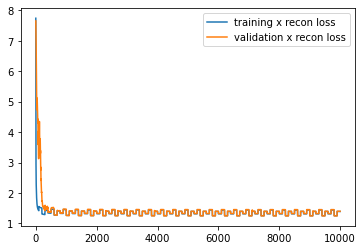

In [16]:
# plt.plot(np.arange(epochs),train_loss_ep)
# plt.plot(np.arange(epochs),val_loss_ep)
plt.plot(np.arange(epochs),train_loss_x_ep)
plt.plot(np.arange(epochs),val_loss_x_ep)
# plt.plot(np.arange(epochs),train_loss_a_ep)
# plt.plot(np.arange(epochs),val_loss_a_ep)
# plt.plot(np.arange(epochs),train_loss_kl_ep)
# plt.plot(np.arange(epochs),np.array(train_loss_adv_ep)*advWeight)
# plt.plot(np.arange(epochs),np.array(val_loss_adv_ep)*advWeight)
# plt.plot(np.arange(epochs),np.array(train_loss_advD_ep)*advWeight)
# plt.plot(np.arange(epochs),np.array(val_loss_advD_ep)*advWeight)
# plt.plot(np.arange(epochs),np.array(train_loss_clf_ep)*clfweight)
# plt.plot(np.arange(epochs),np.array(val_loss_clf_ep)*clfweight)
# plt.ylim((0,500))
# plt.xlim((0,1000))
# plt.legend(['training loss','validation loss','training x recon loss','validation x recon loss','training kl loss'],loc='upper right')
# plt.legend(['training loss','validation loss','training x recon loss','validation x recon loss','training a recon loss','validation a recon loss','training kl loss','training classifier loss','validation classifier loss'],loc='upper right')
plt.legend(['training x recon loss','validation x recon loss','training a recon loss','validation a recon loss','training kl loss','training discriminator ae','validation discriminator ae','training discriminator d','validation discriminator d'],loc='upper right')
# plt.legend(['training loss','validation loss','training x recon loss','validation x recon loss','training a recon loss','validation a recon loss','training kl loss','training discriminator ae','validation discriminator ae','training discriminator d','validation discriminator d'],loc='upper right')
plt.savefig(os.path.join(plotsavepath,'loss_seed3_x.jpg'))
plt.show()


In [14]:
# name='c13k20XA_07_dca'
# logsavepath='/mnt/xinyi/pamrats/log/train_gae_starmap/'+name
# with open(os.path.join(logsavepath,'val_loss_a'), 'rb') as output:
#     val_loss_a_ep=pickle.load(output)
# np.argmin(loss[:3280])
np.where(np.logical_not(np.isfinite(val_loss_ep[:])))
# val_loss_a_ep[1040]

(array([], dtype=int64),)

In [20]:
testepoch=9990
model.load_state_dict(torch.load(os.path.join(modelsavepath,str(testepoch)+'.pt')))
model.eval()
for s in sampleidx.keys():
    print(s)
    
    adj_norm=adjnormlist[s].cuda().float()
    adj_label=adj_list[s].cuda().float()
    features=featureslist[s+'X_'+training_sample_X].cuda().float()
    pos_weight=pos_weightlist[s]
    norm=normlist[s]
    
    if 'dca' in model_str:
        features_raw=features_raw_list[s+'X_raw'].cuda()
    num_nodes,num_features = features.shape
    maskpath=os.path.join(savedir,'trainMask',s+'_'+maskedgeName+'_seed'+str(seed)+'.pkl')
    if useSavedMaskedEdges and os.path.exists(maskpath):
#         print('opening saved')
        with open(maskpath, 'rb') as input:
            maskedgeres = pickle.load(input)
    else:
        # construct training, validation, and test sets
        maskedgeres= preprocessing.mask_nodes_edges(features.shape[0],testNodeSize=testNodes,valNodeSize=valNodes)
        with open(maskpath, 'wb') as output:
            pickle.dump(maskedgeres, output, pickle.HIGHEST_PROTOCOL)
    train_nodes_idx,val_nodes_idx,test_nodes_idx = maskedgeres
    
    if s in training_samples:
        test_nodes_idx_s=test_nodes_idx
    else:
        test_nodes_idx_s=torch.tensor(np.arange(num_nodes))
        
#     adj_decode=None
#     if adj_decodeName == 'gala':
#         adj_decode=preprocessing.preprocess_graph_sharp(adj)

    if adj_decodeName==None:
        adj_recon,mu,logvar,z, features_recon = model(features, adj_norm)
    else:
        adj_decode=adj_decode.cuda()
        adj_recon,mu,logvar,z, features_recon = model(features, adj_norm,adj_decode)
    if adv and (s in list(sampleLabellist_ae.keys())):
        sampleLabel_ae=sampleLabellist_ae[s].cuda().float()
        modelAdv.eval()
        advOut=modelAdv(z)
    if 'dca' in model_str:
        loss_x_test=loss_x(features_recon, features,test_nodes_idx_s,XreconWeight,ridgeL,features_raw)
    else:
        loss_x_test=loss_x(features_recon, features,test_nodes_idx_s,XreconWeight,mse)
    loss_a_test=loss_a(adj_recon, adj_label, pos_weight, norm,test_nodes_idx_s)
    loss_test = loss_x_test+loss_a_test
    
    if adv and (s in list(sampleLabellist_ae.keys())):
        loss_adv_test=loss_adv(advOut,sampleLabel_ae,test_nodes_idx)
        print('loss_adv_test: {:.4f}'.format(loss_adv_test.item()))
        
    print('test results',
          'loss_test: {:.4f}'.format(loss_test.item()),
          'loss_x_test: {:.4f}'.format(loss_x_test.item()),
          'loss_a_test: {:.4f}'.format(loss_a_test.item()))
#          'loss_adv_test: {:.4f}'.format(loss_adv_test.item()))
    if protein:
        test_nodes_idx_s_genes=torch.clone(test_nodes_idx_s)
        test_nodes_idx_s_genes[2112:]=0
        test_nodes_idx_s_proteins=torch.clone(test_nodes_idx_s)
        test_nodes_idx_s_proteins[:2112]=0
        if 'dca' in model_str:
            loss_genes_test=loss_x(features_recon, features,test_nodes_idx_s_genes,XreconWeight,ridgeL,features_raw)
            loss_proteins_test=loss_x(features_recon, features,test_nodes_idx_s_proteins,XreconWeight,ridgeL,features_raw)
        print('loss_x_genes: {:.4f}'.format(loss_genes_test.item()),
          'loss_x_proteins: {:.4f}'.format(loss_proteins_test.item()))
    if 'dca' in model_str:
        features_raw=features_raw.cpu()

   

disease13
test results loss_test: 3.0341 loss_x_test: 1.4410 loss_a_test: 1.5931
control13
loss_adv_test: 0.6699
test results loss_test: 2.2388 loss_x_test: 1.3486 loss_a_test: 0.8902
disease8
test results loss_test: 2.2021 loss_x_test: 1.2694 loss_a_test: 0.9327
control8
loss_adv_test: 0.7140
test results loss_test: 2.1065 loss_x_test: 1.3712 loss_a_test: 0.7353


In [12]:
y_true=features
y_true_raw=features_raw
preds=features_recon
mask=nodesmask=torch.tensor(np.arange(num_nodes))
reconWeight=20
eps = 1e-10

output,pi,theta,y_pred=preds
nb_case=optimizer.optimizer_nb(preds,y_true,mask,reconWeight,eps = 1e-10,ifmean=False)- torch.log(pi+eps)

zero_nb = torch.pow(theta/(theta+y_pred+eps), theta)
zero_case = -torch.log(pi + ((1.0-pi)*zero_nb)+eps)
result = torch.where(torch.lt(y_true_raw.cuda(), 1), zero_case, nb_case)

In [13]:
result[:8,:8]

tensor([[-0.0000e+00, 2.1077e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00,
         -0.0000e+00, -0.0000e+00],
        [-0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00,
         -0.0000e+00, -0.0000e+00],
        [1.1921e-07, -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00,
         1.1921e-07, -0.0000e+00],
        [1.7968e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00, 1.7740e+00,
         1.1915e+00, -0.0000e+00],
        [-0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00,
         1.1921e-07, -0.0000e+00],
        [1.1921e-07, 1.1921e-07, 1.1921e-07, -0.0000e+00, 1.1921e-07, 1.1921e-07,
         1.1921e-07, 1.1921e-07],
        [-0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00,
         -0.0000e+00, -0.0000e+00],
        [-0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00,
         1.4272e+00, -0.0000e+00]], device='cuda:0', grad_fn=<Slic

In [14]:
features[:8,:8]

tensor([[-0.2504,  8.5853, -0.1941, -0.1474, -0.1934, -0.2717, -0.5645, -0.3465],
        [-0.2504, -0.1938, -0.1941, -0.1474, -0.1934, -0.2717, -0.5645, -0.3465],
        [-0.2504, -0.1938, -0.1941, -0.1474, -0.1934, -0.2717, -0.5645, -0.3465],
        [ 5.5540, -0.1938, -0.1941, -0.1474, -0.1934,  3.1612,  1.2601, -0.3465],
        [-0.2504, -0.1938, -0.1941, -0.1474, -0.1934, -0.2717, -0.5645, -0.3465],
        [-0.2504, -0.1938, -0.1941, -0.1474, -0.1934, -0.2717, -0.5645, -0.3465],
        [-0.2504, -0.1938, -0.1941, -0.1474, -0.1934, -0.2717, -0.5645, -0.3465],
        [-0.2504, -0.1938, -0.1941, -0.1474, -0.1934, -0.2717,  2.5718, -0.3465]],
       device='cuda:0')

In [15]:
zeroidx=(features_raw==0)
nonzeroidx=(features_raw!=0)
torch.sum(result[zeroidx])/torch.sum(result)

tensor(2.8589e-09, device='cuda:0', grad_fn=<DivBackward0>)

In [22]:
torch.sum(result[zeroidx])

tensor(0., device='cuda:0', grad_fn=<SumBackward0>)

In [13]:
# model.pi.weight[:8,:8]
model_str

'gcn_vae_xa_e2_d1_dca'